# CNN Model 11

**This notebook will build the following model**:
- Use only 50% of the data? Yes
- Batch Size: 32
- Batch Normalization: Yes, after every convolution
- Early Stopping: Yes, patience=3
- Reduce Learning Rate: Yes, patience=1
- Initial Learning Rate: 0.0001
- Epochs (max): 15
- Architecture:
    - Feature Extractor: \[Convolution -> Convolution -> Max Pool] repeated 3 times.
        - Leaky Relu activation function throughout
        - 2x2 pooling size
        - 3x3 filter size throughout
        - Filter count per convolution: 32, 64, 128
    - Classifier: 1 dense layer with 256 units
        - Sigmoid activation function

In [1]:
from data_pipeline import (prep_data, get_train_val_test_data, create_tensorflow_datasets, predict_on_kaggle_test_set)
from model_helper_functions import map_to_metrics, plot_metric, plot_learning_rate, save_history
import numpy as np
from PIL import Image
from time import time, gmtime
import json
import os
from collections import OrderedDict
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import layers
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2024-01-28 21:58:02.957113: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 21:58:03.000532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(15)

---

## Prepare Data

In [3]:
BATCH_SIZE = 32

In [4]:
data_dir = '../data'
df, train_val_dir = prep_data(data_dir)

In [5]:
train_df, val_df, test_df = get_train_val_test_data(df, use_half_data=True)
train_ds_str, val_ds_str, test_ds_str, train_ds, val_ds, test_ds = create_tensorflow_datasets(train_df, val_df, test_df, BATCH_SIZE)

Training set: 70%, Validation set: 22.5%, Test set: 7.5%


2024-01-28 21:58:09.501245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 21:58:09.535504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 21:58:09.539161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
image_count = len(list(train_val_dir.glob('*/*.tif')))
print('Total image count:',image_count)
print('Image count equal to dataframe length?', image_count == len(df))

Total image count: 220025
Image count equal to dataframe length? True


In [7]:
num_train_samples = tf.data.experimental.cardinality(train_ds_str).numpy()
num_val_samples = tf.data.experimental.cardinality(val_ds_str).numpy()
num_test_samples = tf.data.experimental.cardinality(test_ds_str).numpy()
print('Number of training samples:',num_train_samples)
print('Number of validation samples::',num_val_samples)
print('Number of test samples:',num_test_samples)

Number of training samples: 77008
Number of validation samples:: 24753
Number of test samples: 8251


In [8]:
example_image = Image.open(df.loc[0, 'path'])
image_shape = np.array(example_image).shape
print('Image shape:', image_shape)

Image shape: (96, 96, 3)


---

## Define Model

In [9]:
MODEL_NAME = 'model11'

In [10]:
model_metrics = OrderedDict([
    ('accuracy', keras.metrics.BinaryAccuracy(name='accuracy')),
    ('auc', keras.metrics.AUC(name='auc')),
])

In [11]:
model_output_dir = './model_checkpoints'
checkpoint_path = f"{model_output_dir}/{MODEL_NAME}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss')

In [12]:
# Define parameters for early stopping and learning rate reduction
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [13]:
# Model Architecture

model = Sequential()

# Feature Extractor
# N_1
model.add(layers.Conv2D(32, (3, 3), input_shape=image_shape))
model.add(layers.BatchNormalization())
model.add(layers.Activation('leaky_relu'))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('leaky_relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_2
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('leaky_relu'))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('leaky_relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_3
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('leaky_relu'))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('leaky_relu'))

model.add(layers.MaxPooling2D((2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(1, activation = "sigmoid"))


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = "binary_crossentropy",
              metrics=list(model_metrics.values()))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 94, 94, 32)        896       


 batch_normalization (Batch  (None, 94, 94, 32)        128       


 Normalization)                                                  


 activation (Activation)     (None, 94, 94, 32)        0         


 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      


 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       


 chNormalization)                                                


 activation_1 (Activation)   (None, 92, 92, 32)        0         


 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         


 D)                                                              


 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     


 batch_normalization_2 (Bat  (None, 44, 44, 64)        256       


 chNormalization)                                                


 activation_2 (Activation)   (None, 44, 44, 64)        0         


 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     


 batch_normalization_3 (Bat  (None, 42, 42, 64)        256       


 chNormalization)                                                


 activation_3 (Activation)   (None, 42, 42, 64)        0         


 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 64)        0         


 g2D)                                                            


 conv2d_4 (Conv2D)           (None, 19, 19, 128)       73856     


 batch_normalization_4 (Bat  (None, 19, 19, 128)       512       


 chNormalization)                                                


 activation_4 (Activation)   (None, 19, 19, 128)       0         


 conv2d_5 (Conv2D)           (None, 17, 17, 128)       147584    


 batch_normalization_5 (Bat  (None, 17, 17, 128)       512       


 chNormalization)                                                


 activation_5 (Activation)   (None, 17, 17, 128)       0         


 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0         


 g2D)                                                            


 flatten (Flatten)           (None, 8192)              0         


 dense (Dense)               (None, 256)               2097408   


 dense_1 (Dense)             (None, 1)                 257       


Total params: 2386465 (9.10 MB)


Trainable params: 2385569 (9.10 MB)


Non-trainable params: 896 (3.50 KB)


_________________________________________________________________


---

## Fit Model

In [14]:
EPOCHS = 15

In [15]:
start_time = time()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[cp_callback, reducel, earlystopper]
                   )
total_time = time() - start_time

Epoch 1/15


2024-01-28 21:58:12.282296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902


2024-01-28 21:58:12.542368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   1/2407 [..............................] - ETA: 55:34 - loss: 1.0874 - accuracy: 0.5625 - auc: 0.5455

   5/2407 [..............................] - ETA: 30s - loss: 2.6094 - accuracy: 0.5938 - auc: 0.5238  

  10/2407 [..............................] - ETA: 28s - loss: 1.9804 - accuracy: 0.5875 - auc: 0.5658

  15/2407 [..............................] - ETA: 28s - loss: 1.6226 - accuracy: 0.6104 - auc: 0.6305

  20/2407 [..............................] - ETA: 28s - loss: 1.4722 - accuracy: 0.6500 - auc: 0.6638

  25/2407 [..............................] - ETA: 28s - loss: 1.3043 - accuracy: 0.6850 - auc: 0.7114

  30/2407 [..............................] - ETA: 28s - loss: 1.2494 - accuracy: 0.6917 - auc: 0.7221

  35/2407 [..............................] - ETA: 27s - loss: 1.2616 - accuracy: 0.6946 - auc: 0.7205

  40/2407 [..............................] - ETA: 27s - loss: 1.2544 - accuracy: 0.6945 - auc: 0.7274

  45/2407 [..............................] - ETA: 27s - loss: 1.2117 - accuracy: 0.7007 - auc: 0.7346

  50/2407 [..............................] - ETA: 27s - loss: 1.2009 - accuracy: 0.6981 - auc: 0.7343

  55/2407 [..............................] - ETA: 27s - loss: 1.1517 - accuracy: 0.7034 - auc: 0.7429

  60/2407 [..............................] - ETA: 27s - loss: 1.1173 - accuracy: 0.7089 - auc: 0.7480

  65/2407 [..............................] - ETA: 27s - loss: 1.0819 - accuracy: 0.7106 - auc: 0.7532

  70/2407 [..............................] - ETA: 27s - loss: 1.0700 - accuracy: 0.7107 - auc: 0.7536

  75/2407 [..............................] - ETA: 27s - loss: 1.0355 - accuracy: 0.7125 - auc: 0.7574

  80/2407 [..............................] - ETA: 27s - loss: 1.0118 - accuracy: 0.7129 - auc: 0.7579

  85/2407 [>.............................] - ETA: 27s - loss: 0.9904 - accuracy: 0.7129 - auc: 0.7584

  90/2407 [>.............................] - ETA: 27s - loss: 0.9631 - accuracy: 0.7153 - auc: 0.7608

  95/2407 [>.............................] - ETA: 27s - loss: 0.9392 - accuracy: 0.7217 - auc: 0.7667

 100/2407 [>.............................] - ETA: 27s - loss: 0.9236 - accuracy: 0.7237 - auc: 0.7696

 105/2407 [>.............................] - ETA: 27s - loss: 0.9050 - accuracy: 0.7265 - auc: 0.7745

 110/2407 [>.............................] - ETA: 27s - loss: 0.8864 - accuracy: 0.7284 - auc: 0.7786

 115/2407 [>.............................] - ETA: 26s - loss: 0.8786 - accuracy: 0.7302 - auc: 0.7788

 120/2407 [>.............................] - ETA: 26s - loss: 0.8647 - accuracy: 0.7315 - auc: 0.7815

 125/2407 [>.............................] - ETA: 26s - loss: 0.8610 - accuracy: 0.7297 - auc: 0.7791

 130/2407 [>.............................] - ETA: 26s - loss: 0.8496 - accuracy: 0.7293 - auc: 0.7791

 135/2407 [>.............................] - ETA: 26s - loss: 0.8404 - accuracy: 0.7317 - auc: 0.7794

 140/2407 [>.............................] - ETA: 26s - loss: 0.8319 - accuracy: 0.7319 - auc: 0.7795

 145/2407 [>.............................] - ETA: 26s - loss: 0.8293 - accuracy: 0.7300 - auc: 0.7778

 150/2407 [>.............................] - ETA: 26s - loss: 0.8232 - accuracy: 0.7304 - auc: 0.7780

 155/2407 [>.............................] - ETA: 26s - loss: 0.8208 - accuracy: 0.7280 - auc: 0.7775

 160/2407 [>.............................] - ETA: 26s - loss: 0.8198 - accuracy: 0.7262 - auc: 0.7763

 165/2407 [=>............................] - ETA: 26s - loss: 0.8208 - accuracy: 0.7252 - auc: 0.7742

 170/2407 [=>............................] - ETA: 26s - loss: 0.8165 - accuracy: 0.7244 - auc: 0.7744

 175/2407 [=>............................] - ETA: 26s - loss: 0.8156 - accuracy: 0.7246 - auc: 0.7747

 180/2407 [=>............................] - ETA: 26s - loss: 0.8053 - accuracy: 0.7274 - auc: 0.7777

 185/2407 [=>............................] - ETA: 26s - loss: 0.7988 - accuracy: 0.7275 - auc: 0.7788

 190/2407 [=>............................] - ETA: 26s - loss: 0.7921 - accuracy: 0.7281 - auc: 0.7800

 195/2407 [=>............................] - ETA: 26s - loss: 0.7852 - accuracy: 0.7296 - auc: 0.7810

 200/2407 [=>............................] - ETA: 25s - loss: 0.7849 - accuracy: 0.7280 - auc: 0.7794

 205/2407 [=>............................] - ETA: 25s - loss: 0.7802 - accuracy: 0.7277 - auc: 0.7794

 210/2407 [=>............................] - ETA: 25s - loss: 0.7749 - accuracy: 0.7271 - auc: 0.7800

 215/2407 [=>............................] - ETA: 25s - loss: 0.7688 - accuracy: 0.7278 - auc: 0.7813

 220/2407 [=>............................] - ETA: 25s - loss: 0.7632 - accuracy: 0.7287 - auc: 0.7826

 225/2407 [=>............................] - ETA: 25s - loss: 0.7577 - accuracy: 0.7296 - auc: 0.7837

 230/2407 [=>............................] - ETA: 25s - loss: 0.7522 - accuracy: 0.7311 - auc: 0.7853

 235/2407 [=>............................] - ETA: 25s - loss: 0.7463 - accuracy: 0.7327 - auc: 0.7872

 240/2407 [=>............................] - ETA: 25s - loss: 0.7408 - accuracy: 0.7344 - auc: 0.7888

 245/2407 [==>...........................] - ETA: 25s - loss: 0.7380 - accuracy: 0.7346 - auc: 0.7891

 250/2407 [==>...........................] - ETA: 25s - loss: 0.7366 - accuracy: 0.7346 - auc: 0.7893

 255/2407 [==>...........................] - ETA: 25s - loss: 0.7344 - accuracy: 0.7344 - auc: 0.7900

 260/2407 [==>...........................] - ETA: 25s - loss: 0.7335 - accuracy: 0.7353 - auc: 0.7900

 265/2407 [==>...........................] - ETA: 25s - loss: 0.7347 - accuracy: 0.7344 - auc: 0.7892

 270/2407 [==>...........................] - ETA: 25s - loss: 0.7371 - accuracy: 0.7329 - auc: 0.7877

 275/2407 [==>...........................] - ETA: 25s - loss: 0.7347 - accuracy: 0.7326 - auc: 0.7879

 280/2407 [==>...........................] - ETA: 25s - loss: 0.7310 - accuracy: 0.7333 - auc: 0.7887

 285/2407 [==>...........................] - ETA: 25s - loss: 0.7295 - accuracy: 0.7334 - auc: 0.7892

 290/2407 [==>...........................] - ETA: 24s - loss: 0.7323 - accuracy: 0.7334 - auc: 0.7889

 295/2407 [==>...........................] - ETA: 24s - loss: 0.7310 - accuracy: 0.7338 - auc: 0.7897

 300/2407 [==>...........................] - ETA: 24s - loss: 0.7294 - accuracy: 0.7347 - auc: 0.7910

 305/2407 [==>...........................] - ETA: 24s - loss: 0.7300 - accuracy: 0.7348 - auc: 0.7914

 310/2407 [==>...........................] - ETA: 24s - loss: 0.7272 - accuracy: 0.7365 - auc: 0.7929

 315/2407 [==>...........................] - ETA: 24s - loss: 0.7338 - accuracy: 0.7349 - auc: 0.7908

 320/2407 [==>...........................] - ETA: 24s - loss: 0.7408 - accuracy: 0.7333 - auc: 0.7887

 325/2407 [===>..........................] - ETA: 24s - loss: 0.7390 - accuracy: 0.7341 - auc: 0.7894

 330/2407 [===>..........................] - ETA: 24s - loss: 0.7413 - accuracy: 0.7332 - auc: 0.7886

 335/2407 [===>..........................] - ETA: 24s - loss: 0.7445 - accuracy: 0.7332 - auc: 0.7881

 340/2407 [===>..........................] - ETA: 24s - loss: 0.7445 - accuracy: 0.7328 - auc: 0.7876

 345/2407 [===>..........................] - ETA: 24s - loss: 0.7422 - accuracy: 0.7328 - auc: 0.7878

 350/2407 [===>..........................] - ETA: 24s - loss: 0.7394 - accuracy: 0.7332 - auc: 0.7880

 355/2407 [===>..........................] - ETA: 24s - loss: 0.7391 - accuracy: 0.7341 - auc: 0.7881

 360/2407 [===>..........................] - ETA: 24s - loss: 0.7386 - accuracy: 0.7332 - auc: 0.7878

 365/2407 [===>..........................] - ETA: 24s - loss: 0.7380 - accuracy: 0.7334 - auc: 0.7881

 370/2407 [===>..........................] - ETA: 24s - loss: 0.7375 - accuracy: 0.7340 - auc: 0.7883

 375/2407 [===>..........................] - ETA: 23s - loss: 0.7354 - accuracy: 0.7337 - auc: 0.7887

 380/2407 [===>..........................] - ETA: 23s - loss: 0.7338 - accuracy: 0.7336 - auc: 0.7889

 385/2407 [===>..........................] - ETA: 23s - loss: 0.7317 - accuracy: 0.7337 - auc: 0.7892

 390/2407 [===>..........................] - ETA: 23s - loss: 0.7286 - accuracy: 0.7344 - auc: 0.7900

 395/2407 [===>..........................] - ETA: 23s - loss: 0.7281 - accuracy: 0.7345 - auc: 0.7900

 400/2407 [===>..........................] - ETA: 23s - loss: 0.7266 - accuracy: 0.7346 - auc: 0.7902

 405/2407 [====>.........................] - ETA: 23s - loss: 0.7245 - accuracy: 0.7349 - auc: 0.7911

 410/2407 [====>.........................] - ETA: 23s - loss: 0.7214 - accuracy: 0.7357 - auc: 0.7921

 414/2407 [====>.........................] - ETA: 23s - loss: 0.7217 - accuracy: 0.7357 - auc: 0.7918

 418/2407 [====>.........................] - ETA: 23s - loss: 0.7217 - accuracy: 0.7352 - auc: 0.7914

 423/2407 [====>.........................] - ETA: 23s - loss: 0.7203 - accuracy: 0.7349 - auc: 0.7913

 428/2407 [====>.........................] - ETA: 23s - loss: 0.7198 - accuracy: 0.7343 - auc: 0.7910

 433/2407 [====>.........................] - ETA: 23s - loss: 0.7198 - accuracy: 0.7341 - auc: 0.7908

 438/2407 [====>.........................] - ETA: 23s - loss: 0.7196 - accuracy: 0.7339 - auc: 0.7909

 443/2407 [====>.........................] - ETA: 23s - loss: 0.7206 - accuracy: 0.7338 - auc: 0.7907

 448/2407 [====>.........................] - ETA: 23s - loss: 0.7193 - accuracy: 0.7339 - auc: 0.7908

 453/2407 [====>.........................] - ETA: 23s - loss: 0.7178 - accuracy: 0.7340 - auc: 0.7907

 458/2407 [====>.........................] - ETA: 23s - loss: 0.7152 - accuracy: 0.7347 - auc: 0.7910

 463/2407 [====>.........................] - ETA: 22s - loss: 0.7121 - accuracy: 0.7356 - auc: 0.7916

 468/2407 [====>.........................] - ETA: 22s - loss: 0.7110 - accuracy: 0.7354 - auc: 0.7915

 473/2407 [====>.........................] - ETA: 22s - loss: 0.7075 - accuracy: 0.7365 - auc: 0.7924

 478/2407 [====>.........................] - ETA: 22s - loss: 0.7058 - accuracy: 0.7368 - auc: 0.7928

 483/2407 [=====>........................] - ETA: 22s - loss: 0.7035 - accuracy: 0.7367 - auc: 0.7934

 488/2407 [=====>........................] - ETA: 22s - loss: 0.7028 - accuracy: 0.7368 - auc: 0.7934

 493/2407 [=====>........................] - ETA: 22s - loss: 0.7022 - accuracy: 0.7366 - auc: 0.7934

 498/2407 [=====>........................] - ETA: 22s - loss: 0.7013 - accuracy: 0.7363 - auc: 0.7933

 503/2407 [=====>........................] - ETA: 22s - loss: 0.6999 - accuracy: 0.7366 - auc: 0.7934

 508/2407 [=====>........................] - ETA: 22s - loss: 0.6985 - accuracy: 0.7365 - auc: 0.7933

 513/2407 [=====>........................] - ETA: 22s - loss: 0.6979 - accuracy: 0.7365 - auc: 0.7933

 518/2407 [=====>........................] - ETA: 22s - loss: 0.6953 - accuracy: 0.7371 - auc: 0.7941

 523/2407 [=====>........................] - ETA: 22s - loss: 0.6937 - accuracy: 0.7376 - auc: 0.7947

 528/2407 [=====>........................] - ETA: 22s - loss: 0.6920 - accuracy: 0.7383 - auc: 0.7954

 533/2407 [=====>........................] - ETA: 22s - loss: 0.6904 - accuracy: 0.7387 - auc: 0.7962

 538/2407 [=====>........................] - ETA: 22s - loss: 0.6886 - accuracy: 0.7391 - auc: 0.7970

 543/2407 [=====>........................] - ETA: 22s - loss: 0.6867 - accuracy: 0.7395 - auc: 0.7976

 548/2407 [=====>........................] - ETA: 22s - loss: 0.6850 - accuracy: 0.7401 - auc: 0.7982

 552/2407 [=====>........................] - ETA: 21s - loss: 0.6844 - accuracy: 0.7403 - auc: 0.7980

 556/2407 [=====>........................] - ETA: 21s - loss: 0.6824 - accuracy: 0.7410 - auc: 0.7985

 561/2407 [=====>........................] - ETA: 21s - loss: 0.6806 - accuracy: 0.7411 - auc: 0.7990

 566/2407 [======>.......................] - ETA: 21s - loss: 0.6789 - accuracy: 0.7417 - auc: 0.7996

 571/2407 [======>.......................] - ETA: 21s - loss: 0.6790 - accuracy: 0.7414 - auc: 0.7994

 576/2407 [======>.......................] - ETA: 21s - loss: 0.6771 - accuracy: 0.7416 - auc: 0.7997

 581/2407 [======>.......................] - ETA: 21s - loss: 0.6749 - accuracy: 0.7426 - auc: 0.8003

 586/2407 [======>.......................] - ETA: 21s - loss: 0.6756 - accuracy: 0.7417 - auc: 0.7998

 591/2407 [======>.......................] - ETA: 21s - loss: 0.6762 - accuracy: 0.7414 - auc: 0.7995

 596/2407 [======>.......................] - ETA: 21s - loss: 0.6755 - accuracy: 0.7418 - auc: 0.8000

 601/2407 [======>.......................] - ETA: 21s - loss: 0.6747 - accuracy: 0.7419 - auc: 0.8003

 606/2407 [======>.......................] - ETA: 21s - loss: 0.6759 - accuracy: 0.7416 - auc: 0.7998

 611/2407 [======>.......................] - ETA: 21s - loss: 0.6762 - accuracy: 0.7414 - auc: 0.7995

 616/2407 [======>.......................] - ETA: 21s - loss: 0.6745 - accuracy: 0.7419 - auc: 0.8001

 621/2407 [======>.......................] - ETA: 21s - loss: 0.6737 - accuracy: 0.7422 - auc: 0.8004

 626/2407 [======>.......................] - ETA: 21s - loss: 0.6746 - accuracy: 0.7420 - auc: 0.8000

 631/2407 [======>.......................] - ETA: 21s - loss: 0.6752 - accuracy: 0.7417 - auc: 0.7996

 636/2407 [======>.......................] - ETA: 20s - loss: 0.6747 - accuracy: 0.7415 - auc: 0.7996

 641/2407 [======>.......................] - ETA: 20s - loss: 0.6734 - accuracy: 0.7418 - auc: 0.8000

 646/2407 [=======>......................] - ETA: 20s - loss: 0.6738 - accuracy: 0.7422 - auc: 0.8002

 651/2407 [=======>......................] - ETA: 20s - loss: 0.6726 - accuracy: 0.7425 - auc: 0.8009

 656/2407 [=======>......................] - ETA: 20s - loss: 0.6728 - accuracy: 0.7427 - auc: 0.8010

 661/2407 [=======>......................] - ETA: 20s - loss: 0.6733 - accuracy: 0.7427 - auc: 0.8011

 666/2407 [=======>......................] - ETA: 20s - loss: 0.6722 - accuracy: 0.7432 - auc: 0.8016

 671/2407 [=======>......................] - ETA: 20s - loss: 0.6703 - accuracy: 0.7438 - auc: 0.8022

 676/2407 [=======>......................] - ETA: 20s - loss: 0.6689 - accuracy: 0.7441 - auc: 0.8025

 681/2407 [=======>......................] - ETA: 20s - loss: 0.6677 - accuracy: 0.7444 - auc: 0.8028

 686/2407 [=======>......................] - ETA: 20s - loss: 0.6671 - accuracy: 0.7442 - auc: 0.8029

 691/2407 [=======>......................] - ETA: 20s - loss: 0.6674 - accuracy: 0.7439 - auc: 0.8026

 696/2407 [=======>......................] - ETA: 20s - loss: 0.6672 - accuracy: 0.7439 - auc: 0.8025

 701/2407 [=======>......................] - ETA: 20s - loss: 0.6656 - accuracy: 0.7443 - auc: 0.8029

 706/2407 [=======>......................] - ETA: 20s - loss: 0.6638 - accuracy: 0.7448 - auc: 0.8034

 710/2407 [=======>......................] - ETA: 20s - loss: 0.6638 - accuracy: 0.7445 - auc: 0.8034

 715/2407 [=======>......................] - ETA: 20s - loss: 0.6627 - accuracy: 0.7449 - auc: 0.8036

 720/2407 [=======>......................] - ETA: 19s - loss: 0.6626 - accuracy: 0.7451 - auc: 0.8034

 725/2407 [========>.....................] - ETA: 19s - loss: 0.6610 - accuracy: 0.7458 - auc: 0.8039

 730/2407 [========>.....................] - ETA: 19s - loss: 0.6607 - accuracy: 0.7460 - auc: 0.8039

 735/2407 [========>.....................] - ETA: 19s - loss: 0.6591 - accuracy: 0.7464 - auc: 0.8045

 740/2407 [========>.....................] - ETA: 19s - loss: 0.6585 - accuracy: 0.7465 - auc: 0.8045

 745/2407 [========>.....................] - ETA: 19s - loss: 0.6577 - accuracy: 0.7468 - auc: 0.8045

 750/2407 [========>.....................] - ETA: 19s - loss: 0.6563 - accuracy: 0.7469 - auc: 0.8048

 755/2407 [========>.....................] - ETA: 19s - loss: 0.6548 - accuracy: 0.7474 - auc: 0.8054

 760/2407 [========>.....................] - ETA: 19s - loss: 0.6548 - accuracy: 0.7475 - auc: 0.8053

 765/2407 [========>.....................] - ETA: 19s - loss: 0.6537 - accuracy: 0.7479 - auc: 0.8057

 770/2407 [========>.....................] - ETA: 19s - loss: 0.6547 - accuracy: 0.7479 - auc: 0.8055

 775/2407 [========>.....................] - ETA: 19s - loss: 0.6549 - accuracy: 0.7475 - auc: 0.8053

 780/2407 [========>.....................] - ETA: 19s - loss: 0.6556 - accuracy: 0.7476 - auc: 0.8051

 785/2407 [========>.....................] - ETA: 19s - loss: 0.6561 - accuracy: 0.7475 - auc: 0.8048

 790/2407 [========>.....................] - ETA: 19s - loss: 0.6561 - accuracy: 0.7474 - auc: 0.8047

 795/2407 [========>.....................] - ETA: 19s - loss: 0.6550 - accuracy: 0.7474 - auc: 0.8049

 800/2407 [========>.....................] - ETA: 19s - loss: 0.6547 - accuracy: 0.7473 - auc: 0.8048

 805/2407 [=========>....................] - ETA: 18s - loss: 0.6536 - accuracy: 0.7474 - auc: 0.8051

 810/2407 [=========>....................] - ETA: 18s - loss: 0.6523 - accuracy: 0.7477 - auc: 0.8054

 815/2407 [=========>....................] - ETA: 18s - loss: 0.6512 - accuracy: 0.7480 - auc: 0.8057

 820/2407 [=========>....................] - ETA: 18s - loss: 0.6496 - accuracy: 0.7484 - auc: 0.8062

 825/2407 [=========>....................] - ETA: 18s - loss: 0.6478 - accuracy: 0.7491 - auc: 0.8068

 830/2407 [=========>....................] - ETA: 18s - loss: 0.6463 - accuracy: 0.7497 - auc: 0.8074

 835/2407 [=========>....................] - ETA: 18s - loss: 0.6463 - accuracy: 0.7496 - auc: 0.8074

 840/2407 [=========>....................] - ETA: 18s - loss: 0.6460 - accuracy: 0.7500 - auc: 0.8076

 845/2407 [=========>....................] - ETA: 18s - loss: 0.6455 - accuracy: 0.7503 - auc: 0.8079

 850/2407 [=========>....................] - ETA: 18s - loss: 0.6452 - accuracy: 0.7503 - auc: 0.8079

 855/2407 [=========>....................] - ETA: 18s - loss: 0.6451 - accuracy: 0.7501 - auc: 0.8079

 860/2407 [=========>....................] - ETA: 18s - loss: 0.6445 - accuracy: 0.7501 - auc: 0.8080

 865/2407 [=========>....................] - ETA: 18s - loss: 0.6435 - accuracy: 0.7507 - auc: 0.8084

 869/2407 [=========>....................] - ETA: 18s - loss: 0.6431 - accuracy: 0.7507 - auc: 0.8085

 874/2407 [=========>....................] - ETA: 18s - loss: 0.6426 - accuracy: 0.7508 - auc: 0.8085

 879/2407 [=========>....................] - ETA: 18s - loss: 0.6416 - accuracy: 0.7512 - auc: 0.8088

 884/2407 [==========>...................] - ETA: 18s - loss: 0.6405 - accuracy: 0.7516 - auc: 0.8092

 889/2407 [==========>...................] - ETA: 17s - loss: 0.6397 - accuracy: 0.7517 - auc: 0.8095

 894/2407 [==========>...................] - ETA: 17s - loss: 0.6391 - accuracy: 0.7520 - auc: 0.8098

 899/2407 [==========>...................] - ETA: 17s - loss: 0.6385 - accuracy: 0.7523 - auc: 0.8102

 904/2407 [==========>...................] - ETA: 17s - loss: 0.6376 - accuracy: 0.7527 - auc: 0.8104

 909/2407 [==========>...................] - ETA: 17s - loss: 0.6369 - accuracy: 0.7528 - auc: 0.8106

 914/2407 [==========>...................] - ETA: 17s - loss: 0.6365 - accuracy: 0.7527 - auc: 0.8105

 919/2407 [==========>...................] - ETA: 17s - loss: 0.6355 - accuracy: 0.7530 - auc: 0.8108

 924/2407 [==========>...................] - ETA: 17s - loss: 0.6351 - accuracy: 0.7530 - auc: 0.8109

 929/2407 [==========>...................] - ETA: 17s - loss: 0.6343 - accuracy: 0.7531 - auc: 0.8111

 934/2407 [==========>...................] - ETA: 17s - loss: 0.6339 - accuracy: 0.7531 - auc: 0.8112

 939/2407 [==========>...................] - ETA: 17s - loss: 0.6332 - accuracy: 0.7536 - auc: 0.8114

 944/2407 [==========>...................] - ETA: 17s - loss: 0.6326 - accuracy: 0.7537 - auc: 0.8115

 949/2407 [==========>...................] - ETA: 17s - loss: 0.6321 - accuracy: 0.7540 - auc: 0.8118

 954/2407 [==========>...................] - ETA: 17s - loss: 0.6314 - accuracy: 0.7543 - auc: 0.8123

 959/2407 [==========>...................] - ETA: 17s - loss: 0.6307 - accuracy: 0.7546 - auc: 0.8126

 964/2407 [===========>..................] - ETA: 17s - loss: 0.6304 - accuracy: 0.7547 - auc: 0.8128

 969/2407 [===========>..................] - ETA: 17s - loss: 0.6299 - accuracy: 0.7549 - auc: 0.8131

 974/2407 [===========>..................] - ETA: 16s - loss: 0.6295 - accuracy: 0.7549 - auc: 0.8133

 979/2407 [===========>..................] - ETA: 16s - loss: 0.6289 - accuracy: 0.7550 - auc: 0.8134

 984/2407 [===========>..................] - ETA: 16s - loss: 0.6281 - accuracy: 0.7552 - auc: 0.8135

 989/2407 [===========>..................] - ETA: 16s - loss: 0.6272 - accuracy: 0.7554 - auc: 0.8137

 994/2407 [===========>..................] - ETA: 16s - loss: 0.6278 - accuracy: 0.7552 - auc: 0.8135

 999/2407 [===========>..................] - ETA: 16s - loss: 0.6272 - accuracy: 0.7555 - auc: 0.8137

1004/2407 [===========>..................] - ETA: 16s - loss: 0.6268 - accuracy: 0.7555 - auc: 0.8138

1009/2407 [===========>..................] - ETA: 16s - loss: 0.6260 - accuracy: 0.7557 - auc: 0.8139

1014/2407 [===========>..................] - ETA: 16s - loss: 0.6252 - accuracy: 0.7558 - auc: 0.8141

1019/2407 [===========>..................] - ETA: 16s - loss: 0.6247 - accuracy: 0.7561 - auc: 0.8144

1024/2407 [===========>..................] - ETA: 16s - loss: 0.6237 - accuracy: 0.7563 - auc: 0.8147

1028/2407 [===========>..................] - ETA: 16s - loss: 0.6228 - accuracy: 0.7566 - auc: 0.8151

1033/2407 [===========>..................] - ETA: 16s - loss: 0.6219 - accuracy: 0.7568 - auc: 0.8154

1038/2407 [===========>..................] - ETA: 16s - loss: 0.6216 - accuracy: 0.7567 - auc: 0.8154

1043/2407 [===========>..................] - ETA: 16s - loss: 0.6213 - accuracy: 0.7566 - auc: 0.8154

1048/2407 [============>.................] - ETA: 16s - loss: 0.6203 - accuracy: 0.7569 - auc: 0.8157

1053/2407 [============>.................] - ETA: 16s - loss: 0.6199 - accuracy: 0.7570 - auc: 0.8159

1058/2407 [============>.................] - ETA: 15s - loss: 0.6191 - accuracy: 0.7571 - auc: 0.8161

1063/2407 [============>.................] - ETA: 15s - loss: 0.6180 - accuracy: 0.7576 - auc: 0.8165

1068/2407 [============>.................] - ETA: 15s - loss: 0.6173 - accuracy: 0.7578 - auc: 0.8169

1073/2407 [============>.................] - ETA: 15s - loss: 0.6172 - accuracy: 0.7578 - auc: 0.8170

1078/2407 [============>.................] - ETA: 15s - loss: 0.6170 - accuracy: 0.7580 - auc: 0.8171

1083/2407 [============>.................] - ETA: 15s - loss: 0.6170 - accuracy: 0.7578 - auc: 0.8172

1088/2407 [============>.................] - ETA: 15s - loss: 0.6179 - accuracy: 0.7576 - auc: 0.8170

1093/2407 [============>.................] - ETA: 15s - loss: 0.6187 - accuracy: 0.7576 - auc: 0.8169

1098/2407 [============>.................] - ETA: 15s - loss: 0.6184 - accuracy: 0.7576 - auc: 0.8170

1103/2407 [============>.................] - ETA: 15s - loss: 0.6178 - accuracy: 0.7578 - auc: 0.8172

1108/2407 [============>.................] - ETA: 15s - loss: 0.6173 - accuracy: 0.7579 - auc: 0.8173

1113/2407 [============>.................] - ETA: 15s - loss: 0.6171 - accuracy: 0.7580 - auc: 0.8174

1118/2407 [============>.................] - ETA: 15s - loss: 0.6167 - accuracy: 0.7580 - auc: 0.8174

1123/2407 [============>.................] - ETA: 15s - loss: 0.6161 - accuracy: 0.7582 - auc: 0.8175

1128/2407 [=============>................] - ETA: 15s - loss: 0.6154 - accuracy: 0.7584 - auc: 0.8177

1133/2407 [=============>................] - ETA: 15s - loss: 0.6143 - accuracy: 0.7587 - auc: 0.8180

1138/2407 [=============>................] - ETA: 15s - loss: 0.6138 - accuracy: 0.7588 - auc: 0.8182

1143/2407 [=============>................] - ETA: 14s - loss: 0.6129 - accuracy: 0.7592 - auc: 0.8184

1148/2407 [=============>................] - ETA: 14s - loss: 0.6122 - accuracy: 0.7593 - auc: 0.8187

1153/2407 [=============>................] - ETA: 14s - loss: 0.6121 - accuracy: 0.7592 - auc: 0.8187

1158/2407 [=============>................] - ETA: 14s - loss: 0.6113 - accuracy: 0.7594 - auc: 0.8189

1163/2407 [=============>................] - ETA: 14s - loss: 0.6107 - accuracy: 0.7595 - auc: 0.8191

1168/2407 [=============>................] - ETA: 14s - loss: 0.6103 - accuracy: 0.7595 - auc: 0.8192

1173/2407 [=============>................] - ETA: 14s - loss: 0.6097 - accuracy: 0.7596 - auc: 0.8194

1178/2407 [=============>................] - ETA: 14s - loss: 0.6093 - accuracy: 0.7598 - auc: 0.8195

1183/2407 [=============>................] - ETA: 14s - loss: 0.6084 - accuracy: 0.7601 - auc: 0.8198

1188/2407 [=============>................] - ETA: 14s - loss: 0.6080 - accuracy: 0.7601 - auc: 0.8199

1193/2407 [=============>................] - ETA: 14s - loss: 0.6073 - accuracy: 0.7604 - auc: 0.8202

1198/2407 [=============>................] - ETA: 14s - loss: 0.6067 - accuracy: 0.7606 - auc: 0.8204

1203/2407 [=============>................] - ETA: 14s - loss: 0.6061 - accuracy: 0.7609 - auc: 0.8206

1208/2407 [==============>...............] - ETA: 14s - loss: 0.6057 - accuracy: 0.7611 - auc: 0.8208

1213/2407 [==============>...............] - ETA: 14s - loss: 0.6047 - accuracy: 0.7615 - auc: 0.8212

1218/2407 [==============>...............] - ETA: 14s - loss: 0.6041 - accuracy: 0.7617 - auc: 0.8216

1223/2407 [==============>...............] - ETA: 14s - loss: 0.6036 - accuracy: 0.7619 - auc: 0.8218

1228/2407 [==============>...............] - ETA: 13s - loss: 0.6033 - accuracy: 0.7620 - auc: 0.8219

1233/2407 [==============>...............] - ETA: 13s - loss: 0.6026 - accuracy: 0.7623 - auc: 0.8222

1238/2407 [==============>...............] - ETA: 13s - loss: 0.6023 - accuracy: 0.7624 - auc: 0.8223

1243/2407 [==============>...............] - ETA: 13s - loss: 0.6021 - accuracy: 0.7624 - auc: 0.8224

1248/2407 [==============>...............] - ETA: 13s - loss: 0.6027 - accuracy: 0.7624 - auc: 0.8224

1253/2407 [==============>...............] - ETA: 13s - loss: 0.6024 - accuracy: 0.7625 - auc: 0.8225

1258/2407 [==============>...............] - ETA: 13s - loss: 0.6020 - accuracy: 0.7625 - auc: 0.8227

1263/2407 [==============>...............] - ETA: 13s - loss: 0.6021 - accuracy: 0.7627 - auc: 0.8227

1268/2407 [==============>...............] - ETA: 13s - loss: 0.6014 - accuracy: 0.7630 - auc: 0.8231

1273/2407 [==============>...............] - ETA: 13s - loss: 0.6009 - accuracy: 0.7633 - auc: 0.8232

1278/2407 [==============>...............] - ETA: 13s - loss: 0.6001 - accuracy: 0.7635 - auc: 0.8236

1283/2407 [==============>...............] - ETA: 13s - loss: 0.6002 - accuracy: 0.7636 - auc: 0.8236

1288/2407 [===============>..............] - ETA: 13s - loss: 0.5995 - accuracy: 0.7638 - auc: 0.8237

1293/2407 [===============>..............] - ETA: 13s - loss: 0.5985 - accuracy: 0.7642 - auc: 0.8241

1298/2407 [===============>..............] - ETA: 13s - loss: 0.5981 - accuracy: 0.7642 - auc: 0.8242

1303/2407 [===============>..............] - ETA: 13s - loss: 0.5976 - accuracy: 0.7644 - auc: 0.8243

1308/2407 [===============>..............] - ETA: 13s - loss: 0.5969 - accuracy: 0.7645 - auc: 0.8244

1313/2407 [===============>..............] - ETA: 12s - loss: 0.5959 - accuracy: 0.7649 - auc: 0.8247

1318/2407 [===============>..............] - ETA: 12s - loss: 0.5954 - accuracy: 0.7651 - auc: 0.8250

1323/2407 [===============>..............] - ETA: 12s - loss: 0.5946 - accuracy: 0.7654 - auc: 0.8252

1328/2407 [===============>..............] - ETA: 12s - loss: 0.5948 - accuracy: 0.7653 - auc: 0.8251

1333/2407 [===============>..............] - ETA: 12s - loss: 0.5942 - accuracy: 0.7654 - auc: 0.8252

1338/2407 [===============>..............] - ETA: 12s - loss: 0.5943 - accuracy: 0.7653 - auc: 0.8252

1343/2407 [===============>..............] - ETA: 12s - loss: 0.5940 - accuracy: 0.7654 - auc: 0.8252

1348/2407 [===============>..............] - ETA: 12s - loss: 0.5937 - accuracy: 0.7654 - auc: 0.8254

1353/2407 [===============>..............] - ETA: 12s - loss: 0.5938 - accuracy: 0.7654 - auc: 0.8253

1358/2407 [===============>..............] - ETA: 12s - loss: 0.5938 - accuracy: 0.7654 - auc: 0.8253

1363/2407 [===============>..............] - ETA: 12s - loss: 0.5937 - accuracy: 0.7653 - auc: 0.8253

1368/2407 [================>.............] - ETA: 12s - loss: 0.5937 - accuracy: 0.7651 - auc: 0.8251

1373/2407 [================>.............] - ETA: 12s - loss: 0.5931 - accuracy: 0.7653 - auc: 0.8252

1378/2407 [================>.............] - ETA: 12s - loss: 0.5930 - accuracy: 0.7651 - auc: 0.8252

1383/2407 [================>.............] - ETA: 12s - loss: 0.5926 - accuracy: 0.7653 - auc: 0.8253

1388/2407 [================>.............] - ETA: 12s - loss: 0.5922 - accuracy: 0.7653 - auc: 0.8253

1393/2407 [================>.............] - ETA: 12s - loss: 0.5921 - accuracy: 0.7654 - auc: 0.8253

1398/2407 [================>.............] - ETA: 11s - loss: 0.5919 - accuracy: 0.7656 - auc: 0.8254

1403/2407 [================>.............] - ETA: 11s - loss: 0.5914 - accuracy: 0.7657 - auc: 0.8256

1408/2407 [================>.............] - ETA: 11s - loss: 0.5908 - accuracy: 0.7658 - auc: 0.8259

1413/2407 [================>.............] - ETA: 11s - loss: 0.5905 - accuracy: 0.7659 - auc: 0.8259

1418/2407 [================>.............] - ETA: 11s - loss: 0.5900 - accuracy: 0.7660 - auc: 0.8260

1423/2407 [================>.............] - ETA: 11s - loss: 0.5897 - accuracy: 0.7662 - auc: 0.8261

1428/2407 [================>.............] - ETA: 11s - loss: 0.5893 - accuracy: 0.7664 - auc: 0.8263

1433/2407 [================>.............] - ETA: 11s - loss: 0.5889 - accuracy: 0.7663 - auc: 0.8265

1438/2407 [================>.............] - ETA: 11s - loss: 0.5884 - accuracy: 0.7665 - auc: 0.8268

1443/2407 [================>.............] - ETA: 11s - loss: 0.5879 - accuracy: 0.7665 - auc: 0.8269

1448/2407 [=================>............] - ETA: 11s - loss: 0.5877 - accuracy: 0.7664 - auc: 0.8269

1453/2407 [=================>............] - ETA: 11s - loss: 0.5869 - accuracy: 0.7667 - auc: 0.8272

1458/2407 [=================>............] - ETA: 11s - loss: 0.5864 - accuracy: 0.7667 - auc: 0.8273

1463/2407 [=================>............] - ETA: 11s - loss: 0.5859 - accuracy: 0.7670 - auc: 0.8274

1468/2407 [=================>............] - ETA: 11s - loss: 0.5855 - accuracy: 0.7672 - auc: 0.8276

1473/2407 [=================>............] - ETA: 11s - loss: 0.5850 - accuracy: 0.7673 - auc: 0.8277

1478/2407 [=================>............] - ETA: 10s - loss: 0.5846 - accuracy: 0.7674 - auc: 0.8279

1483/2407 [=================>............] - ETA: 10s - loss: 0.5841 - accuracy: 0.7675 - auc: 0.8280

1488/2407 [=================>............] - ETA: 10s - loss: 0.5836 - accuracy: 0.7676 - auc: 0.8281

1493/2407 [=================>............] - ETA: 10s - loss: 0.5830 - accuracy: 0.7678 - auc: 0.8283

1498/2407 [=================>............] - ETA: 10s - loss: 0.5826 - accuracy: 0.7679 - auc: 0.8284

1503/2407 [=================>............] - ETA: 10s - loss: 0.5821 - accuracy: 0.7680 - auc: 0.8286

1508/2407 [=================>............] - ETA: 10s - loss: 0.5813 - accuracy: 0.7683 - auc: 0.8289

1513/2407 [=================>............] - ETA: 10s - loss: 0.5810 - accuracy: 0.7685 - auc: 0.8291

1518/2407 [=================>............] - ETA: 10s - loss: 0.5808 - accuracy: 0.7687 - auc: 0.8292

1523/2407 [=================>............] - ETA: 10s - loss: 0.5806 - accuracy: 0.7688 - auc: 0.8295

1528/2407 [==================>...........] - ETA: 10s - loss: 0.5809 - accuracy: 0.7688 - auc: 0.8293

1533/2407 [==================>...........] - ETA: 10s - loss: 0.5811 - accuracy: 0.7687 - auc: 0.8293

1538/2407 [==================>...........] - ETA: 10s - loss: 0.5813 - accuracy: 0.7687 - auc: 0.8292

1543/2407 [==================>...........] - ETA: 10s - loss: 0.5809 - accuracy: 0.7689 - auc: 0.8293

1548/2407 [==================>...........] - ETA: 10s - loss: 0.5808 - accuracy: 0.7688 - auc: 0.8293

1553/2407 [==================>...........] - ETA: 10s - loss: 0.5809 - accuracy: 0.7688 - auc: 0.8292

1558/2407 [==================>...........] - ETA: 10s - loss: 0.5803 - accuracy: 0.7691 - auc: 0.8294

1563/2407 [==================>...........] - ETA: 9s - loss: 0.5801 - accuracy: 0.7692 - auc: 0.8295 

1568/2407 [==================>...........] - ETA: 9s - loss: 0.5793 - accuracy: 0.7694 - auc: 0.8297

1573/2407 [==================>...........] - ETA: 9s - loss: 0.5786 - accuracy: 0.7696 - auc: 0.8300

1578/2407 [==================>...........] - ETA: 9s - loss: 0.5779 - accuracy: 0.7699 - auc: 0.8302

1583/2407 [==================>...........] - ETA: 9s - loss: 0.5775 - accuracy: 0.7700 - auc: 0.8304

1588/2407 [==================>...........] - ETA: 9s - loss: 0.5767 - accuracy: 0.7704 - auc: 0.8307

1593/2407 [==================>...........] - ETA: 9s - loss: 0.5764 - accuracy: 0.7705 - auc: 0.8307

1598/2407 [==================>...........] - ETA: 9s - loss: 0.5763 - accuracy: 0.7706 - auc: 0.8307

1603/2407 [==================>...........] - ETA: 9s - loss: 0.5758 - accuracy: 0.7708 - auc: 0.8309

1608/2407 [===================>..........] - ETA: 9s - loss: 0.5757 - accuracy: 0.7709 - auc: 0.8309

1613/2407 [===================>..........] - ETA: 9s - loss: 0.5752 - accuracy: 0.7711 - auc: 0.8311

1618/2407 [===================>..........] - ETA: 9s - loss: 0.5750 - accuracy: 0.7711 - auc: 0.8311

1623/2407 [===================>..........] - ETA: 9s - loss: 0.5746 - accuracy: 0.7712 - auc: 0.8312

1628/2407 [===================>..........] - ETA: 9s - loss: 0.5742 - accuracy: 0.7713 - auc: 0.8314

1633/2407 [===================>..........] - ETA: 9s - loss: 0.5742 - accuracy: 0.7713 - auc: 0.8314

1638/2407 [===================>..........] - ETA: 9s - loss: 0.5739 - accuracy: 0.7714 - auc: 0.8315

1643/2407 [===================>..........] - ETA: 9s - loss: 0.5742 - accuracy: 0.7712 - auc: 0.8314

1648/2407 [===================>..........] - ETA: 8s - loss: 0.5742 - accuracy: 0.7710 - auc: 0.8313

1653/2407 [===================>..........] - ETA: 8s - loss: 0.5734 - accuracy: 0.7714 - auc: 0.8316

1658/2407 [===================>..........] - ETA: 8s - loss: 0.5729 - accuracy: 0.7715 - auc: 0.8318

1663/2407 [===================>..........] - ETA: 8s - loss: 0.5724 - accuracy: 0.7716 - auc: 0.8320

1668/2407 [===================>..........] - ETA: 8s - loss: 0.5718 - accuracy: 0.7719 - auc: 0.8322

1673/2407 [===================>..........] - ETA: 8s - loss: 0.5715 - accuracy: 0.7719 - auc: 0.8323

1678/2407 [===================>..........] - ETA: 8s - loss: 0.5713 - accuracy: 0.7719 - auc: 0.8324

1683/2407 [===================>..........] - ETA: 8s - loss: 0.5718 - accuracy: 0.7717 - auc: 0.8322

1688/2407 [====================>.........] - ETA: 8s - loss: 0.5716 - accuracy: 0.7718 - auc: 0.8322

1693/2407 [====================>.........] - ETA: 8s - loss: 0.5711 - accuracy: 0.7719 - auc: 0.8324

1698/2407 [====================>.........] - ETA: 8s - loss: 0.5705 - accuracy: 0.7720 - auc: 0.8326

1703/2407 [====================>.........] - ETA: 8s - loss: 0.5701 - accuracy: 0.7722 - auc: 0.8328

1708/2407 [====================>.........] - ETA: 8s - loss: 0.5697 - accuracy: 0.7724 - auc: 0.8329

1713/2407 [====================>.........] - ETA: 8s - loss: 0.5692 - accuracy: 0.7725 - auc: 0.8331

1718/2407 [====================>.........] - ETA: 8s - loss: 0.5690 - accuracy: 0.7726 - auc: 0.8331

1723/2407 [====================>.........] - ETA: 8s - loss: 0.5689 - accuracy: 0.7726 - auc: 0.8331

1728/2407 [====================>.........] - ETA: 8s - loss: 0.5688 - accuracy: 0.7726 - auc: 0.8331

1733/2407 [====================>.........] - ETA: 7s - loss: 0.5686 - accuracy: 0.7726 - auc: 0.8331

1738/2407 [====================>.........] - ETA: 7s - loss: 0.5687 - accuracy: 0.7727 - auc: 0.8332

1743/2407 [====================>.........] - ETA: 7s - loss: 0.5692 - accuracy: 0.7724 - auc: 0.8330

1748/2407 [====================>.........] - ETA: 7s - loss: 0.5688 - accuracy: 0.7727 - auc: 0.8332

1753/2407 [====================>.........] - ETA: 7s - loss: 0.5687 - accuracy: 0.7728 - auc: 0.8334

1758/2407 [====================>.........] - ETA: 7s - loss: 0.5687 - accuracy: 0.7728 - auc: 0.8334

1763/2407 [====================>.........] - ETA: 7s - loss: 0.5690 - accuracy: 0.7727 - auc: 0.8334

1768/2407 [=====================>........] - ETA: 7s - loss: 0.5694 - accuracy: 0.7727 - auc: 0.8333

1773/2407 [=====================>........] - ETA: 7s - loss: 0.5697 - accuracy: 0.7726 - auc: 0.8333

1778/2407 [=====================>........] - ETA: 7s - loss: 0.5698 - accuracy: 0.7728 - auc: 0.8333

1783/2407 [=====================>........] - ETA: 7s - loss: 0.5702 - accuracy: 0.7727 - auc: 0.8333

1788/2407 [=====================>........] - ETA: 7s - loss: 0.5706 - accuracy: 0.7726 - auc: 0.8333

1793/2407 [=====================>........] - ETA: 7s - loss: 0.5705 - accuracy: 0.7728 - auc: 0.8334

1798/2407 [=====================>........] - ETA: 7s - loss: 0.5705 - accuracy: 0.7730 - auc: 0.8335

1803/2407 [=====================>........] - ETA: 7s - loss: 0.5708 - accuracy: 0.7730 - auc: 0.8336

1808/2407 [=====================>........] - ETA: 7s - loss: 0.5708 - accuracy: 0.7729 - auc: 0.8335

1813/2407 [=====================>........] - ETA: 7s - loss: 0.5703 - accuracy: 0.7731 - auc: 0.8337

1818/2407 [=====================>........] - ETA: 6s - loss: 0.5697 - accuracy: 0.7733 - auc: 0.8339

1823/2407 [=====================>........] - ETA: 6s - loss: 0.5692 - accuracy: 0.7735 - auc: 0.8340

1828/2407 [=====================>........] - ETA: 6s - loss: 0.5690 - accuracy: 0.7736 - auc: 0.8341

1833/2407 [=====================>........] - ETA: 6s - loss: 0.5687 - accuracy: 0.7737 - auc: 0.8342

1838/2407 [=====================>........] - ETA: 6s - loss: 0.5683 - accuracy: 0.7739 - auc: 0.8343

1843/2407 [=====================>........] - ETA: 6s - loss: 0.5682 - accuracy: 0.7738 - auc: 0.8343

1848/2407 [======================>.......] - ETA: 6s - loss: 0.5680 - accuracy: 0.7738 - auc: 0.8342

1853/2407 [======================>.......] - ETA: 6s - loss: 0.5677 - accuracy: 0.7739 - auc: 0.8343

1858/2407 [======================>.......] - ETA: 6s - loss: 0.5678 - accuracy: 0.7739 - auc: 0.8342

1863/2407 [======================>.......] - ETA: 6s - loss: 0.5678 - accuracy: 0.7739 - auc: 0.8342

1868/2407 [======================>.......] - ETA: 6s - loss: 0.5679 - accuracy: 0.7740 - auc: 0.8343

1873/2407 [======================>.......] - ETA: 6s - loss: 0.5676 - accuracy: 0.7740 - auc: 0.8344

1878/2407 [======================>.......] - ETA: 6s - loss: 0.5672 - accuracy: 0.7742 - auc: 0.8345

1883/2407 [======================>.......] - ETA: 6s - loss: 0.5671 - accuracy: 0.7741 - auc: 0.8345

1888/2407 [======================>.......] - ETA: 6s - loss: 0.5666 - accuracy: 0.7743 - auc: 0.8347

1893/2407 [======================>.......] - ETA: 6s - loss: 0.5664 - accuracy: 0.7744 - auc: 0.8348

1898/2407 [======================>.......] - ETA: 6s - loss: 0.5661 - accuracy: 0.7745 - auc: 0.8348

1903/2407 [======================>.......] - ETA: 5s - loss: 0.5660 - accuracy: 0.7746 - auc: 0.8348

1908/2407 [======================>.......] - ETA: 5s - loss: 0.5655 - accuracy: 0.7747 - auc: 0.8350

1913/2407 [======================>.......] - ETA: 5s - loss: 0.5651 - accuracy: 0.7748 - auc: 0.8351

1918/2407 [======================>.......] - ETA: 5s - loss: 0.5650 - accuracy: 0.7749 - auc: 0.8352

1923/2407 [======================>.......] - ETA: 5s - loss: 0.5645 - accuracy: 0.7751 - auc: 0.8353

1928/2407 [=======================>......] - ETA: 5s - loss: 0.5644 - accuracy: 0.7752 - auc: 0.8353

1933/2407 [=======================>......] - ETA: 5s - loss: 0.5641 - accuracy: 0.7753 - auc: 0.8354

1938/2407 [=======================>......] - ETA: 5s - loss: 0.5640 - accuracy: 0.7752 - auc: 0.8353

1943/2407 [=======================>......] - ETA: 5s - loss: 0.5636 - accuracy: 0.7753 - auc: 0.8355

1948/2407 [=======================>......] - ETA: 5s - loss: 0.5633 - accuracy: 0.7754 - auc: 0.8356

1953/2407 [=======================>......] - ETA: 5s - loss: 0.5629 - accuracy: 0.7755 - auc: 0.8357

1958/2407 [=======================>......] - ETA: 5s - loss: 0.5626 - accuracy: 0.7757 - auc: 0.8357

1963/2407 [=======================>......] - ETA: 5s - loss: 0.5623 - accuracy: 0.7758 - auc: 0.8359

1968/2407 [=======================>......] - ETA: 5s - loss: 0.5619 - accuracy: 0.7760 - auc: 0.8360

1973/2407 [=======================>......] - ETA: 5s - loss: 0.5613 - accuracy: 0.7762 - auc: 0.8362

1978/2407 [=======================>......] - ETA: 5s - loss: 0.5613 - accuracy: 0.7761 - auc: 0.8361

1983/2407 [=======================>......] - ETA: 5s - loss: 0.5613 - accuracy: 0.7760 - auc: 0.8361

1988/2407 [=======================>......] - ETA: 4s - loss: 0.5612 - accuracy: 0.7762 - auc: 0.8362

1993/2407 [=======================>......] - ETA: 4s - loss: 0.5608 - accuracy: 0.7764 - auc: 0.8364

1998/2407 [=======================>......] - ETA: 4s - loss: 0.5608 - accuracy: 0.7764 - auc: 0.8366

2003/2407 [=======================>......] - ETA: 4s - loss: 0.5607 - accuracy: 0.7765 - auc: 0.8366

2008/2407 [========================>.....] - ETA: 4s - loss: 0.5605 - accuracy: 0.7765 - auc: 0.8367

2013/2407 [========================>.....] - ETA: 4s - loss: 0.5602 - accuracy: 0.7766 - auc: 0.8367

2018/2407 [========================>.....] - ETA: 4s - loss: 0.5598 - accuracy: 0.7767 - auc: 0.8368

2023/2407 [========================>.....] - ETA: 4s - loss: 0.5598 - accuracy: 0.7767 - auc: 0.8368

2028/2407 [========================>.....] - ETA: 4s - loss: 0.5597 - accuracy: 0.7767 - auc: 0.8369

2033/2407 [========================>.....] - ETA: 4s - loss: 0.5595 - accuracy: 0.7768 - auc: 0.8369

2038/2407 [========================>.....] - ETA: 4s - loss: 0.5592 - accuracy: 0.7769 - auc: 0.8370

2043/2407 [========================>.....] - ETA: 4s - loss: 0.5592 - accuracy: 0.7770 - auc: 0.8370

2048/2407 [========================>.....] - ETA: 4s - loss: 0.5592 - accuracy: 0.7771 - auc: 0.8371

2053/2407 [========================>.....] - ETA: 4s - loss: 0.5593 - accuracy: 0.7770 - auc: 0.8372

2058/2407 [========================>.....] - ETA: 4s - loss: 0.5593 - accuracy: 0.7771 - auc: 0.8372

2063/2407 [========================>.....] - ETA: 4s - loss: 0.5590 - accuracy: 0.7772 - auc: 0.8373

2068/2407 [========================>.....] - ETA: 4s - loss: 0.5587 - accuracy: 0.7772 - auc: 0.8375

2073/2407 [========================>.....] - ETA: 3s - loss: 0.5586 - accuracy: 0.7773 - auc: 0.8375

2078/2407 [========================>.....] - ETA: 3s - loss: 0.5589 - accuracy: 0.7771 - auc: 0.8373

2083/2407 [========================>.....] - ETA: 3s - loss: 0.5589 - accuracy: 0.7770 - auc: 0.8373

2088/2407 [=========================>....] - ETA: 3s - loss: 0.5585 - accuracy: 0.7772 - auc: 0.8375

2093/2407 [=========================>....] - ETA: 3s - loss: 0.5584 - accuracy: 0.7773 - auc: 0.8376

2098/2407 [=========================>....] - ETA: 3s - loss: 0.5581 - accuracy: 0.7774 - auc: 0.8377

2103/2407 [=========================>....] - ETA: 3s - loss: 0.5576 - accuracy: 0.7775 - auc: 0.8379

2107/2407 [=========================>....] - ETA: 3s - loss: 0.5572 - accuracy: 0.7777 - auc: 0.8381

2112/2407 [=========================>....] - ETA: 3s - loss: 0.5571 - accuracy: 0.7777 - auc: 0.8381

2117/2407 [=========================>....] - ETA: 3s - loss: 0.5572 - accuracy: 0.7778 - auc: 0.8381

2122/2407 [=========================>....] - ETA: 3s - loss: 0.5570 - accuracy: 0.7778 - auc: 0.8381

2127/2407 [=========================>....] - ETA: 3s - loss: 0.5569 - accuracy: 0.7777 - auc: 0.8381

2132/2407 [=========================>....] - ETA: 3s - loss: 0.5567 - accuracy: 0.7778 - auc: 0.8383

2137/2407 [=========================>....] - ETA: 3s - loss: 0.5562 - accuracy: 0.7780 - auc: 0.8385

2142/2407 [=========================>....] - ETA: 3s - loss: 0.5560 - accuracy: 0.7782 - auc: 0.8386

2147/2407 [=========================>....] - ETA: 3s - loss: 0.5558 - accuracy: 0.7782 - auc: 0.8387

2152/2407 [=========================>....] - ETA: 3s - loss: 0.5558 - accuracy: 0.7782 - auc: 0.8387

2157/2407 [=========================>....] - ETA: 2s - loss: 0.5556 - accuracy: 0.7782 - auc: 0.8387

2162/2407 [=========================>....] - ETA: 2s - loss: 0.5556 - accuracy: 0.7782 - auc: 0.8387

2167/2407 [==========================>...] - ETA: 2s - loss: 0.5556 - accuracy: 0.7781 - auc: 0.8387

2172/2407 [==========================>...] - ETA: 2s - loss: 0.5553 - accuracy: 0.7782 - auc: 0.8387

2177/2407 [==========================>...] - ETA: 2s - loss: 0.5553 - accuracy: 0.7782 - auc: 0.8387

2182/2407 [==========================>...] - ETA: 2s - loss: 0.5549 - accuracy: 0.7784 - auc: 0.8389

2187/2407 [==========================>...] - ETA: 2s - loss: 0.5547 - accuracy: 0.7784 - auc: 0.8389

2192/2407 [==========================>...] - ETA: 2s - loss: 0.5543 - accuracy: 0.7786 - auc: 0.8391

2197/2407 [==========================>...] - ETA: 2s - loss: 0.5540 - accuracy: 0.7787 - auc: 0.8393

2202/2407 [==========================>...] - ETA: 2s - loss: 0.5538 - accuracy: 0.7789 - auc: 0.8394

2207/2407 [==========================>...] - ETA: 2s - loss: 0.5534 - accuracy: 0.7791 - auc: 0.8396

2212/2407 [==========================>...] - ETA: 2s - loss: 0.5531 - accuracy: 0.7791 - auc: 0.8396

2217/2407 [==========================>...] - ETA: 2s - loss: 0.5529 - accuracy: 0.7792 - auc: 0.8397

2222/2407 [==========================>...] - ETA: 2s - loss: 0.5526 - accuracy: 0.7794 - auc: 0.8398

2227/2407 [==========================>...] - ETA: 2s - loss: 0.5524 - accuracy: 0.7795 - auc: 0.8398

2232/2407 [==========================>...] - ETA: 2s - loss: 0.5525 - accuracy: 0.7795 - auc: 0.8398

2237/2407 [==========================>...] - ETA: 2s - loss: 0.5522 - accuracy: 0.7796 - auc: 0.8398

2242/2407 [==========================>...] - ETA: 1s - loss: 0.5519 - accuracy: 0.7796 - auc: 0.8399

2247/2407 [===========================>..] - ETA: 1s - loss: 0.5515 - accuracy: 0.7798 - auc: 0.8400

2252/2407 [===========================>..] - ETA: 1s - loss: 0.5512 - accuracy: 0.7799 - auc: 0.8401

2257/2407 [===========================>..] - ETA: 1s - loss: 0.5508 - accuracy: 0.7800 - auc: 0.8403

2262/2407 [===========================>..] - ETA: 1s - loss: 0.5507 - accuracy: 0.7801 - auc: 0.8403

2267/2407 [===========================>..] - ETA: 1s - loss: 0.5504 - accuracy: 0.7801 - auc: 0.8404

2272/2407 [===========================>..] - ETA: 1s - loss: 0.5502 - accuracy: 0.7803 - auc: 0.8405

2277/2407 [===========================>..] - ETA: 1s - loss: 0.5501 - accuracy: 0.7803 - auc: 0.8405

2282/2407 [===========================>..] - ETA: 1s - loss: 0.5501 - accuracy: 0.7803 - auc: 0.8406

2287/2407 [===========================>..] - ETA: 1s - loss: 0.5504 - accuracy: 0.7803 - auc: 0.8406

2292/2407 [===========================>..] - ETA: 1s - loss: 0.5499 - accuracy: 0.7804 - auc: 0.8407

2297/2407 [===========================>..] - ETA: 1s - loss: 0.5496 - accuracy: 0.7806 - auc: 0.8409

2302/2407 [===========================>..] - ETA: 1s - loss: 0.5493 - accuracy: 0.7807 - auc: 0.8410

2307/2407 [===========================>..] - ETA: 1s - loss: 0.5493 - accuracy: 0.7807 - auc: 0.8410

2312/2407 [===========================>..] - ETA: 1s - loss: 0.5489 - accuracy: 0.7808 - auc: 0.8412

2317/2407 [===========================>..] - ETA: 1s - loss: 0.5485 - accuracy: 0.7808 - auc: 0.8413

2322/2407 [===========================>..] - ETA: 1s - loss: 0.5483 - accuracy: 0.7809 - auc: 0.8413

2327/2407 [============================>.] - ETA: 0s - loss: 0.5481 - accuracy: 0.7810 - auc: 0.8414

2332/2407 [============================>.] - ETA: 0s - loss: 0.5477 - accuracy: 0.7811 - auc: 0.8416

2337/2407 [============================>.] - ETA: 0s - loss: 0.5476 - accuracy: 0.7811 - auc: 0.8416

2342/2407 [============================>.] - ETA: 0s - loss: 0.5473 - accuracy: 0.7813 - auc: 0.8417

2347/2407 [============================>.] - ETA: 0s - loss: 0.5475 - accuracy: 0.7813 - auc: 0.8417

2352/2407 [============================>.] - ETA: 0s - loss: 0.5473 - accuracy: 0.7813 - auc: 0.8418

2357/2407 [============================>.] - ETA: 0s - loss: 0.5472 - accuracy: 0.7813 - auc: 0.8418

2362/2407 [============================>.] - ETA: 0s - loss: 0.5471 - accuracy: 0.7813 - auc: 0.8419

2367/2407 [============================>.] - ETA: 0s - loss: 0.5468 - accuracy: 0.7814 - auc: 0.8420

2372/2407 [============================>.] - ETA: 0s - loss: 0.5467 - accuracy: 0.7814 - auc: 0.8420

2377/2407 [============================>.] - ETA: 0s - loss: 0.5462 - accuracy: 0.7816 - auc: 0.8422

2382/2407 [============================>.] - ETA: 0s - loss: 0.5460 - accuracy: 0.7817 - auc: 0.8422

2387/2407 [============================>.] - ETA: 0s - loss: 0.5457 - accuracy: 0.7819 - auc: 0.8424

2392/2407 [============================>.] - ETA: 0s - loss: 0.5455 - accuracy: 0.7819 - auc: 0.8425

2397/2407 [============================>.] - ETA: 0s - loss: 0.5451 - accuracy: 0.7821 - auc: 0.8426

2402/2407 [============================>.] - ETA: 0s - loss: 0.5449 - accuracy: 0.7821 - auc: 0.8427

2407/2407 [==============================] - ETA: 0s - loss: 0.5450 - accuracy: 0.7821 - auc: 0.8427


Epoch 1: val_loss improved from inf to 0.39661, saving model to ./model_checkpoints/model11/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


2407/2407 [==============================] - 35s 14ms/step - loss: 0.5450 - accuracy: 0.7821 - auc: 0.8427 - val_loss: 0.3966 - val_accuracy: 0.8289 - val_auc: 0.8936 - lr: 1.0000e-04


Epoch 2/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.3158 - accuracy: 0.8438 - auc: 0.9414

   6/2407 [..............................] - ETA: 27s - loss: 0.3244 - accuracy: 0.8698 - auc: 0.9305 

  11/2407 [..............................] - ETA: 27s - loss: 0.3620 - accuracy: 0.8551 - auc: 0.9134

  16/2407 [..............................] - ETA: 27s - loss: 0.4196 - accuracy: 0.8262 - auc: 0.8894

  21/2407 [..............................] - ETA: 27s - loss: 0.4196 - accuracy: 0.8199 - auc: 0.8867

  26/2407 [..............................] - ETA: 27s - loss: 0.4120 - accuracy: 0.8221 - auc: 0.8882

  31/2407 [..............................] - ETA: 27s - loss: 0.4171 - accuracy: 0.8226 - auc: 0.8890

  36/2407 [..............................] - ETA: 27s - loss: 0.4203 - accuracy: 0.8220 - auc: 0.8872

  41/2407 [..............................] - ETA: 27s - loss: 0.4230 - accuracy: 0.8216 - auc: 0.8868

  46/2407 [..............................] - ETA: 27s - loss: 0.4333 - accuracy: 0.8200 - auc: 0.8812

  51/2407 [..............................] - ETA: 27s - loss: 0.4360 - accuracy: 0.8192 - auc: 0.8805

  56/2407 [..............................] - ETA: 27s - loss: 0.4364 - accuracy: 0.8198 - auc: 0.8791

  61/2407 [..............................] - ETA: 27s - loss: 0.4370 - accuracy: 0.8202 - auc: 0.8787

  66/2407 [..............................] - ETA: 27s - loss: 0.4399 - accuracy: 0.8196 - auc: 0.8772

  71/2407 [..............................] - ETA: 27s - loss: 0.4401 - accuracy: 0.8213 - auc: 0.8771

  76/2407 [..............................] - ETA: 27s - loss: 0.4345 - accuracy: 0.8211 - auc: 0.8797

  81/2407 [>.............................] - ETA: 27s - loss: 0.4343 - accuracy: 0.8194 - auc: 0.8800

  86/2407 [>.............................] - ETA: 27s - loss: 0.4358 - accuracy: 0.8180 - auc: 0.8793

  91/2407 [>.............................] - ETA: 27s - loss: 0.4362 - accuracy: 0.8173 - auc: 0.8792

  96/2407 [>.............................] - ETA: 27s - loss: 0.4355 - accuracy: 0.8177 - auc: 0.8807

 101/2407 [>.............................] - ETA: 27s - loss: 0.4366 - accuracy: 0.8178 - auc: 0.8803

 106/2407 [>.............................] - ETA: 26s - loss: 0.4353 - accuracy: 0.8190 - auc: 0.8799

 111/2407 [>.............................] - ETA: 26s - loss: 0.4363 - accuracy: 0.8178 - auc: 0.8793

 116/2407 [>.............................] - ETA: 26s - loss: 0.4372 - accuracy: 0.8182 - auc: 0.8785

 121/2407 [>.............................] - ETA: 26s - loss: 0.4345 - accuracy: 0.8192 - auc: 0.8794

 126/2407 [>.............................] - ETA: 26s - loss: 0.4348 - accuracy: 0.8187 - auc: 0.8801

 131/2407 [>.............................] - ETA: 26s - loss: 0.4342 - accuracy: 0.8189 - auc: 0.8808

 136/2407 [>.............................] - ETA: 26s - loss: 0.4363 - accuracy: 0.8182 - auc: 0.8798

 141/2407 [>.............................] - ETA: 26s - loss: 0.4392 - accuracy: 0.8174 - auc: 0.8791

 146/2407 [>.............................] - ETA: 26s - loss: 0.4409 - accuracy: 0.8151 - auc: 0.8778

 151/2407 [>.............................] - ETA: 26s - loss: 0.4403 - accuracy: 0.8146 - auc: 0.8775

 156/2407 [>.............................] - ETA: 26s - loss: 0.4391 - accuracy: 0.8143 - auc: 0.8776

 161/2407 [=>............................] - ETA: 26s - loss: 0.4397 - accuracy: 0.8144 - auc: 0.8775

 166/2407 [=>............................] - ETA: 26s - loss: 0.4386 - accuracy: 0.8149 - auc: 0.8779

 171/2407 [=>............................] - ETA: 26s - loss: 0.4359 - accuracy: 0.8160 - auc: 0.8791

 176/2407 [=>............................] - ETA: 26s - loss: 0.4358 - accuracy: 0.8168 - auc: 0.8793

 181/2407 [=>............................] - ETA: 26s - loss: 0.4388 - accuracy: 0.8146 - auc: 0.8777

 186/2407 [=>............................] - ETA: 26s - loss: 0.4359 - accuracy: 0.8152 - auc: 0.8791

 191/2407 [=>............................] - ETA: 25s - loss: 0.4345 - accuracy: 0.8154 - auc: 0.8795

 196/2407 [=>............................] - ETA: 25s - loss: 0.4316 - accuracy: 0.8168 - auc: 0.8811

 201/2407 [=>............................] - ETA: 25s - loss: 0.4308 - accuracy: 0.8181 - auc: 0.8819

 206/2407 [=>............................] - ETA: 25s - loss: 0.4346 - accuracy: 0.8169 - auc: 0.8806

 211/2407 [=>............................] - ETA: 25s - loss: 0.4366 - accuracy: 0.8162 - auc: 0.8792

 216/2407 [=>............................] - ETA: 25s - loss: 0.4381 - accuracy: 0.8161 - auc: 0.8788

 221/2407 [=>............................] - ETA: 25s - loss: 0.4420 - accuracy: 0.8141 - auc: 0.8774

 226/2407 [=>............................] - ETA: 25s - loss: 0.4438 - accuracy: 0.8135 - auc: 0.8765

 231/2407 [=>............................] - ETA: 25s - loss: 0.4482 - accuracy: 0.8121 - auc: 0.8750

 236/2407 [=>............................] - ETA: 25s - loss: 0.4488 - accuracy: 0.8120 - auc: 0.8750

 241/2407 [==>...........................] - ETA: 25s - loss: 0.4515 - accuracy: 0.8115 - auc: 0.8743

 246/2407 [==>...........................] - ETA: 25s - loss: 0.4532 - accuracy: 0.8115 - auc: 0.8741

 251/2407 [==>...........................] - ETA: 25s - loss: 0.4562 - accuracy: 0.8109 - auc: 0.8728

 256/2407 [==>...........................] - ETA: 25s - loss: 0.4565 - accuracy: 0.8104 - auc: 0.8724

 261/2407 [==>...........................] - ETA: 25s - loss: 0.4562 - accuracy: 0.8106 - auc: 0.8726

 266/2407 [==>...........................] - ETA: 25s - loss: 0.4542 - accuracy: 0.8109 - auc: 0.8731

 271/2407 [==>...........................] - ETA: 25s - loss: 0.4550 - accuracy: 0.8104 - auc: 0.8728

 276/2407 [==>...........................] - ETA: 24s - loss: 0.4533 - accuracy: 0.8111 - auc: 0.8735

 281/2407 [==>...........................] - ETA: 24s - loss: 0.4518 - accuracy: 0.8118 - auc: 0.8743

 286/2407 [==>...........................] - ETA: 24s - loss: 0.4498 - accuracy: 0.8132 - auc: 0.8752

 291/2407 [==>...........................] - ETA: 24s - loss: 0.4485 - accuracy: 0.8135 - auc: 0.8760

 296/2407 [==>...........................] - ETA: 24s - loss: 0.4478 - accuracy: 0.8142 - auc: 0.8764

 301/2407 [==>...........................] - ETA: 24s - loss: 0.4475 - accuracy: 0.8151 - auc: 0.8767

 306/2407 [==>...........................] - ETA: 24s - loss: 0.4455 - accuracy: 0.8160 - auc: 0.8777

 311/2407 [==>...........................] - ETA: 24s - loss: 0.4455 - accuracy: 0.8160 - auc: 0.8779

 316/2407 [==>...........................] - ETA: 24s - loss: 0.4454 - accuracy: 0.8161 - auc: 0.8778

 321/2407 [===>..........................] - ETA: 24s - loss: 0.4480 - accuracy: 0.8145 - auc: 0.8767

 326/2407 [===>..........................] - ETA: 24s - loss: 0.4488 - accuracy: 0.8141 - auc: 0.8766

 331/2407 [===>..........................] - ETA: 24s - loss: 0.4500 - accuracy: 0.8132 - auc: 0.8760

 336/2407 [===>..........................] - ETA: 24s - loss: 0.4512 - accuracy: 0.8126 - auc: 0.8756

 341/2407 [===>..........................] - ETA: 24s - loss: 0.4507 - accuracy: 0.8127 - auc: 0.8759

 346/2407 [===>..........................] - ETA: 24s - loss: 0.4494 - accuracy: 0.8129 - auc: 0.8763

 351/2407 [===>..........................] - ETA: 24s - loss: 0.4517 - accuracy: 0.8120 - auc: 0.8751

 356/2407 [===>..........................] - ETA: 24s - loss: 0.4496 - accuracy: 0.8132 - auc: 0.8761

 361/2407 [===>..........................] - ETA: 23s - loss: 0.4491 - accuracy: 0.8137 - auc: 0.8763

 366/2407 [===>..........................] - ETA: 23s - loss: 0.4479 - accuracy: 0.8143 - auc: 0.8770

 371/2407 [===>..........................] - ETA: 23s - loss: 0.4503 - accuracy: 0.8140 - auc: 0.8760

 376/2407 [===>..........................] - ETA: 23s - loss: 0.4490 - accuracy: 0.8141 - auc: 0.8766

 381/2407 [===>..........................] - ETA: 23s - loss: 0.4478 - accuracy: 0.8146 - auc: 0.8771

 386/2407 [===>..........................] - ETA: 23s - loss: 0.4478 - accuracy: 0.8144 - auc: 0.8770

 391/2407 [===>..........................] - ETA: 23s - loss: 0.4471 - accuracy: 0.8145 - auc: 0.8772

 396/2407 [===>..........................] - ETA: 23s - loss: 0.4460 - accuracy: 0.8152 - auc: 0.8777

 401/2407 [===>..........................] - ETA: 23s - loss: 0.4457 - accuracy: 0.8148 - auc: 0.8777

 406/2407 [====>.........................] - ETA: 23s - loss: 0.4452 - accuracy: 0.8149 - auc: 0.8780

 411/2407 [====>.........................] - ETA: 23s - loss: 0.4436 - accuracy: 0.8157 - auc: 0.8788

 416/2407 [====>.........................] - ETA: 23s - loss: 0.4459 - accuracy: 0.8151 - auc: 0.8778

 421/2407 [====>.........................] - ETA: 23s - loss: 0.4460 - accuracy: 0.8149 - auc: 0.8777

 426/2407 [====>.........................] - ETA: 23s - loss: 0.4464 - accuracy: 0.8146 - auc: 0.8776

 431/2407 [====>.........................] - ETA: 23s - loss: 0.4462 - accuracy: 0.8145 - auc: 0.8776

 436/2407 [====>.........................] - ETA: 23s - loss: 0.4458 - accuracy: 0.8145 - auc: 0.8777

 441/2407 [====>.........................] - ETA: 23s - loss: 0.4462 - accuracy: 0.8141 - auc: 0.8775

 446/2407 [====>.........................] - ETA: 22s - loss: 0.4452 - accuracy: 0.8144 - auc: 0.8779

 451/2407 [====>.........................] - ETA: 22s - loss: 0.4446 - accuracy: 0.8145 - auc: 0.8781

 456/2407 [====>.........................] - ETA: 22s - loss: 0.4444 - accuracy: 0.8142 - auc: 0.8781

 461/2407 [====>.........................] - ETA: 22s - loss: 0.4444 - accuracy: 0.8143 - auc: 0.8783

 466/2407 [====>.........................] - ETA: 22s - loss: 0.4435 - accuracy: 0.8146 - auc: 0.8786

 471/2407 [====>.........................] - ETA: 22s - loss: 0.4434 - accuracy: 0.8149 - auc: 0.8788

 476/2407 [====>.........................] - ETA: 22s - loss: 0.4440 - accuracy: 0.8146 - auc: 0.8786

 481/2407 [====>.........................] - ETA: 22s - loss: 0.4444 - accuracy: 0.8141 - auc: 0.8784

 486/2407 [=====>........................] - ETA: 22s - loss: 0.4458 - accuracy: 0.8135 - auc: 0.8779

 491/2407 [=====>........................] - ETA: 22s - loss: 0.4461 - accuracy: 0.8136 - auc: 0.8774

 496/2407 [=====>........................] - ETA: 22s - loss: 0.4454 - accuracy: 0.8136 - auc: 0.8777

 501/2407 [=====>........................] - ETA: 22s - loss: 0.4445 - accuracy: 0.8140 - auc: 0.8784

 506/2407 [=====>........................] - ETA: 22s - loss: 0.4444 - accuracy: 0.8143 - auc: 0.8787

 511/2407 [=====>........................] - ETA: 22s - loss: 0.4451 - accuracy: 0.8142 - auc: 0.8785

 516/2407 [=====>........................] - ETA: 22s - loss: 0.4447 - accuracy: 0.8145 - auc: 0.8787

 521/2407 [=====>........................] - ETA: 22s - loss: 0.4454 - accuracy: 0.8142 - auc: 0.8784

 526/2407 [=====>........................] - ETA: 22s - loss: 0.4460 - accuracy: 0.8140 - auc: 0.8782

 531/2407 [=====>........................] - ETA: 22s - loss: 0.4466 - accuracy: 0.8136 - auc: 0.8781

 536/2407 [=====>........................] - ETA: 21s - loss: 0.4495 - accuracy: 0.8127 - auc: 0.8771

 541/2407 [=====>........................] - ETA: 21s - loss: 0.4501 - accuracy: 0.8122 - auc: 0.8767

 546/2407 [=====>........................] - ETA: 21s - loss: 0.4491 - accuracy: 0.8129 - auc: 0.8772

 551/2407 [=====>........................] - ETA: 21s - loss: 0.4499 - accuracy: 0.8126 - auc: 0.8770

 556/2407 [=====>........................] - ETA: 21s - loss: 0.4492 - accuracy: 0.8132 - auc: 0.8774

 561/2407 [=====>........................] - ETA: 21s - loss: 0.4505 - accuracy: 0.8132 - auc: 0.8771

 566/2407 [======>.......................] - ETA: 21s - loss: 0.4533 - accuracy: 0.8128 - auc: 0.8762

 571/2407 [======>.......................] - ETA: 21s - loss: 0.4525 - accuracy: 0.8133 - auc: 0.8768

 576/2407 [======>.......................] - ETA: 21s - loss: 0.4520 - accuracy: 0.8133 - auc: 0.8769

 581/2407 [======>.......................] - ETA: 21s - loss: 0.4507 - accuracy: 0.8139 - auc: 0.8775

 586/2407 [======>.......................] - ETA: 21s - loss: 0.4499 - accuracy: 0.8140 - auc: 0.8778

 591/2407 [======>.......................] - ETA: 21s - loss: 0.4495 - accuracy: 0.8140 - auc: 0.8779

 596/2407 [======>.......................] - ETA: 21s - loss: 0.4496 - accuracy: 0.8140 - auc: 0.8780

 601/2407 [======>.......................] - ETA: 21s - loss: 0.4489 - accuracy: 0.8144 - auc: 0.8783

 606/2407 [======>.......................] - ETA: 21s - loss: 0.4479 - accuracy: 0.8147 - auc: 0.8787

 611/2407 [======>.......................] - ETA: 21s - loss: 0.4468 - accuracy: 0.8150 - auc: 0.8791

 616/2407 [======>.......................] - ETA: 21s - loss: 0.4468 - accuracy: 0.8148 - auc: 0.8791

 621/2407 [======>.......................] - ETA: 21s - loss: 0.4459 - accuracy: 0.8153 - auc: 0.8795

 626/2407 [======>.......................] - ETA: 20s - loss: 0.4460 - accuracy: 0.8151 - auc: 0.8794

 631/2407 [======>.......................] - ETA: 20s - loss: 0.4457 - accuracy: 0.8153 - auc: 0.8795

 636/2407 [======>.......................] - ETA: 20s - loss: 0.4455 - accuracy: 0.8148 - auc: 0.8796

 641/2407 [======>.......................] - ETA: 20s - loss: 0.4454 - accuracy: 0.8147 - auc: 0.8795

 646/2407 [=======>......................] - ETA: 20s - loss: 0.4456 - accuracy: 0.8145 - auc: 0.8795

 651/2407 [=======>......................] - ETA: 20s - loss: 0.4450 - accuracy: 0.8145 - auc: 0.8798

 656/2407 [=======>......................] - ETA: 20s - loss: 0.4451 - accuracy: 0.8143 - auc: 0.8796

 661/2407 [=======>......................] - ETA: 20s - loss: 0.4441 - accuracy: 0.8149 - auc: 0.8800

 666/2407 [=======>......................] - ETA: 20s - loss: 0.4446 - accuracy: 0.8150 - auc: 0.8797

 671/2407 [=======>......................] - ETA: 20s - loss: 0.4449 - accuracy: 0.8148 - auc: 0.8796

 676/2407 [=======>......................] - ETA: 20s - loss: 0.4439 - accuracy: 0.8152 - auc: 0.8801

 681/2407 [=======>......................] - ETA: 20s - loss: 0.4438 - accuracy: 0.8152 - auc: 0.8800

 686/2407 [=======>......................] - ETA: 20s - loss: 0.4442 - accuracy: 0.8148 - auc: 0.8798

 691/2407 [=======>......................] - ETA: 20s - loss: 0.4449 - accuracy: 0.8147 - auc: 0.8796

 696/2407 [=======>......................] - ETA: 20s - loss: 0.4447 - accuracy: 0.8149 - auc: 0.8797

 701/2407 [=======>......................] - ETA: 20s - loss: 0.4441 - accuracy: 0.8153 - auc: 0.8799

 706/2407 [=======>......................] - ETA: 20s - loss: 0.4445 - accuracy: 0.8153 - auc: 0.8798

 711/2407 [=======>......................] - ETA: 19s - loss: 0.4435 - accuracy: 0.8158 - auc: 0.8802

 716/2407 [=======>......................] - ETA: 19s - loss: 0.4435 - accuracy: 0.8157 - auc: 0.8803

 721/2407 [=======>......................] - ETA: 19s - loss: 0.4441 - accuracy: 0.8154 - auc: 0.8800

 726/2407 [========>.....................] - ETA: 19s - loss: 0.4438 - accuracy: 0.8153 - auc: 0.8801

 731/2407 [========>.....................] - ETA: 19s - loss: 0.4447 - accuracy: 0.8151 - auc: 0.8798

 736/2407 [========>.....................] - ETA: 19s - loss: 0.4436 - accuracy: 0.8156 - auc: 0.8802

 741/2407 [========>.....................] - ETA: 19s - loss: 0.4434 - accuracy: 0.8157 - auc: 0.8802

 746/2407 [========>.....................] - ETA: 19s - loss: 0.4428 - accuracy: 0.8157 - auc: 0.8804

 751/2407 [========>.....................] - ETA: 19s - loss: 0.4428 - accuracy: 0.8155 - auc: 0.8803

 756/2407 [========>.....................] - ETA: 19s - loss: 0.4432 - accuracy: 0.8154 - auc: 0.8802

 761/2407 [========>.....................] - ETA: 19s - loss: 0.4436 - accuracy: 0.8152 - auc: 0.8801

 766/2407 [========>.....................] - ETA: 19s - loss: 0.4432 - accuracy: 0.8154 - auc: 0.8803

 771/2407 [========>.....................] - ETA: 19s - loss: 0.4431 - accuracy: 0.8153 - auc: 0.8803

 776/2407 [========>.....................] - ETA: 19s - loss: 0.4422 - accuracy: 0.8159 - auc: 0.8807

 781/2407 [========>.....................] - ETA: 19s - loss: 0.4422 - accuracy: 0.8159 - auc: 0.8806

 786/2407 [========>.....................] - ETA: 19s - loss: 0.4420 - accuracy: 0.8160 - auc: 0.8807

 791/2407 [========>.....................] - ETA: 19s - loss: 0.4417 - accuracy: 0.8162 - auc: 0.8808

 796/2407 [========>.....................] - ETA: 18s - loss: 0.4417 - accuracy: 0.8162 - auc: 0.8807

 801/2407 [========>.....................] - ETA: 18s - loss: 0.4416 - accuracy: 0.8164 - auc: 0.8807

 806/2407 [=========>....................] - ETA: 18s - loss: 0.4418 - accuracy: 0.8163 - auc: 0.8806

 811/2407 [=========>....................] - ETA: 18s - loss: 0.4413 - accuracy: 0.8164 - auc: 0.8808

 816/2407 [=========>....................] - ETA: 18s - loss: 0.4415 - accuracy: 0.8164 - auc: 0.8806

 821/2407 [=========>....................] - ETA: 18s - loss: 0.4413 - accuracy: 0.8167 - auc: 0.8807

 826/2407 [=========>....................] - ETA: 18s - loss: 0.4413 - accuracy: 0.8166 - auc: 0.8808

 831/2407 [=========>....................] - ETA: 18s - loss: 0.4409 - accuracy: 0.8169 - auc: 0.8809

 836/2407 [=========>....................] - ETA: 18s - loss: 0.4407 - accuracy: 0.8168 - auc: 0.8811

 841/2407 [=========>....................] - ETA: 18s - loss: 0.4416 - accuracy: 0.8166 - auc: 0.8808

 846/2407 [=========>....................] - ETA: 18s - loss: 0.4420 - accuracy: 0.8165 - auc: 0.8806

 851/2407 [=========>....................] - ETA: 18s - loss: 0.4413 - accuracy: 0.8168 - auc: 0.8809

 856/2407 [=========>....................] - ETA: 18s - loss: 0.4418 - accuracy: 0.8167 - auc: 0.8808

 861/2407 [=========>....................] - ETA: 18s - loss: 0.4420 - accuracy: 0.8166 - auc: 0.8807

 866/2407 [=========>....................] - ETA: 18s - loss: 0.4420 - accuracy: 0.8166 - auc: 0.8808

 871/2407 [=========>....................] - ETA: 18s - loss: 0.4418 - accuracy: 0.8166 - auc: 0.8809

 876/2407 [=========>....................] - ETA: 17s - loss: 0.4416 - accuracy: 0.8167 - auc: 0.8808

 881/2407 [=========>....................] - ETA: 17s - loss: 0.4407 - accuracy: 0.8170 - auc: 0.8812

 886/2407 [==========>...................] - ETA: 17s - loss: 0.4409 - accuracy: 0.8168 - auc: 0.8812

 891/2407 [==========>...................] - ETA: 17s - loss: 0.4406 - accuracy: 0.8169 - auc: 0.8813

 896/2407 [==========>...................] - ETA: 17s - loss: 0.4402 - accuracy: 0.8171 - auc: 0.8814

 901/2407 [==========>...................] - ETA: 17s - loss: 0.4396 - accuracy: 0.8173 - auc: 0.8817

 906/2407 [==========>...................] - ETA: 17s - loss: 0.4393 - accuracy: 0.8174 - auc: 0.8818

 911/2407 [==========>...................] - ETA: 17s - loss: 0.4395 - accuracy: 0.8173 - auc: 0.8817

 916/2407 [==========>...................] - ETA: 17s - loss: 0.4400 - accuracy: 0.8173 - auc: 0.8816

 921/2407 [==========>...................] - ETA: 17s - loss: 0.4400 - accuracy: 0.8173 - auc: 0.8815

 926/2407 [==========>...................] - ETA: 17s - loss: 0.4395 - accuracy: 0.8175 - auc: 0.8816

 931/2407 [==========>...................] - ETA: 17s - loss: 0.4392 - accuracy: 0.8174 - auc: 0.8818

 936/2407 [==========>...................] - ETA: 17s - loss: 0.4387 - accuracy: 0.8175 - auc: 0.8820

 941/2407 [==========>...................] - ETA: 17s - loss: 0.4384 - accuracy: 0.8176 - auc: 0.8821

 946/2407 [==========>...................] - ETA: 17s - loss: 0.4375 - accuracy: 0.8180 - auc: 0.8825

 951/2407 [==========>...................] - ETA: 17s - loss: 0.4373 - accuracy: 0.8181 - auc: 0.8826

 956/2407 [==========>...................] - ETA: 17s - loss: 0.4369 - accuracy: 0.8180 - auc: 0.8828

 961/2407 [==========>...................] - ETA: 16s - loss: 0.4365 - accuracy: 0.8182 - auc: 0.8831

 966/2407 [===========>..................] - ETA: 16s - loss: 0.4369 - accuracy: 0.8179 - auc: 0.8828

 971/2407 [===========>..................] - ETA: 16s - loss: 0.4365 - accuracy: 0.8181 - auc: 0.8829

 976/2407 [===========>..................] - ETA: 16s - loss: 0.4361 - accuracy: 0.8182 - auc: 0.8830

 981/2407 [===========>..................] - ETA: 16s - loss: 0.4359 - accuracy: 0.8182 - auc: 0.8832

 986/2407 [===========>..................] - ETA: 16s - loss: 0.4362 - accuracy: 0.8181 - auc: 0.8831

 991/2407 [===========>..................] - ETA: 16s - loss: 0.4359 - accuracy: 0.8182 - auc: 0.8833

 996/2407 [===========>..................] - ETA: 16s - loss: 0.4360 - accuracy: 0.8181 - auc: 0.8833

1001/2407 [===========>..................] - ETA: 16s - loss: 0.4355 - accuracy: 0.8185 - auc: 0.8834

1006/2407 [===========>..................] - ETA: 16s - loss: 0.4354 - accuracy: 0.8184 - auc: 0.8834

1011/2407 [===========>..................] - ETA: 16s - loss: 0.4353 - accuracy: 0.8184 - auc: 0.8835

1016/2407 [===========>..................] - ETA: 16s - loss: 0.4349 - accuracy: 0.8186 - auc: 0.8837

1021/2407 [===========>..................] - ETA: 16s - loss: 0.4354 - accuracy: 0.8184 - auc: 0.8835

1026/2407 [===========>..................] - ETA: 16s - loss: 0.4363 - accuracy: 0.8181 - auc: 0.8832

1031/2407 [===========>..................] - ETA: 16s - loss: 0.4362 - accuracy: 0.8181 - auc: 0.8832

1036/2407 [===========>..................] - ETA: 16s - loss: 0.4364 - accuracy: 0.8179 - auc: 0.8830

1041/2407 [===========>..................] - ETA: 16s - loss: 0.4361 - accuracy: 0.8180 - auc: 0.8831

1046/2407 [============>.................] - ETA: 16s - loss: 0.4355 - accuracy: 0.8183 - auc: 0.8833

1051/2407 [============>.................] - ETA: 15s - loss: 0.4349 - accuracy: 0.8186 - auc: 0.8836

1056/2407 [============>.................] - ETA: 15s - loss: 0.4349 - accuracy: 0.8187 - auc: 0.8836

1061/2407 [============>.................] - ETA: 15s - loss: 0.4350 - accuracy: 0.8187 - auc: 0.8835

1066/2407 [============>.................] - ETA: 15s - loss: 0.4346 - accuracy: 0.8188 - auc: 0.8837

1071/2407 [============>.................] - ETA: 15s - loss: 0.4341 - accuracy: 0.8192 - auc: 0.8839

1076/2407 [============>.................] - ETA: 15s - loss: 0.4341 - accuracy: 0.8191 - auc: 0.8839

1081/2407 [============>.................] - ETA: 15s - loss: 0.4339 - accuracy: 0.8192 - auc: 0.8839

1086/2407 [============>.................] - ETA: 15s - loss: 0.4340 - accuracy: 0.8193 - auc: 0.8839

1091/2407 [============>.................] - ETA: 15s - loss: 0.4345 - accuracy: 0.8190 - auc: 0.8837

1096/2407 [============>.................] - ETA: 15s - loss: 0.4344 - accuracy: 0.8191 - auc: 0.8837

1101/2407 [============>.................] - ETA: 15s - loss: 0.4349 - accuracy: 0.8191 - auc: 0.8835

1106/2407 [============>.................] - ETA: 15s - loss: 0.4345 - accuracy: 0.8194 - auc: 0.8837

1111/2407 [============>.................] - ETA: 15s - loss: 0.4342 - accuracy: 0.8194 - auc: 0.8838

1116/2407 [============>.................] - ETA: 15s - loss: 0.4339 - accuracy: 0.8194 - auc: 0.8840

1121/2407 [============>.................] - ETA: 15s - loss: 0.4340 - accuracy: 0.8193 - auc: 0.8839

1126/2407 [=============>................] - ETA: 15s - loss: 0.4340 - accuracy: 0.8195 - auc: 0.8839

1131/2407 [=============>................] - ETA: 15s - loss: 0.4341 - accuracy: 0.8195 - auc: 0.8839

1136/2407 [=============>................] - ETA: 14s - loss: 0.4337 - accuracy: 0.8195 - auc: 0.8840

1141/2407 [=============>................] - ETA: 14s - loss: 0.4337 - accuracy: 0.8196 - auc: 0.8841

1146/2407 [=============>................] - ETA: 14s - loss: 0.4336 - accuracy: 0.8195 - auc: 0.8841

1151/2407 [=============>................] - ETA: 14s - loss: 0.4330 - accuracy: 0.8198 - auc: 0.8844

1156/2407 [=============>................] - ETA: 14s - loss: 0.4326 - accuracy: 0.8199 - auc: 0.8846

1161/2407 [=============>................] - ETA: 14s - loss: 0.4327 - accuracy: 0.8199 - auc: 0.8846

1166/2407 [=============>................] - ETA: 14s - loss: 0.4331 - accuracy: 0.8196 - auc: 0.8844

1171/2407 [=============>................] - ETA: 14s - loss: 0.4331 - accuracy: 0.8194 - auc: 0.8844

1176/2407 [=============>................] - ETA: 14s - loss: 0.4328 - accuracy: 0.8195 - auc: 0.8845

1181/2407 [=============>................] - ETA: 14s - loss: 0.4328 - accuracy: 0.8195 - auc: 0.8844

1186/2407 [=============>................] - ETA: 14s - loss: 0.4327 - accuracy: 0.8196 - auc: 0.8845

1191/2407 [=============>................] - ETA: 14s - loss: 0.4324 - accuracy: 0.8196 - auc: 0.8845

1196/2407 [=============>................] - ETA: 14s - loss: 0.4324 - accuracy: 0.8196 - auc: 0.8846

1201/2407 [=============>................] - ETA: 14s - loss: 0.4324 - accuracy: 0.8194 - auc: 0.8846

1206/2407 [==============>...............] - ETA: 14s - loss: 0.4322 - accuracy: 0.8194 - auc: 0.8846

1211/2407 [==============>...............] - ETA: 14s - loss: 0.4319 - accuracy: 0.8195 - auc: 0.8847

1216/2407 [==============>...............] - ETA: 14s - loss: 0.4320 - accuracy: 0.8194 - auc: 0.8846

1221/2407 [==============>...............] - ETA: 13s - loss: 0.4318 - accuracy: 0.8195 - auc: 0.8847

1226/2407 [==============>...............] - ETA: 13s - loss: 0.4314 - accuracy: 0.8196 - auc: 0.8849

1231/2407 [==============>...............] - ETA: 13s - loss: 0.4313 - accuracy: 0.8196 - auc: 0.8850

1236/2407 [==============>...............] - ETA: 13s - loss: 0.4317 - accuracy: 0.8194 - auc: 0.8847

1241/2407 [==============>...............] - ETA: 13s - loss: 0.4316 - accuracy: 0.8194 - auc: 0.8848

1246/2407 [==============>...............] - ETA: 13s - loss: 0.4311 - accuracy: 0.8197 - auc: 0.8850

1251/2407 [==============>...............] - ETA: 13s - loss: 0.4311 - accuracy: 0.8197 - auc: 0.8850

1256/2407 [==============>...............] - ETA: 13s - loss: 0.4312 - accuracy: 0.8198 - auc: 0.8849

1261/2407 [==============>...............] - ETA: 13s - loss: 0.4309 - accuracy: 0.8199 - auc: 0.8850

1266/2407 [==============>...............] - ETA: 13s - loss: 0.4307 - accuracy: 0.8200 - auc: 0.8852

1271/2407 [==============>...............] - ETA: 13s - loss: 0.4304 - accuracy: 0.8201 - auc: 0.8853

1276/2407 [==============>...............] - ETA: 13s - loss: 0.4299 - accuracy: 0.8202 - auc: 0.8855

1281/2407 [==============>...............] - ETA: 13s - loss: 0.4298 - accuracy: 0.8203 - auc: 0.8856

1286/2407 [===============>..............] - ETA: 13s - loss: 0.4295 - accuracy: 0.8204 - auc: 0.8857

1291/2407 [===============>..............] - ETA: 13s - loss: 0.4291 - accuracy: 0.8205 - auc: 0.8859

1296/2407 [===============>..............] - ETA: 13s - loss: 0.4288 - accuracy: 0.8206 - auc: 0.8861

1301/2407 [===============>..............] - ETA: 13s - loss: 0.4285 - accuracy: 0.8207 - auc: 0.8862

1306/2407 [===============>..............] - ETA: 12s - loss: 0.4287 - accuracy: 0.8206 - auc: 0.8861

1311/2407 [===============>..............] - ETA: 12s - loss: 0.4282 - accuracy: 0.8208 - auc: 0.8862

1316/2407 [===============>..............] - ETA: 12s - loss: 0.4281 - accuracy: 0.8208 - auc: 0.8862

1321/2407 [===============>..............] - ETA: 12s - loss: 0.4282 - accuracy: 0.8209 - auc: 0.8862

1326/2407 [===============>..............] - ETA: 12s - loss: 0.4280 - accuracy: 0.8208 - auc: 0.8864

1331/2407 [===============>..............] - ETA: 12s - loss: 0.4277 - accuracy: 0.8210 - auc: 0.8864

1336/2407 [===============>..............] - ETA: 12s - loss: 0.4275 - accuracy: 0.8211 - auc: 0.8866

1341/2407 [===============>..............] - ETA: 12s - loss: 0.4277 - accuracy: 0.8210 - auc: 0.8864

1346/2407 [===============>..............] - ETA: 12s - loss: 0.4278 - accuracy: 0.8210 - auc: 0.8864

1351/2407 [===============>..............] - ETA: 12s - loss: 0.4280 - accuracy: 0.8209 - auc: 0.8862

1356/2407 [===============>..............] - ETA: 12s - loss: 0.4278 - accuracy: 0.8209 - auc: 0.8862

1361/2407 [===============>..............] - ETA: 12s - loss: 0.4278 - accuracy: 0.8209 - auc: 0.8862

1366/2407 [================>.............] - ETA: 12s - loss: 0.4279 - accuracy: 0.8211 - auc: 0.8861

1371/2407 [================>.............] - ETA: 12s - loss: 0.4283 - accuracy: 0.8210 - auc: 0.8860

1376/2407 [================>.............] - ETA: 12s - loss: 0.4281 - accuracy: 0.8212 - auc: 0.8862

1381/2407 [================>.............] - ETA: 12s - loss: 0.4281 - accuracy: 0.8212 - auc: 0.8861

1386/2407 [================>.............] - ETA: 12s - loss: 0.4280 - accuracy: 0.8213 - auc: 0.8862

1391/2407 [================>.............] - ETA: 11s - loss: 0.4280 - accuracy: 0.8213 - auc: 0.8861

1396/2407 [================>.............] - ETA: 11s - loss: 0.4281 - accuracy: 0.8211 - auc: 0.8860

1401/2407 [================>.............] - ETA: 11s - loss: 0.4282 - accuracy: 0.8212 - auc: 0.8859

1406/2407 [================>.............] - ETA: 11s - loss: 0.4281 - accuracy: 0.8212 - auc: 0.8861

1411/2407 [================>.............] - ETA: 11s - loss: 0.4277 - accuracy: 0.8214 - auc: 0.8862

1416/2407 [================>.............] - ETA: 11s - loss: 0.4279 - accuracy: 0.8213 - auc: 0.8861

1421/2407 [================>.............] - ETA: 11s - loss: 0.4282 - accuracy: 0.8212 - auc: 0.8860

1426/2407 [================>.............] - ETA: 11s - loss: 0.4281 - accuracy: 0.8212 - auc: 0.8860

1431/2407 [================>.............] - ETA: 11s - loss: 0.4282 - accuracy: 0.8212 - auc: 0.8860

1436/2407 [================>.............] - ETA: 11s - loss: 0.4278 - accuracy: 0.8213 - auc: 0.8862

1441/2407 [================>.............] - ETA: 11s - loss: 0.4276 - accuracy: 0.8215 - auc: 0.8863

1446/2407 [=================>............] - ETA: 11s - loss: 0.4274 - accuracy: 0.8216 - auc: 0.8864

1451/2407 [=================>............] - ETA: 11s - loss: 0.4273 - accuracy: 0.8217 - auc: 0.8864

1456/2407 [=================>............] - ETA: 11s - loss: 0.4272 - accuracy: 0.8217 - auc: 0.8864

1461/2407 [=================>............] - ETA: 11s - loss: 0.4270 - accuracy: 0.8217 - auc: 0.8864

1466/2407 [=================>............] - ETA: 11s - loss: 0.4269 - accuracy: 0.8217 - auc: 0.8865

1471/2407 [=================>............] - ETA: 11s - loss: 0.4269 - accuracy: 0.8216 - auc: 0.8865

1476/2407 [=================>............] - ETA: 10s - loss: 0.4269 - accuracy: 0.8217 - auc: 0.8866

1481/2407 [=================>............] - ETA: 10s - loss: 0.4266 - accuracy: 0.8218 - auc: 0.8867

1486/2407 [=================>............] - ETA: 10s - loss: 0.4261 - accuracy: 0.8220 - auc: 0.8870

1491/2407 [=================>............] - ETA: 10s - loss: 0.4261 - accuracy: 0.8221 - auc: 0.8870

1496/2407 [=================>............] - ETA: 10s - loss: 0.4259 - accuracy: 0.8223 - auc: 0.8871

1501/2407 [=================>............] - ETA: 10s - loss: 0.4255 - accuracy: 0.8224 - auc: 0.8873

1506/2407 [=================>............] - ETA: 10s - loss: 0.4254 - accuracy: 0.8225 - auc: 0.8873

1511/2407 [=================>............] - ETA: 10s - loss: 0.4251 - accuracy: 0.8226 - auc: 0.8875

1516/2407 [=================>............] - ETA: 10s - loss: 0.4250 - accuracy: 0.8224 - auc: 0.8875

1521/2407 [=================>............] - ETA: 10s - loss: 0.4250 - accuracy: 0.8223 - auc: 0.8875

1526/2407 [==================>...........] - ETA: 10s - loss: 0.4246 - accuracy: 0.8224 - auc: 0.8877

1531/2407 [==================>...........] - ETA: 10s - loss: 0.4246 - accuracy: 0.8224 - auc: 0.8877

1536/2407 [==================>...........] - ETA: 10s - loss: 0.4242 - accuracy: 0.8225 - auc: 0.8878

1541/2407 [==================>...........] - ETA: 10s - loss: 0.4239 - accuracy: 0.8226 - auc: 0.8880

1546/2407 [==================>...........] - ETA: 10s - loss: 0.4238 - accuracy: 0.8226 - auc: 0.8880

1551/2407 [==================>...........] - ETA: 10s - loss: 0.4239 - accuracy: 0.8225 - auc: 0.8880

1556/2407 [==================>...........] - ETA: 10s - loss: 0.4239 - accuracy: 0.8224 - auc: 0.8880

1561/2407 [==================>...........] - ETA: 9s - loss: 0.4237 - accuracy: 0.8224 - auc: 0.8880 

1566/2407 [==================>...........] - ETA: 9s - loss: 0.4235 - accuracy: 0.8226 - auc: 0.8881

1571/2407 [==================>...........] - ETA: 9s - loss: 0.4232 - accuracy: 0.8227 - auc: 0.8882

1576/2407 [==================>...........] - ETA: 9s - loss: 0.4230 - accuracy: 0.8229 - auc: 0.8883

1581/2407 [==================>...........] - ETA: 9s - loss: 0.4228 - accuracy: 0.8230 - auc: 0.8884

1586/2407 [==================>...........] - ETA: 9s - loss: 0.4228 - accuracy: 0.8231 - auc: 0.8885

1591/2407 [==================>...........] - ETA: 9s - loss: 0.4226 - accuracy: 0.8232 - auc: 0.8886

1596/2407 [==================>...........] - ETA: 9s - loss: 0.4227 - accuracy: 0.8232 - auc: 0.8885

1601/2407 [==================>...........] - ETA: 9s - loss: 0.4228 - accuracy: 0.8232 - auc: 0.8885

1606/2407 [===================>..........] - ETA: 9s - loss: 0.4226 - accuracy: 0.8232 - auc: 0.8886

1611/2407 [===================>..........] - ETA: 9s - loss: 0.4222 - accuracy: 0.8234 - auc: 0.8888

1616/2407 [===================>..........] - ETA: 9s - loss: 0.4225 - accuracy: 0.8233 - auc: 0.8886

1621/2407 [===================>..........] - ETA: 9s - loss: 0.4224 - accuracy: 0.8235 - auc: 0.8887

1626/2407 [===================>..........] - ETA: 9s - loss: 0.4222 - accuracy: 0.8235 - auc: 0.8887

1631/2407 [===================>..........] - ETA: 9s - loss: 0.4219 - accuracy: 0.8236 - auc: 0.8889

1636/2407 [===================>..........] - ETA: 9s - loss: 0.4221 - accuracy: 0.8235 - auc: 0.8888

1641/2407 [===================>..........] - ETA: 9s - loss: 0.4226 - accuracy: 0.8234 - auc: 0.8887

1646/2407 [===================>..........] - ETA: 8s - loss: 0.4227 - accuracy: 0.8234 - auc: 0.8886

1651/2407 [===================>..........] - ETA: 8s - loss: 0.4225 - accuracy: 0.8235 - auc: 0.8887

1656/2407 [===================>..........] - ETA: 8s - loss: 0.4224 - accuracy: 0.8235 - auc: 0.8888

1661/2407 [===================>..........] - ETA: 8s - loss: 0.4223 - accuracy: 0.8235 - auc: 0.8888

1666/2407 [===================>..........] - ETA: 8s - loss: 0.4220 - accuracy: 0.8236 - auc: 0.8889

1671/2407 [===================>..........] - ETA: 8s - loss: 0.4217 - accuracy: 0.8237 - auc: 0.8890

1676/2407 [===================>..........] - ETA: 8s - loss: 0.4215 - accuracy: 0.8237 - auc: 0.8891

1681/2407 [===================>..........] - ETA: 8s - loss: 0.4216 - accuracy: 0.8237 - auc: 0.8891

1686/2407 [====================>.........] - ETA: 8s - loss: 0.4213 - accuracy: 0.8237 - auc: 0.8893

1691/2407 [====================>.........] - ETA: 8s - loss: 0.4216 - accuracy: 0.8237 - auc: 0.8892

1696/2407 [====================>.........] - ETA: 8s - loss: 0.4215 - accuracy: 0.8237 - auc: 0.8893

1701/2407 [====================>.........] - ETA: 8s - loss: 0.4213 - accuracy: 0.8239 - auc: 0.8893

1706/2407 [====================>.........] - ETA: 8s - loss: 0.4212 - accuracy: 0.8240 - auc: 0.8894

1711/2407 [====================>.........] - ETA: 8s - loss: 0.4212 - accuracy: 0.8241 - auc: 0.8894

1716/2407 [====================>.........] - ETA: 8s - loss: 0.4210 - accuracy: 0.8242 - auc: 0.8895

1721/2407 [====================>.........] - ETA: 8s - loss: 0.4210 - accuracy: 0.8243 - auc: 0.8895

1726/2407 [====================>.........] - ETA: 8s - loss: 0.4207 - accuracy: 0.8244 - auc: 0.8896

1731/2407 [====================>.........] - ETA: 7s - loss: 0.4205 - accuracy: 0.8245 - auc: 0.8897

1736/2407 [====================>.........] - ETA: 7s - loss: 0.4204 - accuracy: 0.8246 - auc: 0.8898

1741/2407 [====================>.........] - ETA: 7s - loss: 0.4204 - accuracy: 0.8246 - auc: 0.8898

1746/2407 [====================>.........] - ETA: 7s - loss: 0.4201 - accuracy: 0.8248 - auc: 0.8899

1751/2407 [====================>.........] - ETA: 7s - loss: 0.4201 - accuracy: 0.8246 - auc: 0.8899

1756/2407 [====================>.........] - ETA: 7s - loss: 0.4201 - accuracy: 0.8246 - auc: 0.8898

1761/2407 [====================>.........] - ETA: 7s - loss: 0.4204 - accuracy: 0.8244 - auc: 0.8896

1766/2407 [=====================>........] - ETA: 7s - loss: 0.4204 - accuracy: 0.8244 - auc: 0.8896

1771/2407 [=====================>........] - ETA: 7s - loss: 0.4204 - accuracy: 0.8243 - auc: 0.8897

1776/2407 [=====================>........] - ETA: 7s - loss: 0.4202 - accuracy: 0.8244 - auc: 0.8897

1781/2407 [=====================>........] - ETA: 7s - loss: 0.4201 - accuracy: 0.8245 - auc: 0.8898

1786/2407 [=====================>........] - ETA: 7s - loss: 0.4198 - accuracy: 0.8246 - auc: 0.8900

1791/2407 [=====================>........] - ETA: 7s - loss: 0.4199 - accuracy: 0.8246 - auc: 0.8899

1796/2407 [=====================>........] - ETA: 7s - loss: 0.4200 - accuracy: 0.8246 - auc: 0.8899

1801/2407 [=====================>........] - ETA: 7s - loss: 0.4200 - accuracy: 0.8246 - auc: 0.8899

1806/2407 [=====================>........] - ETA: 7s - loss: 0.4199 - accuracy: 0.8246 - auc: 0.8899

1811/2407 [=====================>........] - ETA: 7s - loss: 0.4198 - accuracy: 0.8248 - auc: 0.8900

1816/2407 [=====================>........] - ETA: 6s - loss: 0.4198 - accuracy: 0.8248 - auc: 0.8900

1821/2407 [=====================>........] - ETA: 6s - loss: 0.4198 - accuracy: 0.8248 - auc: 0.8899

1826/2407 [=====================>........] - ETA: 6s - loss: 0.4195 - accuracy: 0.8250 - auc: 0.8901

1831/2407 [=====================>........] - ETA: 6s - loss: 0.4192 - accuracy: 0.8252 - auc: 0.8902

1836/2407 [=====================>........] - ETA: 6s - loss: 0.4191 - accuracy: 0.8252 - auc: 0.8902

1841/2407 [=====================>........] - ETA: 6s - loss: 0.4192 - accuracy: 0.8252 - auc: 0.8902

1846/2407 [======================>.......] - ETA: 6s - loss: 0.4193 - accuracy: 0.8251 - auc: 0.8901

1851/2407 [======================>.......] - ETA: 6s - loss: 0.4195 - accuracy: 0.8250 - auc: 0.8900

1856/2407 [======================>.......] - ETA: 6s - loss: 0.4195 - accuracy: 0.8250 - auc: 0.8900

1861/2407 [======================>.......] - ETA: 6s - loss: 0.4196 - accuracy: 0.8250 - auc: 0.8900

1866/2407 [======================>.......] - ETA: 6s - loss: 0.4193 - accuracy: 0.8251 - auc: 0.8901

1871/2407 [======================>.......] - ETA: 6s - loss: 0.4195 - accuracy: 0.8251 - auc: 0.8900

1876/2407 [======================>.......] - ETA: 6s - loss: 0.4195 - accuracy: 0.8251 - auc: 0.8900

1881/2407 [======================>.......] - ETA: 6s - loss: 0.4202 - accuracy: 0.8248 - auc: 0.8897

1886/2407 [======================>.......] - ETA: 6s - loss: 0.4202 - accuracy: 0.8247 - auc: 0.8897

1891/2407 [======================>.......] - ETA: 6s - loss: 0.4201 - accuracy: 0.8248 - auc: 0.8897

1896/2407 [======================>.......] - ETA: 6s - loss: 0.4200 - accuracy: 0.8249 - auc: 0.8898

1901/2407 [======================>.......] - ETA: 5s - loss: 0.4198 - accuracy: 0.8250 - auc: 0.8898

1906/2407 [======================>.......] - ETA: 5s - loss: 0.4196 - accuracy: 0.8251 - auc: 0.8899

1911/2407 [======================>.......] - ETA: 5s - loss: 0.4195 - accuracy: 0.8251 - auc: 0.8900

1916/2407 [======================>.......] - ETA: 5s - loss: 0.4196 - accuracy: 0.8250 - auc: 0.8899

1921/2407 [======================>.......] - ETA: 5s - loss: 0.4193 - accuracy: 0.8253 - auc: 0.8901

1926/2407 [=======================>......] - ETA: 5s - loss: 0.4190 - accuracy: 0.8253 - auc: 0.8902

1931/2407 [=======================>......] - ETA: 5s - loss: 0.4188 - accuracy: 0.8253 - auc: 0.8903

1936/2407 [=======================>......] - ETA: 5s - loss: 0.4186 - accuracy: 0.8254 - auc: 0.8903

1941/2407 [=======================>......] - ETA: 5s - loss: 0.4185 - accuracy: 0.8254 - auc: 0.8904

1946/2407 [=======================>......] - ETA: 5s - loss: 0.4185 - accuracy: 0.8253 - auc: 0.8904

1951/2407 [=======================>......] - ETA: 5s - loss: 0.4185 - accuracy: 0.8254 - auc: 0.8904

1956/2407 [=======================>......] - ETA: 5s - loss: 0.4183 - accuracy: 0.8256 - auc: 0.8905

1961/2407 [=======================>......] - ETA: 5s - loss: 0.4183 - accuracy: 0.8256 - auc: 0.8905

1966/2407 [=======================>......] - ETA: 5s - loss: 0.4181 - accuracy: 0.8257 - auc: 0.8906

1971/2407 [=======================>......] - ETA: 5s - loss: 0.4181 - accuracy: 0.8257 - auc: 0.8906

1976/2407 [=======================>......] - ETA: 5s - loss: 0.4178 - accuracy: 0.8258 - auc: 0.8907

1981/2407 [=======================>......] - ETA: 5s - loss: 0.4175 - accuracy: 0.8259 - auc: 0.8908

1986/2407 [=======================>......] - ETA: 4s - loss: 0.4174 - accuracy: 0.8260 - auc: 0.8909

1991/2407 [=======================>......] - ETA: 4s - loss: 0.4174 - accuracy: 0.8260 - auc: 0.8909

1996/2407 [=======================>......] - ETA: 4s - loss: 0.4171 - accuracy: 0.8262 - auc: 0.8910

2001/2407 [=======================>......] - ETA: 4s - loss: 0.4171 - accuracy: 0.8262 - auc: 0.8910

2006/2407 [========================>.....] - ETA: 4s - loss: 0.4173 - accuracy: 0.8261 - auc: 0.8910

2011/2407 [========================>.....] - ETA: 4s - loss: 0.4171 - accuracy: 0.8261 - auc: 0.8910

2016/2407 [========================>.....] - ETA: 4s - loss: 0.4170 - accuracy: 0.8262 - auc: 0.8910

2021/2407 [========================>.....] - ETA: 4s - loss: 0.4171 - accuracy: 0.8261 - auc: 0.8910

2026/2407 [========================>.....] - ETA: 4s - loss: 0.4170 - accuracy: 0.8262 - auc: 0.8911

2031/2407 [========================>.....] - ETA: 4s - loss: 0.4170 - accuracy: 0.8263 - auc: 0.8911

2036/2407 [========================>.....] - ETA: 4s - loss: 0.4168 - accuracy: 0.8263 - auc: 0.8912

2041/2407 [========================>.....] - ETA: 4s - loss: 0.4164 - accuracy: 0.8265 - auc: 0.8914

2046/2407 [========================>.....] - ETA: 4s - loss: 0.4161 - accuracy: 0.8267 - auc: 0.8915

2051/2407 [========================>.....] - ETA: 4s - loss: 0.4161 - accuracy: 0.8268 - auc: 0.8916

2056/2407 [========================>.....] - ETA: 4s - loss: 0.4162 - accuracy: 0.8268 - auc: 0.8916

2061/2407 [========================>.....] - ETA: 4s - loss: 0.4162 - accuracy: 0.8268 - auc: 0.8916

2066/2407 [========================>.....] - ETA: 4s - loss: 0.4160 - accuracy: 0.8268 - auc: 0.8917

2071/2407 [========================>.....] - ETA: 3s - loss: 0.4158 - accuracy: 0.8268 - auc: 0.8918

2076/2407 [========================>.....] - ETA: 3s - loss: 0.4157 - accuracy: 0.8268 - auc: 0.8918

2081/2407 [========================>.....] - ETA: 3s - loss: 0.4155 - accuracy: 0.8269 - auc: 0.8919

2086/2407 [========================>.....] - ETA: 3s - loss: 0.4153 - accuracy: 0.8270 - auc: 0.8920

2091/2407 [=========================>....] - ETA: 3s - loss: 0.4152 - accuracy: 0.8270 - auc: 0.8921

2096/2407 [=========================>....] - ETA: 3s - loss: 0.4153 - accuracy: 0.8269 - auc: 0.8921

2101/2407 [=========================>....] - ETA: 3s - loss: 0.4150 - accuracy: 0.8270 - auc: 0.8922

2106/2407 [=========================>....] - ETA: 3s - loss: 0.4148 - accuracy: 0.8272 - auc: 0.8923

2111/2407 [=========================>....] - ETA: 3s - loss: 0.4148 - accuracy: 0.8272 - auc: 0.8923

2116/2407 [=========================>....] - ETA: 3s - loss: 0.4149 - accuracy: 0.8272 - auc: 0.8922

2121/2407 [=========================>....] - ETA: 3s - loss: 0.4148 - accuracy: 0.8272 - auc: 0.8923

2126/2407 [=========================>....] - ETA: 3s - loss: 0.4145 - accuracy: 0.8273 - auc: 0.8923

2131/2407 [=========================>....] - ETA: 3s - loss: 0.4146 - accuracy: 0.8272 - auc: 0.8923

2136/2407 [=========================>....] - ETA: 3s - loss: 0.4146 - accuracy: 0.8273 - auc: 0.8923

2141/2407 [=========================>....] - ETA: 3s - loss: 0.4145 - accuracy: 0.8273 - auc: 0.8924

2146/2407 [=========================>....] - ETA: 3s - loss: 0.4143 - accuracy: 0.8274 - auc: 0.8924

2151/2407 [=========================>....] - ETA: 3s - loss: 0.4145 - accuracy: 0.8274 - auc: 0.8924

2156/2407 [=========================>....] - ETA: 2s - loss: 0.4144 - accuracy: 0.8274 - auc: 0.8924

2161/2407 [=========================>....] - ETA: 2s - loss: 0.4145 - accuracy: 0.8274 - auc: 0.8924

2166/2407 [=========================>....] - ETA: 2s - loss: 0.4145 - accuracy: 0.8274 - auc: 0.8924

2171/2407 [==========================>...] - ETA: 2s - loss: 0.4142 - accuracy: 0.8275 - auc: 0.8925

2176/2407 [==========================>...] - ETA: 2s - loss: 0.4141 - accuracy: 0.8276 - auc: 0.8926

2181/2407 [==========================>...] - ETA: 2s - loss: 0.4141 - accuracy: 0.8276 - auc: 0.8926

2186/2407 [==========================>...] - ETA: 2s - loss: 0.4143 - accuracy: 0.8275 - auc: 0.8925

2191/2407 [==========================>...] - ETA: 2s - loss: 0.4143 - accuracy: 0.8275 - auc: 0.8925

2196/2407 [==========================>...] - ETA: 2s - loss: 0.4143 - accuracy: 0.8274 - auc: 0.8925

2201/2407 [==========================>...] - ETA: 2s - loss: 0.4141 - accuracy: 0.8275 - auc: 0.8925

2206/2407 [==========================>...] - ETA: 2s - loss: 0.4142 - accuracy: 0.8274 - auc: 0.8925

2211/2407 [==========================>...] - ETA: 2s - loss: 0.4142 - accuracy: 0.8274 - auc: 0.8925

2216/2407 [==========================>...] - ETA: 2s - loss: 0.4140 - accuracy: 0.8275 - auc: 0.8926

2221/2407 [==========================>...] - ETA: 2s - loss: 0.4139 - accuracy: 0.8275 - auc: 0.8926

2226/2407 [==========================>...] - ETA: 2s - loss: 0.4141 - accuracy: 0.8274 - auc: 0.8925

2231/2407 [==========================>...] - ETA: 2s - loss: 0.4142 - accuracy: 0.8273 - auc: 0.8925

2236/2407 [==========================>...] - ETA: 2s - loss: 0.4142 - accuracy: 0.8273 - auc: 0.8925

2241/2407 [==========================>...] - ETA: 1s - loss: 0.4141 - accuracy: 0.8273 - auc: 0.8925

2246/2407 [==========================>...] - ETA: 1s - loss: 0.4142 - accuracy: 0.8273 - auc: 0.8925

2251/2407 [===========================>..] - ETA: 1s - loss: 0.4141 - accuracy: 0.8273 - auc: 0.8925

2256/2407 [===========================>..] - ETA: 1s - loss: 0.4138 - accuracy: 0.8274 - auc: 0.8926

2261/2407 [===========================>..] - ETA: 1s - loss: 0.4140 - accuracy: 0.8274 - auc: 0.8925

2266/2407 [===========================>..] - ETA: 1s - loss: 0.4137 - accuracy: 0.8274 - auc: 0.8927

2271/2407 [===========================>..] - ETA: 1s - loss: 0.4139 - accuracy: 0.8273 - auc: 0.8926

2276/2407 [===========================>..] - ETA: 1s - loss: 0.4140 - accuracy: 0.8273 - auc: 0.8926

2281/2407 [===========================>..] - ETA: 1s - loss: 0.4139 - accuracy: 0.8274 - auc: 0.8926

2286/2407 [===========================>..] - ETA: 1s - loss: 0.4139 - accuracy: 0.8274 - auc: 0.8926

2291/2407 [===========================>..] - ETA: 1s - loss: 0.4138 - accuracy: 0.8274 - auc: 0.8927

2296/2407 [===========================>..] - ETA: 1s - loss: 0.4136 - accuracy: 0.8274 - auc: 0.8927

2301/2407 [===========================>..] - ETA: 1s - loss: 0.4136 - accuracy: 0.8274 - auc: 0.8927

2306/2407 [===========================>..] - ETA: 1s - loss: 0.4133 - accuracy: 0.8276 - auc: 0.8928

2311/2407 [===========================>..] - ETA: 1s - loss: 0.4134 - accuracy: 0.8275 - auc: 0.8929

2316/2407 [===========================>..] - ETA: 1s - loss: 0.4132 - accuracy: 0.8275 - auc: 0.8930

2321/2407 [===========================>..] - ETA: 1s - loss: 0.4132 - accuracy: 0.8275 - auc: 0.8930

2326/2407 [===========================>..] - ETA: 0s - loss: 0.4131 - accuracy: 0.8275 - auc: 0.8930

2331/2407 [============================>.] - ETA: 0s - loss: 0.4129 - accuracy: 0.8276 - auc: 0.8931

2336/2407 [============================>.] - ETA: 0s - loss: 0.4129 - accuracy: 0.8276 - auc: 0.8931

2341/2407 [============================>.] - ETA: 0s - loss: 0.4126 - accuracy: 0.8277 - auc: 0.8933

2346/2407 [============================>.] - ETA: 0s - loss: 0.4125 - accuracy: 0.8278 - auc: 0.8933

2351/2407 [============================>.] - ETA: 0s - loss: 0.4123 - accuracy: 0.8278 - auc: 0.8934

2356/2407 [============================>.] - ETA: 0s - loss: 0.4122 - accuracy: 0.8278 - auc: 0.8935

2361/2407 [============================>.] - ETA: 0s - loss: 0.4121 - accuracy: 0.8279 - auc: 0.8935

2366/2407 [============================>.] - ETA: 0s - loss: 0.4119 - accuracy: 0.8279 - auc: 0.8936

2371/2407 [============================>.] - ETA: 0s - loss: 0.4117 - accuracy: 0.8280 - auc: 0.8937

2376/2407 [============================>.] - ETA: 0s - loss: 0.4115 - accuracy: 0.8281 - auc: 0.8938

2381/2407 [============================>.] - ETA: 0s - loss: 0.4114 - accuracy: 0.8282 - auc: 0.8938

2386/2407 [============================>.] - ETA: 0s - loss: 0.4114 - accuracy: 0.8281 - auc: 0.8938

2391/2407 [============================>.] - ETA: 0s - loss: 0.4112 - accuracy: 0.8282 - auc: 0.8939

2396/2407 [============================>.] - ETA: 0s - loss: 0.4111 - accuracy: 0.8283 - auc: 0.8940

2401/2407 [============================>.] - ETA: 0s - loss: 0.4109 - accuracy: 0.8284 - auc: 0.8941

2406/2407 [============================>.] - ETA: 0s - loss: 0.4108 - accuracy: 0.8284 - auc: 0.8941


Epoch 2: val_loss improved from 0.39661 to 0.36031, saving model to ./model_checkpoints/model11/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


2407/2407 [==============================] - 33s 14ms/step - loss: 0.4109 - accuracy: 0.8283 - auc: 0.8940 - val_loss: 0.3603 - val_accuracy: 0.8525 - val_auc: 0.9205 - lr: 1.0000e-04


Epoch 3/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.1514 - accuracy: 0.9375 - auc: 0.9875

   6/2407 [..............................] - ETA: 27s - loss: 0.3463 - accuracy: 0.8802 - auc: 0.9265 

  11/2407 [..............................] - ETA: 28s - loss: 0.3445 - accuracy: 0.8636 - auc: 0.9239

  16/2407 [..............................] - ETA: 28s - loss: 0.3781 - accuracy: 0.8379 - auc: 0.9072

  21/2407 [..............................] - ETA: 28s - loss: 0.3966 - accuracy: 0.8274 - auc: 0.8988

  26/2407 [..............................] - ETA: 27s - loss: 0.3944 - accuracy: 0.8257 - auc: 0.9006

  31/2407 [..............................] - ETA: 27s - loss: 0.4104 - accuracy: 0.8206 - auc: 0.8912

  36/2407 [..............................] - ETA: 27s - loss: 0.4092 - accuracy: 0.8229 - auc: 0.8942

  41/2407 [..............................] - ETA: 27s - loss: 0.4174 - accuracy: 0.8232 - auc: 0.8913

  46/2407 [..............................] - ETA: 27s - loss: 0.4085 - accuracy: 0.8281 - auc: 0.8948

  51/2407 [..............................] - ETA: 27s - loss: 0.4015 - accuracy: 0.8315 - auc: 0.8977

  56/2407 [..............................] - ETA: 27s - loss: 0.3942 - accuracy: 0.8343 - auc: 0.9006

  61/2407 [..............................] - ETA: 27s - loss: 0.3927 - accuracy: 0.8340 - auc: 0.9005

  66/2407 [..............................] - ETA: 27s - loss: 0.3949 - accuracy: 0.8329 - auc: 0.9003

  71/2407 [..............................] - ETA: 27s - loss: 0.3874 - accuracy: 0.8358 - auc: 0.9044

  76/2407 [..............................] - ETA: 27s - loss: 0.3908 - accuracy: 0.8343 - auc: 0.9021

  81/2407 [>.............................] - ETA: 27s - loss: 0.3868 - accuracy: 0.8353 - auc: 0.9037

  86/2407 [>.............................] - ETA: 27s - loss: 0.3857 - accuracy: 0.8365 - auc: 0.9034

  91/2407 [>.............................] - ETA: 27s - loss: 0.3847 - accuracy: 0.8376 - auc: 0.9034

  96/2407 [>.............................] - ETA: 27s - loss: 0.3825 - accuracy: 0.8405 - auc: 0.9041

 101/2407 [>.............................] - ETA: 27s - loss: 0.3798 - accuracy: 0.8397 - auc: 0.9055

 106/2407 [>.............................] - ETA: 27s - loss: 0.3756 - accuracy: 0.8429 - auc: 0.9072

 111/2407 [>.............................] - ETA: 27s - loss: 0.3787 - accuracy: 0.8401 - auc: 0.9059

 116/2407 [>.............................] - ETA: 27s - loss: 0.3773 - accuracy: 0.8394 - auc: 0.9068

 121/2407 [>.............................] - ETA: 27s - loss: 0.3773 - accuracy: 0.8407 - auc: 0.9072

 126/2407 [>.............................] - ETA: 26s - loss: 0.3786 - accuracy: 0.8405 - auc: 0.9068

 131/2407 [>.............................] - ETA: 26s - loss: 0.3796 - accuracy: 0.8406 - auc: 0.9061

 136/2407 [>.............................] - ETA: 26s - loss: 0.3766 - accuracy: 0.8419 - auc: 0.9075

 141/2407 [>.............................] - ETA: 26s - loss: 0.3771 - accuracy: 0.8422 - auc: 0.9074

 146/2407 [>.............................] - ETA: 26s - loss: 0.3778 - accuracy: 0.8412 - auc: 0.9072

 151/2407 [>.............................] - ETA: 26s - loss: 0.3804 - accuracy: 0.8402 - auc: 0.9066

 156/2407 [>.............................] - ETA: 26s - loss: 0.3816 - accuracy: 0.8399 - auc: 0.9067

 161/2407 [=>............................] - ETA: 26s - loss: 0.3802 - accuracy: 0.8414 - auc: 0.9071

 166/2407 [=>............................] - ETA: 26s - loss: 0.3778 - accuracy: 0.8422 - auc: 0.9081

 171/2407 [=>............................] - ETA: 26s - loss: 0.3784 - accuracy: 0.8405 - auc: 0.9080

 176/2407 [=>............................] - ETA: 26s - loss: 0.3768 - accuracy: 0.8413 - auc: 0.9086

 181/2407 [=>............................] - ETA: 26s - loss: 0.3766 - accuracy: 0.8415 - auc: 0.9086

 186/2407 [=>............................] - ETA: 26s - loss: 0.3786 - accuracy: 0.8407 - auc: 0.9077

 191/2407 [=>............................] - ETA: 26s - loss: 0.3786 - accuracy: 0.8403 - auc: 0.9074

 196/2407 [=>............................] - ETA: 26s - loss: 0.3763 - accuracy: 0.8418 - auc: 0.9084

 201/2407 [=>............................] - ETA: 26s - loss: 0.3767 - accuracy: 0.8410 - auc: 0.9079

 206/2407 [=>............................] - ETA: 25s - loss: 0.3820 - accuracy: 0.8397 - auc: 0.9055

 211/2407 [=>............................] - ETA: 25s - loss: 0.3800 - accuracy: 0.8405 - auc: 0.9065

 216/2407 [=>............................] - ETA: 25s - loss: 0.3823 - accuracy: 0.8393 - auc: 0.9058

 221/2407 [=>............................] - ETA: 25s - loss: 0.3816 - accuracy: 0.8394 - auc: 0.9063

 226/2407 [=>............................] - ETA: 25s - loss: 0.3825 - accuracy: 0.8390 - auc: 0.9057

 231/2407 [=>............................] - ETA: 25s - loss: 0.3818 - accuracy: 0.8394 - auc: 0.9059

 236/2407 [=>............................] - ETA: 25s - loss: 0.3816 - accuracy: 0.8389 - auc: 0.9060

 241/2407 [==>...........................] - ETA: 25s - loss: 0.3816 - accuracy: 0.8388 - auc: 0.9061

 246/2407 [==>...........................] - ETA: 25s - loss: 0.3821 - accuracy: 0.8385 - auc: 0.9058

 251/2407 [==>...........................] - ETA: 25s - loss: 0.3838 - accuracy: 0.8384 - auc: 0.9048

 256/2407 [==>...........................] - ETA: 25s - loss: 0.3840 - accuracy: 0.8379 - auc: 0.9047

 261/2407 [==>...........................] - ETA: 25s - loss: 0.3828 - accuracy: 0.8382 - auc: 0.9055

 266/2407 [==>...........................] - ETA: 25s - loss: 0.3816 - accuracy: 0.8389 - auc: 0.9059

 271/2407 [==>...........................] - ETA: 25s - loss: 0.3818 - accuracy: 0.8391 - auc: 0.9060

 276/2407 [==>...........................] - ETA: 25s - loss: 0.3830 - accuracy: 0.8388 - auc: 0.9056

 281/2407 [==>...........................] - ETA: 25s - loss: 0.3861 - accuracy: 0.8374 - auc: 0.9043

 286/2407 [==>...........................] - ETA: 25s - loss: 0.3866 - accuracy: 0.8374 - auc: 0.9043

 291/2407 [==>...........................] - ETA: 24s - loss: 0.3860 - accuracy: 0.8377 - auc: 0.9044

 296/2407 [==>...........................] - ETA: 24s - loss: 0.3850 - accuracy: 0.8380 - auc: 0.9048

 301/2407 [==>...........................] - ETA: 24s - loss: 0.3848 - accuracy: 0.8382 - auc: 0.9050

 306/2407 [==>...........................] - ETA: 24s - loss: 0.3845 - accuracy: 0.8380 - auc: 0.9052

 311/2407 [==>...........................] - ETA: 24s - loss: 0.3838 - accuracy: 0.8383 - auc: 0.9055

 316/2407 [==>...........................] - ETA: 24s - loss: 0.3841 - accuracy: 0.8383 - auc: 0.9054

 321/2407 [===>..........................] - ETA: 24s - loss: 0.3840 - accuracy: 0.8386 - auc: 0.9053

 326/2407 [===>..........................] - ETA: 24s - loss: 0.3840 - accuracy: 0.8388 - auc: 0.9054

 331/2407 [===>..........................] - ETA: 24s - loss: 0.3832 - accuracy: 0.8393 - auc: 0.9058

 336/2407 [===>..........................] - ETA: 24s - loss: 0.3846 - accuracy: 0.8395 - auc: 0.9055

 341/2407 [===>..........................] - ETA: 24s - loss: 0.3850 - accuracy: 0.8394 - auc: 0.9052

 346/2407 [===>..........................] - ETA: 24s - loss: 0.3844 - accuracy: 0.8398 - auc: 0.9054

 351/2407 [===>..........................] - ETA: 24s - loss: 0.3842 - accuracy: 0.8391 - auc: 0.9056

 356/2407 [===>..........................] - ETA: 24s - loss: 0.3828 - accuracy: 0.8398 - auc: 0.9063

 361/2407 [===>..........................] - ETA: 24s - loss: 0.3859 - accuracy: 0.8387 - auc: 0.9052

 366/2407 [===>..........................] - ETA: 24s - loss: 0.3880 - accuracy: 0.8375 - auc: 0.9042

 371/2407 [===>..........................] - ETA: 24s - loss: 0.3883 - accuracy: 0.8377 - auc: 0.9040

 376/2407 [===>..........................] - ETA: 23s - loss: 0.3878 - accuracy: 0.8380 - auc: 0.9044

 381/2407 [===>..........................] - ETA: 23s - loss: 0.3923 - accuracy: 0.8365 - auc: 0.9029

 386/2407 [===>..........................] - ETA: 23s - loss: 0.3913 - accuracy: 0.8372 - auc: 0.9034

 391/2407 [===>..........................] - ETA: 23s - loss: 0.3916 - accuracy: 0.8371 - auc: 0.9031

 396/2407 [===>..........................] - ETA: 23s - loss: 0.3911 - accuracy: 0.8369 - auc: 0.9034

 401/2407 [===>..........................] - ETA: 23s - loss: 0.3923 - accuracy: 0.8365 - auc: 0.9030

 406/2407 [====>.........................] - ETA: 23s - loss: 0.3925 - accuracy: 0.8362 - auc: 0.9029

 411/2407 [====>.........................] - ETA: 23s - loss: 0.3939 - accuracy: 0.8352 - auc: 0.9022

 416/2407 [====>.........................] - ETA: 23s - loss: 0.3949 - accuracy: 0.8346 - auc: 0.9017

 421/2407 [====>.........................] - ETA: 23s - loss: 0.3950 - accuracy: 0.8346 - auc: 0.9015

 426/2407 [====>.........................] - ETA: 23s - loss: 0.3963 - accuracy: 0.8343 - auc: 0.9009

 431/2407 [====>.........................] - ETA: 23s - loss: 0.3966 - accuracy: 0.8346 - auc: 0.9009

 436/2407 [====>.........................] - ETA: 23s - loss: 0.3961 - accuracy: 0.8348 - auc: 0.9009

 441/2407 [====>.........................] - ETA: 23s - loss: 0.3960 - accuracy: 0.8344 - auc: 0.9011

 446/2407 [====>.........................] - ETA: 23s - loss: 0.3950 - accuracy: 0.8349 - auc: 0.9016

 451/2407 [====>.........................] - ETA: 23s - loss: 0.3950 - accuracy: 0.8351 - auc: 0.9017

 456/2407 [====>.........................] - ETA: 23s - loss: 0.3953 - accuracy: 0.8348 - auc: 0.9017

 461/2407 [====>.........................] - ETA: 22s - loss: 0.3949 - accuracy: 0.8349 - auc: 0.9018

 466/2407 [====>.........................] - ETA: 22s - loss: 0.3947 - accuracy: 0.8350 - auc: 0.9018

 471/2407 [====>.........................] - ETA: 22s - loss: 0.3947 - accuracy: 0.8350 - auc: 0.9018

 476/2407 [====>.........................] - ETA: 22s - loss: 0.3951 - accuracy: 0.8348 - auc: 0.9015

 481/2407 [====>.........................] - ETA: 22s - loss: 0.3942 - accuracy: 0.8350 - auc: 0.9020

 486/2407 [=====>........................] - ETA: 22s - loss: 0.3939 - accuracy: 0.8349 - auc: 0.9021

 491/2407 [=====>........................] - ETA: 22s - loss: 0.3939 - accuracy: 0.8352 - auc: 0.9021

 496/2407 [=====>........................] - ETA: 22s - loss: 0.3936 - accuracy: 0.8359 - auc: 0.9023

 501/2407 [=====>........................] - ETA: 22s - loss: 0.3932 - accuracy: 0.8360 - auc: 0.9025

 506/2407 [=====>........................] - ETA: 22s - loss: 0.3936 - accuracy: 0.8358 - auc: 0.9023

 511/2407 [=====>........................] - ETA: 22s - loss: 0.3927 - accuracy: 0.8360 - auc: 0.9028

 516/2407 [=====>........................] - ETA: 22s - loss: 0.3929 - accuracy: 0.8359 - auc: 0.9027

 521/2407 [=====>........................] - ETA: 22s - loss: 0.3924 - accuracy: 0.8363 - auc: 0.9029

 526/2407 [=====>........................] - ETA: 22s - loss: 0.3921 - accuracy: 0.8361 - auc: 0.9029

 531/2407 [=====>........................] - ETA: 22s - loss: 0.3918 - accuracy: 0.8360 - auc: 0.9030

 536/2407 [=====>........................] - ETA: 22s - loss: 0.3918 - accuracy: 0.8361 - auc: 0.9029

 541/2407 [=====>........................] - ETA: 22s - loss: 0.3916 - accuracy: 0.8361 - auc: 0.9029

 546/2407 [=====>........................] - ETA: 21s - loss: 0.3910 - accuracy: 0.8363 - auc: 0.9033

 551/2407 [=====>........................] - ETA: 21s - loss: 0.3904 - accuracy: 0.8366 - auc: 0.9035

 556/2407 [=====>........................] - ETA: 21s - loss: 0.3905 - accuracy: 0.8367 - auc: 0.9035

 561/2407 [=====>........................] - ETA: 21s - loss: 0.3895 - accuracy: 0.8372 - auc: 0.9039

 566/2407 [======>.......................] - ETA: 21s - loss: 0.3891 - accuracy: 0.8375 - auc: 0.9041

 571/2407 [======>.......................] - ETA: 21s - loss: 0.3878 - accuracy: 0.8381 - auc: 0.9047

 576/2407 [======>.......................] - ETA: 21s - loss: 0.3881 - accuracy: 0.8379 - auc: 0.9047

 581/2407 [======>.......................] - ETA: 21s - loss: 0.3883 - accuracy: 0.8378 - auc: 0.9046

 586/2407 [======>.......................] - ETA: 21s - loss: 0.3872 - accuracy: 0.8383 - auc: 0.9051

 591/2407 [======>.......................] - ETA: 21s - loss: 0.3864 - accuracy: 0.8387 - auc: 0.9054

 596/2407 [======>.......................] - ETA: 21s - loss: 0.3863 - accuracy: 0.8385 - auc: 0.9055

 601/2407 [======>.......................] - ETA: 21s - loss: 0.3862 - accuracy: 0.8384 - auc: 0.9055

 606/2407 [======>.......................] - ETA: 21s - loss: 0.3865 - accuracy: 0.8381 - auc: 0.9054

 611/2407 [======>.......................] - ETA: 21s - loss: 0.3876 - accuracy: 0.8378 - auc: 0.9050

 616/2407 [======>.......................] - ETA: 21s - loss: 0.3877 - accuracy: 0.8378 - auc: 0.9048

 621/2407 [======>.......................] - ETA: 21s - loss: 0.3878 - accuracy: 0.8376 - auc: 0.9047

 626/2407 [======>.......................] - ETA: 20s - loss: 0.3871 - accuracy: 0.8377 - auc: 0.9050

 631/2407 [======>.......................] - ETA: 20s - loss: 0.3869 - accuracy: 0.8377 - auc: 0.9050

 636/2407 [======>.......................] - ETA: 20s - loss: 0.3860 - accuracy: 0.8381 - auc: 0.9054

 641/2407 [======>.......................] - ETA: 20s - loss: 0.3869 - accuracy: 0.8377 - auc: 0.9051

 646/2407 [=======>......................] - ETA: 20s - loss: 0.3863 - accuracy: 0.8379 - auc: 0.9054

 651/2407 [=======>......................] - ETA: 20s - loss: 0.3864 - accuracy: 0.8380 - auc: 0.9053

 656/2407 [=======>......................] - ETA: 20s - loss: 0.3863 - accuracy: 0.8380 - auc: 0.9054

 661/2407 [=======>......................] - ETA: 20s - loss: 0.3858 - accuracy: 0.8384 - auc: 0.9057

 666/2407 [=======>......................] - ETA: 20s - loss: 0.3860 - accuracy: 0.8380 - auc: 0.9056

 671/2407 [=======>......................] - ETA: 20s - loss: 0.3860 - accuracy: 0.8380 - auc: 0.9056

 676/2407 [=======>......................] - ETA: 20s - loss: 0.3863 - accuracy: 0.8381 - auc: 0.9055

 681/2407 [=======>......................] - ETA: 20s - loss: 0.3861 - accuracy: 0.8380 - auc: 0.9056

 686/2407 [=======>......................] - ETA: 20s - loss: 0.3856 - accuracy: 0.8382 - auc: 0.9059

 691/2407 [=======>......................] - ETA: 20s - loss: 0.3859 - accuracy: 0.8379 - auc: 0.9057

 696/2407 [=======>......................] - ETA: 20s - loss: 0.3859 - accuracy: 0.8379 - auc: 0.9056

 701/2407 [=======>......................] - ETA: 20s - loss: 0.3851 - accuracy: 0.8381 - auc: 0.9060

 706/2407 [=======>......................] - ETA: 20s - loss: 0.3845 - accuracy: 0.8383 - auc: 0.9062

 711/2407 [=======>......................] - ETA: 19s - loss: 0.3844 - accuracy: 0.8384 - auc: 0.9062

 716/2407 [=======>......................] - ETA: 19s - loss: 0.3842 - accuracy: 0.8383 - auc: 0.9063

 721/2407 [=======>......................] - ETA: 19s - loss: 0.3838 - accuracy: 0.8386 - auc: 0.9065

 726/2407 [========>.....................] - ETA: 19s - loss: 0.3833 - accuracy: 0.8387 - auc: 0.9067

 731/2407 [========>.....................] - ETA: 19s - loss: 0.3835 - accuracy: 0.8386 - auc: 0.9067

 736/2407 [========>.....................] - ETA: 19s - loss: 0.3831 - accuracy: 0.8388 - auc: 0.9069

 741/2407 [========>.....................] - ETA: 19s - loss: 0.3828 - accuracy: 0.8388 - auc: 0.9070

 746/2407 [========>.....................] - ETA: 19s - loss: 0.3835 - accuracy: 0.8383 - auc: 0.9067

 751/2407 [========>.....................] - ETA: 19s - loss: 0.3829 - accuracy: 0.8385 - auc: 0.9069

 756/2407 [========>.....................] - ETA: 19s - loss: 0.3826 - accuracy: 0.8388 - auc: 0.9071

 761/2407 [========>.....................] - ETA: 19s - loss: 0.3822 - accuracy: 0.8390 - auc: 0.9072

 766/2407 [========>.....................] - ETA: 19s - loss: 0.3825 - accuracy: 0.8389 - auc: 0.9071

 771/2407 [========>.....................] - ETA: 19s - loss: 0.3824 - accuracy: 0.8388 - auc: 0.9071

 776/2407 [========>.....................] - ETA: 19s - loss: 0.3828 - accuracy: 0.8386 - auc: 0.9069

 781/2407 [========>.....................] - ETA: 19s - loss: 0.3830 - accuracy: 0.8384 - auc: 0.9069

 786/2407 [========>.....................] - ETA: 19s - loss: 0.3833 - accuracy: 0.8384 - auc: 0.9068

 791/2407 [========>.....................] - ETA: 19s - loss: 0.3833 - accuracy: 0.8382 - auc: 0.9068

 796/2407 [========>.....................] - ETA: 18s - loss: 0.3837 - accuracy: 0.8382 - auc: 0.9065

 801/2407 [========>.....................] - ETA: 18s - loss: 0.3843 - accuracy: 0.8380 - auc: 0.9063

 806/2407 [=========>....................] - ETA: 18s - loss: 0.3840 - accuracy: 0.8381 - auc: 0.9063

 811/2407 [=========>....................] - ETA: 18s - loss: 0.3843 - accuracy: 0.8380 - auc: 0.9062

 816/2407 [=========>....................] - ETA: 18s - loss: 0.3842 - accuracy: 0.8379 - auc: 0.9063

 821/2407 [=========>....................] - ETA: 18s - loss: 0.3838 - accuracy: 0.8381 - auc: 0.9064

 826/2407 [=========>....................] - ETA: 18s - loss: 0.3839 - accuracy: 0.8380 - auc: 0.9064

 831/2407 [=========>....................] - ETA: 18s - loss: 0.3837 - accuracy: 0.8379 - auc: 0.9064

 836/2407 [=========>....................] - ETA: 18s - loss: 0.3832 - accuracy: 0.8381 - auc: 0.9066

 841/2407 [=========>....................] - ETA: 18s - loss: 0.3830 - accuracy: 0.8382 - auc: 0.9067

 846/2407 [=========>....................] - ETA: 18s - loss: 0.3825 - accuracy: 0.8385 - auc: 0.9069

 851/2407 [=========>....................] - ETA: 18s - loss: 0.3827 - accuracy: 0.8384 - auc: 0.9068

 856/2407 [=========>....................] - ETA: 18s - loss: 0.3825 - accuracy: 0.8384 - auc: 0.9069

 861/2407 [=========>....................] - ETA: 18s - loss: 0.3823 - accuracy: 0.8385 - auc: 0.9070

 866/2407 [=========>....................] - ETA: 18s - loss: 0.3823 - accuracy: 0.8384 - auc: 0.9069

 871/2407 [=========>....................] - ETA: 18s - loss: 0.3819 - accuracy: 0.8385 - auc: 0.9071

 876/2407 [=========>....................] - ETA: 18s - loss: 0.3820 - accuracy: 0.8386 - auc: 0.9071

 881/2407 [=========>....................] - ETA: 17s - loss: 0.3817 - accuracy: 0.8387 - auc: 0.9072

 886/2407 [==========>...................] - ETA: 17s - loss: 0.3816 - accuracy: 0.8387 - auc: 0.9073

 891/2407 [==========>...................] - ETA: 17s - loss: 0.3816 - accuracy: 0.8387 - auc: 0.9072

 896/2407 [==========>...................] - ETA: 17s - loss: 0.3814 - accuracy: 0.8388 - auc: 0.9074

 901/2407 [==========>...................] - ETA: 17s - loss: 0.3811 - accuracy: 0.8390 - auc: 0.9075

 906/2407 [==========>...................] - ETA: 17s - loss: 0.3812 - accuracy: 0.8388 - auc: 0.9075

 911/2407 [==========>...................] - ETA: 17s - loss: 0.3808 - accuracy: 0.8389 - auc: 0.9077

 916/2407 [==========>...................] - ETA: 17s - loss: 0.3810 - accuracy: 0.8390 - auc: 0.9076

 921/2407 [==========>...................] - ETA: 17s - loss: 0.3806 - accuracy: 0.8393 - auc: 0.9077

 926/2407 [==========>...................] - ETA: 17s - loss: 0.3806 - accuracy: 0.8392 - auc: 0.9078

 931/2407 [==========>...................] - ETA: 17s - loss: 0.3805 - accuracy: 0.8392 - auc: 0.9079

 936/2407 [==========>...................] - ETA: 17s - loss: 0.3802 - accuracy: 0.8392 - auc: 0.9080

 941/2407 [==========>...................] - ETA: 17s - loss: 0.3801 - accuracy: 0.8392 - auc: 0.9080

 946/2407 [==========>...................] - ETA: 17s - loss: 0.3795 - accuracy: 0.8395 - auc: 0.9082

 951/2407 [==========>...................] - ETA: 17s - loss: 0.3795 - accuracy: 0.8395 - auc: 0.9082

 956/2407 [==========>...................] - ETA: 17s - loss: 0.3789 - accuracy: 0.8396 - auc: 0.9085

 961/2407 [==========>...................] - ETA: 17s - loss: 0.3790 - accuracy: 0.8395 - auc: 0.9085

 966/2407 [===========>..................] - ETA: 16s - loss: 0.3786 - accuracy: 0.8397 - auc: 0.9087

 971/2407 [===========>..................] - ETA: 16s - loss: 0.3786 - accuracy: 0.8396 - auc: 0.9087

 976/2407 [===========>..................] - ETA: 16s - loss: 0.3784 - accuracy: 0.8396 - auc: 0.9088

 981/2407 [===========>..................] - ETA: 16s - loss: 0.3781 - accuracy: 0.8398 - auc: 0.9089

 986/2407 [===========>..................] - ETA: 16s - loss: 0.3777 - accuracy: 0.8400 - auc: 0.9091

 991/2407 [===========>..................] - ETA: 16s - loss: 0.3773 - accuracy: 0.8402 - auc: 0.9093

 996/2407 [===========>..................] - ETA: 16s - loss: 0.3770 - accuracy: 0.8404 - auc: 0.9094

1001/2407 [===========>..................] - ETA: 16s - loss: 0.3770 - accuracy: 0.8405 - auc: 0.9095

1006/2407 [===========>..................] - ETA: 16s - loss: 0.3772 - accuracy: 0.8403 - auc: 0.9095

1011/2407 [===========>..................] - ETA: 16s - loss: 0.3772 - accuracy: 0.8403 - auc: 0.9094

1016/2407 [===========>..................] - ETA: 16s - loss: 0.3769 - accuracy: 0.8403 - auc: 0.9096

1021/2407 [===========>..................] - ETA: 16s - loss: 0.3771 - accuracy: 0.8402 - auc: 0.9095

1026/2407 [===========>..................] - ETA: 16s - loss: 0.3767 - accuracy: 0.8403 - auc: 0.9097

1031/2407 [===========>..................] - ETA: 16s - loss: 0.3776 - accuracy: 0.8402 - auc: 0.9094

1036/2407 [===========>..................] - ETA: 16s - loss: 0.3774 - accuracy: 0.8402 - auc: 0.9095

1041/2407 [===========>..................] - ETA: 16s - loss: 0.3777 - accuracy: 0.8401 - auc: 0.9094

1046/2407 [============>.................] - ETA: 16s - loss: 0.3782 - accuracy: 0.8398 - auc: 0.9092

1051/2407 [============>.................] - ETA: 15s - loss: 0.3783 - accuracy: 0.8399 - auc: 0.9092

1056/2407 [============>.................] - ETA: 15s - loss: 0.3782 - accuracy: 0.8398 - auc: 0.9093

1061/2407 [============>.................] - ETA: 15s - loss: 0.3788 - accuracy: 0.8397 - auc: 0.9090

1066/2407 [============>.................] - ETA: 15s - loss: 0.3784 - accuracy: 0.8399 - auc: 0.9091

1071/2407 [============>.................] - ETA: 15s - loss: 0.3782 - accuracy: 0.8400 - auc: 0.9092

1076/2407 [============>.................] - ETA: 15s - loss: 0.3778 - accuracy: 0.8403 - auc: 0.9094

1081/2407 [============>.................] - ETA: 15s - loss: 0.3781 - accuracy: 0.8402 - auc: 0.9093

1086/2407 [============>.................] - ETA: 15s - loss: 0.3780 - accuracy: 0.8402 - auc: 0.9093

1091/2407 [============>.................] - ETA: 15s - loss: 0.3778 - accuracy: 0.8403 - auc: 0.9094

1096/2407 [============>.................] - ETA: 15s - loss: 0.3775 - accuracy: 0.8404 - auc: 0.9096

1101/2407 [============>.................] - ETA: 15s - loss: 0.3774 - accuracy: 0.8404 - auc: 0.9096

1106/2407 [============>.................] - ETA: 15s - loss: 0.3773 - accuracy: 0.8405 - auc: 0.9097

1111/2407 [============>.................] - ETA: 15s - loss: 0.3770 - accuracy: 0.8407 - auc: 0.9097

1116/2407 [============>.................] - ETA: 15s - loss: 0.3772 - accuracy: 0.8407 - auc: 0.9098

1121/2407 [============>.................] - ETA: 15s - loss: 0.3772 - accuracy: 0.8407 - auc: 0.9098

1126/2407 [=============>................] - ETA: 15s - loss: 0.3771 - accuracy: 0.8406 - auc: 0.9098

1131/2407 [=============>................] - ETA: 15s - loss: 0.3768 - accuracy: 0.8408 - auc: 0.9099

1136/2407 [=============>................] - ETA: 14s - loss: 0.3768 - accuracy: 0.8408 - auc: 0.9099

1141/2407 [=============>................] - ETA: 14s - loss: 0.3769 - accuracy: 0.8408 - auc: 0.9099

1146/2407 [=============>................] - ETA: 14s - loss: 0.3766 - accuracy: 0.8409 - auc: 0.9100

1151/2407 [=============>................] - ETA: 14s - loss: 0.3764 - accuracy: 0.8411 - auc: 0.9101

1156/2407 [=============>................] - ETA: 14s - loss: 0.3763 - accuracy: 0.8411 - auc: 0.9101

1161/2407 [=============>................] - ETA: 14s - loss: 0.3763 - accuracy: 0.8412 - auc: 0.9101

1166/2407 [=============>................] - ETA: 14s - loss: 0.3762 - accuracy: 0.8411 - auc: 0.9102

1171/2407 [=============>................] - ETA: 14s - loss: 0.3763 - accuracy: 0.8411 - auc: 0.9101

1176/2407 [=============>................] - ETA: 14s - loss: 0.3767 - accuracy: 0.8408 - auc: 0.9099

1181/2407 [=============>................] - ETA: 14s - loss: 0.3767 - accuracy: 0.8408 - auc: 0.9099

1186/2407 [=============>................] - ETA: 14s - loss: 0.3767 - accuracy: 0.8407 - auc: 0.9099

1191/2407 [=============>................] - ETA: 14s - loss: 0.3767 - accuracy: 0.8407 - auc: 0.9099

1196/2407 [=============>................] - ETA: 14s - loss: 0.3764 - accuracy: 0.8407 - auc: 0.9099

1201/2407 [=============>................] - ETA: 14s - loss: 0.3762 - accuracy: 0.8407 - auc: 0.9100

1206/2407 [==============>...............] - ETA: 14s - loss: 0.3759 - accuracy: 0.8408 - auc: 0.9102

1211/2407 [==============>...............] - ETA: 14s - loss: 0.3762 - accuracy: 0.8409 - auc: 0.9101

1216/2407 [==============>...............] - ETA: 14s - loss: 0.3758 - accuracy: 0.8412 - auc: 0.9103

1221/2407 [==============>...............] - ETA: 13s - loss: 0.3756 - accuracy: 0.8413 - auc: 0.9104

1226/2407 [==============>...............] - ETA: 13s - loss: 0.3754 - accuracy: 0.8415 - auc: 0.9104

1231/2407 [==============>...............] - ETA: 13s - loss: 0.3752 - accuracy: 0.8415 - auc: 0.9105

1236/2407 [==============>...............] - ETA: 13s - loss: 0.3750 - accuracy: 0.8416 - auc: 0.9106

1241/2407 [==============>...............] - ETA: 13s - loss: 0.3754 - accuracy: 0.8415 - auc: 0.9104

1246/2407 [==============>...............] - ETA: 13s - loss: 0.3752 - accuracy: 0.8417 - auc: 0.9106

1251/2407 [==============>...............] - ETA: 13s - loss: 0.3751 - accuracy: 0.8417 - auc: 0.9106

1256/2407 [==============>...............] - ETA: 13s - loss: 0.3750 - accuracy: 0.8417 - auc: 0.9107

1261/2407 [==============>...............] - ETA: 13s - loss: 0.3750 - accuracy: 0.8418 - auc: 0.9108

1266/2407 [==============>...............] - ETA: 13s - loss: 0.3750 - accuracy: 0.8417 - auc: 0.9108

1271/2407 [==============>...............] - ETA: 13s - loss: 0.3748 - accuracy: 0.8417 - auc: 0.9109

1276/2407 [==============>...............] - ETA: 13s - loss: 0.3745 - accuracy: 0.8419 - auc: 0.9110

1281/2407 [==============>...............] - ETA: 13s - loss: 0.3743 - accuracy: 0.8420 - auc: 0.9111

1286/2407 [===============>..............] - ETA: 13s - loss: 0.3739 - accuracy: 0.8421 - auc: 0.9112

1291/2407 [===============>..............] - ETA: 13s - loss: 0.3741 - accuracy: 0.8421 - auc: 0.9112

1296/2407 [===============>..............] - ETA: 13s - loss: 0.3742 - accuracy: 0.8419 - auc: 0.9112

1301/2407 [===============>..............] - ETA: 13s - loss: 0.3740 - accuracy: 0.8420 - auc: 0.9113

1306/2407 [===============>..............] - ETA: 12s - loss: 0.3742 - accuracy: 0.8420 - auc: 0.9111

1311/2407 [===============>..............] - ETA: 12s - loss: 0.3741 - accuracy: 0.8420 - auc: 0.9111

1316/2407 [===============>..............] - ETA: 12s - loss: 0.3738 - accuracy: 0.8421 - auc: 0.9112

1321/2407 [===============>..............] - ETA: 12s - loss: 0.3733 - accuracy: 0.8423 - auc: 0.9114

1326/2407 [===============>..............] - ETA: 12s - loss: 0.3733 - accuracy: 0.8422 - auc: 0.9114

1331/2407 [===============>..............] - ETA: 12s - loss: 0.3734 - accuracy: 0.8421 - auc: 0.9113

1336/2407 [===============>..............] - ETA: 12s - loss: 0.3737 - accuracy: 0.8419 - auc: 0.9112

1341/2407 [===============>..............] - ETA: 12s - loss: 0.3734 - accuracy: 0.8422 - auc: 0.9113

1346/2407 [===============>..............] - ETA: 12s - loss: 0.3732 - accuracy: 0.8422 - auc: 0.9114

1351/2407 [===============>..............] - ETA: 12s - loss: 0.3734 - accuracy: 0.8422 - auc: 0.9113

1356/2407 [===============>..............] - ETA: 12s - loss: 0.3734 - accuracy: 0.8422 - auc: 0.9113

1361/2407 [===============>..............] - ETA: 12s - loss: 0.3735 - accuracy: 0.8422 - auc: 0.9113

1366/2407 [================>.............] - ETA: 12s - loss: 0.3736 - accuracy: 0.8423 - auc: 0.9112

1371/2407 [================>.............] - ETA: 12s - loss: 0.3737 - accuracy: 0.8422 - auc: 0.9111

1376/2407 [================>.............] - ETA: 12s - loss: 0.3737 - accuracy: 0.8423 - auc: 0.9112

1381/2407 [================>.............] - ETA: 12s - loss: 0.3735 - accuracy: 0.8423 - auc: 0.9113

1386/2407 [================>.............] - ETA: 12s - loss: 0.3739 - accuracy: 0.8421 - auc: 0.9110

1391/2407 [================>.............] - ETA: 11s - loss: 0.3740 - accuracy: 0.8422 - auc: 0.9110

1396/2407 [================>.............] - ETA: 11s - loss: 0.3743 - accuracy: 0.8419 - auc: 0.9109

1401/2407 [================>.............] - ETA: 11s - loss: 0.3743 - accuracy: 0.8419 - auc: 0.9108

1406/2407 [================>.............] - ETA: 11s - loss: 0.3741 - accuracy: 0.8419 - auc: 0.9109

1411/2407 [================>.............] - ETA: 11s - loss: 0.3743 - accuracy: 0.8418 - auc: 0.9108

1416/2407 [================>.............] - ETA: 11s - loss: 0.3743 - accuracy: 0.8418 - auc: 0.9109

1421/2407 [================>.............] - ETA: 11s - loss: 0.3742 - accuracy: 0.8418 - auc: 0.9109

1426/2407 [================>.............] - ETA: 11s - loss: 0.3742 - accuracy: 0.8418 - auc: 0.9109

1431/2407 [================>.............] - ETA: 11s - loss: 0.3738 - accuracy: 0.8419 - auc: 0.9111

1436/2407 [================>.............] - ETA: 11s - loss: 0.3736 - accuracy: 0.8420 - auc: 0.9111

1441/2407 [================>.............] - ETA: 11s - loss: 0.3739 - accuracy: 0.8419 - auc: 0.9110

1446/2407 [=================>............] - ETA: 11s - loss: 0.3738 - accuracy: 0.8420 - auc: 0.9111

1451/2407 [=================>............] - ETA: 11s - loss: 0.3737 - accuracy: 0.8421 - auc: 0.9111

1456/2407 [=================>............] - ETA: 11s - loss: 0.3741 - accuracy: 0.8420 - auc: 0.9110

1461/2407 [=================>............] - ETA: 11s - loss: 0.3742 - accuracy: 0.8420 - auc: 0.9109

1466/2407 [=================>............] - ETA: 11s - loss: 0.3741 - accuracy: 0.8420 - auc: 0.9109

1471/2407 [=================>............] - ETA: 11s - loss: 0.3740 - accuracy: 0.8420 - auc: 0.9109

1476/2407 [=================>............] - ETA: 10s - loss: 0.3742 - accuracy: 0.8421 - auc: 0.9109

1481/2407 [=================>............] - ETA: 10s - loss: 0.3739 - accuracy: 0.8422 - auc: 0.9110

1486/2407 [=================>............] - ETA: 10s - loss: 0.3738 - accuracy: 0.8422 - auc: 0.9110

1491/2407 [=================>............] - ETA: 10s - loss: 0.3737 - accuracy: 0.8423 - auc: 0.9111

1496/2407 [=================>............] - ETA: 10s - loss: 0.3735 - accuracy: 0.8425 - auc: 0.9112

1501/2407 [=================>............] - ETA: 10s - loss: 0.3734 - accuracy: 0.8425 - auc: 0.9112

1506/2407 [=================>............] - ETA: 10s - loss: 0.3732 - accuracy: 0.8424 - auc: 0.9113

1511/2407 [=================>............] - ETA: 10s - loss: 0.3731 - accuracy: 0.8425 - auc: 0.9113

1516/2407 [=================>............] - ETA: 10s - loss: 0.3730 - accuracy: 0.8425 - auc: 0.9114

1521/2407 [=================>............] - ETA: 10s - loss: 0.3729 - accuracy: 0.8426 - auc: 0.9114

1526/2407 [==================>...........] - ETA: 10s - loss: 0.3728 - accuracy: 0.8426 - auc: 0.9115

1531/2407 [==================>...........] - ETA: 10s - loss: 0.3726 - accuracy: 0.8426 - auc: 0.9115

1536/2407 [==================>...........] - ETA: 10s - loss: 0.3725 - accuracy: 0.8427 - auc: 0.9116

1541/2407 [==================>...........] - ETA: 10s - loss: 0.3725 - accuracy: 0.8428 - auc: 0.9116

1546/2407 [==================>...........] - ETA: 10s - loss: 0.3727 - accuracy: 0.8428 - auc: 0.9116

1551/2407 [==================>...........] - ETA: 10s - loss: 0.3730 - accuracy: 0.8428 - auc: 0.9115

1556/2407 [==================>...........] - ETA: 10s - loss: 0.3728 - accuracy: 0.8427 - auc: 0.9116

1561/2407 [==================>...........] - ETA: 9s - loss: 0.3728 - accuracy: 0.8427 - auc: 0.9116 

1566/2407 [==================>...........] - ETA: 9s - loss: 0.3728 - accuracy: 0.8427 - auc: 0.9116

1571/2407 [==================>...........] - ETA: 9s - loss: 0.3725 - accuracy: 0.8429 - auc: 0.9117

1576/2407 [==================>...........] - ETA: 9s - loss: 0.3723 - accuracy: 0.8429 - auc: 0.9118

1581/2407 [==================>...........] - ETA: 9s - loss: 0.3726 - accuracy: 0.8428 - auc: 0.9116

1586/2407 [==================>...........] - ETA: 9s - loss: 0.3723 - accuracy: 0.8429 - auc: 0.9118

1591/2407 [==================>...........] - ETA: 9s - loss: 0.3727 - accuracy: 0.8428 - auc: 0.9117

1596/2407 [==================>...........] - ETA: 9s - loss: 0.3725 - accuracy: 0.8428 - auc: 0.9117

1601/2407 [==================>...........] - ETA: 9s - loss: 0.3725 - accuracy: 0.8428 - auc: 0.9117

1606/2407 [===================>..........] - ETA: 9s - loss: 0.3723 - accuracy: 0.8429 - auc: 0.9118

1611/2407 [===================>..........] - ETA: 9s - loss: 0.3723 - accuracy: 0.8429 - auc: 0.9118

1616/2407 [===================>..........] - ETA: 9s - loss: 0.3723 - accuracy: 0.8428 - auc: 0.9118

1621/2407 [===================>..........] - ETA: 9s - loss: 0.3723 - accuracy: 0.8428 - auc: 0.9118

1626/2407 [===================>..........] - ETA: 9s - loss: 0.3722 - accuracy: 0.8428 - auc: 0.9118

1631/2407 [===================>..........] - ETA: 9s - loss: 0.3723 - accuracy: 0.8429 - auc: 0.9117

1636/2407 [===================>..........] - ETA: 9s - loss: 0.3727 - accuracy: 0.8428 - auc: 0.9115

1641/2407 [===================>..........] - ETA: 9s - loss: 0.3723 - accuracy: 0.8430 - auc: 0.9117

1646/2407 [===================>..........] - ETA: 8s - loss: 0.3723 - accuracy: 0.8430 - auc: 0.9117

1651/2407 [===================>..........] - ETA: 8s - loss: 0.3721 - accuracy: 0.8431 - auc: 0.9118

1656/2407 [===================>..........] - ETA: 8s - loss: 0.3720 - accuracy: 0.8431 - auc: 0.9118

1661/2407 [===================>..........] - ETA: 8s - loss: 0.3719 - accuracy: 0.8432 - auc: 0.9119

1666/2407 [===================>..........] - ETA: 8s - loss: 0.3717 - accuracy: 0.8433 - auc: 0.9120

1671/2407 [===================>..........] - ETA: 8s - loss: 0.3718 - accuracy: 0.8433 - auc: 0.9119

1676/2407 [===================>..........] - ETA: 8s - loss: 0.3718 - accuracy: 0.8433 - auc: 0.9119

1681/2407 [===================>..........] - ETA: 8s - loss: 0.3719 - accuracy: 0.8433 - auc: 0.9119

1686/2407 [====================>.........] - ETA: 8s - loss: 0.3716 - accuracy: 0.8435 - auc: 0.9120

1691/2407 [====================>.........] - ETA: 8s - loss: 0.3716 - accuracy: 0.8435 - auc: 0.9120

1696/2407 [====================>.........] - ETA: 8s - loss: 0.3717 - accuracy: 0.8434 - auc: 0.9120

1701/2407 [====================>.........] - ETA: 8s - loss: 0.3716 - accuracy: 0.8434 - auc: 0.9120

1706/2407 [====================>.........] - ETA: 8s - loss: 0.3720 - accuracy: 0.8433 - auc: 0.9118

1711/2407 [====================>.........] - ETA: 8s - loss: 0.3721 - accuracy: 0.8434 - auc: 0.9118

1716/2407 [====================>.........] - ETA: 8s - loss: 0.3723 - accuracy: 0.8433 - auc: 0.9118

1721/2407 [====================>.........] - ETA: 8s - loss: 0.3720 - accuracy: 0.8435 - auc: 0.9119

1726/2407 [====================>.........] - ETA: 8s - loss: 0.3718 - accuracy: 0.8435 - auc: 0.9120

1731/2407 [====================>.........] - ETA: 7s - loss: 0.3718 - accuracy: 0.8435 - auc: 0.9120

1736/2407 [====================>.........] - ETA: 7s - loss: 0.3715 - accuracy: 0.8436 - auc: 0.9121

1741/2407 [====================>.........] - ETA: 7s - loss: 0.3716 - accuracy: 0.8437 - auc: 0.9121

1746/2407 [====================>.........] - ETA: 7s - loss: 0.3715 - accuracy: 0.8437 - auc: 0.9122

1751/2407 [====================>.........] - ETA: 7s - loss: 0.3716 - accuracy: 0.8435 - auc: 0.9121

1756/2407 [====================>.........] - ETA: 7s - loss: 0.3715 - accuracy: 0.8436 - auc: 0.9121

1761/2407 [====================>.........] - ETA: 7s - loss: 0.3714 - accuracy: 0.8436 - auc: 0.9122

1766/2407 [=====================>........] - ETA: 7s - loss: 0.3715 - accuracy: 0.8436 - auc: 0.9122

1771/2407 [=====================>........] - ETA: 7s - loss: 0.3715 - accuracy: 0.8435 - auc: 0.9122

1776/2407 [=====================>........] - ETA: 7s - loss: 0.3714 - accuracy: 0.8435 - auc: 0.9122

1781/2407 [=====================>........] - ETA: 7s - loss: 0.3712 - accuracy: 0.8436 - auc: 0.9123

1786/2407 [=====================>........] - ETA: 7s - loss: 0.3713 - accuracy: 0.8436 - auc: 0.9122

1791/2407 [=====================>........] - ETA: 7s - loss: 0.3715 - accuracy: 0.8434 - auc: 0.9121

1796/2407 [=====================>........] - ETA: 7s - loss: 0.3712 - accuracy: 0.8435 - auc: 0.9122

1801/2407 [=====================>........] - ETA: 7s - loss: 0.3713 - accuracy: 0.8435 - auc: 0.9122

1806/2407 [=====================>........] - ETA: 7s - loss: 0.3713 - accuracy: 0.8435 - auc: 0.9123

1811/2407 [=====================>........] - ETA: 7s - loss: 0.3713 - accuracy: 0.8436 - auc: 0.9123

1816/2407 [=====================>........] - ETA: 6s - loss: 0.3712 - accuracy: 0.8436 - auc: 0.9124

1821/2407 [=====================>........] - ETA: 6s - loss: 0.3711 - accuracy: 0.8436 - auc: 0.9124

1826/2407 [=====================>........] - ETA: 6s - loss: 0.3711 - accuracy: 0.8437 - auc: 0.9124

1831/2407 [=====================>........] - ETA: 6s - loss: 0.3709 - accuracy: 0.8438 - auc: 0.9124

1836/2407 [=====================>........] - ETA: 6s - loss: 0.3707 - accuracy: 0.8438 - auc: 0.9126

1841/2407 [=====================>........] - ETA: 6s - loss: 0.3705 - accuracy: 0.8440 - auc: 0.9126

1846/2407 [======================>.......] - ETA: 6s - loss: 0.3704 - accuracy: 0.8440 - auc: 0.9127

1851/2407 [======================>.......] - ETA: 6s - loss: 0.3706 - accuracy: 0.8440 - auc: 0.9126

1856/2407 [======================>.......] - ETA: 6s - loss: 0.3706 - accuracy: 0.8440 - auc: 0.9126

1861/2407 [======================>.......] - ETA: 6s - loss: 0.3704 - accuracy: 0.8440 - auc: 0.9127

1866/2407 [======================>.......] - ETA: 6s - loss: 0.3704 - accuracy: 0.8440 - auc: 0.9127

1871/2407 [======================>.......] - ETA: 6s - loss: 0.3705 - accuracy: 0.8440 - auc: 0.9127

1876/2407 [======================>.......] - ETA: 6s - loss: 0.3707 - accuracy: 0.8439 - auc: 0.9125

1881/2407 [======================>.......] - ETA: 6s - loss: 0.3705 - accuracy: 0.8439 - auc: 0.9126

1886/2407 [======================>.......] - ETA: 6s - loss: 0.3704 - accuracy: 0.8439 - auc: 0.9127

1891/2407 [======================>.......] - ETA: 6s - loss: 0.3705 - accuracy: 0.8438 - auc: 0.9127

1896/2407 [======================>.......] - ETA: 6s - loss: 0.3702 - accuracy: 0.8439 - auc: 0.9128

1901/2407 [======================>.......] - ETA: 5s - loss: 0.3702 - accuracy: 0.8439 - auc: 0.9128

1906/2407 [======================>.......] - ETA: 5s - loss: 0.3702 - accuracy: 0.8439 - auc: 0.9127

1911/2407 [======================>.......] - ETA: 5s - loss: 0.3700 - accuracy: 0.8440 - auc: 0.9128

1916/2407 [======================>.......] - ETA: 5s - loss: 0.3701 - accuracy: 0.8440 - auc: 0.9128

1921/2407 [======================>.......] - ETA: 5s - loss: 0.3699 - accuracy: 0.8440 - auc: 0.9129

1926/2407 [=======================>......] - ETA: 5s - loss: 0.3697 - accuracy: 0.8441 - auc: 0.9129

1931/2407 [=======================>......] - ETA: 5s - loss: 0.3697 - accuracy: 0.8441 - auc: 0.9129

1936/2407 [=======================>......] - ETA: 5s - loss: 0.3697 - accuracy: 0.8441 - auc: 0.9129

1941/2407 [=======================>......] - ETA: 5s - loss: 0.3697 - accuracy: 0.8441 - auc: 0.9129

1946/2407 [=======================>......] - ETA: 5s - loss: 0.3697 - accuracy: 0.8441 - auc: 0.9129

1951/2407 [=======================>......] - ETA: 5s - loss: 0.3696 - accuracy: 0.8442 - auc: 0.9129

1956/2407 [=======================>......] - ETA: 5s - loss: 0.3697 - accuracy: 0.8442 - auc: 0.9129

1961/2407 [=======================>......] - ETA: 5s - loss: 0.3697 - accuracy: 0.8442 - auc: 0.9129

1966/2407 [=======================>......] - ETA: 5s - loss: 0.3697 - accuracy: 0.8442 - auc: 0.9129

1971/2407 [=======================>......] - ETA: 5s - loss: 0.3696 - accuracy: 0.8443 - auc: 0.9129

1976/2407 [=======================>......] - ETA: 5s - loss: 0.3694 - accuracy: 0.8444 - auc: 0.9130

1981/2407 [=======================>......] - ETA: 5s - loss: 0.3693 - accuracy: 0.8445 - auc: 0.9130

1986/2407 [=======================>......] - ETA: 4s - loss: 0.3691 - accuracy: 0.8445 - auc: 0.9131

1991/2407 [=======================>......] - ETA: 4s - loss: 0.3689 - accuracy: 0.8446 - auc: 0.9132

1996/2407 [=======================>......] - ETA: 4s - loss: 0.3688 - accuracy: 0.8447 - auc: 0.9133

2001/2407 [=======================>......] - ETA: 4s - loss: 0.3685 - accuracy: 0.8449 - auc: 0.9134

2006/2407 [========================>.....] - ETA: 4s - loss: 0.3686 - accuracy: 0.8448 - auc: 0.9133

2011/2407 [========================>.....] - ETA: 4s - loss: 0.3685 - accuracy: 0.8449 - auc: 0.9134

2016/2407 [========================>.....] - ETA: 4s - loss: 0.3687 - accuracy: 0.8449 - auc: 0.9134

2021/2407 [========================>.....] - ETA: 4s - loss: 0.3686 - accuracy: 0.8450 - auc: 0.9134

2026/2407 [========================>.....] - ETA: 4s - loss: 0.3683 - accuracy: 0.8451 - auc: 0.9135

2031/2407 [========================>.....] - ETA: 4s - loss: 0.3683 - accuracy: 0.8451 - auc: 0.9135

2036/2407 [========================>.....] - ETA: 4s - loss: 0.3682 - accuracy: 0.8451 - auc: 0.9136

2041/2407 [========================>.....] - ETA: 4s - loss: 0.3682 - accuracy: 0.8451 - auc: 0.9136

2046/2407 [========================>.....] - ETA: 4s - loss: 0.3679 - accuracy: 0.8453 - auc: 0.9137

2051/2407 [========================>.....] - ETA: 4s - loss: 0.3678 - accuracy: 0.8453 - auc: 0.9138

2056/2407 [========================>.....] - ETA: 4s - loss: 0.3676 - accuracy: 0.8454 - auc: 0.9139

2061/2407 [========================>.....] - ETA: 4s - loss: 0.3674 - accuracy: 0.8455 - auc: 0.9140

2066/2407 [========================>.....] - ETA: 4s - loss: 0.3674 - accuracy: 0.8454 - auc: 0.9140

2071/2407 [========================>.....] - ETA: 3s - loss: 0.3672 - accuracy: 0.8455 - auc: 0.9140

2076/2407 [========================>.....] - ETA: 3s - loss: 0.3672 - accuracy: 0.8454 - auc: 0.9140

2081/2407 [========================>.....] - ETA: 3s - loss: 0.3671 - accuracy: 0.8455 - auc: 0.9141

2086/2407 [========================>.....] - ETA: 3s - loss: 0.3669 - accuracy: 0.8456 - auc: 0.9142

2091/2407 [=========================>....] - ETA: 3s - loss: 0.3666 - accuracy: 0.8458 - auc: 0.9143

2096/2407 [=========================>....] - ETA: 3s - loss: 0.3667 - accuracy: 0.8458 - auc: 0.9143

2101/2407 [=========================>....] - ETA: 3s - loss: 0.3668 - accuracy: 0.8457 - auc: 0.9143

2106/2407 [=========================>....] - ETA: 3s - loss: 0.3665 - accuracy: 0.8458 - auc: 0.9144

2111/2407 [=========================>....] - ETA: 3s - loss: 0.3668 - accuracy: 0.8457 - auc: 0.9142

2116/2407 [=========================>....] - ETA: 3s - loss: 0.3669 - accuracy: 0.8456 - auc: 0.9142

2121/2407 [=========================>....] - ETA: 3s - loss: 0.3672 - accuracy: 0.8455 - auc: 0.9141

2126/2407 [=========================>....] - ETA: 3s - loss: 0.3670 - accuracy: 0.8456 - auc: 0.9142

2131/2407 [=========================>....] - ETA: 3s - loss: 0.3669 - accuracy: 0.8457 - auc: 0.9142

2136/2407 [=========================>....] - ETA: 3s - loss: 0.3667 - accuracy: 0.8458 - auc: 0.9143

2141/2407 [=========================>....] - ETA: 3s - loss: 0.3665 - accuracy: 0.8459 - auc: 0.9144

2146/2407 [=========================>....] - ETA: 3s - loss: 0.3664 - accuracy: 0.8459 - auc: 0.9144

2151/2407 [=========================>....] - ETA: 3s - loss: 0.3664 - accuracy: 0.8459 - auc: 0.9145

2156/2407 [=========================>....] - ETA: 2s - loss: 0.3664 - accuracy: 0.8460 - auc: 0.9144

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3662 - accuracy: 0.8461 - auc: 0.9145

2166/2407 [=========================>....] - ETA: 2s - loss: 0.3661 - accuracy: 0.8461 - auc: 0.9146

2171/2407 [==========================>...] - ETA: 2s - loss: 0.3661 - accuracy: 0.8461 - auc: 0.9146

2176/2407 [==========================>...] - ETA: 2s - loss: 0.3659 - accuracy: 0.8462 - auc: 0.9147

2181/2407 [==========================>...] - ETA: 2s - loss: 0.3657 - accuracy: 0.8463 - auc: 0.9147

2186/2407 [==========================>...] - ETA: 2s - loss: 0.3656 - accuracy: 0.8464 - auc: 0.9148

2191/2407 [==========================>...] - ETA: 2s - loss: 0.3656 - accuracy: 0.8464 - auc: 0.9148

2196/2407 [==========================>...] - ETA: 2s - loss: 0.3655 - accuracy: 0.8464 - auc: 0.9148

2201/2407 [==========================>...] - ETA: 2s - loss: 0.3654 - accuracy: 0.8464 - auc: 0.9149

2206/2407 [==========================>...] - ETA: 2s - loss: 0.3655 - accuracy: 0.8464 - auc: 0.9148

2211/2407 [==========================>...] - ETA: 2s - loss: 0.3653 - accuracy: 0.8464 - auc: 0.9149

2216/2407 [==========================>...] - ETA: 2s - loss: 0.3653 - accuracy: 0.8464 - auc: 0.9149

2221/2407 [==========================>...] - ETA: 2s - loss: 0.3652 - accuracy: 0.8464 - auc: 0.9149

2226/2407 [==========================>...] - ETA: 2s - loss: 0.3650 - accuracy: 0.8465 - auc: 0.9150

2231/2407 [==========================>...] - ETA: 2s - loss: 0.3653 - accuracy: 0.8464 - auc: 0.9149

2236/2407 [==========================>...] - ETA: 2s - loss: 0.3652 - accuracy: 0.8464 - auc: 0.9149

2241/2407 [==========================>...] - ETA: 1s - loss: 0.3651 - accuracy: 0.8464 - auc: 0.9150

2246/2407 [==========================>...] - ETA: 1s - loss: 0.3651 - accuracy: 0.8464 - auc: 0.9150

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3649 - accuracy: 0.8465 - auc: 0.9151

2256/2407 [===========================>..] - ETA: 1s - loss: 0.3648 - accuracy: 0.8464 - auc: 0.9151

2261/2407 [===========================>..] - ETA: 1s - loss: 0.3648 - accuracy: 0.8464 - auc: 0.9151

2266/2407 [===========================>..] - ETA: 1s - loss: 0.3648 - accuracy: 0.8465 - auc: 0.9151

2271/2407 [===========================>..] - ETA: 1s - loss: 0.3649 - accuracy: 0.8464 - auc: 0.9151

2276/2407 [===========================>..] - ETA: 1s - loss: 0.3648 - accuracy: 0.8465 - auc: 0.9151

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3648 - accuracy: 0.8464 - auc: 0.9151

2286/2407 [===========================>..] - ETA: 1s - loss: 0.3650 - accuracy: 0.8463 - auc: 0.9151

2291/2407 [===========================>..] - ETA: 1s - loss: 0.3649 - accuracy: 0.8464 - auc: 0.9151

2296/2407 [===========================>..] - ETA: 1s - loss: 0.3648 - accuracy: 0.8464 - auc: 0.9151

2301/2407 [===========================>..] - ETA: 1s - loss: 0.3646 - accuracy: 0.8465 - auc: 0.9152

2306/2407 [===========================>..] - ETA: 1s - loss: 0.3644 - accuracy: 0.8466 - auc: 0.9153

2311/2407 [===========================>..] - ETA: 1s - loss: 0.3643 - accuracy: 0.8466 - auc: 0.9153

2316/2407 [===========================>..] - ETA: 1s - loss: 0.3643 - accuracy: 0.8467 - auc: 0.9153

2321/2407 [===========================>..] - ETA: 1s - loss: 0.3641 - accuracy: 0.8468 - auc: 0.9154

2326/2407 [===========================>..] - ETA: 0s - loss: 0.3640 - accuracy: 0.8468 - auc: 0.9154

2331/2407 [============================>.] - ETA: 0s - loss: 0.3639 - accuracy: 0.8468 - auc: 0.9155

2336/2407 [============================>.] - ETA: 0s - loss: 0.3639 - accuracy: 0.8468 - auc: 0.9155

2341/2407 [============================>.] - ETA: 0s - loss: 0.3639 - accuracy: 0.8468 - auc: 0.9155

2346/2407 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8468 - auc: 0.9155

2351/2407 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8468 - auc: 0.9154

2356/2407 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8468 - auc: 0.9155

2361/2407 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8468 - auc: 0.9155

2366/2407 [============================>.] - ETA: 0s - loss: 0.3639 - accuracy: 0.8469 - auc: 0.9155

2371/2407 [============================>.] - ETA: 0s - loss: 0.3637 - accuracy: 0.8470 - auc: 0.9156

2376/2407 [============================>.] - ETA: 0s - loss: 0.3637 - accuracy: 0.8470 - auc: 0.9156

2381/2407 [============================>.] - ETA: 0s - loss: 0.3636 - accuracy: 0.8470 - auc: 0.9156

2386/2407 [============================>.] - ETA: 0s - loss: 0.3635 - accuracy: 0.8470 - auc: 0.9157

2391/2407 [============================>.] - ETA: 0s - loss: 0.3635 - accuracy: 0.8470 - auc: 0.9157

2396/2407 [============================>.] - ETA: 0s - loss: 0.3634 - accuracy: 0.8472 - auc: 0.9157

2401/2407 [============================>.] - ETA: 0s - loss: 0.3633 - accuracy: 0.8472 - auc: 0.9158

2406/2407 [============================>.] - ETA: 0s - loss: 0.3631 - accuracy: 0.8473 - auc: 0.9158


Epoch 3: val_loss improved from 0.36031 to 0.32222, saving model to ./model_checkpoints/model11/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


2407/2407 [==============================] - 33s 14ms/step - loss: 0.3630 - accuracy: 0.8473 - auc: 0.9159 - val_loss: 0.3222 - val_accuracy: 0.8662 - val_auc: 0.9342 - lr: 1.0000e-04


Epoch 4/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.1658 - accuracy: 0.9062 - auc: 0.9896

   6/2407 [..............................] - ETA: 27s - loss: 0.2489 - accuracy: 0.9010 - auc: 0.9583 

  11/2407 [..............................] - ETA: 27s - loss: 0.3018 - accuracy: 0.8778 - auc: 0.9398

  16/2407 [..............................] - ETA: 27s - loss: 0.3098 - accuracy: 0.8750 - auc: 0.9358

  21/2407 [..............................] - ETA: 27s - loss: 0.3307 - accuracy: 0.8557 - auc: 0.9267

  26/2407 [..............................] - ETA: 27s - loss: 0.3234 - accuracy: 0.8606 - auc: 0.9303

  31/2407 [..............................] - ETA: 27s - loss: 0.3271 - accuracy: 0.8599 - auc: 0.9286

  36/2407 [..............................] - ETA: 27s - loss: 0.3209 - accuracy: 0.8637 - auc: 0.9301

  41/2407 [..............................] - ETA: 27s - loss: 0.3306 - accuracy: 0.8636 - auc: 0.9269

  46/2407 [..............................] - ETA: 27s - loss: 0.3253 - accuracy: 0.8675 - auc: 0.9299

  51/2407 [..............................] - ETA: 27s - loss: 0.3199 - accuracy: 0.8689 - auc: 0.9324

  56/2407 [..............................] - ETA: 27s - loss: 0.3308 - accuracy: 0.8638 - auc: 0.9286

  61/2407 [..............................] - ETA: 27s - loss: 0.3301 - accuracy: 0.8632 - auc: 0.9289

  66/2407 [..............................] - ETA: 27s - loss: 0.3249 - accuracy: 0.8660 - auc: 0.9309

  71/2407 [..............................] - ETA: 27s - loss: 0.3252 - accuracy: 0.8640 - auc: 0.9305

  76/2407 [..............................] - ETA: 27s - loss: 0.3262 - accuracy: 0.8627 - auc: 0.9299

  81/2407 [>.............................] - ETA: 27s - loss: 0.3262 - accuracy: 0.8638 - auc: 0.9299

  86/2407 [>.............................] - ETA: 27s - loss: 0.3227 - accuracy: 0.8652 - auc: 0.9313

  91/2407 [>.............................] - ETA: 27s - loss: 0.3197 - accuracy: 0.8685 - auc: 0.9326

  96/2407 [>.............................] - ETA: 27s - loss: 0.3219 - accuracy: 0.8672 - auc: 0.9327

 101/2407 [>.............................] - ETA: 27s - loss: 0.3213 - accuracy: 0.8660 - auc: 0.9328

 106/2407 [>.............................] - ETA: 27s - loss: 0.3218 - accuracy: 0.8659 - auc: 0.9326

 111/2407 [>.............................] - ETA: 27s - loss: 0.3227 - accuracy: 0.8651 - auc: 0.9322

 116/2407 [>.............................] - ETA: 27s - loss: 0.3240 - accuracy: 0.8648 - auc: 0.9317

 121/2407 [>.............................] - ETA: 27s - loss: 0.3258 - accuracy: 0.8636 - auc: 0.9308

 126/2407 [>.............................] - ETA: 26s - loss: 0.3280 - accuracy: 0.8619 - auc: 0.9298

 131/2407 [>.............................] - ETA: 26s - loss: 0.3302 - accuracy: 0.8604 - auc: 0.9292

 136/2407 [>.............................] - ETA: 26s - loss: 0.3357 - accuracy: 0.8573 - auc: 0.9269

 141/2407 [>.............................] - ETA: 26s - loss: 0.3339 - accuracy: 0.8579 - auc: 0.9278

 146/2407 [>.............................] - ETA: 26s - loss: 0.3340 - accuracy: 0.8568 - auc: 0.9276

 151/2407 [>.............................] - ETA: 26s - loss: 0.3396 - accuracy: 0.8535 - auc: 0.9253

 156/2407 [>.............................] - ETA: 26s - loss: 0.3392 - accuracy: 0.8542 - auc: 0.9256

 161/2407 [=>............................] - ETA: 26s - loss: 0.3390 - accuracy: 0.8540 - auc: 0.9256

 166/2407 [=>............................] - ETA: 26s - loss: 0.3387 - accuracy: 0.8543 - auc: 0.9259

 171/2407 [=>............................] - ETA: 26s - loss: 0.3384 - accuracy: 0.8545 - auc: 0.9259

 176/2407 [=>............................] - ETA: 26s - loss: 0.3389 - accuracy: 0.8544 - auc: 0.9255

 181/2407 [=>............................] - ETA: 26s - loss: 0.3422 - accuracy: 0.8532 - auc: 0.9242

 186/2407 [=>............................] - ETA: 26s - loss: 0.3411 - accuracy: 0.8533 - auc: 0.9248

 191/2407 [=>............................] - ETA: 26s - loss: 0.3412 - accuracy: 0.8531 - auc: 0.9247

 196/2407 [=>............................] - ETA: 26s - loss: 0.3404 - accuracy: 0.8532 - auc: 0.9252

 201/2407 [=>............................] - ETA: 26s - loss: 0.3389 - accuracy: 0.8537 - auc: 0.9259

 206/2407 [=>............................] - ETA: 26s - loss: 0.3388 - accuracy: 0.8542 - auc: 0.9260

 211/2407 [=>............................] - ETA: 25s - loss: 0.3394 - accuracy: 0.8546 - auc: 0.9258

 216/2407 [=>............................] - ETA: 25s - loss: 0.3392 - accuracy: 0.8550 - auc: 0.9259

 221/2407 [=>............................] - ETA: 25s - loss: 0.3375 - accuracy: 0.8559 - auc: 0.9267

 226/2407 [=>............................] - ETA: 25s - loss: 0.3380 - accuracy: 0.8556 - auc: 0.9264

 231/2407 [=>............................] - ETA: 25s - loss: 0.3373 - accuracy: 0.8558 - auc: 0.9267

 236/2407 [=>............................] - ETA: 25s - loss: 0.3383 - accuracy: 0.8550 - auc: 0.9264

 241/2407 [==>...........................] - ETA: 25s - loss: 0.3373 - accuracy: 0.8561 - auc: 0.9269

 246/2407 [==>...........................] - ETA: 25s - loss: 0.3380 - accuracy: 0.8559 - auc: 0.9266

 251/2407 [==>...........................] - ETA: 25s - loss: 0.3398 - accuracy: 0.8553 - auc: 0.9262

 256/2407 [==>...........................] - ETA: 25s - loss: 0.3402 - accuracy: 0.8556 - auc: 0.9261

 261/2407 [==>...........................] - ETA: 25s - loss: 0.3410 - accuracy: 0.8552 - auc: 0.9257

 266/2407 [==>...........................] - ETA: 25s - loss: 0.3393 - accuracy: 0.8557 - auc: 0.9264

 271/2407 [==>...........................] - ETA: 25s - loss: 0.3395 - accuracy: 0.8556 - auc: 0.9263

 276/2407 [==>...........................] - ETA: 25s - loss: 0.3386 - accuracy: 0.8561 - auc: 0.9268

 281/2407 [==>...........................] - ETA: 25s - loss: 0.3379 - accuracy: 0.8561 - auc: 0.9270

 286/2407 [==>...........................] - ETA: 25s - loss: 0.3387 - accuracy: 0.8552 - auc: 0.9267

 291/2407 [==>...........................] - ETA: 25s - loss: 0.3390 - accuracy: 0.8552 - auc: 0.9267

 296/2407 [==>...........................] - ETA: 24s - loss: 0.3382 - accuracy: 0.8554 - auc: 0.9271

 301/2407 [==>...........................] - ETA: 24s - loss: 0.3390 - accuracy: 0.8550 - auc: 0.9267

 306/2407 [==>...........................] - ETA: 24s - loss: 0.3384 - accuracy: 0.8555 - auc: 0.9268

 311/2407 [==>...........................] - ETA: 24s - loss: 0.3374 - accuracy: 0.8559 - auc: 0.9273

 316/2407 [==>...........................] - ETA: 24s - loss: 0.3375 - accuracy: 0.8555 - auc: 0.9273

 321/2407 [===>..........................] - ETA: 24s - loss: 0.3378 - accuracy: 0.8560 - auc: 0.9272

 326/2407 [===>..........................] - ETA: 24s - loss: 0.3384 - accuracy: 0.8558 - auc: 0.9271

 331/2407 [===>..........................] - ETA: 24s - loss: 0.3373 - accuracy: 0.8565 - auc: 0.9276

 336/2407 [===>..........................] - ETA: 24s - loss: 0.3365 - accuracy: 0.8568 - auc: 0.9279

 341/2407 [===>..........................] - ETA: 24s - loss: 0.3355 - accuracy: 0.8573 - auc: 0.9283

 346/2407 [===>..........................] - ETA: 24s - loss: 0.3357 - accuracy: 0.8575 - auc: 0.9283

 351/2407 [===>..........................] - ETA: 24s - loss: 0.3361 - accuracy: 0.8573 - auc: 0.9281

 356/2407 [===>..........................] - ETA: 24s - loss: 0.3358 - accuracy: 0.8575 - auc: 0.9283

 361/2407 [===>..........................] - ETA: 24s - loss: 0.3361 - accuracy: 0.8573 - auc: 0.9281

 366/2407 [===>..........................] - ETA: 24s - loss: 0.3358 - accuracy: 0.8572 - auc: 0.9282

 371/2407 [===>..........................] - ETA: 24s - loss: 0.3354 - accuracy: 0.8573 - auc: 0.9284

 376/2407 [===>..........................] - ETA: 24s - loss: 0.3368 - accuracy: 0.8565 - auc: 0.9278

 381/2407 [===>..........................] - ETA: 23s - loss: 0.3384 - accuracy: 0.8558 - auc: 0.9273

 386/2407 [===>..........................] - ETA: 23s - loss: 0.3381 - accuracy: 0.8561 - auc: 0.9274

 391/2407 [===>..........................] - ETA: 23s - loss: 0.3370 - accuracy: 0.8569 - auc: 0.9278

 396/2407 [===>..........................] - ETA: 23s - loss: 0.3379 - accuracy: 0.8567 - auc: 0.9273

 401/2407 [===>..........................] - ETA: 23s - loss: 0.3380 - accuracy: 0.8564 - auc: 0.9272

 406/2407 [====>.........................] - ETA: 23s - loss: 0.3378 - accuracy: 0.8564 - auc: 0.9273

 411/2407 [====>.........................] - ETA: 23s - loss: 0.3376 - accuracy: 0.8563 - auc: 0.9273

 416/2407 [====>.........................] - ETA: 23s - loss: 0.3376 - accuracy: 0.8567 - auc: 0.9273

 421/2407 [====>.........................] - ETA: 23s - loss: 0.3370 - accuracy: 0.8570 - auc: 0.9275

 426/2407 [====>.........................] - ETA: 23s - loss: 0.3366 - accuracy: 0.8570 - auc: 0.9277

 431/2407 [====>.........................] - ETA: 23s - loss: 0.3368 - accuracy: 0.8570 - auc: 0.9277

 436/2407 [====>.........................] - ETA: 23s - loss: 0.3373 - accuracy: 0.8572 - auc: 0.9275

 441/2407 [====>.........................] - ETA: 23s - loss: 0.3377 - accuracy: 0.8570 - auc: 0.9273

 446/2407 [====>.........................] - ETA: 23s - loss: 0.3386 - accuracy: 0.8569 - auc: 0.9271

 451/2407 [====>.........................] - ETA: 23s - loss: 0.3378 - accuracy: 0.8574 - auc: 0.9275

 456/2407 [====>.........................] - ETA: 23s - loss: 0.3373 - accuracy: 0.8575 - auc: 0.9276

 461/2407 [====>.........................] - ETA: 23s - loss: 0.3381 - accuracy: 0.8574 - auc: 0.9273

 466/2407 [====>.........................] - ETA: 22s - loss: 0.3379 - accuracy: 0.8574 - auc: 0.9274

 471/2407 [====>.........................] - ETA: 22s - loss: 0.3376 - accuracy: 0.8574 - auc: 0.9275

 476/2407 [====>.........................] - ETA: 22s - loss: 0.3372 - accuracy: 0.8577 - auc: 0.9277

 481/2407 [====>.........................] - ETA: 22s - loss: 0.3367 - accuracy: 0.8579 - auc: 0.9279

 486/2407 [=====>........................] - ETA: 22s - loss: 0.3369 - accuracy: 0.8582 - auc: 0.9277

 491/2407 [=====>........................] - ETA: 22s - loss: 0.3376 - accuracy: 0.8579 - auc: 0.9274

 496/2407 [=====>........................] - ETA: 22s - loss: 0.3375 - accuracy: 0.8580 - auc: 0.9274

 501/2407 [=====>........................] - ETA: 22s - loss: 0.3373 - accuracy: 0.8580 - auc: 0.9276

 506/2407 [=====>........................] - ETA: 22s - loss: 0.3379 - accuracy: 0.8578 - auc: 0.9273

 511/2407 [=====>........................] - ETA: 22s - loss: 0.3373 - accuracy: 0.8581 - auc: 0.9275

 516/2407 [=====>........................] - ETA: 22s - loss: 0.3364 - accuracy: 0.8584 - auc: 0.9280

 521/2407 [=====>........................] - ETA: 22s - loss: 0.3364 - accuracy: 0.8584 - auc: 0.9279

 526/2407 [=====>........................] - ETA: 22s - loss: 0.3357 - accuracy: 0.8590 - auc: 0.9282

 531/2407 [=====>........................] - ETA: 22s - loss: 0.3353 - accuracy: 0.8590 - auc: 0.9284

 536/2407 [=====>........................] - ETA: 22s - loss: 0.3353 - accuracy: 0.8589 - auc: 0.9284

 541/2407 [=====>........................] - ETA: 22s - loss: 0.3350 - accuracy: 0.8592 - auc: 0.9285

 546/2407 [=====>........................] - ETA: 22s - loss: 0.3353 - accuracy: 0.8590 - auc: 0.9284

 551/2407 [=====>........................] - ETA: 21s - loss: 0.3350 - accuracy: 0.8591 - auc: 0.9285

 556/2407 [=====>........................] - ETA: 21s - loss: 0.3350 - accuracy: 0.8591 - auc: 0.9285

 561/2407 [=====>........................] - ETA: 21s - loss: 0.3348 - accuracy: 0.8593 - auc: 0.9286

 566/2407 [======>.......................] - ETA: 21s - loss: 0.3348 - accuracy: 0.8593 - auc: 0.9287

 571/2407 [======>.......................] - ETA: 21s - loss: 0.3349 - accuracy: 0.8594 - auc: 0.9286

 576/2407 [======>.......................] - ETA: 21s - loss: 0.3349 - accuracy: 0.8596 - auc: 0.9286

 581/2407 [======>.......................] - ETA: 21s - loss: 0.3354 - accuracy: 0.8593 - auc: 0.9283

 586/2407 [======>.......................] - ETA: 21s - loss: 0.3355 - accuracy: 0.8591 - auc: 0.9283

 591/2407 [======>.......................] - ETA: 21s - loss: 0.3355 - accuracy: 0.8590 - auc: 0.9282

 596/2407 [======>.......................] - ETA: 21s - loss: 0.3361 - accuracy: 0.8589 - auc: 0.9280

 601/2407 [======>.......................] - ETA: 21s - loss: 0.3366 - accuracy: 0.8588 - auc: 0.9277

 606/2407 [======>.......................] - ETA: 21s - loss: 0.3372 - accuracy: 0.8585 - auc: 0.9275

 611/2407 [======>.......................] - ETA: 21s - loss: 0.3373 - accuracy: 0.8585 - auc: 0.9274

 616/2407 [======>.......................] - ETA: 21s - loss: 0.3367 - accuracy: 0.8590 - auc: 0.9276

 621/2407 [======>.......................] - ETA: 21s - loss: 0.3375 - accuracy: 0.8588 - auc: 0.9273

 626/2407 [======>.......................] - ETA: 21s - loss: 0.3376 - accuracy: 0.8589 - auc: 0.9272

 631/2407 [======>.......................] - ETA: 21s - loss: 0.3374 - accuracy: 0.8592 - auc: 0.9272

 636/2407 [======>.......................] - ETA: 20s - loss: 0.3372 - accuracy: 0.8593 - auc: 0.9273

 641/2407 [======>.......................] - ETA: 20s - loss: 0.3370 - accuracy: 0.8593 - auc: 0.9274

 646/2407 [=======>......................] - ETA: 20s - loss: 0.3366 - accuracy: 0.8595 - auc: 0.9276

 651/2407 [=======>......................] - ETA: 20s - loss: 0.3366 - accuracy: 0.8595 - auc: 0.9275

 656/2407 [=======>......................] - ETA: 20s - loss: 0.3364 - accuracy: 0.8595 - auc: 0.9277

 661/2407 [=======>......................] - ETA: 20s - loss: 0.3363 - accuracy: 0.8597 - auc: 0.9277

 666/2407 [=======>......................] - ETA: 20s - loss: 0.3359 - accuracy: 0.8597 - auc: 0.9278

 671/2407 [=======>......................] - ETA: 20s - loss: 0.3368 - accuracy: 0.8595 - auc: 0.9275

 676/2407 [=======>......................] - ETA: 20s - loss: 0.3372 - accuracy: 0.8594 - auc: 0.9274

 681/2407 [=======>......................] - ETA: 20s - loss: 0.3379 - accuracy: 0.8590 - auc: 0.9271

 686/2407 [=======>......................] - ETA: 20s - loss: 0.3376 - accuracy: 0.8590 - auc: 0.9272

 691/2407 [=======>......................] - ETA: 20s - loss: 0.3371 - accuracy: 0.8594 - auc: 0.9273

 696/2407 [=======>......................] - ETA: 20s - loss: 0.3371 - accuracy: 0.8593 - auc: 0.9273

 701/2407 [=======>......................] - ETA: 20s - loss: 0.3373 - accuracy: 0.8591 - auc: 0.9272

 706/2407 [=======>......................] - ETA: 20s - loss: 0.3381 - accuracy: 0.8587 - auc: 0.9269

 711/2407 [=======>......................] - ETA: 20s - loss: 0.3378 - accuracy: 0.8587 - auc: 0.9270

 716/2407 [=======>......................] - ETA: 20s - loss: 0.3380 - accuracy: 0.8585 - auc: 0.9269

 721/2407 [=======>......................] - ETA: 19s - loss: 0.3382 - accuracy: 0.8585 - auc: 0.9268

 726/2407 [========>.....................] - ETA: 19s - loss: 0.3381 - accuracy: 0.8588 - auc: 0.9268

 731/2407 [========>.....................] - ETA: 19s - loss: 0.3379 - accuracy: 0.8589 - auc: 0.9268

 736/2407 [========>.....................] - ETA: 19s - loss: 0.3381 - accuracy: 0.8587 - auc: 0.9267

 741/2407 [========>.....................] - ETA: 19s - loss: 0.3379 - accuracy: 0.8588 - auc: 0.9268

 746/2407 [========>.....................] - ETA: 19s - loss: 0.3378 - accuracy: 0.8588 - auc: 0.9268

 751/2407 [========>.....................] - ETA: 19s - loss: 0.3377 - accuracy: 0.8590 - auc: 0.9269

 756/2407 [========>.....................] - ETA: 19s - loss: 0.3378 - accuracy: 0.8590 - auc: 0.9269

 761/2407 [========>.....................] - ETA: 19s - loss: 0.3371 - accuracy: 0.8594 - auc: 0.9271

 766/2407 [========>.....................] - ETA: 19s - loss: 0.3367 - accuracy: 0.8597 - auc: 0.9273

 771/2407 [========>.....................] - ETA: 19s - loss: 0.3369 - accuracy: 0.8596 - auc: 0.9271

 776/2407 [========>.....................] - ETA: 19s - loss: 0.3369 - accuracy: 0.8596 - auc: 0.9271

 781/2407 [========>.....................] - ETA: 19s - loss: 0.3368 - accuracy: 0.8597 - auc: 0.9272

 786/2407 [========>.....................] - ETA: 19s - loss: 0.3369 - accuracy: 0.8597 - auc: 0.9272

 791/2407 [========>.....................] - ETA: 19s - loss: 0.3368 - accuracy: 0.8598 - auc: 0.9272

 796/2407 [========>.....................] - ETA: 19s - loss: 0.3368 - accuracy: 0.8596 - auc: 0.9272

 801/2407 [========>.....................] - ETA: 19s - loss: 0.3367 - accuracy: 0.8596 - auc: 0.9272

 806/2407 [=========>....................] - ETA: 18s - loss: 0.3366 - accuracy: 0.8597 - auc: 0.9273

 811/2407 [=========>....................] - ETA: 18s - loss: 0.3368 - accuracy: 0.8595 - auc: 0.9272

 816/2407 [=========>....................] - ETA: 18s - loss: 0.3370 - accuracy: 0.8592 - auc: 0.9271

 821/2407 [=========>....................] - ETA: 18s - loss: 0.3372 - accuracy: 0.8593 - auc: 0.9271

 826/2407 [=========>....................] - ETA: 18s - loss: 0.3382 - accuracy: 0.8590 - auc: 0.9268

 831/2407 [=========>....................] - ETA: 18s - loss: 0.3382 - accuracy: 0.8591 - auc: 0.9268

 836/2407 [=========>....................] - ETA: 18s - loss: 0.3383 - accuracy: 0.8591 - auc: 0.9267

 841/2407 [=========>....................] - ETA: 18s - loss: 0.3384 - accuracy: 0.8589 - auc: 0.9267

 846/2407 [=========>....................] - ETA: 18s - loss: 0.3382 - accuracy: 0.8590 - auc: 0.9268

 851/2407 [=========>....................] - ETA: 18s - loss: 0.3381 - accuracy: 0.8590 - auc: 0.9268

 856/2407 [=========>....................] - ETA: 18s - loss: 0.3378 - accuracy: 0.8592 - auc: 0.9270

 861/2407 [=========>....................] - ETA: 18s - loss: 0.3375 - accuracy: 0.8594 - auc: 0.9270

 866/2407 [=========>....................] - ETA: 18s - loss: 0.3378 - accuracy: 0.8592 - auc: 0.9270

 871/2407 [=========>....................] - ETA: 18s - loss: 0.3374 - accuracy: 0.8593 - auc: 0.9271

 876/2407 [=========>....................] - ETA: 18s - loss: 0.3373 - accuracy: 0.8594 - auc: 0.9272

 881/2407 [=========>....................] - ETA: 18s - loss: 0.3368 - accuracy: 0.8596 - auc: 0.9274

 886/2407 [==========>...................] - ETA: 18s - loss: 0.3364 - accuracy: 0.8597 - auc: 0.9275

 891/2407 [==========>...................] - ETA: 17s - loss: 0.3364 - accuracy: 0.8596 - auc: 0.9275

 896/2407 [==========>...................] - ETA: 17s - loss: 0.3368 - accuracy: 0.8593 - auc: 0.9273

 901/2407 [==========>...................] - ETA: 17s - loss: 0.3366 - accuracy: 0.8595 - auc: 0.9274

 906/2407 [==========>...................] - ETA: 17s - loss: 0.3366 - accuracy: 0.8594 - auc: 0.9275

 911/2407 [==========>...................] - ETA: 17s - loss: 0.3363 - accuracy: 0.8595 - auc: 0.9275

 916/2407 [==========>...................] - ETA: 17s - loss: 0.3359 - accuracy: 0.8598 - auc: 0.9277

 921/2407 [==========>...................] - ETA: 17s - loss: 0.3355 - accuracy: 0.8598 - auc: 0.9279

 926/2407 [==========>...................] - ETA: 17s - loss: 0.3355 - accuracy: 0.8598 - auc: 0.9279

 931/2407 [==========>...................] - ETA: 17s - loss: 0.3359 - accuracy: 0.8597 - auc: 0.9278

 936/2407 [==========>...................] - ETA: 17s - loss: 0.3367 - accuracy: 0.8592 - auc: 0.9274

 941/2407 [==========>...................] - ETA: 17s - loss: 0.3372 - accuracy: 0.8590 - auc: 0.9272

 946/2407 [==========>...................] - ETA: 17s - loss: 0.3372 - accuracy: 0.8590 - auc: 0.9272

 951/2407 [==========>...................] - ETA: 17s - loss: 0.3371 - accuracy: 0.8590 - auc: 0.9273

 956/2407 [==========>...................] - ETA: 17s - loss: 0.3375 - accuracy: 0.8589 - auc: 0.9271

 961/2407 [==========>...................] - ETA: 17s - loss: 0.3373 - accuracy: 0.8590 - auc: 0.9273

 966/2407 [===========>..................] - ETA: 17s - loss: 0.3370 - accuracy: 0.8594 - auc: 0.9273

 971/2407 [===========>..................] - ETA: 17s - loss: 0.3370 - accuracy: 0.8594 - auc: 0.9273

 976/2407 [===========>..................] - ETA: 16s - loss: 0.3368 - accuracy: 0.8593 - auc: 0.9274

 981/2407 [===========>..................] - ETA: 16s - loss: 0.3363 - accuracy: 0.8596 - auc: 0.9276

 986/2407 [===========>..................] - ETA: 16s - loss: 0.3361 - accuracy: 0.8598 - auc: 0.9277

 991/2407 [===========>..................] - ETA: 16s - loss: 0.3359 - accuracy: 0.8598 - auc: 0.9278

 996/2407 [===========>..................] - ETA: 16s - loss: 0.3360 - accuracy: 0.8596 - auc: 0.9277

1001/2407 [===========>..................] - ETA: 16s - loss: 0.3358 - accuracy: 0.8597 - auc: 0.9278

1006/2407 [===========>..................] - ETA: 16s - loss: 0.3355 - accuracy: 0.8598 - auc: 0.9280

1011/2407 [===========>..................] - ETA: 16s - loss: 0.3355 - accuracy: 0.8596 - auc: 0.9279

1016/2407 [===========>..................] - ETA: 16s - loss: 0.3350 - accuracy: 0.8598 - auc: 0.9282

1021/2407 [===========>..................] - ETA: 16s - loss: 0.3355 - accuracy: 0.8596 - auc: 0.9279

1026/2407 [===========>..................] - ETA: 16s - loss: 0.3353 - accuracy: 0.8597 - auc: 0.9280

1031/2407 [===========>..................] - ETA: 16s - loss: 0.3352 - accuracy: 0.8597 - auc: 0.9280

1036/2407 [===========>..................] - ETA: 16s - loss: 0.3354 - accuracy: 0.8596 - auc: 0.9280

1041/2407 [===========>..................] - ETA: 16s - loss: 0.3355 - accuracy: 0.8594 - auc: 0.9279

1046/2407 [============>.................] - ETA: 16s - loss: 0.3358 - accuracy: 0.8593 - auc: 0.9278

1051/2407 [============>.................] - ETA: 16s - loss: 0.3356 - accuracy: 0.8594 - auc: 0.9278

1056/2407 [============>.................] - ETA: 16s - loss: 0.3355 - accuracy: 0.8594 - auc: 0.9279

1061/2407 [============>.................] - ETA: 15s - loss: 0.3353 - accuracy: 0.8595 - auc: 0.9280

1066/2407 [============>.................] - ETA: 15s - loss: 0.3353 - accuracy: 0.8596 - auc: 0.9279

1071/2407 [============>.................] - ETA: 15s - loss: 0.3353 - accuracy: 0.8594 - auc: 0.9279

1076/2407 [============>.................] - ETA: 15s - loss: 0.3351 - accuracy: 0.8595 - auc: 0.9280

1081/2407 [============>.................] - ETA: 15s - loss: 0.3351 - accuracy: 0.8594 - auc: 0.9280

1086/2407 [============>.................] - ETA: 15s - loss: 0.3349 - accuracy: 0.8595 - auc: 0.9281

1091/2407 [============>.................] - ETA: 15s - loss: 0.3348 - accuracy: 0.8596 - auc: 0.9282

1096/2407 [============>.................] - ETA: 15s - loss: 0.3344 - accuracy: 0.8599 - auc: 0.9284

1101/2407 [============>.................] - ETA: 15s - loss: 0.3347 - accuracy: 0.8598 - auc: 0.9282

1106/2407 [============>.................] - ETA: 15s - loss: 0.3343 - accuracy: 0.8600 - auc: 0.9284

1111/2407 [============>.................] - ETA: 15s - loss: 0.3344 - accuracy: 0.8600 - auc: 0.9285

1116/2407 [============>.................] - ETA: 15s - loss: 0.3348 - accuracy: 0.8599 - auc: 0.9283

1121/2407 [============>.................] - ETA: 15s - loss: 0.3350 - accuracy: 0.8601 - auc: 0.9283

1126/2407 [=============>................] - ETA: 15s - loss: 0.3349 - accuracy: 0.8601 - auc: 0.9284

1131/2407 [=============>................] - ETA: 15s - loss: 0.3351 - accuracy: 0.8599 - auc: 0.9283

1136/2407 [=============>................] - ETA: 15s - loss: 0.3350 - accuracy: 0.8600 - auc: 0.9284

1141/2407 [=============>................] - ETA: 14s - loss: 0.3346 - accuracy: 0.8602 - auc: 0.9285

1146/2407 [=============>................] - ETA: 14s - loss: 0.3346 - accuracy: 0.8604 - auc: 0.9285

1151/2407 [=============>................] - ETA: 14s - loss: 0.3345 - accuracy: 0.8603 - auc: 0.9286

1156/2407 [=============>................] - ETA: 14s - loss: 0.3343 - accuracy: 0.8604 - auc: 0.9287

1161/2407 [=============>................] - ETA: 14s - loss: 0.3342 - accuracy: 0.8604 - auc: 0.9287

1166/2407 [=============>................] - ETA: 14s - loss: 0.3341 - accuracy: 0.8604 - auc: 0.9288

1171/2407 [=============>................] - ETA: 14s - loss: 0.3338 - accuracy: 0.8606 - auc: 0.9289

1176/2407 [=============>................] - ETA: 14s - loss: 0.3338 - accuracy: 0.8605 - auc: 0.9288

1181/2407 [=============>................] - ETA: 14s - loss: 0.3338 - accuracy: 0.8605 - auc: 0.9289

1186/2407 [=============>................] - ETA: 14s - loss: 0.3336 - accuracy: 0.8605 - auc: 0.9289

1191/2407 [=============>................] - ETA: 14s - loss: 0.3332 - accuracy: 0.8608 - auc: 0.9291

1196/2407 [=============>................] - ETA: 14s - loss: 0.3334 - accuracy: 0.8607 - auc: 0.9290

1201/2407 [=============>................] - ETA: 14s - loss: 0.3334 - accuracy: 0.8607 - auc: 0.9290

1206/2407 [==============>...............] - ETA: 14s - loss: 0.3336 - accuracy: 0.8605 - auc: 0.9289

1211/2407 [==============>...............] - ETA: 14s - loss: 0.3333 - accuracy: 0.8607 - auc: 0.9290

1216/2407 [==============>...............] - ETA: 14s - loss: 0.3335 - accuracy: 0.8605 - auc: 0.9289

1221/2407 [==============>...............] - ETA: 14s - loss: 0.3332 - accuracy: 0.8606 - auc: 0.9290

1226/2407 [==============>...............] - ETA: 13s - loss: 0.3329 - accuracy: 0.8609 - auc: 0.9292

1231/2407 [==============>...............] - ETA: 13s - loss: 0.3330 - accuracy: 0.8608 - auc: 0.9292

1236/2407 [==============>...............] - ETA: 13s - loss: 0.3331 - accuracy: 0.8607 - auc: 0.9291

1241/2407 [==============>...............] - ETA: 13s - loss: 0.3333 - accuracy: 0.8607 - auc: 0.9290

1246/2407 [==============>...............] - ETA: 13s - loss: 0.3331 - accuracy: 0.8608 - auc: 0.9291

1251/2407 [==============>...............] - ETA: 13s - loss: 0.3330 - accuracy: 0.8609 - auc: 0.9291

1256/2407 [==============>...............] - ETA: 13s - loss: 0.3330 - accuracy: 0.8609 - auc: 0.9291

1261/2407 [==============>...............] - ETA: 13s - loss: 0.3329 - accuracy: 0.8609 - auc: 0.9291

1266/2407 [==============>...............] - ETA: 13s - loss: 0.3327 - accuracy: 0.8609 - auc: 0.9292

1271/2407 [==============>...............] - ETA: 13s - loss: 0.3326 - accuracy: 0.8608 - auc: 0.9293

1276/2407 [==============>...............] - ETA: 13s - loss: 0.3326 - accuracy: 0.8609 - auc: 0.9293

1281/2407 [==============>...............] - ETA: 13s - loss: 0.3324 - accuracy: 0.8608 - auc: 0.9294

1286/2407 [===============>..............] - ETA: 13s - loss: 0.3320 - accuracy: 0.8610 - auc: 0.9296

1291/2407 [===============>..............] - ETA: 13s - loss: 0.3320 - accuracy: 0.8611 - auc: 0.9296

1296/2407 [===============>..............] - ETA: 13s - loss: 0.3320 - accuracy: 0.8611 - auc: 0.9296

1301/2407 [===============>..............] - ETA: 13s - loss: 0.3318 - accuracy: 0.8611 - auc: 0.9296

1306/2407 [===============>..............] - ETA: 13s - loss: 0.3318 - accuracy: 0.8612 - auc: 0.9297

1311/2407 [===============>..............] - ETA: 12s - loss: 0.3318 - accuracy: 0.8612 - auc: 0.9296

1316/2407 [===============>..............] - ETA: 12s - loss: 0.3320 - accuracy: 0.8611 - auc: 0.9296

1321/2407 [===============>..............] - ETA: 12s - loss: 0.3319 - accuracy: 0.8611 - auc: 0.9295

1326/2407 [===============>..............] - ETA: 12s - loss: 0.3318 - accuracy: 0.8611 - auc: 0.9296

1331/2407 [===============>..............] - ETA: 12s - loss: 0.3314 - accuracy: 0.8613 - auc: 0.9297

1336/2407 [===============>..............] - ETA: 12s - loss: 0.3312 - accuracy: 0.8613 - auc: 0.9298

1341/2407 [===============>..............] - ETA: 12s - loss: 0.3311 - accuracy: 0.8614 - auc: 0.9298

1346/2407 [===============>..............] - ETA: 12s - loss: 0.3310 - accuracy: 0.8614 - auc: 0.9299

1351/2407 [===============>..............] - ETA: 12s - loss: 0.3311 - accuracy: 0.8615 - auc: 0.9299

1356/2407 [===============>..............] - ETA: 12s - loss: 0.3309 - accuracy: 0.8616 - auc: 0.9299

1361/2407 [===============>..............] - ETA: 12s - loss: 0.3309 - accuracy: 0.8616 - auc: 0.9299

1366/2407 [================>.............] - ETA: 12s - loss: 0.3310 - accuracy: 0.8615 - auc: 0.9299

1371/2407 [================>.............] - ETA: 12s - loss: 0.3313 - accuracy: 0.8612 - auc: 0.9297

1376/2407 [================>.............] - ETA: 12s - loss: 0.3311 - accuracy: 0.8613 - auc: 0.9298

1381/2407 [================>.............] - ETA: 12s - loss: 0.3310 - accuracy: 0.8614 - auc: 0.9298

1386/2407 [================>.............] - ETA: 12s - loss: 0.3310 - accuracy: 0.8614 - auc: 0.9298

1391/2407 [================>.............] - ETA: 12s - loss: 0.3312 - accuracy: 0.8614 - auc: 0.9297

1396/2407 [================>.............] - ETA: 11s - loss: 0.3312 - accuracy: 0.8614 - auc: 0.9297

1401/2407 [================>.............] - ETA: 11s - loss: 0.3311 - accuracy: 0.8615 - auc: 0.9297

1406/2407 [================>.............] - ETA: 11s - loss: 0.3311 - accuracy: 0.8614 - auc: 0.9297

1411/2407 [================>.............] - ETA: 11s - loss: 0.3311 - accuracy: 0.8614 - auc: 0.9297

1416/2407 [================>.............] - ETA: 11s - loss: 0.3311 - accuracy: 0.8614 - auc: 0.9297

1421/2407 [================>.............] - ETA: 11s - loss: 0.3311 - accuracy: 0.8614 - auc: 0.9297

1426/2407 [================>.............] - ETA: 11s - loss: 0.3309 - accuracy: 0.8616 - auc: 0.9298

1431/2407 [================>.............] - ETA: 11s - loss: 0.3310 - accuracy: 0.8615 - auc: 0.9298

1436/2407 [================>.............] - ETA: 11s - loss: 0.3308 - accuracy: 0.8616 - auc: 0.9299

1441/2407 [================>.............] - ETA: 11s - loss: 0.3306 - accuracy: 0.8617 - auc: 0.9300

1446/2407 [=================>............] - ETA: 11s - loss: 0.3307 - accuracy: 0.8617 - auc: 0.9300

1451/2407 [=================>............] - ETA: 11s - loss: 0.3304 - accuracy: 0.8618 - auc: 0.9301

1456/2407 [=================>............] - ETA: 11s - loss: 0.3304 - accuracy: 0.8619 - auc: 0.9300

1461/2407 [=================>............] - ETA: 11s - loss: 0.3303 - accuracy: 0.8620 - auc: 0.9300

1466/2407 [=================>............] - ETA: 11s - loss: 0.3303 - accuracy: 0.8620 - auc: 0.9300

1471/2407 [=================>............] - ETA: 11s - loss: 0.3304 - accuracy: 0.8620 - auc: 0.9300

1476/2407 [=================>............] - ETA: 11s - loss: 0.3303 - accuracy: 0.8620 - auc: 0.9300

1481/2407 [=================>............] - ETA: 10s - loss: 0.3304 - accuracy: 0.8620 - auc: 0.9300

1486/2407 [=================>............] - ETA: 10s - loss: 0.3303 - accuracy: 0.8620 - auc: 0.9300

1491/2407 [=================>............] - ETA: 10s - loss: 0.3305 - accuracy: 0.8619 - auc: 0.9299

1496/2407 [=================>............] - ETA: 10s - loss: 0.3304 - accuracy: 0.8619 - auc: 0.9300

1501/2407 [=================>............] - ETA: 10s - loss: 0.3302 - accuracy: 0.8620 - auc: 0.9301

1506/2407 [=================>............] - ETA: 10s - loss: 0.3300 - accuracy: 0.8620 - auc: 0.9302

1511/2407 [=================>............] - ETA: 10s - loss: 0.3298 - accuracy: 0.8621 - auc: 0.9302

1516/2407 [=================>............] - ETA: 10s - loss: 0.3296 - accuracy: 0.8621 - auc: 0.9303

1521/2407 [=================>............] - ETA: 10s - loss: 0.3298 - accuracy: 0.8620 - auc: 0.9302

1526/2407 [==================>...........] - ETA: 10s - loss: 0.3297 - accuracy: 0.8620 - auc: 0.9302

1531/2407 [==================>...........] - ETA: 10s - loss: 0.3294 - accuracy: 0.8622 - auc: 0.9304

1536/2407 [==================>...........] - ETA: 10s - loss: 0.3297 - accuracy: 0.8622 - auc: 0.9303

1541/2407 [==================>...........] - ETA: 10s - loss: 0.3297 - accuracy: 0.8622 - auc: 0.9303

1546/2407 [==================>...........] - ETA: 10s - loss: 0.3294 - accuracy: 0.8623 - auc: 0.9304

1551/2407 [==================>...........] - ETA: 10s - loss: 0.3296 - accuracy: 0.8622 - auc: 0.9303

1556/2407 [==================>...........] - ETA: 10s - loss: 0.3296 - accuracy: 0.8623 - auc: 0.9303

1561/2407 [==================>...........] - ETA: 10s - loss: 0.3298 - accuracy: 0.8620 - auc: 0.9302

1566/2407 [==================>...........] - ETA: 9s - loss: 0.3297 - accuracy: 0.8621 - auc: 0.9303 

1571/2407 [==================>...........] - ETA: 9s - loss: 0.3295 - accuracy: 0.8621 - auc: 0.9303

1576/2407 [==================>...........] - ETA: 9s - loss: 0.3293 - accuracy: 0.8621 - auc: 0.9304

1581/2407 [==================>...........] - ETA: 9s - loss: 0.3293 - accuracy: 0.8621 - auc: 0.9304

1586/2407 [==================>...........] - ETA: 9s - loss: 0.3290 - accuracy: 0.8622 - auc: 0.9305

1591/2407 [==================>...........] - ETA: 9s - loss: 0.3290 - accuracy: 0.8622 - auc: 0.9305

1596/2407 [==================>...........] - ETA: 9s - loss: 0.3288 - accuracy: 0.8624 - auc: 0.9306

1601/2407 [==================>...........] - ETA: 9s - loss: 0.3287 - accuracy: 0.8624 - auc: 0.9306

1606/2407 [===================>..........] - ETA: 9s - loss: 0.3286 - accuracy: 0.8625 - auc: 0.9307

1611/2407 [===================>..........] - ETA: 9s - loss: 0.3285 - accuracy: 0.8625 - auc: 0.9308

1616/2407 [===================>..........] - ETA: 9s - loss: 0.3285 - accuracy: 0.8625 - auc: 0.9308

1621/2407 [===================>..........] - ETA: 9s - loss: 0.3287 - accuracy: 0.8623 - auc: 0.9307

1626/2407 [===================>..........] - ETA: 9s - loss: 0.3285 - accuracy: 0.8623 - auc: 0.9307

1631/2407 [===================>..........] - ETA: 9s - loss: 0.3284 - accuracy: 0.8625 - auc: 0.9308

1636/2407 [===================>..........] - ETA: 9s - loss: 0.3285 - accuracy: 0.8624 - auc: 0.9308

1641/2407 [===================>..........] - ETA: 9s - loss: 0.3286 - accuracy: 0.8624 - auc: 0.9307

1646/2407 [===================>..........] - ETA: 9s - loss: 0.3286 - accuracy: 0.8624 - auc: 0.9307

1651/2407 [===================>..........] - ETA: 8s - loss: 0.3284 - accuracy: 0.8624 - auc: 0.9308

1656/2407 [===================>..........] - ETA: 8s - loss: 0.3284 - accuracy: 0.8625 - auc: 0.9308

1661/2407 [===================>..........] - ETA: 8s - loss: 0.3287 - accuracy: 0.8624 - auc: 0.9307

1666/2407 [===================>..........] - ETA: 8s - loss: 0.3288 - accuracy: 0.8624 - auc: 0.9306

1671/2407 [===================>..........] - ETA: 8s - loss: 0.3288 - accuracy: 0.8624 - auc: 0.9306

1676/2407 [===================>..........] - ETA: 8s - loss: 0.3287 - accuracy: 0.8625 - auc: 0.9306

1681/2407 [===================>..........] - ETA: 8s - loss: 0.3287 - accuracy: 0.8625 - auc: 0.9306

1686/2407 [====================>.........] - ETA: 8s - loss: 0.3286 - accuracy: 0.8625 - auc: 0.9307

1691/2407 [====================>.........] - ETA: 8s - loss: 0.3286 - accuracy: 0.8625 - auc: 0.9307

1696/2407 [====================>.........] - ETA: 8s - loss: 0.3286 - accuracy: 0.8627 - auc: 0.9307

1701/2407 [====================>.........] - ETA: 8s - loss: 0.3283 - accuracy: 0.8628 - auc: 0.9309

1706/2407 [====================>.........] - ETA: 8s - loss: 0.3284 - accuracy: 0.8627 - auc: 0.9308

1711/2407 [====================>.........] - ETA: 8s - loss: 0.3283 - accuracy: 0.8628 - auc: 0.9308

1716/2407 [====================>.........] - ETA: 8s - loss: 0.3282 - accuracy: 0.8628 - auc: 0.9308

1721/2407 [====================>.........] - ETA: 8s - loss: 0.3284 - accuracy: 0.8627 - auc: 0.9307

1726/2407 [====================>.........] - ETA: 8s - loss: 0.3283 - accuracy: 0.8628 - auc: 0.9308

1731/2407 [====================>.........] - ETA: 8s - loss: 0.3284 - accuracy: 0.8627 - auc: 0.9308

1736/2407 [====================>.........] - ETA: 7s - loss: 0.3281 - accuracy: 0.8628 - auc: 0.9309

1741/2407 [====================>.........] - ETA: 7s - loss: 0.3280 - accuracy: 0.8629 - auc: 0.9310

1746/2407 [====================>.........] - ETA: 7s - loss: 0.3280 - accuracy: 0.8630 - auc: 0.9310

1751/2407 [====================>.........] - ETA: 7s - loss: 0.3280 - accuracy: 0.8630 - auc: 0.9310

1756/2407 [====================>.........] - ETA: 7s - loss: 0.3278 - accuracy: 0.8631 - auc: 0.9311

1761/2407 [====================>.........] - ETA: 7s - loss: 0.3276 - accuracy: 0.8632 - auc: 0.9311

1766/2407 [=====================>........] - ETA: 7s - loss: 0.3277 - accuracy: 0.8631 - auc: 0.9311

1771/2407 [=====================>........] - ETA: 7s - loss: 0.3275 - accuracy: 0.8633 - auc: 0.9312

1776/2407 [=====================>........] - ETA: 7s - loss: 0.3276 - accuracy: 0.8633 - auc: 0.9311

1781/2407 [=====================>........] - ETA: 7s - loss: 0.3278 - accuracy: 0.8631 - auc: 0.9310

1786/2407 [=====================>........] - ETA: 7s - loss: 0.3279 - accuracy: 0.8631 - auc: 0.9310

1791/2407 [=====================>........] - ETA: 7s - loss: 0.3281 - accuracy: 0.8630 - auc: 0.9309

1796/2407 [=====================>........] - ETA: 7s - loss: 0.3281 - accuracy: 0.8630 - auc: 0.9309

1801/2407 [=====================>........] - ETA: 7s - loss: 0.3281 - accuracy: 0.8629 - auc: 0.9309

1806/2407 [=====================>........] - ETA: 7s - loss: 0.3282 - accuracy: 0.8628 - auc: 0.9308

1811/2407 [=====================>........] - ETA: 7s - loss: 0.3283 - accuracy: 0.8628 - auc: 0.9308

1816/2407 [=====================>........] - ETA: 7s - loss: 0.3283 - accuracy: 0.8629 - auc: 0.9308

1821/2407 [=====================>........] - ETA: 6s - loss: 0.3283 - accuracy: 0.8629 - auc: 0.9308

1826/2407 [=====================>........] - ETA: 6s - loss: 0.3284 - accuracy: 0.8628 - auc: 0.9308

1831/2407 [=====================>........] - ETA: 6s - loss: 0.3282 - accuracy: 0.8628 - auc: 0.9309

1836/2407 [=====================>........] - ETA: 6s - loss: 0.3281 - accuracy: 0.8629 - auc: 0.9309

1840/2407 [=====================>........] - ETA: 6s - loss: 0.3282 - accuracy: 0.8629 - auc: 0.9309

1845/2407 [=====================>........] - ETA: 6s - loss: 0.3281 - accuracy: 0.8630 - auc: 0.9309

1850/2407 [======================>.......] - ETA: 6s - loss: 0.3280 - accuracy: 0.8630 - auc: 0.9309

1855/2407 [======================>.......] - ETA: 6s - loss: 0.3283 - accuracy: 0.8629 - auc: 0.9308

1860/2407 [======================>.......] - ETA: 6s - loss: 0.3282 - accuracy: 0.8630 - auc: 0.9309

1865/2407 [======================>.......] - ETA: 6s - loss: 0.3281 - accuracy: 0.8630 - auc: 0.9309

1870/2407 [======================>.......] - ETA: 6s - loss: 0.3279 - accuracy: 0.8631 - auc: 0.9310

1875/2407 [======================>.......] - ETA: 6s - loss: 0.3279 - accuracy: 0.8631 - auc: 0.9310

1880/2407 [======================>.......] - ETA: 6s - loss: 0.3281 - accuracy: 0.8631 - auc: 0.9309

1885/2407 [======================>.......] - ETA: 6s - loss: 0.3282 - accuracy: 0.8630 - auc: 0.9309

1890/2407 [======================>.......] - ETA: 6s - loss: 0.3283 - accuracy: 0.8629 - auc: 0.9308

1895/2407 [======================>.......] - ETA: 6s - loss: 0.3284 - accuracy: 0.8629 - auc: 0.9308

1900/2407 [======================>.......] - ETA: 6s - loss: 0.3281 - accuracy: 0.8631 - auc: 0.9309

1905/2407 [======================>.......] - ETA: 5s - loss: 0.3279 - accuracy: 0.8632 - auc: 0.9310

1910/2407 [======================>.......] - ETA: 5s - loss: 0.3279 - accuracy: 0.8632 - auc: 0.9310

1915/2407 [======================>.......] - ETA: 5s - loss: 0.3278 - accuracy: 0.8632 - auc: 0.9310

1920/2407 [======================>.......] - ETA: 5s - loss: 0.3281 - accuracy: 0.8632 - auc: 0.9309

1925/2407 [======================>.......] - ETA: 5s - loss: 0.3281 - accuracy: 0.8631 - auc: 0.9309

1930/2407 [=======================>......] - ETA: 5s - loss: 0.3281 - accuracy: 0.8631 - auc: 0.9309

1935/2407 [=======================>......] - ETA: 5s - loss: 0.3280 - accuracy: 0.8631 - auc: 0.9309

1940/2407 [=======================>......] - ETA: 5s - loss: 0.3279 - accuracy: 0.8631 - auc: 0.9309

1945/2407 [=======================>......] - ETA: 5s - loss: 0.3278 - accuracy: 0.8632 - auc: 0.9310

1950/2407 [=======================>......] - ETA: 5s - loss: 0.3278 - accuracy: 0.8632 - auc: 0.9310

1955/2407 [=======================>......] - ETA: 5s - loss: 0.3278 - accuracy: 0.8632 - auc: 0.9311

1960/2407 [=======================>......] - ETA: 5s - loss: 0.3277 - accuracy: 0.8632 - auc: 0.9311

1965/2407 [=======================>......] - ETA: 5s - loss: 0.3278 - accuracy: 0.8632 - auc: 0.9310

1970/2407 [=======================>......] - ETA: 5s - loss: 0.3277 - accuracy: 0.8632 - auc: 0.9311

1974/2407 [=======================>......] - ETA: 5s - loss: 0.3275 - accuracy: 0.8633 - auc: 0.9311

1979/2407 [=======================>......] - ETA: 5s - loss: 0.3274 - accuracy: 0.8634 - auc: 0.9312

1984/2407 [=======================>......] - ETA: 5s - loss: 0.3274 - accuracy: 0.8634 - auc: 0.9312

1989/2407 [=======================>......] - ETA: 4s - loss: 0.3275 - accuracy: 0.8635 - auc: 0.9312

1994/2407 [=======================>......] - ETA: 4s - loss: 0.3272 - accuracy: 0.8636 - auc: 0.9313

1999/2407 [=======================>......] - ETA: 4s - loss: 0.3275 - accuracy: 0.8635 - auc: 0.9312

2004/2407 [=======================>......] - ETA: 4s - loss: 0.3274 - accuracy: 0.8635 - auc: 0.9312

2009/2407 [========================>.....] - ETA: 4s - loss: 0.3273 - accuracy: 0.8635 - auc: 0.9313

2014/2407 [========================>.....] - ETA: 4s - loss: 0.3273 - accuracy: 0.8635 - auc: 0.9313

2019/2407 [========================>.....] - ETA: 4s - loss: 0.3271 - accuracy: 0.8636 - auc: 0.9313

2024/2407 [========================>.....] - ETA: 4s - loss: 0.3268 - accuracy: 0.8637 - auc: 0.9315

2029/2407 [========================>.....] - ETA: 4s - loss: 0.3269 - accuracy: 0.8637 - auc: 0.9314

2034/2407 [========================>.....] - ETA: 4s - loss: 0.3268 - accuracy: 0.8637 - auc: 0.9315

2039/2407 [========================>.....] - ETA: 4s - loss: 0.3267 - accuracy: 0.8638 - auc: 0.9315

2044/2407 [========================>.....] - ETA: 4s - loss: 0.3268 - accuracy: 0.8639 - auc: 0.9315

2049/2407 [========================>.....] - ETA: 4s - loss: 0.3267 - accuracy: 0.8639 - auc: 0.9315

2054/2407 [========================>.....] - ETA: 4s - loss: 0.3268 - accuracy: 0.8638 - auc: 0.9315

2059/2407 [========================>.....] - ETA: 4s - loss: 0.3266 - accuracy: 0.8639 - auc: 0.9316

2064/2407 [========================>.....] - ETA: 4s - loss: 0.3265 - accuracy: 0.8640 - auc: 0.9316

2069/2407 [========================>.....] - ETA: 4s - loss: 0.3266 - accuracy: 0.8639 - auc: 0.9316

2074/2407 [========================>.....] - ETA: 3s - loss: 0.3267 - accuracy: 0.8638 - auc: 0.9316

2079/2407 [========================>.....] - ETA: 3s - loss: 0.3266 - accuracy: 0.8639 - auc: 0.9316

2084/2407 [========================>.....] - ETA: 3s - loss: 0.3264 - accuracy: 0.8640 - auc: 0.9317

2089/2407 [=========================>....] - ETA: 3s - loss: 0.3262 - accuracy: 0.8640 - auc: 0.9318

2094/2407 [=========================>....] - ETA: 3s - loss: 0.3261 - accuracy: 0.8640 - auc: 0.9318

2099/2407 [=========================>....] - ETA: 3s - loss: 0.3261 - accuracy: 0.8640 - auc: 0.9318

2104/2407 [=========================>....] - ETA: 3s - loss: 0.3263 - accuracy: 0.8639 - auc: 0.9317

2109/2407 [=========================>....] - ETA: 3s - loss: 0.3262 - accuracy: 0.8639 - auc: 0.9318

2114/2407 [=========================>....] - ETA: 3s - loss: 0.3262 - accuracy: 0.8639 - auc: 0.9318

2119/2407 [=========================>....] - ETA: 3s - loss: 0.3262 - accuracy: 0.8639 - auc: 0.9318

2124/2407 [=========================>....] - ETA: 3s - loss: 0.3264 - accuracy: 0.8639 - auc: 0.9317

2129/2407 [=========================>....] - ETA: 3s - loss: 0.3262 - accuracy: 0.8640 - auc: 0.9318

2134/2407 [=========================>....] - ETA: 3s - loss: 0.3261 - accuracy: 0.8640 - auc: 0.9318

2139/2407 [=========================>....] - ETA: 3s - loss: 0.3262 - accuracy: 0.8641 - auc: 0.9318

2144/2407 [=========================>....] - ETA: 3s - loss: 0.3261 - accuracy: 0.8640 - auc: 0.9318

2149/2407 [=========================>....] - ETA: 3s - loss: 0.3262 - accuracy: 0.8640 - auc: 0.9318

2154/2407 [=========================>....] - ETA: 3s - loss: 0.3263 - accuracy: 0.8640 - auc: 0.9317

2159/2407 [=========================>....] - ETA: 2s - loss: 0.3262 - accuracy: 0.8640 - auc: 0.9318

2164/2407 [=========================>....] - ETA: 2s - loss: 0.3261 - accuracy: 0.8641 - auc: 0.9318

2169/2407 [==========================>...] - ETA: 2s - loss: 0.3261 - accuracy: 0.8641 - auc: 0.9318

2174/2407 [==========================>...] - ETA: 2s - loss: 0.3259 - accuracy: 0.8642 - auc: 0.9319

2179/2407 [==========================>...] - ETA: 2s - loss: 0.3258 - accuracy: 0.8642 - auc: 0.9319

2184/2407 [==========================>...] - ETA: 2s - loss: 0.3257 - accuracy: 0.8643 - auc: 0.9320

2189/2407 [==========================>...] - ETA: 2s - loss: 0.3258 - accuracy: 0.8643 - auc: 0.9319

2194/2407 [==========================>...] - ETA: 2s - loss: 0.3258 - accuracy: 0.8643 - auc: 0.9319

2199/2407 [==========================>...] - ETA: 2s - loss: 0.3256 - accuracy: 0.8644 - auc: 0.9320

2204/2407 [==========================>...] - ETA: 2s - loss: 0.3255 - accuracy: 0.8645 - auc: 0.9320

2208/2407 [==========================>...] - ETA: 2s - loss: 0.3256 - accuracy: 0.8645 - auc: 0.9320

2213/2407 [==========================>...] - ETA: 2s - loss: 0.3255 - accuracy: 0.8645 - auc: 0.9320

2218/2407 [==========================>...] - ETA: 2s - loss: 0.3254 - accuracy: 0.8645 - auc: 0.9321

2223/2407 [==========================>...] - ETA: 2s - loss: 0.3254 - accuracy: 0.8645 - auc: 0.9321

2228/2407 [==========================>...] - ETA: 2s - loss: 0.3253 - accuracy: 0.8646 - auc: 0.9321

2233/2407 [==========================>...] - ETA: 2s - loss: 0.3253 - accuracy: 0.8646 - auc: 0.9321

2237/2407 [==========================>...] - ETA: 2s - loss: 0.3252 - accuracy: 0.8646 - auc: 0.9321

2242/2407 [==========================>...] - ETA: 1s - loss: 0.3253 - accuracy: 0.8646 - auc: 0.9321

2247/2407 [===========================>..] - ETA: 1s - loss: 0.3254 - accuracy: 0.8645 - auc: 0.9320

2252/2407 [===========================>..] - ETA: 1s - loss: 0.3255 - accuracy: 0.8646 - auc: 0.9320

2257/2407 [===========================>..] - ETA: 1s - loss: 0.3256 - accuracy: 0.8645 - auc: 0.9320

2262/2407 [===========================>..] - ETA: 1s - loss: 0.3256 - accuracy: 0.8644 - auc: 0.9320

2267/2407 [===========================>..] - ETA: 1s - loss: 0.3256 - accuracy: 0.8644 - auc: 0.9320

2272/2407 [===========================>..] - ETA: 1s - loss: 0.3255 - accuracy: 0.8645 - auc: 0.9320

2277/2407 [===========================>..] - ETA: 1s - loss: 0.3255 - accuracy: 0.8644 - auc: 0.9321

2282/2407 [===========================>..] - ETA: 1s - loss: 0.3255 - accuracy: 0.8644 - auc: 0.9320

2287/2407 [===========================>..] - ETA: 1s - loss: 0.3255 - accuracy: 0.8644 - auc: 0.9321

2292/2407 [===========================>..] - ETA: 1s - loss: 0.3254 - accuracy: 0.8645 - auc: 0.9321

2297/2407 [===========================>..] - ETA: 1s - loss: 0.3254 - accuracy: 0.8645 - auc: 0.9321

2302/2407 [===========================>..] - ETA: 1s - loss: 0.3253 - accuracy: 0.8644 - auc: 0.9322

2307/2407 [===========================>..] - ETA: 1s - loss: 0.3251 - accuracy: 0.8645 - auc: 0.9322

2312/2407 [===========================>..] - ETA: 1s - loss: 0.3251 - accuracy: 0.8646 - auc: 0.9322

2317/2407 [===========================>..] - ETA: 1s - loss: 0.3251 - accuracy: 0.8645 - auc: 0.9322

2322/2407 [===========================>..] - ETA: 1s - loss: 0.3249 - accuracy: 0.8646 - auc: 0.9323

2327/2407 [============================>.] - ETA: 0s - loss: 0.3248 - accuracy: 0.8647 - auc: 0.9324

2332/2407 [============================>.] - ETA: 0s - loss: 0.3247 - accuracy: 0.8647 - auc: 0.9324

2337/2407 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8648 - auc: 0.9324

2342/2407 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8648 - auc: 0.9325

2347/2407 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8648 - auc: 0.9325

2351/2407 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8647 - auc: 0.9324

2356/2407 [============================>.] - ETA: 0s - loss: 0.3244 - accuracy: 0.8648 - auc: 0.9325

2361/2407 [============================>.] - ETA: 0s - loss: 0.3247 - accuracy: 0.8647 - auc: 0.9324

2366/2407 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8648 - auc: 0.9325

2371/2407 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8648 - auc: 0.9325

2376/2407 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8649 - auc: 0.9326

2381/2407 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8649 - auc: 0.9326

2386/2407 [============================>.] - ETA: 0s - loss: 0.3243 - accuracy: 0.8649 - auc: 0.9325

2391/2407 [============================>.] - ETA: 0s - loss: 0.3243 - accuracy: 0.8649 - auc: 0.9325

2396/2407 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8649 - auc: 0.9326

2401/2407 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8649 - auc: 0.9326

2406/2407 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.8649 - auc: 0.9326


Epoch 4: val_loss improved from 0.32222 to 0.31437, saving model to ./model_checkpoints/model11/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


2407/2407 [==============================] - 35s 15ms/step - loss: 0.3242 - accuracy: 0.8649 - auc: 0.9326 - val_loss: 0.3144 - val_accuracy: 0.8711 - val_auc: 0.9378 - lr: 1.0000e-04


Epoch 5/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.4875 - accuracy: 0.7812 - auc: 0.8843

   6/2407 [..............................] - ETA: 27s - loss: 0.2793 - accuracy: 0.8906 - auc: 0.9532 

  11/2407 [..............................] - ETA: 27s - loss: 0.3091 - accuracy: 0.8778 - auc: 0.9426

  16/2407 [..............................] - ETA: 27s - loss: 0.2914 - accuracy: 0.8809 - auc: 0.9478

  21/2407 [..............................] - ETA: 27s - loss: 0.2941 - accuracy: 0.8735 - auc: 0.9463

  26/2407 [..............................] - ETA: 27s - loss: 0.2999 - accuracy: 0.8738 - auc: 0.9425

  31/2407 [..............................] - ETA: 27s - loss: 0.2932 - accuracy: 0.8780 - auc: 0.9447

  36/2407 [..............................] - ETA: 27s - loss: 0.2990 - accuracy: 0.8802 - auc: 0.9418

  41/2407 [..............................] - ETA: 27s - loss: 0.2946 - accuracy: 0.8811 - auc: 0.9428

  46/2407 [..............................] - ETA: 27s - loss: 0.2917 - accuracy: 0.8798 - auc: 0.9441

  51/2407 [..............................] - ETA: 27s - loss: 0.2863 - accuracy: 0.8799 - auc: 0.9465

  56/2407 [..............................] - ETA: 27s - loss: 0.2844 - accuracy: 0.8823 - auc: 0.9463

  61/2407 [..............................] - ETA: 27s - loss: 0.2863 - accuracy: 0.8811 - auc: 0.9459

  66/2407 [..............................] - ETA: 27s - loss: 0.2887 - accuracy: 0.8802 - auc: 0.9448

  71/2407 [..............................] - ETA: 27s - loss: 0.2957 - accuracy: 0.8772 - auc: 0.9429

  76/2407 [..............................] - ETA: 27s - loss: 0.2965 - accuracy: 0.8771 - auc: 0.9433

  81/2407 [>.............................] - ETA: 27s - loss: 0.3006 - accuracy: 0.8758 - auc: 0.9427

  86/2407 [>.............................] - ETA: 27s - loss: 0.2989 - accuracy: 0.8775 - auc: 0.9432

  91/2407 [>.............................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8757 - auc: 0.9423

  96/2407 [>.............................] - ETA: 27s - loss: 0.2993 - accuracy: 0.8776 - auc: 0.9430

 101/2407 [>.............................] - ETA: 27s - loss: 0.2996 - accuracy: 0.8765 - auc: 0.9433

 106/2407 [>.............................] - ETA: 27s - loss: 0.2975 - accuracy: 0.8782 - auc: 0.9441

 111/2407 [>.............................] - ETA: 27s - loss: 0.2958 - accuracy: 0.8784 - auc: 0.9446

 116/2407 [>.............................] - ETA: 27s - loss: 0.2965 - accuracy: 0.8782 - auc: 0.9445

 121/2407 [>.............................] - ETA: 27s - loss: 0.2990 - accuracy: 0.8781 - auc: 0.9434

 126/2407 [>.............................] - ETA: 26s - loss: 0.3013 - accuracy: 0.8772 - auc: 0.9421

 131/2407 [>.............................] - ETA: 26s - loss: 0.3037 - accuracy: 0.8757 - auc: 0.9410

 136/2407 [>.............................] - ETA: 26s - loss: 0.3039 - accuracy: 0.8757 - auc: 0.9413

 141/2407 [>.............................] - ETA: 26s - loss: 0.3065 - accuracy: 0.8748 - auc: 0.9400

 146/2407 [>.............................] - ETA: 26s - loss: 0.3073 - accuracy: 0.8744 - auc: 0.9397

 151/2407 [>.............................] - ETA: 26s - loss: 0.3059 - accuracy: 0.8760 - auc: 0.9403

 156/2407 [>.............................] - ETA: 26s - loss: 0.3072 - accuracy: 0.8752 - auc: 0.9397

 161/2407 [=>............................] - ETA: 26s - loss: 0.3049 - accuracy: 0.8766 - auc: 0.9405

 166/2407 [=>............................] - ETA: 26s - loss: 0.3069 - accuracy: 0.8750 - auc: 0.9396

 171/2407 [=>............................] - ETA: 26s - loss: 0.3066 - accuracy: 0.8750 - auc: 0.9398

 176/2407 [=>............................] - ETA: 26s - loss: 0.3093 - accuracy: 0.8734 - auc: 0.9387

 181/2407 [=>............................] - ETA: 26s - loss: 0.3114 - accuracy: 0.8722 - auc: 0.9379

 186/2407 [=>............................] - ETA: 26s - loss: 0.3118 - accuracy: 0.8718 - auc: 0.9376

 191/2407 [=>............................] - ETA: 26s - loss: 0.3113 - accuracy: 0.8725 - auc: 0.9379

 196/2407 [=>............................] - ETA: 26s - loss: 0.3096 - accuracy: 0.8731 - auc: 0.9386

 201/2407 [=>............................] - ETA: 26s - loss: 0.3112 - accuracy: 0.8730 - auc: 0.9377

 206/2407 [=>............................] - ETA: 26s - loss: 0.3105 - accuracy: 0.8733 - auc: 0.9379

 211/2407 [=>............................] - ETA: 25s - loss: 0.3095 - accuracy: 0.8737 - auc: 0.9384

 216/2407 [=>............................] - ETA: 25s - loss: 0.3110 - accuracy: 0.8731 - auc: 0.9379

 221/2407 [=>............................] - ETA: 25s - loss: 0.3113 - accuracy: 0.8729 - auc: 0.9378

 226/2407 [=>............................] - ETA: 25s - loss: 0.3116 - accuracy: 0.8729 - auc: 0.9378

 231/2407 [=>............................] - ETA: 25s - loss: 0.3109 - accuracy: 0.8732 - auc: 0.9381

 236/2407 [=>............................] - ETA: 25s - loss: 0.3100 - accuracy: 0.8741 - auc: 0.9386

 241/2407 [==>...........................] - ETA: 25s - loss: 0.3090 - accuracy: 0.8745 - auc: 0.9392

 246/2407 [==>...........................] - ETA: 25s - loss: 0.3082 - accuracy: 0.8744 - auc: 0.9396

 251/2407 [==>...........................] - ETA: 25s - loss: 0.3073 - accuracy: 0.8748 - auc: 0.9399

 256/2407 [==>...........................] - ETA: 25s - loss: 0.3090 - accuracy: 0.8744 - auc: 0.9391

 261/2407 [==>...........................] - ETA: 25s - loss: 0.3085 - accuracy: 0.8748 - auc: 0.9393

 266/2407 [==>...........................] - ETA: 25s - loss: 0.3084 - accuracy: 0.8746 - auc: 0.9394

 271/2407 [==>...........................] - ETA: 25s - loss: 0.3076 - accuracy: 0.8752 - auc: 0.9396

 276/2407 [==>...........................] - ETA: 25s - loss: 0.3077 - accuracy: 0.8751 - auc: 0.9395

 281/2407 [==>...........................] - ETA: 25s - loss: 0.3068 - accuracy: 0.8754 - auc: 0.9398

 286/2407 [==>...........................] - ETA: 25s - loss: 0.3066 - accuracy: 0.8759 - auc: 0.9399

 291/2407 [==>...........................] - ETA: 25s - loss: 0.3077 - accuracy: 0.8750 - auc: 0.9396

 296/2407 [==>...........................] - ETA: 24s - loss: 0.3070 - accuracy: 0.8752 - auc: 0.9399

 301/2407 [==>...........................] - ETA: 24s - loss: 0.3057 - accuracy: 0.8757 - auc: 0.9404

 306/2407 [==>...........................] - ETA: 24s - loss: 0.3054 - accuracy: 0.8757 - auc: 0.9405

 311/2407 [==>...........................] - ETA: 24s - loss: 0.3066 - accuracy: 0.8747 - auc: 0.9401

 316/2407 [==>...........................] - ETA: 24s - loss: 0.3063 - accuracy: 0.8747 - auc: 0.9404

 321/2407 [===>..........................] - ETA: 24s - loss: 0.3072 - accuracy: 0.8743 - auc: 0.9402

 326/2407 [===>..........................] - ETA: 24s - loss: 0.3065 - accuracy: 0.8749 - auc: 0.9404

 331/2407 [===>..........................] - ETA: 24s - loss: 0.3073 - accuracy: 0.8745 - auc: 0.9401

 336/2407 [===>..........................] - ETA: 24s - loss: 0.3077 - accuracy: 0.8740 - auc: 0.9399

 341/2407 [===>..........................] - ETA: 24s - loss: 0.3077 - accuracy: 0.8740 - auc: 0.9400

 346/2407 [===>..........................] - ETA: 24s - loss: 0.3085 - accuracy: 0.8735 - auc: 0.9396

 351/2407 [===>..........................] - ETA: 24s - loss: 0.3086 - accuracy: 0.8733 - auc: 0.9396

 356/2407 [===>..........................] - ETA: 24s - loss: 0.3081 - accuracy: 0.8737 - auc: 0.9399

 361/2407 [===>..........................] - ETA: 24s - loss: 0.3094 - accuracy: 0.8731 - auc: 0.9393

 366/2407 [===>..........................] - ETA: 24s - loss: 0.3093 - accuracy: 0.8732 - auc: 0.9392

 371/2407 [===>..........................] - ETA: 24s - loss: 0.3091 - accuracy: 0.8731 - auc: 0.9393

 376/2407 [===>..........................] - ETA: 23s - loss: 0.3084 - accuracy: 0.8735 - auc: 0.9396

 381/2407 [===>..........................] - ETA: 23s - loss: 0.3093 - accuracy: 0.8729 - auc: 0.9393

 386/2407 [===>..........................] - ETA: 23s - loss: 0.3093 - accuracy: 0.8731 - auc: 0.9393

 391/2407 [===>..........................] - ETA: 23s - loss: 0.3104 - accuracy: 0.8725 - auc: 0.9389

 396/2407 [===>..........................] - ETA: 23s - loss: 0.3102 - accuracy: 0.8722 - auc: 0.9390

 401/2407 [===>..........................] - ETA: 23s - loss: 0.3107 - accuracy: 0.8724 - auc: 0.9388

 406/2407 [====>.........................] - ETA: 23s - loss: 0.3105 - accuracy: 0.8728 - auc: 0.9389

 411/2407 [====>.........................] - ETA: 23s - loss: 0.3105 - accuracy: 0.8727 - auc: 0.9388

 416/2407 [====>.........................] - ETA: 23s - loss: 0.3101 - accuracy: 0.8730 - auc: 0.9390

 421/2407 [====>.........................] - ETA: 23s - loss: 0.3101 - accuracy: 0.8730 - auc: 0.9389

 426/2407 [====>.........................] - ETA: 23s - loss: 0.3096 - accuracy: 0.8733 - auc: 0.9391

 431/2407 [====>.........................] - ETA: 23s - loss: 0.3094 - accuracy: 0.8732 - auc: 0.9392

 436/2407 [====>.........................] - ETA: 23s - loss: 0.3105 - accuracy: 0.8728 - auc: 0.9388

 441/2407 [====>.........................] - ETA: 23s - loss: 0.3106 - accuracy: 0.8728 - auc: 0.9387

 446/2407 [====>.........................] - ETA: 23s - loss: 0.3100 - accuracy: 0.8730 - auc: 0.9389

 451/2407 [====>.........................] - ETA: 23s - loss: 0.3094 - accuracy: 0.8733 - auc: 0.9392

 456/2407 [====>.........................] - ETA: 23s - loss: 0.3096 - accuracy: 0.8730 - auc: 0.9392

 461/2407 [====>.........................] - ETA: 22s - loss: 0.3094 - accuracy: 0.8729 - auc: 0.9392

 466/2407 [====>.........................] - ETA: 22s - loss: 0.3089 - accuracy: 0.8732 - auc: 0.9395

 471/2407 [====>.........................] - ETA: 22s - loss: 0.3085 - accuracy: 0.8733 - auc: 0.9396

 476/2407 [====>.........................] - ETA: 22s - loss: 0.3086 - accuracy: 0.8732 - auc: 0.9394

 481/2407 [====>.........................] - ETA: 22s - loss: 0.3078 - accuracy: 0.8734 - auc: 0.9398

 486/2407 [=====>........................] - ETA: 22s - loss: 0.3079 - accuracy: 0.8732 - auc: 0.9397

 491/2407 [=====>........................] - ETA: 22s - loss: 0.3085 - accuracy: 0.8730 - auc: 0.9396

 496/2407 [=====>........................] - ETA: 22s - loss: 0.3084 - accuracy: 0.8730 - auc: 0.9398

 501/2407 [=====>........................] - ETA: 22s - loss: 0.3093 - accuracy: 0.8727 - auc: 0.9395

 506/2407 [=====>........................] - ETA: 22s - loss: 0.3097 - accuracy: 0.8727 - auc: 0.9393

 511/2407 [=====>........................] - ETA: 22s - loss: 0.3090 - accuracy: 0.8730 - auc: 0.9396

 516/2407 [=====>........................] - ETA: 22s - loss: 0.3088 - accuracy: 0.8730 - auc: 0.9396

 521/2407 [=====>........................] - ETA: 22s - loss: 0.3078 - accuracy: 0.8733 - auc: 0.9400

 526/2407 [=====>........................] - ETA: 22s - loss: 0.3073 - accuracy: 0.8735 - auc: 0.9402

 531/2407 [=====>........................] - ETA: 22s - loss: 0.3070 - accuracy: 0.8738 - auc: 0.9403

 536/2407 [=====>........................] - ETA: 22s - loss: 0.3063 - accuracy: 0.8741 - auc: 0.9406

 541/2407 [=====>........................] - ETA: 22s - loss: 0.3066 - accuracy: 0.8737 - auc: 0.9404

 546/2407 [=====>........................] - ETA: 21s - loss: 0.3063 - accuracy: 0.8737 - auc: 0.9406

 551/2407 [=====>........................] - ETA: 21s - loss: 0.3064 - accuracy: 0.8737 - auc: 0.9405

 556/2407 [=====>........................] - ETA: 21s - loss: 0.3063 - accuracy: 0.8737 - auc: 0.9406

 561/2407 [=====>........................] - ETA: 21s - loss: 0.3059 - accuracy: 0.8739 - auc: 0.9407

 566/2407 [======>.......................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8740 - auc: 0.9409

 571/2407 [======>.......................] - ETA: 21s - loss: 0.3054 - accuracy: 0.8741 - auc: 0.9410

 576/2407 [======>.......................] - ETA: 21s - loss: 0.3068 - accuracy: 0.8738 - auc: 0.9405

 581/2407 [======>.......................] - ETA: 21s - loss: 0.3068 - accuracy: 0.8740 - auc: 0.9405

 586/2407 [======>.......................] - ETA: 21s - loss: 0.3063 - accuracy: 0.8741 - auc: 0.9406

 591/2407 [======>.......................] - ETA: 21s - loss: 0.3060 - accuracy: 0.8742 - auc: 0.9407

 596/2407 [======>.......................] - ETA: 21s - loss: 0.3057 - accuracy: 0.8743 - auc: 0.9409

 601/2407 [======>.......................] - ETA: 21s - loss: 0.3055 - accuracy: 0.8745 - auc: 0.9409

 606/2407 [======>.......................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8747 - auc: 0.9408

 611/2407 [======>.......................] - ETA: 21s - loss: 0.3057 - accuracy: 0.8747 - auc: 0.9408

 616/2407 [======>.......................] - ETA: 21s - loss: 0.3058 - accuracy: 0.8747 - auc: 0.9407

 621/2407 [======>.......................] - ETA: 21s - loss: 0.3061 - accuracy: 0.8746 - auc: 0.9406

 626/2407 [======>.......................] - ETA: 21s - loss: 0.3063 - accuracy: 0.8745 - auc: 0.9405

 631/2407 [======>.......................] - ETA: 20s - loss: 0.3057 - accuracy: 0.8748 - auc: 0.9407

 636/2407 [======>.......................] - ETA: 20s - loss: 0.3061 - accuracy: 0.8745 - auc: 0.9406

 641/2407 [======>.......................] - ETA: 20s - loss: 0.3064 - accuracy: 0.8742 - auc: 0.9405

 646/2407 [=======>......................] - ETA: 20s - loss: 0.3062 - accuracy: 0.8742 - auc: 0.9406

 651/2407 [=======>......................] - ETA: 20s - loss: 0.3054 - accuracy: 0.8747 - auc: 0.9409

 656/2407 [=======>......................] - ETA: 20s - loss: 0.3058 - accuracy: 0.8744 - auc: 0.9408

 661/2407 [=======>......................] - ETA: 20s - loss: 0.3060 - accuracy: 0.8743 - auc: 0.9408

 666/2407 [=======>......................] - ETA: 20s - loss: 0.3057 - accuracy: 0.8744 - auc: 0.9408

 671/2407 [=======>......................] - ETA: 20s - loss: 0.3056 - accuracy: 0.8745 - auc: 0.9409

 676/2407 [=======>......................] - ETA: 20s - loss: 0.3056 - accuracy: 0.8745 - auc: 0.9409

 681/2407 [=======>......................] - ETA: 20s - loss: 0.3054 - accuracy: 0.8745 - auc: 0.9410

 686/2407 [=======>......................] - ETA: 20s - loss: 0.3054 - accuracy: 0.8745 - auc: 0.9410

 691/2407 [=======>......................] - ETA: 20s - loss: 0.3053 - accuracy: 0.8745 - auc: 0.9410

 696/2407 [=======>......................] - ETA: 20s - loss: 0.3048 - accuracy: 0.8747 - auc: 0.9412

 701/2407 [=======>......................] - ETA: 20s - loss: 0.3047 - accuracy: 0.8747 - auc: 0.9413

 706/2407 [=======>......................] - ETA: 20s - loss: 0.3056 - accuracy: 0.8744 - auc: 0.9408

 711/2407 [=======>......................] - ETA: 20s - loss: 0.3051 - accuracy: 0.8746 - auc: 0.9410

 716/2407 [=======>......................] - ETA: 19s - loss: 0.3052 - accuracy: 0.8745 - auc: 0.9410

 721/2407 [=======>......................] - ETA: 19s - loss: 0.3053 - accuracy: 0.8746 - auc: 0.9409

 726/2407 [========>.....................] - ETA: 19s - loss: 0.3051 - accuracy: 0.8747 - auc: 0.9410

 731/2407 [========>.....................] - ETA: 19s - loss: 0.3058 - accuracy: 0.8742 - auc: 0.9408

 736/2407 [========>.....................] - ETA: 19s - loss: 0.3061 - accuracy: 0.8741 - auc: 0.9406

 741/2407 [========>.....................] - ETA: 19s - loss: 0.3063 - accuracy: 0.8738 - auc: 0.9405

 746/2407 [========>.....................] - ETA: 19s - loss: 0.3063 - accuracy: 0.8736 - auc: 0.9405

 751/2407 [========>.....................] - ETA: 19s - loss: 0.3068 - accuracy: 0.8735 - auc: 0.9403

 756/2407 [========>.....................] - ETA: 19s - loss: 0.3067 - accuracy: 0.8736 - auc: 0.9403

 761/2407 [========>.....................] - ETA: 19s - loss: 0.3062 - accuracy: 0.8738 - auc: 0.9405

 766/2407 [========>.....................] - ETA: 19s - loss: 0.3060 - accuracy: 0.8740 - auc: 0.9406

 771/2407 [========>.....................] - ETA: 19s - loss: 0.3054 - accuracy: 0.8743 - auc: 0.9408

 776/2407 [========>.....................] - ETA: 19s - loss: 0.3053 - accuracy: 0.8743 - auc: 0.9409

 781/2407 [========>.....................] - ETA: 19s - loss: 0.3050 - accuracy: 0.8744 - auc: 0.9409

 786/2407 [========>.....................] - ETA: 19s - loss: 0.3050 - accuracy: 0.8743 - auc: 0.9410

 791/2407 [========>.....................] - ETA: 19s - loss: 0.3055 - accuracy: 0.8742 - auc: 0.9408

 796/2407 [========>.....................] - ETA: 19s - loss: 0.3060 - accuracy: 0.8741 - auc: 0.9406

 801/2407 [========>.....................] - ETA: 18s - loss: 0.3060 - accuracy: 0.8741 - auc: 0.9406

 806/2407 [=========>....................] - ETA: 18s - loss: 0.3063 - accuracy: 0.8740 - auc: 0.9404

 811/2407 [=========>....................] - ETA: 18s - loss: 0.3068 - accuracy: 0.8737 - auc: 0.9402

 816/2407 [=========>....................] - ETA: 18s - loss: 0.3069 - accuracy: 0.8737 - auc: 0.9402

 821/2407 [=========>....................] - ETA: 18s - loss: 0.3068 - accuracy: 0.8739 - auc: 0.9402

 826/2407 [=========>....................] - ETA: 18s - loss: 0.3067 - accuracy: 0.8740 - auc: 0.9402

 831/2407 [=========>....................] - ETA: 18s - loss: 0.3064 - accuracy: 0.8742 - auc: 0.9403

 836/2407 [=========>....................] - ETA: 18s - loss: 0.3061 - accuracy: 0.8743 - auc: 0.9404

 841/2407 [=========>....................] - ETA: 18s - loss: 0.3059 - accuracy: 0.8743 - auc: 0.9405

 846/2407 [=========>....................] - ETA: 18s - loss: 0.3058 - accuracy: 0.8743 - auc: 0.9405

 851/2407 [=========>....................] - ETA: 18s - loss: 0.3057 - accuracy: 0.8745 - auc: 0.9406

 856/2407 [=========>....................] - ETA: 18s - loss: 0.3057 - accuracy: 0.8743 - auc: 0.9406

 861/2407 [=========>....................] - ETA: 18s - loss: 0.3054 - accuracy: 0.8747 - auc: 0.9406

 866/2407 [=========>....................] - ETA: 18s - loss: 0.3049 - accuracy: 0.8749 - auc: 0.9408

 871/2407 [=========>....................] - ETA: 18s - loss: 0.3047 - accuracy: 0.8750 - auc: 0.9409

 876/2407 [=========>....................] - ETA: 18s - loss: 0.3046 - accuracy: 0.8751 - auc: 0.9409

 881/2407 [=========>....................] - ETA: 18s - loss: 0.3045 - accuracy: 0.8751 - auc: 0.9410

 886/2407 [==========>...................] - ETA: 17s - loss: 0.3045 - accuracy: 0.8752 - auc: 0.9409

 891/2407 [==========>...................] - ETA: 17s - loss: 0.3049 - accuracy: 0.8751 - auc: 0.9408

 896/2407 [==========>...................] - ETA: 17s - loss: 0.3050 - accuracy: 0.8749 - auc: 0.9408

 901/2407 [==========>...................] - ETA: 17s - loss: 0.3053 - accuracy: 0.8747 - auc: 0.9406

 906/2407 [==========>...................] - ETA: 17s - loss: 0.3052 - accuracy: 0.8747 - auc: 0.9407

 911/2407 [==========>...................] - ETA: 17s - loss: 0.3053 - accuracy: 0.8747 - auc: 0.9406

 916/2407 [==========>...................] - ETA: 17s - loss: 0.3051 - accuracy: 0.8749 - auc: 0.9407

 921/2407 [==========>...................] - ETA: 17s - loss: 0.3049 - accuracy: 0.8750 - auc: 0.9408

 926/2407 [==========>...................] - ETA: 17s - loss: 0.3047 - accuracy: 0.8751 - auc: 0.9409

 931/2407 [==========>...................] - ETA: 17s - loss: 0.3048 - accuracy: 0.8750 - auc: 0.9408

 936/2407 [==========>...................] - ETA: 17s - loss: 0.3048 - accuracy: 0.8750 - auc: 0.9408

 941/2407 [==========>...................] - ETA: 17s - loss: 0.3046 - accuracy: 0.8750 - auc: 0.9409

 946/2407 [==========>...................] - ETA: 17s - loss: 0.3042 - accuracy: 0.8753 - auc: 0.9411

 951/2407 [==========>...................] - ETA: 17s - loss: 0.3044 - accuracy: 0.8752 - auc: 0.9410

 956/2407 [==========>...................] - ETA: 17s - loss: 0.3045 - accuracy: 0.8751 - auc: 0.9410

 961/2407 [==========>...................] - ETA: 17s - loss: 0.3044 - accuracy: 0.8752 - auc: 0.9411

 966/2407 [===========>..................] - ETA: 17s - loss: 0.3044 - accuracy: 0.8753 - auc: 0.9410

 971/2407 [===========>..................] - ETA: 16s - loss: 0.3048 - accuracy: 0.8752 - auc: 0.9409

 976/2407 [===========>..................] - ETA: 16s - loss: 0.3044 - accuracy: 0.8753 - auc: 0.9411

 981/2407 [===========>..................] - ETA: 16s - loss: 0.3043 - accuracy: 0.8754 - auc: 0.9411

 986/2407 [===========>..................] - ETA: 16s - loss: 0.3043 - accuracy: 0.8755 - auc: 0.9411

 991/2407 [===========>..................] - ETA: 16s - loss: 0.3045 - accuracy: 0.8755 - auc: 0.9410

 996/2407 [===========>..................] - ETA: 16s - loss: 0.3043 - accuracy: 0.8755 - auc: 0.9411

1001/2407 [===========>..................] - ETA: 16s - loss: 0.3039 - accuracy: 0.8757 - auc: 0.9413

1006/2407 [===========>..................] - ETA: 16s - loss: 0.3039 - accuracy: 0.8757 - auc: 0.9413

1011/2407 [===========>..................] - ETA: 16s - loss: 0.3038 - accuracy: 0.8758 - auc: 0.9412

1016/2407 [===========>..................] - ETA: 16s - loss: 0.3039 - accuracy: 0.8758 - auc: 0.9412

1021/2407 [===========>..................] - ETA: 16s - loss: 0.3041 - accuracy: 0.8756 - auc: 0.9411

1026/2407 [===========>..................] - ETA: 16s - loss: 0.3040 - accuracy: 0.8756 - auc: 0.9412

1031/2407 [===========>..................] - ETA: 16s - loss: 0.3037 - accuracy: 0.8757 - auc: 0.9412

1036/2407 [===========>..................] - ETA: 16s - loss: 0.3033 - accuracy: 0.8759 - auc: 0.9414

1041/2407 [===========>..................] - ETA: 16s - loss: 0.3039 - accuracy: 0.8756 - auc: 0.9413

1046/2407 [============>.................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8754 - auc: 0.9411

1051/2407 [============>.................] - ETA: 16s - loss: 0.3044 - accuracy: 0.8753 - auc: 0.9410

1056/2407 [============>.................] - ETA: 15s - loss: 0.3044 - accuracy: 0.8753 - auc: 0.9410

1061/2407 [============>.................] - ETA: 15s - loss: 0.3044 - accuracy: 0.8751 - auc: 0.9410

1066/2407 [============>.................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8754 - auc: 0.9411

1071/2407 [============>.................] - ETA: 15s - loss: 0.3038 - accuracy: 0.8755 - auc: 0.9412

1076/2407 [============>.................] - ETA: 15s - loss: 0.3037 - accuracy: 0.8756 - auc: 0.9412

1081/2407 [============>.................] - ETA: 15s - loss: 0.3037 - accuracy: 0.8755 - auc: 0.9412

1086/2407 [============>.................] - ETA: 15s - loss: 0.3037 - accuracy: 0.8756 - auc: 0.9412

1091/2407 [============>.................] - ETA: 15s - loss: 0.3036 - accuracy: 0.8756 - auc: 0.9412

1096/2407 [============>.................] - ETA: 15s - loss: 0.3034 - accuracy: 0.8757 - auc: 0.9413

1101/2407 [============>.................] - ETA: 15s - loss: 0.3040 - accuracy: 0.8755 - auc: 0.9411

1106/2407 [============>.................] - ETA: 15s - loss: 0.3040 - accuracy: 0.8755 - auc: 0.9411

1111/2407 [============>.................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8755 - auc: 0.9411

1116/2407 [============>.................] - ETA: 15s - loss: 0.3039 - accuracy: 0.8757 - auc: 0.9412

1121/2407 [============>.................] - ETA: 15s - loss: 0.3040 - accuracy: 0.8756 - auc: 0.9411

1126/2407 [=============>................] - ETA: 15s - loss: 0.3038 - accuracy: 0.8758 - auc: 0.9412

1131/2407 [=============>................] - ETA: 15s - loss: 0.3036 - accuracy: 0.8759 - auc: 0.9413

1136/2407 [=============>................] - ETA: 15s - loss: 0.3035 - accuracy: 0.8758 - auc: 0.9413

1141/2407 [=============>................] - ETA: 14s - loss: 0.3035 - accuracy: 0.8758 - auc: 0.9413

1146/2407 [=============>................] - ETA: 14s - loss: 0.3035 - accuracy: 0.8758 - auc: 0.9413

1151/2407 [=============>................] - ETA: 14s - loss: 0.3035 - accuracy: 0.8757 - auc: 0.9413

1156/2407 [=============>................] - ETA: 14s - loss: 0.3035 - accuracy: 0.8757 - auc: 0.9413

1161/2407 [=============>................] - ETA: 14s - loss: 0.3033 - accuracy: 0.8757 - auc: 0.9414

1166/2407 [=============>................] - ETA: 14s - loss: 0.3032 - accuracy: 0.8757 - auc: 0.9414

1171/2407 [=============>................] - ETA: 14s - loss: 0.3031 - accuracy: 0.8758 - auc: 0.9415

1176/2407 [=============>................] - ETA: 14s - loss: 0.3031 - accuracy: 0.8757 - auc: 0.9415

1181/2407 [=============>................] - ETA: 14s - loss: 0.3033 - accuracy: 0.8756 - auc: 0.9415

1186/2407 [=============>................] - ETA: 14s - loss: 0.3032 - accuracy: 0.8756 - auc: 0.9415

1191/2407 [=============>................] - ETA: 14s - loss: 0.3032 - accuracy: 0.8755 - auc: 0.9415

1196/2407 [=============>................] - ETA: 14s - loss: 0.3032 - accuracy: 0.8755 - auc: 0.9415

1201/2407 [=============>................] - ETA: 14s - loss: 0.3032 - accuracy: 0.8754 - auc: 0.9415

1206/2407 [==============>...............] - ETA: 14s - loss: 0.3031 - accuracy: 0.8755 - auc: 0.9415

1211/2407 [==============>...............] - ETA: 14s - loss: 0.3028 - accuracy: 0.8756 - auc: 0.9416

1216/2407 [==============>...............] - ETA: 14s - loss: 0.3026 - accuracy: 0.8756 - auc: 0.9417

1221/2407 [==============>...............] - ETA: 14s - loss: 0.3027 - accuracy: 0.8756 - auc: 0.9417

1226/2407 [==============>...............] - ETA: 13s - loss: 0.3023 - accuracy: 0.8758 - auc: 0.9418

1231/2407 [==============>...............] - ETA: 13s - loss: 0.3024 - accuracy: 0.8758 - auc: 0.9418

1236/2407 [==============>...............] - ETA: 13s - loss: 0.3024 - accuracy: 0.8757 - auc: 0.9419

1241/2407 [==============>...............] - ETA: 13s - loss: 0.3024 - accuracy: 0.8758 - auc: 0.9418

1246/2407 [==============>...............] - ETA: 13s - loss: 0.3025 - accuracy: 0.8757 - auc: 0.9419

1251/2407 [==============>...............] - ETA: 13s - loss: 0.3024 - accuracy: 0.8758 - auc: 0.9419

1256/2407 [==============>...............] - ETA: 13s - loss: 0.3023 - accuracy: 0.8757 - auc: 0.9419

1261/2407 [==============>...............] - ETA: 13s - loss: 0.3023 - accuracy: 0.8757 - auc: 0.9419

1266/2407 [==============>...............] - ETA: 13s - loss: 0.3021 - accuracy: 0.8759 - auc: 0.9420

1271/2407 [==============>...............] - ETA: 13s - loss: 0.3019 - accuracy: 0.8760 - auc: 0.9421

1276/2407 [==============>...............] - ETA: 13s - loss: 0.3020 - accuracy: 0.8759 - auc: 0.9420

1281/2407 [==============>...............] - ETA: 13s - loss: 0.3020 - accuracy: 0.8760 - auc: 0.9420

1286/2407 [===============>..............] - ETA: 13s - loss: 0.3019 - accuracy: 0.8761 - auc: 0.9421

1291/2407 [===============>..............] - ETA: 13s - loss: 0.3021 - accuracy: 0.8760 - auc: 0.9420

1296/2407 [===============>..............] - ETA: 13s - loss: 0.3022 - accuracy: 0.8760 - auc: 0.9419

1301/2407 [===============>..............] - ETA: 13s - loss: 0.3022 - accuracy: 0.8761 - auc: 0.9419

1306/2407 [===============>..............] - ETA: 12s - loss: 0.3023 - accuracy: 0.8761 - auc: 0.9418

1311/2407 [===============>..............] - ETA: 12s - loss: 0.3021 - accuracy: 0.8762 - auc: 0.9419

1316/2407 [===============>..............] - ETA: 12s - loss: 0.3021 - accuracy: 0.8761 - auc: 0.9419

1321/2407 [===============>..............] - ETA: 12s - loss: 0.3018 - accuracy: 0.8763 - auc: 0.9420

1326/2407 [===============>..............] - ETA: 12s - loss: 0.3018 - accuracy: 0.8762 - auc: 0.9420

1331/2407 [===============>..............] - ETA: 12s - loss: 0.3016 - accuracy: 0.8763 - auc: 0.9420

1336/2407 [===============>..............] - ETA: 12s - loss: 0.3014 - accuracy: 0.8763 - auc: 0.9421

1341/2407 [===============>..............] - ETA: 12s - loss: 0.3011 - accuracy: 0.8764 - auc: 0.9422

1346/2407 [===============>..............] - ETA: 12s - loss: 0.3009 - accuracy: 0.8765 - auc: 0.9423

1351/2407 [===============>..............] - ETA: 12s - loss: 0.3007 - accuracy: 0.8766 - auc: 0.9424

1356/2407 [===============>..............] - ETA: 12s - loss: 0.3004 - accuracy: 0.8767 - auc: 0.9425

1361/2407 [===============>..............] - ETA: 12s - loss: 0.3008 - accuracy: 0.8767 - auc: 0.9423

1366/2407 [================>.............] - ETA: 12s - loss: 0.3010 - accuracy: 0.8767 - auc: 0.9422

1371/2407 [================>.............] - ETA: 12s - loss: 0.3007 - accuracy: 0.8768 - auc: 0.9423

1376/2407 [================>.............] - ETA: 12s - loss: 0.3005 - accuracy: 0.8769 - auc: 0.9424

1381/2407 [================>.............] - ETA: 12s - loss: 0.3006 - accuracy: 0.8768 - auc: 0.9424

1386/2407 [================>.............] - ETA: 12s - loss: 0.3004 - accuracy: 0.8769 - auc: 0.9425

1391/2407 [================>.............] - ETA: 11s - loss: 0.3004 - accuracy: 0.8769 - auc: 0.9425

1396/2407 [================>.............] - ETA: 11s - loss: 0.3005 - accuracy: 0.8768 - auc: 0.9424

1401/2407 [================>.............] - ETA: 11s - loss: 0.3007 - accuracy: 0.8767 - auc: 0.9423

1406/2407 [================>.............] - ETA: 11s - loss: 0.3008 - accuracy: 0.8765 - auc: 0.9422

1411/2407 [================>.............] - ETA: 11s - loss: 0.3006 - accuracy: 0.8767 - auc: 0.9423

1416/2407 [================>.............] - ETA: 11s - loss: 0.3006 - accuracy: 0.8767 - auc: 0.9423

1421/2407 [================>.............] - ETA: 11s - loss: 0.3007 - accuracy: 0.8766 - auc: 0.9423

1426/2407 [================>.............] - ETA: 11s - loss: 0.3007 - accuracy: 0.8766 - auc: 0.9423

1431/2407 [================>.............] - ETA: 11s - loss: 0.3007 - accuracy: 0.8766 - auc: 0.9423

1436/2407 [================>.............] - ETA: 11s - loss: 0.3005 - accuracy: 0.8768 - auc: 0.9423

1441/2407 [================>.............] - ETA: 11s - loss: 0.3009 - accuracy: 0.8766 - auc: 0.9422

1446/2407 [=================>............] - ETA: 11s - loss: 0.3008 - accuracy: 0.8767 - auc: 0.9422

1451/2407 [=================>............] - ETA: 11s - loss: 0.3008 - accuracy: 0.8767 - auc: 0.9422

1456/2407 [=================>............] - ETA: 11s - loss: 0.3009 - accuracy: 0.8766 - auc: 0.9422

1461/2407 [=================>............] - ETA: 11s - loss: 0.3006 - accuracy: 0.8767 - auc: 0.9423

1466/2407 [=================>............] - ETA: 11s - loss: 0.3007 - accuracy: 0.8766 - auc: 0.9422

1471/2407 [=================>............] - ETA: 11s - loss: 0.3005 - accuracy: 0.8767 - auc: 0.9423

1476/2407 [=================>............] - ETA: 10s - loss: 0.3007 - accuracy: 0.8766 - auc: 0.9423

1481/2407 [=================>............] - ETA: 10s - loss: 0.3006 - accuracy: 0.8767 - auc: 0.9423

1486/2407 [=================>............] - ETA: 10s - loss: 0.3004 - accuracy: 0.8768 - auc: 0.9424

1491/2407 [=================>............] - ETA: 10s - loss: 0.3004 - accuracy: 0.8768 - auc: 0.9424

1496/2407 [=================>............] - ETA: 10s - loss: 0.3007 - accuracy: 0.8766 - auc: 0.9423

1501/2407 [=================>............] - ETA: 10s - loss: 0.3007 - accuracy: 0.8766 - auc: 0.9423

1506/2407 [=================>............] - ETA: 10s - loss: 0.3009 - accuracy: 0.8766 - auc: 0.9422

1511/2407 [=================>............] - ETA: 10s - loss: 0.3007 - accuracy: 0.8767 - auc: 0.9423

1516/2407 [=================>............] - ETA: 10s - loss: 0.3005 - accuracy: 0.8768 - auc: 0.9423

1521/2407 [=================>............] - ETA: 10s - loss: 0.3002 - accuracy: 0.8769 - auc: 0.9425

1526/2407 [==================>...........] - ETA: 10s - loss: 0.3001 - accuracy: 0.8769 - auc: 0.9425

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2999 - accuracy: 0.8770 - auc: 0.9426

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2998 - accuracy: 0.8771 - auc: 0.9426

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2996 - accuracy: 0.8772 - auc: 0.9427

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2995 - accuracy: 0.8772 - auc: 0.9427

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2997 - accuracy: 0.8772 - auc: 0.9426

1556/2407 [==================>...........] - ETA: 10s - loss: 0.2994 - accuracy: 0.8773 - auc: 0.9427

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2992 - accuracy: 0.8773 - auc: 0.9428 

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2995 - accuracy: 0.8772 - auc: 0.9427

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2996 - accuracy: 0.8772 - auc: 0.9427

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2995 - accuracy: 0.8771 - auc: 0.9427

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2997 - accuracy: 0.8771 - auc: 0.9426

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2997 - accuracy: 0.8771 - auc: 0.9426

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2995 - accuracy: 0.8772 - auc: 0.9427

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2994 - accuracy: 0.8773 - auc: 0.9427

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2994 - accuracy: 0.8773 - auc: 0.9427

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2992 - accuracy: 0.8774 - auc: 0.9428

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2993 - accuracy: 0.8774 - auc: 0.9428

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2991 - accuracy: 0.8775 - auc: 0.9428

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2992 - accuracy: 0.8774 - auc: 0.9428

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2990 - accuracy: 0.8775 - auc: 0.9428

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2989 - accuracy: 0.8776 - auc: 0.9429

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2991 - accuracy: 0.8776 - auc: 0.9428

1641/2407 [===================>..........] - ETA: 9s - loss: 0.2991 - accuracy: 0.8777 - auc: 0.9428

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2991 - accuracy: 0.8777 - auc: 0.9428

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2990 - accuracy: 0.8777 - auc: 0.9428

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2990 - accuracy: 0.8777 - auc: 0.9428

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2989 - accuracy: 0.8777 - auc: 0.9429

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2989 - accuracy: 0.8777 - auc: 0.9429

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2987 - accuracy: 0.8778 - auc: 0.9429

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2988 - accuracy: 0.8778 - auc: 0.9429

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2987 - accuracy: 0.8778 - auc: 0.9430

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2987 - accuracy: 0.8778 - auc: 0.9430

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2986 - accuracy: 0.8779 - auc: 0.9430

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2986 - accuracy: 0.8779 - auc: 0.9430

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2990 - accuracy: 0.8777 - auc: 0.9429

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2989 - accuracy: 0.8778 - auc: 0.9429

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2989 - accuracy: 0.8777 - auc: 0.9429

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2991 - accuracy: 0.8776 - auc: 0.9428

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2991 - accuracy: 0.8776 - auc: 0.9428

1726/2407 [====================>.........] - ETA: 8s - loss: 0.2993 - accuracy: 0.8775 - auc: 0.9427

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2993 - accuracy: 0.8775 - auc: 0.9427

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2994 - accuracy: 0.8774 - auc: 0.9428

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2992 - accuracy: 0.8775 - auc: 0.9428

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2993 - accuracy: 0.8774 - auc: 0.9428

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2994 - accuracy: 0.8774 - auc: 0.9428

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2993 - accuracy: 0.8775 - auc: 0.9428

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2993 - accuracy: 0.8776 - auc: 0.9428

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2993 - accuracy: 0.8775 - auc: 0.9428

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2995 - accuracy: 0.8774 - auc: 0.9426

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2994 - accuracy: 0.8775 - auc: 0.9427

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2995 - accuracy: 0.8775 - auc: 0.9427

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2994 - accuracy: 0.8776 - auc: 0.9427

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2992 - accuracy: 0.8776 - auc: 0.9428

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2992 - accuracy: 0.8776 - auc: 0.9428

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2991 - accuracy: 0.8777 - auc: 0.9428

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2990 - accuracy: 0.8777 - auc: 0.9429

1811/2407 [=====================>........] - ETA: 7s - loss: 0.2994 - accuracy: 0.8776 - auc: 0.9427

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2994 - accuracy: 0.8775 - auc: 0.9427

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2995 - accuracy: 0.8774 - auc: 0.9427

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2995 - accuracy: 0.8774 - auc: 0.9427

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2995 - accuracy: 0.8774 - auc: 0.9427

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2994 - accuracy: 0.8775 - auc: 0.9427

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2995 - accuracy: 0.8775 - auc: 0.9427

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2995 - accuracy: 0.8775 - auc: 0.9427

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2993 - accuracy: 0.8776 - auc: 0.9428

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2991 - accuracy: 0.8777 - auc: 0.9428

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2989 - accuracy: 0.8778 - auc: 0.9429

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2989 - accuracy: 0.8779 - auc: 0.9429

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2990 - accuracy: 0.8779 - auc: 0.9429

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2989 - accuracy: 0.8779 - auc: 0.9429

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2988 - accuracy: 0.8779 - auc: 0.9430

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2987 - accuracy: 0.8780 - auc: 0.9430

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2988 - accuracy: 0.8778 - auc: 0.9430

1896/2407 [======================>.......] - ETA: 6s - loss: 0.2989 - accuracy: 0.8777 - auc: 0.9429

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2990 - accuracy: 0.8778 - auc: 0.9429

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2990 - accuracy: 0.8777 - auc: 0.9429

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2990 - accuracy: 0.8777 - auc: 0.9429

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2987 - accuracy: 0.8778 - auc: 0.9430

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2988 - accuracy: 0.8778 - auc: 0.9429

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2989 - accuracy: 0.8778 - auc: 0.9429

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2989 - accuracy: 0.8778 - auc: 0.9429

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2986 - accuracy: 0.8779 - auc: 0.9430

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2987 - accuracy: 0.8779 - auc: 0.9429

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2987 - accuracy: 0.8779 - auc: 0.9429

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2986 - accuracy: 0.8779 - auc: 0.9430

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2986 - accuracy: 0.8779 - auc: 0.9430

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2983 - accuracy: 0.8780 - auc: 0.9431

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2983 - accuracy: 0.8781 - auc: 0.9431

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2982 - accuracy: 0.8782 - auc: 0.9431

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2979 - accuracy: 0.8782 - auc: 0.9432

1981/2407 [=======================>......] - ETA: 5s - loss: 0.2982 - accuracy: 0.8781 - auc: 0.9431

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2982 - accuracy: 0.8781 - auc: 0.9431

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2982 - accuracy: 0.8781 - auc: 0.9431

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2980 - accuracy: 0.8781 - auc: 0.9432

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2979 - accuracy: 0.8782 - auc: 0.9432

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2979 - accuracy: 0.8783 - auc: 0.9433

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2978 - accuracy: 0.8783 - auc: 0.9433

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2978 - accuracy: 0.8782 - auc: 0.9433

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2977 - accuracy: 0.8783 - auc: 0.9433

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2975 - accuracy: 0.8783 - auc: 0.9434

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2977 - accuracy: 0.8782 - auc: 0.9434

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2975 - accuracy: 0.8783 - auc: 0.9434

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2975 - accuracy: 0.8783 - auc: 0.9434

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2974 - accuracy: 0.8783 - auc: 0.9435

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2973 - accuracy: 0.8783 - auc: 0.9435

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2976 - accuracy: 0.8782 - auc: 0.9434

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2975 - accuracy: 0.8782 - auc: 0.9434

2066/2407 [========================>.....] - ETA: 4s - loss: 0.2973 - accuracy: 0.8782 - auc: 0.9435

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2974 - accuracy: 0.8782 - auc: 0.9435

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2974 - accuracy: 0.8782 - auc: 0.9435

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8783 - auc: 0.9435

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2972 - accuracy: 0.8783 - auc: 0.9435

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8783 - auc: 0.9435

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2972 - accuracy: 0.8784 - auc: 0.9435

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2972 - accuracy: 0.8784 - auc: 0.9435

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2971 - accuracy: 0.8784 - auc: 0.9435

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2972 - accuracy: 0.8784 - auc: 0.9435

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2971 - accuracy: 0.8784 - auc: 0.9435

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2972 - accuracy: 0.8784 - auc: 0.9435

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8784 - auc: 0.9434

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8784 - auc: 0.9434

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2971 - accuracy: 0.8785 - auc: 0.9435

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8785 - auc: 0.9434

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2971 - accuracy: 0.8786 - auc: 0.9435

2151/2407 [=========================>....] - ETA: 3s - loss: 0.2970 - accuracy: 0.8786 - auc: 0.9435

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2971 - accuracy: 0.8786 - auc: 0.9435

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2969 - accuracy: 0.8786 - auc: 0.9435

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2969 - accuracy: 0.8787 - auc: 0.9436

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2969 - accuracy: 0.8787 - auc: 0.9435

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2969 - accuracy: 0.8787 - auc: 0.9436

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2969 - accuracy: 0.8787 - auc: 0.9435

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2972 - accuracy: 0.8786 - auc: 0.9434

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2971 - accuracy: 0.8786 - auc: 0.9435

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2972 - accuracy: 0.8786 - auc: 0.9434

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2971 - accuracy: 0.8786 - auc: 0.9435

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2969 - accuracy: 0.8787 - auc: 0.9435

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2968 - accuracy: 0.8787 - auc: 0.9436

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2968 - accuracy: 0.8787 - auc: 0.9436

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2967 - accuracy: 0.8787 - auc: 0.9436

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2966 - accuracy: 0.8788 - auc: 0.9437

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2966 - accuracy: 0.8788 - auc: 0.9437

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2964 - accuracy: 0.8789 - auc: 0.9437

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2964 - accuracy: 0.8789 - auc: 0.9438

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2964 - accuracy: 0.8789 - auc: 0.9438

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2967 - accuracy: 0.8787 - auc: 0.9436

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2966 - accuracy: 0.8786 - auc: 0.9437

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2965 - accuracy: 0.8787 - auc: 0.9437

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2965 - accuracy: 0.8786 - auc: 0.9437

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2965 - accuracy: 0.8786 - auc: 0.9437

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2967 - accuracy: 0.8786 - auc: 0.9437

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2966 - accuracy: 0.8787 - auc: 0.9437

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2966 - accuracy: 0.8787 - auc: 0.9437

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2966 - accuracy: 0.8787 - auc: 0.9437

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2966 - accuracy: 0.8788 - auc: 0.9437

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2966 - accuracy: 0.8788 - auc: 0.9437

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2966 - accuracy: 0.8787 - auc: 0.9437

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2966 - accuracy: 0.8786 - auc: 0.9437

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2966 - accuracy: 0.8786 - auc: 0.9437

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2965 - accuracy: 0.8786 - auc: 0.9437

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2964 - accuracy: 0.8787 - auc: 0.9438

2331/2407 [============================>.] - ETA: 0s - loss: 0.2961 - accuracy: 0.8788 - auc: 0.9439

2336/2407 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.8787 - auc: 0.9438

2341/2407 [============================>.] - ETA: 0s - loss: 0.2961 - accuracy: 0.8788 - auc: 0.9438

2346/2407 [============================>.] - ETA: 0s - loss: 0.2959 - accuracy: 0.8789 - auc: 0.9439

2351/2407 [============================>.] - ETA: 0s - loss: 0.2961 - accuracy: 0.8788 - auc: 0.9438

2356/2407 [============================>.] - ETA: 0s - loss: 0.2960 - accuracy: 0.8788 - auc: 0.9439

2361/2407 [============================>.] - ETA: 0s - loss: 0.2958 - accuracy: 0.8789 - auc: 0.9439

2366/2407 [============================>.] - ETA: 0s - loss: 0.2958 - accuracy: 0.8789 - auc: 0.9440

2371/2407 [============================>.] - ETA: 0s - loss: 0.2959 - accuracy: 0.8789 - auc: 0.9439

2376/2407 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8790 - auc: 0.9440

2381/2407 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8789 - auc: 0.9440

2386/2407 [============================>.] - ETA: 0s - loss: 0.2957 - accuracy: 0.8788 - auc: 0.9440

2391/2407 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8789 - auc: 0.9440

2396/2407 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8789 - auc: 0.9440

2401/2407 [============================>.] - ETA: 0s - loss: 0.2955 - accuracy: 0.8790 - auc: 0.9440

2406/2407 [============================>.] - ETA: 0s - loss: 0.2955 - accuracy: 0.8790 - auc: 0.9441


Epoch 5: val_loss did not improve from 0.31437



Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.2955 - accuracy: 0.8790 - auc: 0.9441 - val_loss: 0.3219 - val_accuracy: 0.8680 - val_auc: 0.9431 - lr: 1.0000e-04


Epoch 6/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.2101 - accuracy: 0.9375 - auc: 0.9740

   6/2407 [..............................] - ETA: 27s - loss: 0.2536 - accuracy: 0.9219 - auc: 0.9751 

  11/2407 [..............................] - ETA: 27s - loss: 0.2582 - accuracy: 0.9062 - auc: 0.9676

  16/2407 [..............................] - ETA: 27s - loss: 0.2670 - accuracy: 0.8926 - auc: 0.9582

  21/2407 [..............................] - ETA: 27s - loss: 0.2771 - accuracy: 0.8839 - auc: 0.9515

  26/2407 [..............................] - ETA: 27s - loss: 0.2628 - accuracy: 0.8894 - auc: 0.9562

  31/2407 [..............................] - ETA: 27s - loss: 0.2501 - accuracy: 0.8982 - auc: 0.9610

  36/2407 [..............................] - ETA: 27s - loss: 0.2552 - accuracy: 0.8967 - auc: 0.9593

  41/2407 [..............................] - ETA: 27s - loss: 0.2553 - accuracy: 0.8971 - auc: 0.9591

  46/2407 [..............................] - ETA: 27s - loss: 0.2543 - accuracy: 0.8961 - auc: 0.9587

  51/2407 [..............................] - ETA: 27s - loss: 0.2505 - accuracy: 0.8971 - auc: 0.9598

  56/2407 [..............................] - ETA: 27s - loss: 0.2501 - accuracy: 0.8956 - auc: 0.9596

  61/2407 [..............................] - ETA: 27s - loss: 0.2520 - accuracy: 0.8945 - auc: 0.9587

  66/2407 [..............................] - ETA: 27s - loss: 0.2506 - accuracy: 0.8954 - auc: 0.9591

  71/2407 [..............................] - ETA: 27s - loss: 0.2505 - accuracy: 0.8952 - auc: 0.9594

  76/2407 [..............................] - ETA: 27s - loss: 0.2579 - accuracy: 0.8923 - auc: 0.9572

  81/2407 [>.............................] - ETA: 27s - loss: 0.2558 - accuracy: 0.8931 - auc: 0.9583

  86/2407 [>.............................] - ETA: 27s - loss: 0.2596 - accuracy: 0.8917 - auc: 0.9574

  91/2407 [>.............................] - ETA: 27s - loss: 0.2578 - accuracy: 0.8918 - auc: 0.9577

  96/2407 [>.............................] - ETA: 27s - loss: 0.2563 - accuracy: 0.8926 - auc: 0.9582

 101/2407 [>.............................] - ETA: 27s - loss: 0.2561 - accuracy: 0.8936 - auc: 0.9576

 106/2407 [>.............................] - ETA: 27s - loss: 0.2568 - accuracy: 0.8933 - auc: 0.9574

 111/2407 [>.............................] - ETA: 27s - loss: 0.2553 - accuracy: 0.8936 - auc: 0.9583

 116/2407 [>.............................] - ETA: 27s - loss: 0.2557 - accuracy: 0.8928 - auc: 0.9583

 121/2407 [>.............................] - ETA: 26s - loss: 0.2580 - accuracy: 0.8918 - auc: 0.9576

 126/2407 [>.............................] - ETA: 26s - loss: 0.2597 - accuracy: 0.8914 - auc: 0.9573

 131/2407 [>.............................] - ETA: 26s - loss: 0.2577 - accuracy: 0.8915 - auc: 0.9580

 136/2407 [>.............................] - ETA: 26s - loss: 0.2579 - accuracy: 0.8915 - auc: 0.9580

 141/2407 [>.............................] - ETA: 26s - loss: 0.2572 - accuracy: 0.8923 - auc: 0.9582

 146/2407 [>.............................] - ETA: 26s - loss: 0.2592 - accuracy: 0.8923 - auc: 0.9577

 151/2407 [>.............................] - ETA: 26s - loss: 0.2607 - accuracy: 0.8930 - auc: 0.9568

 156/2407 [>.............................] - ETA: 26s - loss: 0.2603 - accuracy: 0.8932 - auc: 0.9568

 161/2407 [=>............................] - ETA: 26s - loss: 0.2582 - accuracy: 0.8948 - auc: 0.9576

 166/2407 [=>............................] - ETA: 26s - loss: 0.2590 - accuracy: 0.8944 - auc: 0.9574

 171/2407 [=>............................] - ETA: 26s - loss: 0.2589 - accuracy: 0.8957 - auc: 0.9577

 176/2407 [=>............................] - ETA: 26s - loss: 0.2583 - accuracy: 0.8960 - auc: 0.9580

 181/2407 [=>............................] - ETA: 26s - loss: 0.2582 - accuracy: 0.8961 - auc: 0.9581

 186/2407 [=>............................] - ETA: 26s - loss: 0.2581 - accuracy: 0.8957 - auc: 0.9581

 191/2407 [=>............................] - ETA: 26s - loss: 0.2575 - accuracy: 0.8955 - auc: 0.9583

 196/2407 [=>............................] - ETA: 26s - loss: 0.2568 - accuracy: 0.8956 - auc: 0.9585

 201/2407 [=>............................] - ETA: 26s - loss: 0.2568 - accuracy: 0.8955 - auc: 0.9585

 206/2407 [=>............................] - ETA: 25s - loss: 0.2577 - accuracy: 0.8955 - auc: 0.9580

 211/2407 [=>............................] - ETA: 25s - loss: 0.2575 - accuracy: 0.8951 - auc: 0.9582

 216/2407 [=>............................] - ETA: 25s - loss: 0.2571 - accuracy: 0.8953 - auc: 0.9584

 221/2407 [=>............................] - ETA: 25s - loss: 0.2568 - accuracy: 0.8951 - auc: 0.9585

 226/2407 [=>............................] - ETA: 25s - loss: 0.2569 - accuracy: 0.8950 - auc: 0.9585

 231/2407 [=>............................] - ETA: 25s - loss: 0.2567 - accuracy: 0.8949 - auc: 0.9586

 236/2407 [=>............................] - ETA: 25s - loss: 0.2568 - accuracy: 0.8954 - auc: 0.9586

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2595 - accuracy: 0.8946 - auc: 0.9578

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2592 - accuracy: 0.8943 - auc: 0.9579

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2606 - accuracy: 0.8940 - auc: 0.9574

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2605 - accuracy: 0.8944 - auc: 0.9574

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2614 - accuracy: 0.8939 - auc: 0.9571

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2625 - accuracy: 0.8933 - auc: 0.9569

 271/2407 [==>...........................] - ETA: 25s - loss: 0.2613 - accuracy: 0.8938 - auc: 0.9573

 276/2407 [==>...........................] - ETA: 25s - loss: 0.2618 - accuracy: 0.8932 - auc: 0.9573

 281/2407 [==>...........................] - ETA: 25s - loss: 0.2620 - accuracy: 0.8937 - auc: 0.9573

 286/2407 [==>...........................] - ETA: 25s - loss: 0.2625 - accuracy: 0.8936 - auc: 0.9571

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2623 - accuracy: 0.8935 - auc: 0.9572

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2616 - accuracy: 0.8935 - auc: 0.9574

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2625 - accuracy: 0.8931 - auc: 0.9572

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2619 - accuracy: 0.8932 - auc: 0.9574

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2612 - accuracy: 0.8934 - auc: 0.9576

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2595 - accuracy: 0.8942 - auc: 0.9581

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2597 - accuracy: 0.8945 - auc: 0.9579

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2583 - accuracy: 0.8951 - auc: 0.9584

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2584 - accuracy: 0.8950 - auc: 0.9583

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2577 - accuracy: 0.8956 - auc: 0.9585

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2579 - accuracy: 0.8952 - auc: 0.9585

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2589 - accuracy: 0.8946 - auc: 0.9581

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2593 - accuracy: 0.8946 - auc: 0.9581

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2586 - accuracy: 0.8950 - auc: 0.9583

 361/2407 [===>..........................] - ETA: 24s - loss: 0.2584 - accuracy: 0.8950 - auc: 0.9583

 366/2407 [===>..........................] - ETA: 24s - loss: 0.2591 - accuracy: 0.8948 - auc: 0.9579

 371/2407 [===>..........................] - ETA: 24s - loss: 0.2591 - accuracy: 0.8950 - auc: 0.9579

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2594 - accuracy: 0.8948 - auc: 0.9579

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2597 - accuracy: 0.8948 - auc: 0.9578

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2594 - accuracy: 0.8954 - auc: 0.9579

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2583 - accuracy: 0.8957 - auc: 0.9583

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2591 - accuracy: 0.8955 - auc: 0.9580

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2594 - accuracy: 0.8954 - auc: 0.9579

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2591 - accuracy: 0.8955 - auc: 0.9580

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2592 - accuracy: 0.8957 - auc: 0.9580

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2592 - accuracy: 0.8956 - auc: 0.9581

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2598 - accuracy: 0.8953 - auc: 0.9578

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2598 - accuracy: 0.8956 - auc: 0.9578

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2597 - accuracy: 0.8956 - auc: 0.9579

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2599 - accuracy: 0.8954 - auc: 0.9577

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2592 - accuracy: 0.8959 - auc: 0.9579

 446/2407 [====>.........................] - ETA: 23s - loss: 0.2586 - accuracy: 0.8962 - auc: 0.9581

 451/2407 [====>.........................] - ETA: 23s - loss: 0.2584 - accuracy: 0.8962 - auc: 0.9581

 456/2407 [====>.........................] - ETA: 23s - loss: 0.2585 - accuracy: 0.8959 - auc: 0.9582

 461/2407 [====>.........................] - ETA: 23s - loss: 0.2591 - accuracy: 0.8961 - auc: 0.9581

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2587 - accuracy: 0.8962 - auc: 0.9582

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2584 - accuracy: 0.8962 - auc: 0.9583

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2578 - accuracy: 0.8965 - auc: 0.9586

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2582 - accuracy: 0.8963 - auc: 0.9585

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2583 - accuracy: 0.8962 - auc: 0.9585

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2580 - accuracy: 0.8961 - auc: 0.9587

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2582 - accuracy: 0.8961 - auc: 0.9586

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2579 - accuracy: 0.8963 - auc: 0.9586

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2574 - accuracy: 0.8966 - auc: 0.9588

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2572 - accuracy: 0.8965 - auc: 0.9589

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2570 - accuracy: 0.8966 - auc: 0.9589

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2569 - accuracy: 0.8967 - auc: 0.9590

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2570 - accuracy: 0.8964 - auc: 0.9589

 531/2407 [=====>........................] - ETA: 22s - loss: 0.2576 - accuracy: 0.8961 - auc: 0.9586

 536/2407 [=====>........................] - ETA: 22s - loss: 0.2576 - accuracy: 0.8962 - auc: 0.9586

 541/2407 [=====>........................] - ETA: 22s - loss: 0.2578 - accuracy: 0.8961 - auc: 0.9585

 546/2407 [=====>........................] - ETA: 22s - loss: 0.2570 - accuracy: 0.8964 - auc: 0.9588

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2572 - accuracy: 0.8961 - auc: 0.9588

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2567 - accuracy: 0.8965 - auc: 0.9588

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2560 - accuracy: 0.8969 - auc: 0.9590

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2560 - accuracy: 0.8969 - auc: 0.9590

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2561 - accuracy: 0.8969 - auc: 0.9589

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2560 - accuracy: 0.8969 - auc: 0.9590

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2555 - accuracy: 0.8972 - auc: 0.9592

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2553 - accuracy: 0.8972 - auc: 0.9593

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2549 - accuracy: 0.8973 - auc: 0.9594

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2551 - accuracy: 0.8972 - auc: 0.9593

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2550 - accuracy: 0.8971 - auc: 0.9593

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2551 - accuracy: 0.8971 - auc: 0.9593

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2549 - accuracy: 0.8970 - auc: 0.9594

 616/2407 [======>.......................] - ETA: 21s - loss: 0.2548 - accuracy: 0.8971 - auc: 0.9594

 621/2407 [======>.......................] - ETA: 21s - loss: 0.2544 - accuracy: 0.8974 - auc: 0.9596

 626/2407 [======>.......................] - ETA: 21s - loss: 0.2541 - accuracy: 0.8975 - auc: 0.9597

 631/2407 [======>.......................] - ETA: 21s - loss: 0.2541 - accuracy: 0.8974 - auc: 0.9597

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2541 - accuracy: 0.8975 - auc: 0.9597

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2537 - accuracy: 0.8977 - auc: 0.9598

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2536 - accuracy: 0.8978 - auc: 0.9597

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2533 - accuracy: 0.8980 - auc: 0.9598

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2537 - accuracy: 0.8978 - auc: 0.9597

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2536 - accuracy: 0.8979 - auc: 0.9598

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2542 - accuracy: 0.8976 - auc: 0.9596

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2542 - accuracy: 0.8975 - auc: 0.9596

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2545 - accuracy: 0.8974 - auc: 0.9595

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2547 - accuracy: 0.8973 - auc: 0.9594

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2544 - accuracy: 0.8974 - auc: 0.9595

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2538 - accuracy: 0.8976 - auc: 0.9597

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2537 - accuracy: 0.8976 - auc: 0.9598

 701/2407 [=======>......................] - ETA: 20s - loss: 0.2544 - accuracy: 0.8972 - auc: 0.9594

 706/2407 [=======>......................] - ETA: 20s - loss: 0.2538 - accuracy: 0.8977 - auc: 0.9596

 711/2407 [=======>......................] - ETA: 20s - loss: 0.2535 - accuracy: 0.8978 - auc: 0.9597

 716/2407 [=======>......................] - ETA: 20s - loss: 0.2533 - accuracy: 0.8979 - auc: 0.9597

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2531 - accuracy: 0.8980 - auc: 0.9598

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2533 - accuracy: 0.8980 - auc: 0.9596

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2536 - accuracy: 0.8978 - auc: 0.9595

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2535 - accuracy: 0.8978 - auc: 0.9596

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2532 - accuracy: 0.8979 - auc: 0.9597

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2536 - accuracy: 0.8979 - auc: 0.9596

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2538 - accuracy: 0.8979 - auc: 0.9595

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2538 - accuracy: 0.8979 - auc: 0.9596

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2537 - accuracy: 0.8980 - auc: 0.9596

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2537 - accuracy: 0.8980 - auc: 0.9596

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2536 - accuracy: 0.8981 - auc: 0.9596

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2537 - accuracy: 0.8981 - auc: 0.9595

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2542 - accuracy: 0.8978 - auc: 0.9594

 786/2407 [========>.....................] - ETA: 19s - loss: 0.2544 - accuracy: 0.8977 - auc: 0.9593

 791/2407 [========>.....................] - ETA: 19s - loss: 0.2545 - accuracy: 0.8975 - auc: 0.9593

 796/2407 [========>.....................] - ETA: 19s - loss: 0.2541 - accuracy: 0.8977 - auc: 0.9594

 801/2407 [========>.....................] - ETA: 19s - loss: 0.2542 - accuracy: 0.8976 - auc: 0.9594

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2539 - accuracy: 0.8978 - auc: 0.9595

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2534 - accuracy: 0.8980 - auc: 0.9596

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2532 - accuracy: 0.8980 - auc: 0.9597

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2535 - accuracy: 0.8979 - auc: 0.9596

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2534 - accuracy: 0.8978 - auc: 0.9596

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2534 - accuracy: 0.8977 - auc: 0.9596

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2529 - accuracy: 0.8978 - auc: 0.9598

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2529 - accuracy: 0.8977 - auc: 0.9598

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2530 - accuracy: 0.8978 - auc: 0.9597

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2530 - accuracy: 0.8978 - auc: 0.9597

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2530 - accuracy: 0.8978 - auc: 0.9597

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2529 - accuracy: 0.8976 - auc: 0.9598

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2531 - accuracy: 0.8975 - auc: 0.9597

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2528 - accuracy: 0.8976 - auc: 0.9598

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2525 - accuracy: 0.8977 - auc: 0.9599

 881/2407 [=========>....................] - ETA: 18s - loss: 0.2523 - accuracy: 0.8977 - auc: 0.9600

 886/2407 [==========>...................] - ETA: 18s - loss: 0.2527 - accuracy: 0.8976 - auc: 0.9599

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2527 - accuracy: 0.8975 - auc: 0.9599

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2531 - accuracy: 0.8972 - auc: 0.9598

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2529 - accuracy: 0.8974 - auc: 0.9599

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2533 - accuracy: 0.8971 - auc: 0.9597

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2531 - accuracy: 0.8973 - auc: 0.9598

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2530 - accuracy: 0.8973 - auc: 0.9599

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2529 - accuracy: 0.8974 - auc: 0.9598

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2530 - accuracy: 0.8974 - auc: 0.9598

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2530 - accuracy: 0.8974 - auc: 0.9598

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2527 - accuracy: 0.8975 - auc: 0.9599

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2527 - accuracy: 0.8973 - auc: 0.9599

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2524 - accuracy: 0.8975 - auc: 0.9600

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2523 - accuracy: 0.8975 - auc: 0.9600

 956/2407 [==========>...................] - ETA: 17s - loss: 0.2524 - accuracy: 0.8974 - auc: 0.9600

 961/2407 [==========>...................] - ETA: 17s - loss: 0.2526 - accuracy: 0.8973 - auc: 0.9599

 966/2407 [===========>..................] - ETA: 17s - loss: 0.2524 - accuracy: 0.8974 - auc: 0.9600

 971/2407 [===========>..................] - ETA: 17s - loss: 0.2523 - accuracy: 0.8974 - auc: 0.9600

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2524 - accuracy: 0.8972 - auc: 0.9600

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2520 - accuracy: 0.8974 - auc: 0.9602

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2517 - accuracy: 0.8975 - auc: 0.9602

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2518 - accuracy: 0.8975 - auc: 0.9602

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2517 - accuracy: 0.8975 - auc: 0.9603

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2517 - accuracy: 0.8975 - auc: 0.9603

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2514 - accuracy: 0.8978 - auc: 0.9604

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2512 - accuracy: 0.8978 - auc: 0.9604

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2518 - accuracy: 0.8975 - auc: 0.9602

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2519 - accuracy: 0.8975 - auc: 0.9602

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2521 - accuracy: 0.8975 - auc: 0.9601

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2522 - accuracy: 0.8974 - auc: 0.9601

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2520 - accuracy: 0.8975 - auc: 0.9602

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2522 - accuracy: 0.8974 - auc: 0.9602

1046/2407 [============>.................] - ETA: 16s - loss: 0.2521 - accuracy: 0.8974 - auc: 0.9602

1051/2407 [============>.................] - ETA: 16s - loss: 0.2517 - accuracy: 0.8975 - auc: 0.9603

1056/2407 [============>.................] - ETA: 15s - loss: 0.2519 - accuracy: 0.8975 - auc: 0.9602

1061/2407 [============>.................] - ETA: 15s - loss: 0.2517 - accuracy: 0.8976 - auc: 0.9603

1066/2407 [============>.................] - ETA: 15s - loss: 0.2515 - accuracy: 0.8976 - auc: 0.9604

1071/2407 [============>.................] - ETA: 15s - loss: 0.2515 - accuracy: 0.8977 - auc: 0.9604

1076/2407 [============>.................] - ETA: 15s - loss: 0.2514 - accuracy: 0.8977 - auc: 0.9604

1081/2407 [============>.................] - ETA: 15s - loss: 0.2514 - accuracy: 0.8977 - auc: 0.9604

1086/2407 [============>.................] - ETA: 15s - loss: 0.2514 - accuracy: 0.8978 - auc: 0.9604

1091/2407 [============>.................] - ETA: 15s - loss: 0.2512 - accuracy: 0.8978 - auc: 0.9604

1096/2407 [============>.................] - ETA: 15s - loss: 0.2510 - accuracy: 0.8978 - auc: 0.9605

1101/2407 [============>.................] - ETA: 15s - loss: 0.2510 - accuracy: 0.8978 - auc: 0.9605

1106/2407 [============>.................] - ETA: 15s - loss: 0.2510 - accuracy: 0.8979 - auc: 0.9605

1111/2407 [============>.................] - ETA: 15s - loss: 0.2508 - accuracy: 0.8980 - auc: 0.9605

1116/2407 [============>.................] - ETA: 15s - loss: 0.2506 - accuracy: 0.8982 - auc: 0.9606

1121/2407 [============>.................] - ETA: 15s - loss: 0.2502 - accuracy: 0.8983 - auc: 0.9607

1126/2407 [=============>................] - ETA: 15s - loss: 0.2501 - accuracy: 0.8983 - auc: 0.9608

1131/2407 [=============>................] - ETA: 15s - loss: 0.2499 - accuracy: 0.8984 - auc: 0.9608

1136/2407 [=============>................] - ETA: 15s - loss: 0.2498 - accuracy: 0.8985 - auc: 0.9609

1141/2407 [=============>................] - ETA: 14s - loss: 0.2501 - accuracy: 0.8984 - auc: 0.9608

1146/2407 [=============>................] - ETA: 14s - loss: 0.2502 - accuracy: 0.8983 - auc: 0.9607

1151/2407 [=============>................] - ETA: 14s - loss: 0.2502 - accuracy: 0.8983 - auc: 0.9607

1156/2407 [=============>................] - ETA: 14s - loss: 0.2503 - accuracy: 0.8980 - auc: 0.9607

1161/2407 [=============>................] - ETA: 14s - loss: 0.2507 - accuracy: 0.8978 - auc: 0.9606

1166/2407 [=============>................] - ETA: 14s - loss: 0.2508 - accuracy: 0.8978 - auc: 0.9606

1171/2407 [=============>................] - ETA: 14s - loss: 0.2511 - accuracy: 0.8976 - auc: 0.9605

1176/2407 [=============>................] - ETA: 14s - loss: 0.2511 - accuracy: 0.8976 - auc: 0.9604

1181/2407 [=============>................] - ETA: 14s - loss: 0.2510 - accuracy: 0.8976 - auc: 0.9605

1186/2407 [=============>................] - ETA: 14s - loss: 0.2510 - accuracy: 0.8976 - auc: 0.9604

1191/2407 [=============>................] - ETA: 14s - loss: 0.2510 - accuracy: 0.8977 - auc: 0.9604

1196/2407 [=============>................] - ETA: 14s - loss: 0.2512 - accuracy: 0.8976 - auc: 0.9604

1201/2407 [=============>................] - ETA: 14s - loss: 0.2512 - accuracy: 0.8976 - auc: 0.9604

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2514 - accuracy: 0.8975 - auc: 0.9603

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2513 - accuracy: 0.8976 - auc: 0.9603

1216/2407 [==============>...............] - ETA: 14s - loss: 0.2512 - accuracy: 0.8977 - auc: 0.9604

1221/2407 [==============>...............] - ETA: 14s - loss: 0.2511 - accuracy: 0.8977 - auc: 0.9604

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2512 - accuracy: 0.8976 - auc: 0.9604

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2512 - accuracy: 0.8976 - auc: 0.9603

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2515 - accuracy: 0.8975 - auc: 0.9603

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2515 - accuracy: 0.8975 - auc: 0.9602

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2511 - accuracy: 0.8976 - auc: 0.9604

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2511 - accuracy: 0.8976 - auc: 0.9604

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2514 - accuracy: 0.8974 - auc: 0.9603

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2511 - accuracy: 0.8976 - auc: 0.9604

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2511 - accuracy: 0.8976 - auc: 0.9604

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2507 - accuracy: 0.8978 - auc: 0.9606

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2506 - accuracy: 0.8978 - auc: 0.9606

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2503 - accuracy: 0.8979 - auc: 0.9607

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2504 - accuracy: 0.8978 - auc: 0.9607

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2506 - accuracy: 0.8977 - auc: 0.9606

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2506 - accuracy: 0.8977 - auc: 0.9606

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2504 - accuracy: 0.8978 - auc: 0.9606

1306/2407 [===============>..............] - ETA: 13s - loss: 0.2500 - accuracy: 0.8980 - auc: 0.9608

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2501 - accuracy: 0.8980 - auc: 0.9607

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2500 - accuracy: 0.8980 - auc: 0.9607

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2501 - accuracy: 0.8980 - auc: 0.9607

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2502 - accuracy: 0.8980 - auc: 0.9606

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2500 - accuracy: 0.8980 - auc: 0.9607

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2498 - accuracy: 0.8981 - auc: 0.9608

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2497 - accuracy: 0.8981 - auc: 0.9608

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2498 - accuracy: 0.8981 - auc: 0.9607

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2496 - accuracy: 0.8981 - auc: 0.9608

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2495 - accuracy: 0.8981 - auc: 0.9608

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2496 - accuracy: 0.8981 - auc: 0.9608

1366/2407 [================>.............] - ETA: 12s - loss: 0.2498 - accuracy: 0.8981 - auc: 0.9607

1371/2407 [================>.............] - ETA: 12s - loss: 0.2498 - accuracy: 0.8981 - auc: 0.9607

1376/2407 [================>.............] - ETA: 12s - loss: 0.2496 - accuracy: 0.8983 - auc: 0.9608

1381/2407 [================>.............] - ETA: 12s - loss: 0.2497 - accuracy: 0.8983 - auc: 0.9607

1386/2407 [================>.............] - ETA: 12s - loss: 0.2499 - accuracy: 0.8981 - auc: 0.9607

1391/2407 [================>.............] - ETA: 12s - loss: 0.2497 - accuracy: 0.8981 - auc: 0.9607

1396/2407 [================>.............] - ETA: 11s - loss: 0.2496 - accuracy: 0.8982 - auc: 0.9608

1401/2407 [================>.............] - ETA: 11s - loss: 0.2497 - accuracy: 0.8982 - auc: 0.9607

1406/2407 [================>.............] - ETA: 11s - loss: 0.2497 - accuracy: 0.8983 - auc: 0.9608

1411/2407 [================>.............] - ETA: 11s - loss: 0.2495 - accuracy: 0.8983 - auc: 0.9608

1416/2407 [================>.............] - ETA: 11s - loss: 0.2495 - accuracy: 0.8983 - auc: 0.9608

1421/2407 [================>.............] - ETA: 11s - loss: 0.2493 - accuracy: 0.8984 - auc: 0.9609

1426/2407 [================>.............] - ETA: 11s - loss: 0.2492 - accuracy: 0.8985 - auc: 0.9609

1431/2407 [================>.............] - ETA: 11s - loss: 0.2491 - accuracy: 0.8985 - auc: 0.9609

1436/2407 [================>.............] - ETA: 11s - loss: 0.2491 - accuracy: 0.8985 - auc: 0.9609

1441/2407 [================>.............] - ETA: 11s - loss: 0.2489 - accuracy: 0.8985 - auc: 0.9610

1446/2407 [=================>............] - ETA: 11s - loss: 0.2488 - accuracy: 0.8986 - auc: 0.9610

1451/2407 [=================>............] - ETA: 11s - loss: 0.2490 - accuracy: 0.8985 - auc: 0.9609

1456/2407 [=================>............] - ETA: 11s - loss: 0.2489 - accuracy: 0.8986 - auc: 0.9610

1461/2407 [=================>............] - ETA: 11s - loss: 0.2492 - accuracy: 0.8984 - auc: 0.9608

1466/2407 [=================>............] - ETA: 11s - loss: 0.2491 - accuracy: 0.8984 - auc: 0.9609

1471/2407 [=================>............] - ETA: 11s - loss: 0.2491 - accuracy: 0.8983 - auc: 0.9609

1476/2407 [=================>............] - ETA: 11s - loss: 0.2491 - accuracy: 0.8983 - auc: 0.9609

1481/2407 [=================>............] - ETA: 10s - loss: 0.2490 - accuracy: 0.8984 - auc: 0.9609

1486/2407 [=================>............] - ETA: 10s - loss: 0.2490 - accuracy: 0.8984 - auc: 0.9609

1491/2407 [=================>............] - ETA: 10s - loss: 0.2488 - accuracy: 0.8984 - auc: 0.9610

1496/2407 [=================>............] - ETA: 10s - loss: 0.2488 - accuracy: 0.8984 - auc: 0.9610

1501/2407 [=================>............] - ETA: 10s - loss: 0.2488 - accuracy: 0.8984 - auc: 0.9610

1506/2407 [=================>............] - ETA: 10s - loss: 0.2486 - accuracy: 0.8985 - auc: 0.9611

1511/2407 [=================>............] - ETA: 10s - loss: 0.2486 - accuracy: 0.8985 - auc: 0.9611

1516/2407 [=================>............] - ETA: 10s - loss: 0.2487 - accuracy: 0.8985 - auc: 0.9610

1521/2407 [=================>............] - ETA: 10s - loss: 0.2488 - accuracy: 0.8985 - auc: 0.9610

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2489 - accuracy: 0.8986 - auc: 0.9609

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2487 - accuracy: 0.8987 - auc: 0.9610

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2486 - accuracy: 0.8988 - auc: 0.9610

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2485 - accuracy: 0.8989 - auc: 0.9611

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2485 - accuracy: 0.8989 - auc: 0.9610

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2484 - accuracy: 0.8990 - auc: 0.9611

1556/2407 [==================>...........] - ETA: 10s - loss: 0.2483 - accuracy: 0.8990 - auc: 0.9611

1561/2407 [==================>...........] - ETA: 10s - loss: 0.2484 - accuracy: 0.8989 - auc: 0.9611

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2483 - accuracy: 0.8990 - auc: 0.9611 

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2483 - accuracy: 0.8989 - auc: 0.9611

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2484 - accuracy: 0.8988 - auc: 0.9611

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2483 - accuracy: 0.8989 - auc: 0.9611

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2481 - accuracy: 0.8990 - auc: 0.9611

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2478 - accuracy: 0.8991 - auc: 0.9612

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2477 - accuracy: 0.8992 - auc: 0.9613

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2476 - accuracy: 0.8992 - auc: 0.9613

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2475 - accuracy: 0.8992 - auc: 0.9613

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2476 - accuracy: 0.8992 - auc: 0.9613

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2476 - accuracy: 0.8992 - auc: 0.9613

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2477 - accuracy: 0.8993 - auc: 0.9613

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2477 - accuracy: 0.8992 - auc: 0.9612

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2477 - accuracy: 0.8992 - auc: 0.9613

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2478 - accuracy: 0.8992 - auc: 0.9612

1641/2407 [===================>..........] - ETA: 9s - loss: 0.2475 - accuracy: 0.8993 - auc: 0.9613

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2475 - accuracy: 0.8993 - auc: 0.9613

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2474 - accuracy: 0.8993 - auc: 0.9613

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2476 - accuracy: 0.8992 - auc: 0.9613

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2478 - accuracy: 0.8991 - auc: 0.9612

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2477 - accuracy: 0.8991 - auc: 0.9612

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2477 - accuracy: 0.8992 - auc: 0.9612

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2478 - accuracy: 0.8991 - auc: 0.9612

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2478 - accuracy: 0.8990 - auc: 0.9612

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2476 - accuracy: 0.8991 - auc: 0.9613

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2476 - accuracy: 0.8990 - auc: 0.9612

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2476 - accuracy: 0.8990 - auc: 0.9613

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2478 - accuracy: 0.8989 - auc: 0.9612

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2477 - accuracy: 0.8990 - auc: 0.9612

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2478 - accuracy: 0.8990 - auc: 0.9612

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2479 - accuracy: 0.8989 - auc: 0.9612

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2478 - accuracy: 0.8989 - auc: 0.9612

1726/2407 [====================>.........] - ETA: 8s - loss: 0.2480 - accuracy: 0.8988 - auc: 0.9612

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2478 - accuracy: 0.8990 - auc: 0.9612

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2478 - accuracy: 0.8990 - auc: 0.9612

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2478 - accuracy: 0.8990 - auc: 0.9612

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2476 - accuracy: 0.8991 - auc: 0.9613

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2476 - accuracy: 0.8992 - auc: 0.9613

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2475 - accuracy: 0.8992 - auc: 0.9613

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2479 - accuracy: 0.8990 - auc: 0.9612

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2477 - accuracy: 0.8990 - auc: 0.9612

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2476 - accuracy: 0.8991 - auc: 0.9613

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2474 - accuracy: 0.8991 - auc: 0.9613

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2475 - accuracy: 0.8991 - auc: 0.9613

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2476 - accuracy: 0.8991 - auc: 0.9612

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2476 - accuracy: 0.8991 - auc: 0.9612

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2477 - accuracy: 0.8990 - auc: 0.9612

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2479 - accuracy: 0.8990 - auc: 0.9611

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2478 - accuracy: 0.8991 - auc: 0.9612

1811/2407 [=====================>........] - ETA: 7s - loss: 0.2476 - accuracy: 0.8991 - auc: 0.9612

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2474 - accuracy: 0.8993 - auc: 0.9613

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2475 - accuracy: 0.8993 - auc: 0.9613

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2476 - accuracy: 0.8992 - auc: 0.9613

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2476 - accuracy: 0.8992 - auc: 0.9613

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2476 - accuracy: 0.8992 - auc: 0.9613

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2476 - accuracy: 0.8992 - auc: 0.9613

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2475 - accuracy: 0.8993 - auc: 0.9613

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2475 - accuracy: 0.8993 - auc: 0.9613

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2476 - accuracy: 0.8993 - auc: 0.9613

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2475 - accuracy: 0.8993 - auc: 0.9613

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2474 - accuracy: 0.8993 - auc: 0.9613

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2476 - accuracy: 0.8992 - auc: 0.9613

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2475 - accuracy: 0.8993 - auc: 0.9613

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2475 - accuracy: 0.8993 - auc: 0.9613

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2474 - accuracy: 0.8994 - auc: 0.9613

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2474 - accuracy: 0.8993 - auc: 0.9613

1896/2407 [======================>.......] - ETA: 6s - loss: 0.2473 - accuracy: 0.8994 - auc: 0.9613

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2472 - accuracy: 0.8994 - auc: 0.9614

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2471 - accuracy: 0.8994 - auc: 0.9614

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2471 - accuracy: 0.8994 - auc: 0.9614

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2474 - accuracy: 0.8994 - auc: 0.9613

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2474 - accuracy: 0.8993 - auc: 0.9613

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2475 - accuracy: 0.8993 - auc: 0.9613

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2472 - accuracy: 0.8994 - auc: 0.9613

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2472 - accuracy: 0.8994 - auc: 0.9614

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2473 - accuracy: 0.8993 - auc: 0.9613

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2472 - accuracy: 0.8993 - auc: 0.9613

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2471 - accuracy: 0.8993 - auc: 0.9614

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2469 - accuracy: 0.8994 - auc: 0.9614

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2468 - accuracy: 0.8994 - auc: 0.9614

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2468 - accuracy: 0.8995 - auc: 0.9614

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2467 - accuracy: 0.8995 - auc: 0.9614

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2466 - accuracy: 0.8996 - auc: 0.9615

1981/2407 [=======================>......] - ETA: 5s - loss: 0.2466 - accuracy: 0.8995 - auc: 0.9615

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2465 - accuracy: 0.8995 - auc: 0.9615

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2464 - accuracy: 0.8996 - auc: 0.9615

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2465 - accuracy: 0.8995 - auc: 0.9615

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2463 - accuracy: 0.8996 - auc: 0.9616

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2464 - accuracy: 0.8996 - auc: 0.9615

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2465 - accuracy: 0.8996 - auc: 0.9615

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2464 - accuracy: 0.8997 - auc: 0.9616

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2464 - accuracy: 0.8997 - auc: 0.9615

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2463 - accuracy: 0.8998 - auc: 0.9616

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2461 - accuracy: 0.8999 - auc: 0.9616

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2460 - accuracy: 0.9000 - auc: 0.9617

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2461 - accuracy: 0.9000 - auc: 0.9616

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2461 - accuracy: 0.9000 - auc: 0.9616

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2460 - accuracy: 0.9000 - auc: 0.9617

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2460 - accuracy: 0.9000 - auc: 0.9617

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2458 - accuracy: 0.9001 - auc: 0.9617

2066/2407 [========================>.....] - ETA: 4s - loss: 0.2457 - accuracy: 0.9002 - auc: 0.9618

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2457 - accuracy: 0.9001 - auc: 0.9618

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2457 - accuracy: 0.9000 - auc: 0.9618

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2456 - accuracy: 0.9001 - auc: 0.9618

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2456 - accuracy: 0.9000 - auc: 0.9618

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2455 - accuracy: 0.9001 - auc: 0.9619

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2454 - accuracy: 0.9001 - auc: 0.9619

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2454 - accuracy: 0.9001 - auc: 0.9619

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2453 - accuracy: 0.9001 - auc: 0.9619

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2452 - accuracy: 0.9002 - auc: 0.9619

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2453 - accuracy: 0.9001 - auc: 0.9619

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2454 - accuracy: 0.9000 - auc: 0.9619

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2454 - accuracy: 0.9001 - auc: 0.9619

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2453 - accuracy: 0.9000 - auc: 0.9619

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2452 - accuracy: 0.9001 - auc: 0.9619

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2454 - accuracy: 0.9000 - auc: 0.9619

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2454 - accuracy: 0.8999 - auc: 0.9619

2151/2407 [=========================>....] - ETA: 3s - loss: 0.2454 - accuracy: 0.8999 - auc: 0.9619

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2454 - accuracy: 0.8999 - auc: 0.9618

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2455 - accuracy: 0.8998 - auc: 0.9618

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2457 - accuracy: 0.8997 - auc: 0.9618

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2457 - accuracy: 0.8997 - auc: 0.9618

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2457 - accuracy: 0.8997 - auc: 0.9618

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2455 - accuracy: 0.8998 - auc: 0.9618

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2453 - accuracy: 0.8999 - auc: 0.9619

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2454 - accuracy: 0.8998 - auc: 0.9619

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2455 - accuracy: 0.8998 - auc: 0.9618

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2455 - accuracy: 0.8998 - auc: 0.9618

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2455 - accuracy: 0.8998 - auc: 0.9618

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2454 - accuracy: 0.8999 - auc: 0.9619

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2454 - accuracy: 0.8998 - auc: 0.9619

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2454 - accuracy: 0.8999 - auc: 0.9619

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2453 - accuracy: 0.8999 - auc: 0.9619

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2452 - accuracy: 0.9000 - auc: 0.9619

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2453 - accuracy: 0.9000 - auc: 0.9619

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2454 - accuracy: 0.8999 - auc: 0.9618

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2452 - accuracy: 0.9000 - auc: 0.9619

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2453 - accuracy: 0.9000 - auc: 0.9619

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2453 - accuracy: 0.8999 - auc: 0.9619

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2451 - accuracy: 0.9000 - auc: 0.9619

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2451 - accuracy: 0.9000 - auc: 0.9619

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2451 - accuracy: 0.9000 - auc: 0.9619

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2450 - accuracy: 0.9000 - auc: 0.9620

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2449 - accuracy: 0.9001 - auc: 0.9620

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2450 - accuracy: 0.9001 - auc: 0.9620

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2448 - accuracy: 0.9001 - auc: 0.9620

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2449 - accuracy: 0.9000 - auc: 0.9620

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2448 - accuracy: 0.9000 - auc: 0.9620

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2448 - accuracy: 0.9000 - auc: 0.9621

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2447 - accuracy: 0.9001 - auc: 0.9621

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2446 - accuracy: 0.9002 - auc: 0.9621

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2444 - accuracy: 0.9002 - auc: 0.9621

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2444 - accuracy: 0.9003 - auc: 0.9622

2331/2407 [============================>.] - ETA: 0s - loss: 0.2444 - accuracy: 0.9003 - auc: 0.9622

2336/2407 [============================>.] - ETA: 0s - loss: 0.2443 - accuracy: 0.9003 - auc: 0.9622

2341/2407 [============================>.] - ETA: 0s - loss: 0.2442 - accuracy: 0.9004 - auc: 0.9622

2346/2407 [============================>.] - ETA: 0s - loss: 0.2441 - accuracy: 0.9005 - auc: 0.9623

2351/2407 [============================>.] - ETA: 0s - loss: 0.2441 - accuracy: 0.9004 - auc: 0.9623

2356/2407 [============================>.] - ETA: 0s - loss: 0.2440 - accuracy: 0.9004 - auc: 0.9623

2361/2407 [============================>.] - ETA: 0s - loss: 0.2440 - accuracy: 0.9005 - auc: 0.9623

2366/2407 [============================>.] - ETA: 0s - loss: 0.2443 - accuracy: 0.9004 - auc: 0.9622

2371/2407 [============================>.] - ETA: 0s - loss: 0.2445 - accuracy: 0.9003 - auc: 0.9621

2376/2407 [============================>.] - ETA: 0s - loss: 0.2444 - accuracy: 0.9003 - auc: 0.9621

2381/2407 [============================>.] - ETA: 0s - loss: 0.2444 - accuracy: 0.9003 - auc: 0.9621

2386/2407 [============================>.] - ETA: 0s - loss: 0.2443 - accuracy: 0.9004 - auc: 0.9622

2391/2407 [============================>.] - ETA: 0s - loss: 0.2442 - accuracy: 0.9004 - auc: 0.9622

2396/2407 [============================>.] - ETA: 0s - loss: 0.2443 - accuracy: 0.9004 - auc: 0.9622

2401/2407 [============================>.] - ETA: 0s - loss: 0.2442 - accuracy: 0.9004 - auc: 0.9622

2406/2407 [============================>.] - ETA: 0s - loss: 0.2440 - accuracy: 0.9005 - auc: 0.9623


Epoch 6: val_loss improved from 0.31437 to 0.23846, saving model to ./model_checkpoints/model11/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


2407/2407 [==============================] - 33s 14ms/step - loss: 0.2439 - accuracy: 0.9005 - auc: 0.9623 - val_loss: 0.2385 - val_accuracy: 0.9032 - val_auc: 0.9634 - lr: 1.0000e-05


Epoch 7/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.2446 - accuracy: 0.9062 - auc: 0.9386

   6/2407 [..............................] - ETA: 28s - loss: 0.2678 - accuracy: 0.8958 - auc: 0.9524 

  11/2407 [..............................] - ETA: 28s - loss: 0.2422 - accuracy: 0.9091 - auc: 0.9599

  16/2407 [..............................] - ETA: 28s - loss: 0.2417 - accuracy: 0.9082 - auc: 0.9595

  21/2407 [..............................] - ETA: 28s - loss: 0.2510 - accuracy: 0.8988 - auc: 0.9586

  26/2407 [..............................] - ETA: 28s - loss: 0.2501 - accuracy: 0.8978 - auc: 0.9595

  31/2407 [..............................] - ETA: 28s - loss: 0.2464 - accuracy: 0.8982 - auc: 0.9605

  36/2407 [..............................] - ETA: 28s - loss: 0.2413 - accuracy: 0.9028 - auc: 0.9614

  41/2407 [..............................] - ETA: 28s - loss: 0.2379 - accuracy: 0.9024 - auc: 0.9629

  45/2407 [..............................] - ETA: 28s - loss: 0.2329 - accuracy: 0.9056 - auc: 0.9643

  50/2407 [..............................] - ETA: 28s - loss: 0.2358 - accuracy: 0.9087 - auc: 0.9637

  55/2407 [..............................] - ETA: 28s - loss: 0.2366 - accuracy: 0.9080 - auc: 0.9627

  60/2407 [..............................] - ETA: 28s - loss: 0.2357 - accuracy: 0.9062 - auc: 0.9631

  65/2407 [..............................] - ETA: 28s - loss: 0.2291 - accuracy: 0.9072 - auc: 0.9655

  70/2407 [..............................] - ETA: 27s - loss: 0.2325 - accuracy: 0.9067 - auc: 0.9650

  75/2407 [..............................] - ETA: 27s - loss: 0.2333 - accuracy: 0.9071 - auc: 0.9650

  80/2407 [..............................] - ETA: 27s - loss: 0.2338 - accuracy: 0.9059 - auc: 0.9653

  85/2407 [>.............................] - ETA: 27s - loss: 0.2373 - accuracy: 0.9037 - auc: 0.9647

  90/2407 [>.............................] - ETA: 27s - loss: 0.2366 - accuracy: 0.9031 - auc: 0.9649

  95/2407 [>.............................] - ETA: 27s - loss: 0.2365 - accuracy: 0.9036 - auc: 0.9646

 100/2407 [>.............................] - ETA: 27s - loss: 0.2372 - accuracy: 0.9028 - auc: 0.9645

 105/2407 [>.............................] - ETA: 27s - loss: 0.2357 - accuracy: 0.9036 - auc: 0.9650

 110/2407 [>.............................] - ETA: 27s - loss: 0.2374 - accuracy: 0.9040 - auc: 0.9642

 115/2407 [>.............................] - ETA: 27s - loss: 0.2382 - accuracy: 0.9035 - auc: 0.9636

 120/2407 [>.............................] - ETA: 27s - loss: 0.2374 - accuracy: 0.9039 - auc: 0.9637

 125/2407 [>.............................] - ETA: 27s - loss: 0.2398 - accuracy: 0.9030 - auc: 0.9632

 130/2407 [>.............................] - ETA: 27s - loss: 0.2421 - accuracy: 0.9024 - auc: 0.9624

 135/2407 [>.............................] - ETA: 27s - loss: 0.2396 - accuracy: 0.9032 - auc: 0.9632

 140/2407 [>.............................] - ETA: 27s - loss: 0.2393 - accuracy: 0.9036 - auc: 0.9633

 145/2407 [>.............................] - ETA: 27s - loss: 0.2392 - accuracy: 0.9045 - auc: 0.9631

 150/2407 [>.............................] - ETA: 27s - loss: 0.2395 - accuracy: 0.9044 - auc: 0.9629

 155/2407 [>.............................] - ETA: 26s - loss: 0.2404 - accuracy: 0.9036 - auc: 0.9628

 160/2407 [>.............................] - ETA: 26s - loss: 0.2405 - accuracy: 0.9029 - auc: 0.9630

 165/2407 [=>............................] - ETA: 26s - loss: 0.2389 - accuracy: 0.9036 - auc: 0.9636

 170/2407 [=>............................] - ETA: 26s - loss: 0.2391 - accuracy: 0.9033 - auc: 0.9635

 175/2407 [=>............................] - ETA: 26s - loss: 0.2390 - accuracy: 0.9039 - auc: 0.9634

 180/2407 [=>............................] - ETA: 26s - loss: 0.2381 - accuracy: 0.9042 - auc: 0.9638

 185/2407 [=>............................] - ETA: 26s - loss: 0.2369 - accuracy: 0.9047 - auc: 0.9641

 190/2407 [=>............................] - ETA: 26s - loss: 0.2384 - accuracy: 0.9043 - auc: 0.9635

 195/2407 [=>............................] - ETA: 26s - loss: 0.2371 - accuracy: 0.9053 - auc: 0.9638

 200/2407 [=>............................] - ETA: 26s - loss: 0.2385 - accuracy: 0.9050 - auc: 0.9633

 205/2407 [=>............................] - ETA: 26s - loss: 0.2392 - accuracy: 0.9047 - auc: 0.9632

 210/2407 [=>............................] - ETA: 26s - loss: 0.2397 - accuracy: 0.9043 - auc: 0.9629

 215/2407 [=>............................] - ETA: 26s - loss: 0.2403 - accuracy: 0.9039 - auc: 0.9628

 220/2407 [=>............................] - ETA: 26s - loss: 0.2411 - accuracy: 0.9033 - auc: 0.9625

 225/2407 [=>............................] - ETA: 26s - loss: 0.2416 - accuracy: 0.9029 - auc: 0.9624

 230/2407 [=>............................] - ETA: 26s - loss: 0.2424 - accuracy: 0.9022 - auc: 0.9623

 235/2407 [=>............................] - ETA: 25s - loss: 0.2447 - accuracy: 0.9011 - auc: 0.9616

 240/2407 [=>............................] - ETA: 25s - loss: 0.2453 - accuracy: 0.9008 - auc: 0.9615

 245/2407 [==>...........................] - ETA: 25s - loss: 0.2472 - accuracy: 0.9001 - auc: 0.9610

 250/2407 [==>...........................] - ETA: 25s - loss: 0.2481 - accuracy: 0.9001 - auc: 0.9607

 255/2407 [==>...........................] - ETA: 25s - loss: 0.2469 - accuracy: 0.9006 - auc: 0.9611

 260/2407 [==>...........................] - ETA: 25s - loss: 0.2470 - accuracy: 0.9004 - auc: 0.9611

 265/2407 [==>...........................] - ETA: 25s - loss: 0.2471 - accuracy: 0.8999 - auc: 0.9611

 270/2407 [==>...........................] - ETA: 25s - loss: 0.2470 - accuracy: 0.8999 - auc: 0.9612

 275/2407 [==>...........................] - ETA: 25s - loss: 0.2467 - accuracy: 0.9006 - auc: 0.9613

 280/2407 [==>...........................] - ETA: 25s - loss: 0.2467 - accuracy: 0.9008 - auc: 0.9613

 285/2407 [==>...........................] - ETA: 25s - loss: 0.2469 - accuracy: 0.9007 - auc: 0.9611

 290/2407 [==>...........................] - ETA: 25s - loss: 0.2464 - accuracy: 0.9006 - auc: 0.9613

 295/2407 [==>...........................] - ETA: 25s - loss: 0.2464 - accuracy: 0.9010 - auc: 0.9613

 300/2407 [==>...........................] - ETA: 25s - loss: 0.2484 - accuracy: 0.8999 - auc: 0.9605

 305/2407 [==>...........................] - ETA: 25s - loss: 0.2481 - accuracy: 0.8997 - auc: 0.9607

 310/2407 [==>...........................] - ETA: 25s - loss: 0.2476 - accuracy: 0.8998 - auc: 0.9609

 315/2407 [==>...........................] - ETA: 25s - loss: 0.2474 - accuracy: 0.9001 - auc: 0.9609

 320/2407 [==>...........................] - ETA: 24s - loss: 0.2468 - accuracy: 0.9003 - auc: 0.9611

 325/2407 [===>..........................] - ETA: 24s - loss: 0.2470 - accuracy: 0.9001 - auc: 0.9611

 330/2407 [===>..........................] - ETA: 24s - loss: 0.2471 - accuracy: 0.9001 - auc: 0.9611

 335/2407 [===>..........................] - ETA: 24s - loss: 0.2468 - accuracy: 0.9002 - auc: 0.9613

 340/2407 [===>..........................] - ETA: 24s - loss: 0.2480 - accuracy: 0.8998 - auc: 0.9608

 345/2407 [===>..........................] - ETA: 24s - loss: 0.2482 - accuracy: 0.8996 - auc: 0.9608

 350/2407 [===>..........................] - ETA: 24s - loss: 0.2482 - accuracy: 0.8998 - auc: 0.9609

 355/2407 [===>..........................] - ETA: 24s - loss: 0.2485 - accuracy: 0.8996 - auc: 0.9608

 360/2407 [===>..........................] - ETA: 24s - loss: 0.2485 - accuracy: 0.8996 - auc: 0.9606

 365/2407 [===>..........................] - ETA: 24s - loss: 0.2492 - accuracy: 0.8993 - auc: 0.9604

 370/2407 [===>..........................] - ETA: 24s - loss: 0.2494 - accuracy: 0.8990 - auc: 0.9603

 375/2407 [===>..........................] - ETA: 24s - loss: 0.2488 - accuracy: 0.8993 - auc: 0.9605

 380/2407 [===>..........................] - ETA: 24s - loss: 0.2486 - accuracy: 0.8995 - auc: 0.9606

 385/2407 [===>..........................] - ETA: 24s - loss: 0.2487 - accuracy: 0.8998 - auc: 0.9606

 390/2407 [===>..........................] - ETA: 24s - loss: 0.2491 - accuracy: 0.8998 - auc: 0.9605

 395/2407 [===>..........................] - ETA: 24s - loss: 0.2485 - accuracy: 0.9001 - auc: 0.9607

 400/2407 [===>..........................] - ETA: 24s - loss: 0.2477 - accuracy: 0.9002 - auc: 0.9609

 405/2407 [====>.........................] - ETA: 23s - loss: 0.2475 - accuracy: 0.9004 - auc: 0.9610

 410/2407 [====>.........................] - ETA: 23s - loss: 0.2478 - accuracy: 0.9002 - auc: 0.9609

 415/2407 [====>.........................] - ETA: 23s - loss: 0.2474 - accuracy: 0.9004 - auc: 0.9612

 420/2407 [====>.........................] - ETA: 23s - loss: 0.2476 - accuracy: 0.9001 - auc: 0.9610

 425/2407 [====>.........................] - ETA: 23s - loss: 0.2470 - accuracy: 0.9004 - auc: 0.9612

 430/2407 [====>.........................] - ETA: 23s - loss: 0.2470 - accuracy: 0.9005 - auc: 0.9613

 435/2407 [====>.........................] - ETA: 23s - loss: 0.2469 - accuracy: 0.9004 - auc: 0.9613

 440/2407 [====>.........................] - ETA: 23s - loss: 0.2471 - accuracy: 0.9001 - auc: 0.9612

 445/2407 [====>.........................] - ETA: 23s - loss: 0.2472 - accuracy: 0.9001 - auc: 0.9611

 450/2407 [====>.........................] - ETA: 23s - loss: 0.2468 - accuracy: 0.9001 - auc: 0.9613

 455/2407 [====>.........................] - ETA: 23s - loss: 0.2466 - accuracy: 0.9004 - auc: 0.9613

 460/2407 [====>.........................] - ETA: 23s - loss: 0.2461 - accuracy: 0.9008 - auc: 0.9614

 465/2407 [====>.........................] - ETA: 23s - loss: 0.2464 - accuracy: 0.9007 - auc: 0.9614

 470/2407 [====>.........................] - ETA: 23s - loss: 0.2463 - accuracy: 0.9008 - auc: 0.9615

 475/2407 [====>.........................] - ETA: 23s - loss: 0.2463 - accuracy: 0.9007 - auc: 0.9615

 480/2407 [====>.........................] - ETA: 23s - loss: 0.2462 - accuracy: 0.9007 - auc: 0.9615

 485/2407 [=====>........................] - ETA: 23s - loss: 0.2462 - accuracy: 0.9005 - auc: 0.9615

 490/2407 [=====>........................] - ETA: 22s - loss: 0.2459 - accuracy: 0.9005 - auc: 0.9616

 495/2407 [=====>........................] - ETA: 22s - loss: 0.2455 - accuracy: 0.9006 - auc: 0.9617

 500/2407 [=====>........................] - ETA: 22s - loss: 0.2457 - accuracy: 0.9006 - auc: 0.9616

 505/2407 [=====>........................] - ETA: 22s - loss: 0.2455 - accuracy: 0.9006 - auc: 0.9618

 510/2407 [=====>........................] - ETA: 22s - loss: 0.2458 - accuracy: 0.9002 - auc: 0.9617

 515/2407 [=====>........................] - ETA: 22s - loss: 0.2459 - accuracy: 0.9002 - auc: 0.9617

 520/2407 [=====>........................] - ETA: 22s - loss: 0.2464 - accuracy: 0.8998 - auc: 0.9615

 525/2407 [=====>........................] - ETA: 22s - loss: 0.2459 - accuracy: 0.8998 - auc: 0.9617

 530/2407 [=====>........................] - ETA: 22s - loss: 0.2455 - accuracy: 0.8999 - auc: 0.9618

 535/2407 [=====>........................] - ETA: 22s - loss: 0.2457 - accuracy: 0.8999 - auc: 0.9618

 540/2407 [=====>........................] - ETA: 22s - loss: 0.2458 - accuracy: 0.9001 - auc: 0.9618

 545/2407 [=====>........................] - ETA: 22s - loss: 0.2455 - accuracy: 0.9001 - auc: 0.9618

 550/2407 [=====>........................] - ETA: 22s - loss: 0.2450 - accuracy: 0.9004 - auc: 0.9620

 555/2407 [=====>........................] - ETA: 22s - loss: 0.2452 - accuracy: 0.9005 - auc: 0.9618

 560/2407 [=====>........................] - ETA: 22s - loss: 0.2449 - accuracy: 0.9005 - auc: 0.9619

 565/2407 [======>.......................] - ETA: 22s - loss: 0.2451 - accuracy: 0.9004 - auc: 0.9618

 570/2407 [======>.......................] - ETA: 22s - loss: 0.2448 - accuracy: 0.9005 - auc: 0.9618

 575/2407 [======>.......................] - ETA: 21s - loss: 0.2446 - accuracy: 0.9006 - auc: 0.9619

 580/2407 [======>.......................] - ETA: 21s - loss: 0.2441 - accuracy: 0.9010 - auc: 0.9621

 585/2407 [======>.......................] - ETA: 21s - loss: 0.2444 - accuracy: 0.9009 - auc: 0.9620

 590/2407 [======>.......................] - ETA: 21s - loss: 0.2444 - accuracy: 0.9008 - auc: 0.9620

 595/2407 [======>.......................] - ETA: 21s - loss: 0.2438 - accuracy: 0.9012 - auc: 0.9622

 600/2407 [======>.......................] - ETA: 21s - loss: 0.2436 - accuracy: 0.9011 - auc: 0.9622

 605/2407 [======>.......................] - ETA: 21s - loss: 0.2437 - accuracy: 0.9010 - auc: 0.9622

 610/2407 [======>.......................] - ETA: 21s - loss: 0.2439 - accuracy: 0.9007 - auc: 0.9621

 615/2407 [======>.......................] - ETA: 21s - loss: 0.2446 - accuracy: 0.9004 - auc: 0.9619

 620/2407 [======>.......................] - ETA: 21s - loss: 0.2443 - accuracy: 0.9006 - auc: 0.9620

 625/2407 [======>.......................] - ETA: 21s - loss: 0.2440 - accuracy: 0.9007 - auc: 0.9621

 630/2407 [======>.......................] - ETA: 21s - loss: 0.2437 - accuracy: 0.9007 - auc: 0.9622

 635/2407 [======>.......................] - ETA: 21s - loss: 0.2435 - accuracy: 0.9008 - auc: 0.9623

 640/2407 [======>.......................] - ETA: 21s - loss: 0.2440 - accuracy: 0.9005 - auc: 0.9622

 645/2407 [=======>......................] - ETA: 21s - loss: 0.2443 - accuracy: 0.9004 - auc: 0.9621

 650/2407 [=======>......................] - ETA: 21s - loss: 0.2444 - accuracy: 0.9005 - auc: 0.9620

 655/2407 [=======>......................] - ETA: 20s - loss: 0.2441 - accuracy: 0.9006 - auc: 0.9621

 660/2407 [=======>......................] - ETA: 20s - loss: 0.2445 - accuracy: 0.9006 - auc: 0.9620

 665/2407 [=======>......................] - ETA: 20s - loss: 0.2446 - accuracy: 0.9004 - auc: 0.9619

 670/2407 [=======>......................] - ETA: 20s - loss: 0.2444 - accuracy: 0.9003 - auc: 0.9620

 675/2407 [=======>......................] - ETA: 20s - loss: 0.2440 - accuracy: 0.9005 - auc: 0.9621

 680/2407 [=======>......................] - ETA: 20s - loss: 0.2440 - accuracy: 0.9005 - auc: 0.9621

 685/2407 [=======>......................] - ETA: 20s - loss: 0.2440 - accuracy: 0.9005 - auc: 0.9621

 690/2407 [=======>......................] - ETA: 20s - loss: 0.2434 - accuracy: 0.9008 - auc: 0.9623

 695/2407 [=======>......................] - ETA: 20s - loss: 0.2433 - accuracy: 0.9009 - auc: 0.9623

 700/2407 [=======>......................] - ETA: 20s - loss: 0.2436 - accuracy: 0.9008 - auc: 0.9622

 705/2407 [=======>......................] - ETA: 20s - loss: 0.2429 - accuracy: 0.9011 - auc: 0.9624

 710/2407 [=======>......................] - ETA: 20s - loss: 0.2428 - accuracy: 0.9011 - auc: 0.9624

 715/2407 [=======>......................] - ETA: 20s - loss: 0.2425 - accuracy: 0.9012 - auc: 0.9625

 720/2407 [=======>......................] - ETA: 20s - loss: 0.2427 - accuracy: 0.9012 - auc: 0.9625

 725/2407 [========>.....................] - ETA: 20s - loss: 0.2424 - accuracy: 0.9012 - auc: 0.9625

 730/2407 [========>.....................] - ETA: 20s - loss: 0.2429 - accuracy: 0.9009 - auc: 0.9624

 735/2407 [========>.....................] - ETA: 19s - loss: 0.2437 - accuracy: 0.9009 - auc: 0.9621

 740/2407 [========>.....................] - ETA: 19s - loss: 0.2437 - accuracy: 0.9008 - auc: 0.9622

 745/2407 [========>.....................] - ETA: 19s - loss: 0.2436 - accuracy: 0.9010 - auc: 0.9622

 750/2407 [========>.....................] - ETA: 19s - loss: 0.2437 - accuracy: 0.9009 - auc: 0.9621

 755/2407 [========>.....................] - ETA: 19s - loss: 0.2433 - accuracy: 0.9011 - auc: 0.9623

 760/2407 [========>.....................] - ETA: 19s - loss: 0.2433 - accuracy: 0.9012 - auc: 0.9623

 765/2407 [========>.....................] - ETA: 19s - loss: 0.2427 - accuracy: 0.9015 - auc: 0.9625

 770/2407 [========>.....................] - ETA: 19s - loss: 0.2430 - accuracy: 0.9013 - auc: 0.9624

 775/2407 [========>.....................] - ETA: 19s - loss: 0.2429 - accuracy: 0.9014 - auc: 0.9624

 780/2407 [========>.....................] - ETA: 19s - loss: 0.2427 - accuracy: 0.9015 - auc: 0.9625

 785/2407 [========>.....................] - ETA: 19s - loss: 0.2429 - accuracy: 0.9014 - auc: 0.9624

 790/2407 [========>.....................] - ETA: 19s - loss: 0.2428 - accuracy: 0.9014 - auc: 0.9625

 795/2407 [========>.....................] - ETA: 19s - loss: 0.2424 - accuracy: 0.9016 - auc: 0.9626

 800/2407 [========>.....................] - ETA: 19s - loss: 0.2423 - accuracy: 0.9018 - auc: 0.9627

 805/2407 [=========>....................] - ETA: 19s - loss: 0.2424 - accuracy: 0.9018 - auc: 0.9626

 810/2407 [=========>....................] - ETA: 19s - loss: 0.2421 - accuracy: 0.9020 - auc: 0.9627

 815/2407 [=========>....................] - ETA: 19s - loss: 0.2420 - accuracy: 0.9021 - auc: 0.9627

 820/2407 [=========>....................] - ETA: 18s - loss: 0.2422 - accuracy: 0.9021 - auc: 0.9626

 825/2407 [=========>....................] - ETA: 18s - loss: 0.2423 - accuracy: 0.9020 - auc: 0.9625

 830/2407 [=========>....................] - ETA: 18s - loss: 0.2419 - accuracy: 0.9021 - auc: 0.9627

 835/2407 [=========>....................] - ETA: 18s - loss: 0.2425 - accuracy: 0.9018 - auc: 0.9626

 840/2407 [=========>....................] - ETA: 18s - loss: 0.2420 - accuracy: 0.9021 - auc: 0.9627

 845/2407 [=========>....................] - ETA: 18s - loss: 0.2426 - accuracy: 0.9019 - auc: 0.9626

 850/2407 [=========>....................] - ETA: 18s - loss: 0.2423 - accuracy: 0.9020 - auc: 0.9626

 855/2407 [=========>....................] - ETA: 18s - loss: 0.2421 - accuracy: 0.9022 - auc: 0.9627

 860/2407 [=========>....................] - ETA: 18s - loss: 0.2420 - accuracy: 0.9022 - auc: 0.9627

 865/2407 [=========>....................] - ETA: 18s - loss: 0.2418 - accuracy: 0.9023 - auc: 0.9628

 870/2407 [=========>....................] - ETA: 18s - loss: 0.2422 - accuracy: 0.9021 - auc: 0.9627

 875/2407 [=========>....................] - ETA: 18s - loss: 0.2417 - accuracy: 0.9023 - auc: 0.9628

 880/2407 [=========>....................] - ETA: 18s - loss: 0.2418 - accuracy: 0.9022 - auc: 0.9628

 885/2407 [==========>...................] - ETA: 18s - loss: 0.2419 - accuracy: 0.9022 - auc: 0.9628

 890/2407 [==========>...................] - ETA: 18s - loss: 0.2417 - accuracy: 0.9022 - auc: 0.9629

 895/2407 [==========>...................] - ETA: 18s - loss: 0.2419 - accuracy: 0.9020 - auc: 0.9628

 900/2407 [==========>...................] - ETA: 17s - loss: 0.2415 - accuracy: 0.9021 - auc: 0.9629

 905/2407 [==========>...................] - ETA: 17s - loss: 0.2417 - accuracy: 0.9020 - auc: 0.9628

 910/2407 [==========>...................] - ETA: 17s - loss: 0.2414 - accuracy: 0.9021 - auc: 0.9629

 915/2407 [==========>...................] - ETA: 17s - loss: 0.2413 - accuracy: 0.9021 - auc: 0.9630

 920/2407 [==========>...................] - ETA: 17s - loss: 0.2412 - accuracy: 0.9022 - auc: 0.9629

 925/2407 [==========>...................] - ETA: 17s - loss: 0.2412 - accuracy: 0.9021 - auc: 0.9629

 930/2407 [==========>...................] - ETA: 17s - loss: 0.2412 - accuracy: 0.9020 - auc: 0.9630

 935/2407 [==========>...................] - ETA: 17s - loss: 0.2410 - accuracy: 0.9021 - auc: 0.9630

 940/2407 [==========>...................] - ETA: 17s - loss: 0.2413 - accuracy: 0.9020 - auc: 0.9630

 945/2407 [==========>...................] - ETA: 17s - loss: 0.2411 - accuracy: 0.9022 - auc: 0.9630

 950/2407 [==========>...................] - ETA: 17s - loss: 0.2407 - accuracy: 0.9023 - auc: 0.9631

 955/2407 [==========>...................] - ETA: 17s - loss: 0.2410 - accuracy: 0.9023 - auc: 0.9631

 960/2407 [==========>...................] - ETA: 17s - loss: 0.2410 - accuracy: 0.9022 - auc: 0.9631

 965/2407 [===========>..................] - ETA: 17s - loss: 0.2411 - accuracy: 0.9021 - auc: 0.9630

 970/2407 [===========>..................] - ETA: 17s - loss: 0.2410 - accuracy: 0.9023 - auc: 0.9630

 975/2407 [===========>..................] - ETA: 17s - loss: 0.2408 - accuracy: 0.9023 - auc: 0.9630

 980/2407 [===========>..................] - ETA: 17s - loss: 0.2408 - accuracy: 0.9025 - auc: 0.9631

 985/2407 [===========>..................] - ETA: 16s - loss: 0.2407 - accuracy: 0.9025 - auc: 0.9631

 990/2407 [===========>..................] - ETA: 16s - loss: 0.2412 - accuracy: 0.9023 - auc: 0.9629

 995/2407 [===========>..................] - ETA: 16s - loss: 0.2413 - accuracy: 0.9024 - auc: 0.9629

1000/2407 [===========>..................] - ETA: 16s - loss: 0.2412 - accuracy: 0.9023 - auc: 0.9630

1005/2407 [===========>..................] - ETA: 16s - loss: 0.2414 - accuracy: 0.9022 - auc: 0.9629

1010/2407 [===========>..................] - ETA: 16s - loss: 0.2417 - accuracy: 0.9022 - auc: 0.9628

1015/2407 [===========>..................] - ETA: 16s - loss: 0.2415 - accuracy: 0.9023 - auc: 0.9629

1020/2407 [===========>..................] - ETA: 16s - loss: 0.2414 - accuracy: 0.9024 - auc: 0.9629

1025/2407 [===========>..................] - ETA: 16s - loss: 0.2417 - accuracy: 0.9023 - auc: 0.9628

1030/2407 [===========>..................] - ETA: 16s - loss: 0.2416 - accuracy: 0.9022 - auc: 0.9629

1035/2407 [===========>..................] - ETA: 16s - loss: 0.2414 - accuracy: 0.9023 - auc: 0.9629

1040/2407 [===========>..................] - ETA: 16s - loss: 0.2416 - accuracy: 0.9022 - auc: 0.9629

1045/2407 [============>.................] - ETA: 16s - loss: 0.2414 - accuracy: 0.9023 - auc: 0.9629

1050/2407 [============>.................] - ETA: 16s - loss: 0.2415 - accuracy: 0.9023 - auc: 0.9629

1055/2407 [============>.................] - ETA: 16s - loss: 0.2415 - accuracy: 0.9023 - auc: 0.9629

1060/2407 [============>.................] - ETA: 16s - loss: 0.2415 - accuracy: 0.9023 - auc: 0.9629

1065/2407 [============>.................] - ETA: 16s - loss: 0.2419 - accuracy: 0.9020 - auc: 0.9628

1070/2407 [============>.................] - ETA: 15s - loss: 0.2421 - accuracy: 0.9019 - auc: 0.9627

1075/2407 [============>.................] - ETA: 15s - loss: 0.2421 - accuracy: 0.9018 - auc: 0.9627

1080/2407 [============>.................] - ETA: 15s - loss: 0.2420 - accuracy: 0.9018 - auc: 0.9627

1085/2407 [============>.................] - ETA: 15s - loss: 0.2419 - accuracy: 0.9019 - auc: 0.9628

1090/2407 [============>.................] - ETA: 15s - loss: 0.2417 - accuracy: 0.9019 - auc: 0.9628

1095/2407 [============>.................] - ETA: 15s - loss: 0.2412 - accuracy: 0.9022 - auc: 0.9630

1100/2407 [============>.................] - ETA: 15s - loss: 0.2410 - accuracy: 0.9024 - auc: 0.9630

1105/2407 [============>.................] - ETA: 15s - loss: 0.2410 - accuracy: 0.9024 - auc: 0.9630

1110/2407 [============>.................] - ETA: 15s - loss: 0.2409 - accuracy: 0.9024 - auc: 0.9630

1115/2407 [============>.................] - ETA: 15s - loss: 0.2411 - accuracy: 0.9023 - auc: 0.9630

1120/2407 [============>.................] - ETA: 15s - loss: 0.2410 - accuracy: 0.9023 - auc: 0.9630

1125/2407 [=============>................] - ETA: 15s - loss: 0.2407 - accuracy: 0.9023 - auc: 0.9631

1130/2407 [=============>................] - ETA: 15s - loss: 0.2408 - accuracy: 0.9022 - auc: 0.9631

1135/2407 [=============>................] - ETA: 15s - loss: 0.2407 - accuracy: 0.9023 - auc: 0.9631

1140/2407 [=============>................] - ETA: 15s - loss: 0.2406 - accuracy: 0.9023 - auc: 0.9632

1145/2407 [=============>................] - ETA: 15s - loss: 0.2404 - accuracy: 0.9023 - auc: 0.9632

1150/2407 [=============>................] - ETA: 14s - loss: 0.2407 - accuracy: 0.9023 - auc: 0.9631

1155/2407 [=============>................] - ETA: 14s - loss: 0.2410 - accuracy: 0.9023 - auc: 0.9630

1160/2407 [=============>................] - ETA: 14s - loss: 0.2409 - accuracy: 0.9023 - auc: 0.9630

1165/2407 [=============>................] - ETA: 14s - loss: 0.2410 - accuracy: 0.9023 - auc: 0.9630

1170/2407 [=============>................] - ETA: 14s - loss: 0.2410 - accuracy: 0.9023 - auc: 0.9630

1175/2407 [=============>................] - ETA: 14s - loss: 0.2408 - accuracy: 0.9023 - auc: 0.9630

1180/2407 [=============>................] - ETA: 14s - loss: 0.2407 - accuracy: 0.9024 - auc: 0.9631

1185/2407 [=============>................] - ETA: 14s - loss: 0.2406 - accuracy: 0.9025 - auc: 0.9631

1190/2407 [=============>................] - ETA: 14s - loss: 0.2407 - accuracy: 0.9024 - auc: 0.9630

1195/2407 [=============>................] - ETA: 14s - loss: 0.2408 - accuracy: 0.9024 - auc: 0.9630

1200/2407 [=============>................] - ETA: 14s - loss: 0.2406 - accuracy: 0.9026 - auc: 0.9631

1205/2407 [==============>...............] - ETA: 14s - loss: 0.2406 - accuracy: 0.9026 - auc: 0.9631

1210/2407 [==============>...............] - ETA: 14s - loss: 0.2408 - accuracy: 0.9024 - auc: 0.9630

1215/2407 [==============>...............] - ETA: 14s - loss: 0.2407 - accuracy: 0.9024 - auc: 0.9630

1220/2407 [==============>...............] - ETA: 14s - loss: 0.2411 - accuracy: 0.9021 - auc: 0.9630

1225/2407 [==============>...............] - ETA: 14s - loss: 0.2409 - accuracy: 0.9023 - auc: 0.9630

1230/2407 [==============>...............] - ETA: 14s - loss: 0.2405 - accuracy: 0.9025 - auc: 0.9631

1235/2407 [==============>...............] - ETA: 13s - loss: 0.2410 - accuracy: 0.9022 - auc: 0.9630

1240/2407 [==============>...............] - ETA: 13s - loss: 0.2408 - accuracy: 0.9023 - auc: 0.9630

1245/2407 [==============>...............] - ETA: 13s - loss: 0.2407 - accuracy: 0.9023 - auc: 0.9630

1250/2407 [==============>...............] - ETA: 13s - loss: 0.2408 - accuracy: 0.9023 - auc: 0.9630

1255/2407 [==============>...............] - ETA: 13s - loss: 0.2408 - accuracy: 0.9023 - auc: 0.9630

1260/2407 [==============>...............] - ETA: 13s - loss: 0.2407 - accuracy: 0.9024 - auc: 0.9631

1265/2407 [==============>...............] - ETA: 13s - loss: 0.2404 - accuracy: 0.9025 - auc: 0.9632

1270/2407 [==============>...............] - ETA: 13s - loss: 0.2406 - accuracy: 0.9024 - auc: 0.9631

1275/2407 [==============>...............] - ETA: 13s - loss: 0.2405 - accuracy: 0.9024 - auc: 0.9631

1280/2407 [==============>...............] - ETA: 13s - loss: 0.2406 - accuracy: 0.9024 - auc: 0.9631

1285/2407 [===============>..............] - ETA: 13s - loss: 0.2405 - accuracy: 0.9024 - auc: 0.9631

1290/2407 [===============>..............] - ETA: 13s - loss: 0.2405 - accuracy: 0.9025 - auc: 0.9631

1295/2407 [===============>..............] - ETA: 13s - loss: 0.2403 - accuracy: 0.9026 - auc: 0.9632

1300/2407 [===============>..............] - ETA: 13s - loss: 0.2402 - accuracy: 0.9027 - auc: 0.9632

1305/2407 [===============>..............] - ETA: 13s - loss: 0.2401 - accuracy: 0.9027 - auc: 0.9633

1310/2407 [===============>..............] - ETA: 13s - loss: 0.2399 - accuracy: 0.9027 - auc: 0.9633

1315/2407 [===============>..............] - ETA: 13s - loss: 0.2398 - accuracy: 0.9027 - auc: 0.9633

1320/2407 [===============>..............] - ETA: 12s - loss: 0.2398 - accuracy: 0.9027 - auc: 0.9634

1325/2407 [===============>..............] - ETA: 12s - loss: 0.2397 - accuracy: 0.9027 - auc: 0.9634

1330/2407 [===============>..............] - ETA: 12s - loss: 0.2399 - accuracy: 0.9026 - auc: 0.9633

1335/2407 [===============>..............] - ETA: 12s - loss: 0.2397 - accuracy: 0.9027 - auc: 0.9634

1340/2407 [===============>..............] - ETA: 12s - loss: 0.2397 - accuracy: 0.9027 - auc: 0.9634

1345/2407 [===============>..............] - ETA: 12s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9635

1350/2407 [===============>..............] - ETA: 12s - loss: 0.2394 - accuracy: 0.9028 - auc: 0.9635

1355/2407 [===============>..............] - ETA: 12s - loss: 0.2393 - accuracy: 0.9027 - auc: 0.9635

1360/2407 [===============>..............] - ETA: 12s - loss: 0.2392 - accuracy: 0.9027 - auc: 0.9635

1365/2407 [================>.............] - ETA: 12s - loss: 0.2391 - accuracy: 0.9028 - auc: 0.9635

1370/2407 [================>.............] - ETA: 12s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9634

1375/2407 [================>.............] - ETA: 12s - loss: 0.2394 - accuracy: 0.9027 - auc: 0.9634

1380/2407 [================>.............] - ETA: 12s - loss: 0.2394 - accuracy: 0.9027 - auc: 0.9634

1385/2407 [================>.............] - ETA: 12s - loss: 0.2396 - accuracy: 0.9027 - auc: 0.9633

1390/2407 [================>.............] - ETA: 12s - loss: 0.2395 - accuracy: 0.9026 - auc: 0.9634

1395/2407 [================>.............] - ETA: 12s - loss: 0.2395 - accuracy: 0.9026 - auc: 0.9634

1400/2407 [================>.............] - ETA: 12s - loss: 0.2393 - accuracy: 0.9026 - auc: 0.9634

1405/2407 [================>.............] - ETA: 11s - loss: 0.2393 - accuracy: 0.9026 - auc: 0.9634

1410/2407 [================>.............] - ETA: 11s - loss: 0.2393 - accuracy: 0.9027 - auc: 0.9634

1415/2407 [================>.............] - ETA: 11s - loss: 0.2392 - accuracy: 0.9027 - auc: 0.9635

1420/2407 [================>.............] - ETA: 11s - loss: 0.2391 - accuracy: 0.9028 - auc: 0.9635

1425/2407 [================>.............] - ETA: 11s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9634

1430/2407 [================>.............] - ETA: 11s - loss: 0.2391 - accuracy: 0.9029 - auc: 0.9634

1435/2407 [================>.............] - ETA: 11s - loss: 0.2391 - accuracy: 0.9030 - auc: 0.9634

1440/2407 [================>.............] - ETA: 11s - loss: 0.2389 - accuracy: 0.9030 - auc: 0.9635

1445/2407 [=================>............] - ETA: 11s - loss: 0.2389 - accuracy: 0.9030 - auc: 0.9635

1450/2407 [=================>............] - ETA: 11s - loss: 0.2389 - accuracy: 0.9029 - auc: 0.9635

1455/2407 [=================>............] - ETA: 11s - loss: 0.2389 - accuracy: 0.9029 - auc: 0.9635

1460/2407 [=================>............] - ETA: 11s - loss: 0.2391 - accuracy: 0.9028 - auc: 0.9635

1465/2407 [=================>............] - ETA: 11s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9634

1470/2407 [=================>............] - ETA: 11s - loss: 0.2392 - accuracy: 0.9027 - auc: 0.9634

1475/2407 [=================>............] - ETA: 11s - loss: 0.2393 - accuracy: 0.9027 - auc: 0.9634

1480/2407 [=================>............] - ETA: 11s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9634

1485/2407 [=================>............] - ETA: 10s - loss: 0.2390 - accuracy: 0.9029 - auc: 0.9635

1490/2407 [=================>............] - ETA: 10s - loss: 0.2394 - accuracy: 0.9027 - auc: 0.9634

1495/2407 [=================>............] - ETA: 10s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9634

1500/2407 [=================>............] - ETA: 10s - loss: 0.2391 - accuracy: 0.9029 - auc: 0.9635

1505/2407 [=================>............] - ETA: 10s - loss: 0.2390 - accuracy: 0.9029 - auc: 0.9635

1510/2407 [=================>............] - ETA: 10s - loss: 0.2390 - accuracy: 0.9028 - auc: 0.9635

1515/2407 [=================>............] - ETA: 10s - loss: 0.2391 - accuracy: 0.9028 - auc: 0.9635

1520/2407 [=================>............] - ETA: 10s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9634

1525/2407 [==================>...........] - ETA: 10s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9634

1530/2407 [==================>...........] - ETA: 10s - loss: 0.2391 - accuracy: 0.9029 - auc: 0.9635

1535/2407 [==================>...........] - ETA: 10s - loss: 0.2391 - accuracy: 0.9030 - auc: 0.9635

1540/2407 [==================>...........] - ETA: 10s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9634

1545/2407 [==================>...........] - ETA: 10s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9634

1550/2407 [==================>...........] - ETA: 10s - loss: 0.2394 - accuracy: 0.9028 - auc: 0.9634

1555/2407 [==================>...........] - ETA: 10s - loss: 0.2395 - accuracy: 0.9027 - auc: 0.9633

1560/2407 [==================>...........] - ETA: 10s - loss: 0.2394 - accuracy: 0.9027 - auc: 0.9634

1565/2407 [==================>...........] - ETA: 10s - loss: 0.2391 - accuracy: 0.9028 - auc: 0.9635

1570/2407 [==================>...........] - ETA: 9s - loss: 0.2391 - accuracy: 0.9028 - auc: 0.9635 

1575/2407 [==================>...........] - ETA: 9s - loss: 0.2392 - accuracy: 0.9027 - auc: 0.9635

1580/2407 [==================>...........] - ETA: 9s - loss: 0.2391 - accuracy: 0.9028 - auc: 0.9635

1585/2407 [==================>...........] - ETA: 9s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9635

1590/2407 [==================>...........] - ETA: 9s - loss: 0.2390 - accuracy: 0.9029 - auc: 0.9635

1595/2407 [==================>...........] - ETA: 9s - loss: 0.2388 - accuracy: 0.9030 - auc: 0.9636

1600/2407 [==================>...........] - ETA: 9s - loss: 0.2388 - accuracy: 0.9030 - auc: 0.9636

1605/2407 [===================>..........] - ETA: 9s - loss: 0.2386 - accuracy: 0.9031 - auc: 0.9636

1610/2407 [===================>..........] - ETA: 9s - loss: 0.2386 - accuracy: 0.9030 - auc: 0.9636

1615/2407 [===================>..........] - ETA: 9s - loss: 0.2385 - accuracy: 0.9031 - auc: 0.9637

1620/2407 [===================>..........] - ETA: 9s - loss: 0.2386 - accuracy: 0.9031 - auc: 0.9637

1625/2407 [===================>..........] - ETA: 9s - loss: 0.2388 - accuracy: 0.9030 - auc: 0.9636

1630/2407 [===================>..........] - ETA: 9s - loss: 0.2388 - accuracy: 0.9029 - auc: 0.9636

1635/2407 [===================>..........] - ETA: 9s - loss: 0.2387 - accuracy: 0.9030 - auc: 0.9636

1640/2407 [===================>..........] - ETA: 9s - loss: 0.2386 - accuracy: 0.9031 - auc: 0.9636

1645/2407 [===================>..........] - ETA: 9s - loss: 0.2386 - accuracy: 0.9031 - auc: 0.9636

1650/2407 [===================>..........] - ETA: 9s - loss: 0.2386 - accuracy: 0.9030 - auc: 0.9636

1655/2407 [===================>..........] - ETA: 8s - loss: 0.2385 - accuracy: 0.9030 - auc: 0.9637

1660/2407 [===================>..........] - ETA: 8s - loss: 0.2385 - accuracy: 0.9030 - auc: 0.9637

1665/2407 [===================>..........] - ETA: 8s - loss: 0.2386 - accuracy: 0.9029 - auc: 0.9636

1670/2407 [===================>..........] - ETA: 8s - loss: 0.2388 - accuracy: 0.9029 - auc: 0.9636

1675/2407 [===================>..........] - ETA: 8s - loss: 0.2387 - accuracy: 0.9029 - auc: 0.9636

1680/2407 [===================>..........] - ETA: 8s - loss: 0.2387 - accuracy: 0.9029 - auc: 0.9636

1685/2407 [====================>.........] - ETA: 8s - loss: 0.2387 - accuracy: 0.9029 - auc: 0.9636

1690/2407 [====================>.........] - ETA: 8s - loss: 0.2387 - accuracy: 0.9030 - auc: 0.9636

1695/2407 [====================>.........] - ETA: 8s - loss: 0.2388 - accuracy: 0.9029 - auc: 0.9636

1700/2407 [====================>.........] - ETA: 8s - loss: 0.2388 - accuracy: 0.9030 - auc: 0.9636

1705/2407 [====================>.........] - ETA: 8s - loss: 0.2389 - accuracy: 0.9030 - auc: 0.9635

1710/2407 [====================>.........] - ETA: 8s - loss: 0.2391 - accuracy: 0.9029 - auc: 0.9635

1715/2407 [====================>.........] - ETA: 8s - loss: 0.2392 - accuracy: 0.9029 - auc: 0.9634

1720/2407 [====================>.........] - ETA: 8s - loss: 0.2393 - accuracy: 0.9029 - auc: 0.9634

1725/2407 [====================>.........] - ETA: 8s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9634

1730/2407 [====================>.........] - ETA: 8s - loss: 0.2393 - accuracy: 0.9028 - auc: 0.9634

1735/2407 [====================>.........] - ETA: 8s - loss: 0.2392 - accuracy: 0.9029 - auc: 0.9634

1740/2407 [====================>.........] - ETA: 7s - loss: 0.2391 - accuracy: 0.9030 - auc: 0.9634

1745/2407 [====================>.........] - ETA: 7s - loss: 0.2389 - accuracy: 0.9031 - auc: 0.9635

1750/2407 [====================>.........] - ETA: 7s - loss: 0.2387 - accuracy: 0.9032 - auc: 0.9636

1755/2407 [====================>.........] - ETA: 7s - loss: 0.2387 - accuracy: 0.9032 - auc: 0.9636

1760/2407 [====================>.........] - ETA: 7s - loss: 0.2387 - accuracy: 0.9032 - auc: 0.9636

1765/2407 [====================>.........] - ETA: 7s - loss: 0.2386 - accuracy: 0.9033 - auc: 0.9636

1770/2407 [=====================>........] - ETA: 7s - loss: 0.2386 - accuracy: 0.9032 - auc: 0.9636

1775/2407 [=====================>........] - ETA: 7s - loss: 0.2386 - accuracy: 0.9033 - auc: 0.9636

1780/2407 [=====================>........] - ETA: 7s - loss: 0.2386 - accuracy: 0.9032 - auc: 0.9636

1785/2407 [=====================>........] - ETA: 7s - loss: 0.2389 - accuracy: 0.9031 - auc: 0.9635

1790/2407 [=====================>........] - ETA: 7s - loss: 0.2390 - accuracy: 0.9031 - auc: 0.9634

1795/2407 [=====================>........] - ETA: 7s - loss: 0.2390 - accuracy: 0.9031 - auc: 0.9635

1800/2407 [=====================>........] - ETA: 7s - loss: 0.2392 - accuracy: 0.9030 - auc: 0.9634

1805/2407 [=====================>........] - ETA: 7s - loss: 0.2395 - accuracy: 0.9029 - auc: 0.9633

1810/2407 [=====================>........] - ETA: 7s - loss: 0.2395 - accuracy: 0.9029 - auc: 0.9633

1815/2407 [=====================>........] - ETA: 7s - loss: 0.2396 - accuracy: 0.9029 - auc: 0.9633

1820/2407 [=====================>........] - ETA: 6s - loss: 0.2395 - accuracy: 0.9030 - auc: 0.9633

1825/2407 [=====================>........] - ETA: 6s - loss: 0.2396 - accuracy: 0.9029 - auc: 0.9633

1830/2407 [=====================>........] - ETA: 6s - loss: 0.2395 - accuracy: 0.9029 - auc: 0.9633

1835/2407 [=====================>........] - ETA: 6s - loss: 0.2395 - accuracy: 0.9030 - auc: 0.9633

1840/2407 [=====================>........] - ETA: 6s - loss: 0.2392 - accuracy: 0.9030 - auc: 0.9634

1845/2407 [=====================>........] - ETA: 6s - loss: 0.2392 - accuracy: 0.9031 - auc: 0.9634

1850/2407 [======================>.......] - ETA: 6s - loss: 0.2392 - accuracy: 0.9031 - auc: 0.9634

1855/2407 [======================>.......] - ETA: 6s - loss: 0.2391 - accuracy: 0.9032 - auc: 0.9634

1860/2407 [======================>.......] - ETA: 6s - loss: 0.2390 - accuracy: 0.9033 - auc: 0.9635

1865/2407 [======================>.......] - ETA: 6s - loss: 0.2390 - accuracy: 0.9033 - auc: 0.9635

1870/2407 [======================>.......] - ETA: 6s - loss: 0.2390 - accuracy: 0.9033 - auc: 0.9635

1875/2407 [======================>.......] - ETA: 6s - loss: 0.2392 - accuracy: 0.9032 - auc: 0.9634

1880/2407 [======================>.......] - ETA: 6s - loss: 0.2391 - accuracy: 0.9032 - auc: 0.9634

1885/2407 [======================>.......] - ETA: 6s - loss: 0.2393 - accuracy: 0.9031 - auc: 0.9634

1890/2407 [======================>.......] - ETA: 6s - loss: 0.2392 - accuracy: 0.9032 - auc: 0.9634

1895/2407 [======================>.......] - ETA: 6s - loss: 0.2392 - accuracy: 0.9031 - auc: 0.9634

1900/2407 [======================>.......] - ETA: 6s - loss: 0.2392 - accuracy: 0.9032 - auc: 0.9634

1905/2407 [======================>.......] - ETA: 5s - loss: 0.2392 - accuracy: 0.9031 - auc: 0.9634

1910/2407 [======================>.......] - ETA: 5s - loss: 0.2393 - accuracy: 0.9031 - auc: 0.9634

1915/2407 [======================>.......] - ETA: 5s - loss: 0.2393 - accuracy: 0.9031 - auc: 0.9634

1920/2407 [======================>.......] - ETA: 5s - loss: 0.2391 - accuracy: 0.9031 - auc: 0.9634

1925/2407 [======================>.......] - ETA: 5s - loss: 0.2390 - accuracy: 0.9031 - auc: 0.9634

1930/2407 [=======================>......] - ETA: 5s - loss: 0.2391 - accuracy: 0.9030 - auc: 0.9634

1935/2407 [=======================>......] - ETA: 5s - loss: 0.2389 - accuracy: 0.9031 - auc: 0.9635

1940/2407 [=======================>......] - ETA: 5s - loss: 0.2390 - accuracy: 0.9032 - auc: 0.9635

1945/2407 [=======================>......] - ETA: 5s - loss: 0.2389 - accuracy: 0.9031 - auc: 0.9635

1950/2407 [=======================>......] - ETA: 5s - loss: 0.2388 - accuracy: 0.9033 - auc: 0.9635

1955/2407 [=======================>......] - ETA: 5s - loss: 0.2387 - accuracy: 0.9032 - auc: 0.9635

1960/2407 [=======================>......] - ETA: 5s - loss: 0.2388 - accuracy: 0.9032 - auc: 0.9635

1965/2407 [=======================>......] - ETA: 5s - loss: 0.2386 - accuracy: 0.9033 - auc: 0.9636

1970/2407 [=======================>......] - ETA: 5s - loss: 0.2387 - accuracy: 0.9033 - auc: 0.9636

1975/2407 [=======================>......] - ETA: 5s - loss: 0.2386 - accuracy: 0.9033 - auc: 0.9636

1980/2407 [=======================>......] - ETA: 5s - loss: 0.2386 - accuracy: 0.9033 - auc: 0.9636

1985/2407 [=======================>......] - ETA: 5s - loss: 0.2384 - accuracy: 0.9034 - auc: 0.9636

1990/2407 [=======================>......] - ETA: 4s - loss: 0.2384 - accuracy: 0.9034 - auc: 0.9636

1995/2407 [=======================>......] - ETA: 4s - loss: 0.2383 - accuracy: 0.9035 - auc: 0.9637

2000/2407 [=======================>......] - ETA: 4s - loss: 0.2384 - accuracy: 0.9035 - auc: 0.9636

2005/2407 [=======================>......] - ETA: 4s - loss: 0.2382 - accuracy: 0.9036 - auc: 0.9637

2010/2407 [========================>.....] - ETA: 4s - loss: 0.2380 - accuracy: 0.9036 - auc: 0.9637

2015/2407 [========================>.....] - ETA: 4s - loss: 0.2381 - accuracy: 0.9035 - auc: 0.9637

2020/2407 [========================>.....] - ETA: 4s - loss: 0.2379 - accuracy: 0.9036 - auc: 0.9638

2025/2407 [========================>.....] - ETA: 4s - loss: 0.2379 - accuracy: 0.9036 - auc: 0.9638

2030/2407 [========================>.....] - ETA: 4s - loss: 0.2379 - accuracy: 0.9036 - auc: 0.9638

2035/2407 [========================>.....] - ETA: 4s - loss: 0.2378 - accuracy: 0.9037 - auc: 0.9638

2040/2407 [========================>.....] - ETA: 4s - loss: 0.2376 - accuracy: 0.9038 - auc: 0.9639

2045/2407 [========================>.....] - ETA: 4s - loss: 0.2375 - accuracy: 0.9039 - auc: 0.9639

2050/2407 [========================>.....] - ETA: 4s - loss: 0.2375 - accuracy: 0.9038 - auc: 0.9639

2055/2407 [========================>.....] - ETA: 4s - loss: 0.2374 - accuracy: 0.9038 - auc: 0.9640

2060/2407 [========================>.....] - ETA: 4s - loss: 0.2372 - accuracy: 0.9039 - auc: 0.9640

2065/2407 [========================>.....] - ETA: 4s - loss: 0.2372 - accuracy: 0.9039 - auc: 0.9640

2070/2407 [========================>.....] - ETA: 4s - loss: 0.2372 - accuracy: 0.9039 - auc: 0.9640

2075/2407 [========================>.....] - ETA: 3s - loss: 0.2373 - accuracy: 0.9039 - auc: 0.9640

2080/2407 [========================>.....] - ETA: 3s - loss: 0.2372 - accuracy: 0.9039 - auc: 0.9640

2085/2407 [========================>.....] - ETA: 3s - loss: 0.2371 - accuracy: 0.9039 - auc: 0.9641

2090/2407 [=========================>....] - ETA: 3s - loss: 0.2369 - accuracy: 0.9040 - auc: 0.9641

2095/2407 [=========================>....] - ETA: 3s - loss: 0.2370 - accuracy: 0.9040 - auc: 0.9641

2100/2407 [=========================>....] - ETA: 3s - loss: 0.2371 - accuracy: 0.9039 - auc: 0.9640

2105/2407 [=========================>....] - ETA: 3s - loss: 0.2372 - accuracy: 0.9039 - auc: 0.9640

2110/2407 [=========================>....] - ETA: 3s - loss: 0.2372 - accuracy: 0.9039 - auc: 0.9640

2115/2407 [=========================>....] - ETA: 3s - loss: 0.2372 - accuracy: 0.9039 - auc: 0.9640

2120/2407 [=========================>....] - ETA: 3s - loss: 0.2371 - accuracy: 0.9039 - auc: 0.9640

2125/2407 [=========================>....] - ETA: 3s - loss: 0.2372 - accuracy: 0.9039 - auc: 0.9640

2130/2407 [=========================>....] - ETA: 3s - loss: 0.2373 - accuracy: 0.9038 - auc: 0.9640

2135/2407 [=========================>....] - ETA: 3s - loss: 0.2373 - accuracy: 0.9038 - auc: 0.9640

2140/2407 [=========================>....] - ETA: 3s - loss: 0.2370 - accuracy: 0.9040 - auc: 0.9640

2145/2407 [=========================>....] - ETA: 3s - loss: 0.2371 - accuracy: 0.9040 - auc: 0.9640

2150/2407 [=========================>....] - ETA: 3s - loss: 0.2370 - accuracy: 0.9040 - auc: 0.9640

2155/2407 [=========================>....] - ETA: 3s - loss: 0.2370 - accuracy: 0.9039 - auc: 0.9640

2160/2407 [=========================>....] - ETA: 2s - loss: 0.2370 - accuracy: 0.9040 - auc: 0.9640

2165/2407 [=========================>....] - ETA: 2s - loss: 0.2369 - accuracy: 0.9041 - auc: 0.9641

2170/2407 [==========================>...] - ETA: 2s - loss: 0.2368 - accuracy: 0.9040 - auc: 0.9641

2175/2407 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9040 - auc: 0.9641

2180/2407 [==========================>...] - ETA: 2s - loss: 0.2368 - accuracy: 0.9040 - auc: 0.9641

2185/2407 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9040 - auc: 0.9641

2190/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9042 - auc: 0.9642

2195/2407 [==========================>...] - ETA: 2s - loss: 0.2366 - accuracy: 0.9041 - auc: 0.9641

2200/2407 [==========================>...] - ETA: 2s - loss: 0.2366 - accuracy: 0.9041 - auc: 0.9641

2205/2407 [==========================>...] - ETA: 2s - loss: 0.2365 - accuracy: 0.9041 - auc: 0.9642

2210/2407 [==========================>...] - ETA: 2s - loss: 0.2364 - accuracy: 0.9042 - auc: 0.9642

2215/2407 [==========================>...] - ETA: 2s - loss: 0.2364 - accuracy: 0.9042 - auc: 0.9642

2220/2407 [==========================>...] - ETA: 2s - loss: 0.2363 - accuracy: 0.9042 - auc: 0.9642

2225/2407 [==========================>...] - ETA: 2s - loss: 0.2362 - accuracy: 0.9043 - auc: 0.9643

2230/2407 [==========================>...] - ETA: 2s - loss: 0.2362 - accuracy: 0.9043 - auc: 0.9643

2235/2407 [==========================>...] - ETA: 2s - loss: 0.2363 - accuracy: 0.9043 - auc: 0.9642

2240/2407 [==========================>...] - ETA: 1s - loss: 0.2364 - accuracy: 0.9042 - auc: 0.9642

2245/2407 [==========================>...] - ETA: 1s - loss: 0.2363 - accuracy: 0.9042 - auc: 0.9642

2250/2407 [===========================>..] - ETA: 1s - loss: 0.2364 - accuracy: 0.9042 - auc: 0.9642

2255/2407 [===========================>..] - ETA: 1s - loss: 0.2362 - accuracy: 0.9042 - auc: 0.9642

2260/2407 [===========================>..] - ETA: 1s - loss: 0.2361 - accuracy: 0.9043 - auc: 0.9643

2265/2407 [===========================>..] - ETA: 1s - loss: 0.2361 - accuracy: 0.9043 - auc: 0.9643

2270/2407 [===========================>..] - ETA: 1s - loss: 0.2361 - accuracy: 0.9043 - auc: 0.9643

2275/2407 [===========================>..] - ETA: 1s - loss: 0.2360 - accuracy: 0.9044 - auc: 0.9643

2280/2407 [===========================>..] - ETA: 1s - loss: 0.2361 - accuracy: 0.9043 - auc: 0.9643

2285/2407 [===========================>..] - ETA: 1s - loss: 0.2359 - accuracy: 0.9044 - auc: 0.9643

2290/2407 [===========================>..] - ETA: 1s - loss: 0.2360 - accuracy: 0.9044 - auc: 0.9643

2295/2407 [===========================>..] - ETA: 1s - loss: 0.2359 - accuracy: 0.9044 - auc: 0.9643

2300/2407 [===========================>..] - ETA: 1s - loss: 0.2358 - accuracy: 0.9045 - auc: 0.9644

2305/2407 [===========================>..] - ETA: 1s - loss: 0.2358 - accuracy: 0.9045 - auc: 0.9644

2310/2407 [===========================>..] - ETA: 1s - loss: 0.2357 - accuracy: 0.9045 - auc: 0.9644

2315/2407 [===========================>..] - ETA: 1s - loss: 0.2356 - accuracy: 0.9045 - auc: 0.9644

2320/2407 [===========================>..] - ETA: 1s - loss: 0.2355 - accuracy: 0.9046 - auc: 0.9645

2325/2407 [===========================>..] - ETA: 0s - loss: 0.2355 - accuracy: 0.9046 - auc: 0.9645

2330/2407 [============================>.] - ETA: 0s - loss: 0.2353 - accuracy: 0.9047 - auc: 0.9645

2335/2407 [============================>.] - ETA: 0s - loss: 0.2352 - accuracy: 0.9047 - auc: 0.9645

2340/2407 [============================>.] - ETA: 0s - loss: 0.2353 - accuracy: 0.9047 - auc: 0.9645

2345/2407 [============================>.] - ETA: 0s - loss: 0.2352 - accuracy: 0.9048 - auc: 0.9645

2350/2407 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy: 0.9048 - auc: 0.9645

2355/2407 [============================>.] - ETA: 0s - loss: 0.2350 - accuracy: 0.9049 - auc: 0.9646

2360/2407 [============================>.] - ETA: 0s - loss: 0.2352 - accuracy: 0.9048 - auc: 0.9645

2365/2407 [============================>.] - ETA: 0s - loss: 0.2352 - accuracy: 0.9048 - auc: 0.9645

2370/2407 [============================>.] - ETA: 0s - loss: 0.2352 - accuracy: 0.9049 - auc: 0.9645

2375/2407 [============================>.] - ETA: 0s - loss: 0.2350 - accuracy: 0.9050 - auc: 0.9646

2380/2407 [============================>.] - ETA: 0s - loss: 0.2350 - accuracy: 0.9050 - auc: 0.9646

2385/2407 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy: 0.9050 - auc: 0.9645

2390/2407 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy: 0.9050 - auc: 0.9645

2395/2407 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy: 0.9050 - auc: 0.9645

2400/2407 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy: 0.9049 - auc: 0.9645

2405/2407 [============================>.] - ETA: 0s - loss: 0.2350 - accuracy: 0.9050 - auc: 0.9646


Epoch 7: val_loss improved from 0.23846 to 0.23511, saving model to ./model_checkpoints/model11/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


2407/2407 [==============================] - 35s 15ms/step - loss: 0.2350 - accuracy: 0.9050 - auc: 0.9646 - val_loss: 0.2351 - val_accuracy: 0.9055 - val_auc: 0.9635 - lr: 1.0000e-05


Epoch 8/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.0533 - accuracy: 1.0000 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.1478 - accuracy: 0.9531 - auc: 0.9866 

  11/2407 [..............................] - ETA: 28s - loss: 0.1694 - accuracy: 0.9375 - auc: 0.9812

  16/2407 [..............................] - ETA: 28s - loss: 0.1871 - accuracy: 0.9277 - auc: 0.9777

  21/2407 [..............................] - ETA: 28s - loss: 0.2137 - accuracy: 0.9122 - auc: 0.9712

  26/2407 [..............................] - ETA: 28s - loss: 0.2109 - accuracy: 0.9171 - auc: 0.9712

  31/2407 [..............................] - ETA: 28s - loss: 0.2080 - accuracy: 0.9214 - auc: 0.9714

  36/2407 [..............................] - ETA: 28s - loss: 0.2021 - accuracy: 0.9236 - auc: 0.9733

  41/2407 [..............................] - ETA: 28s - loss: 0.2090 - accuracy: 0.9200 - auc: 0.9719

  46/2407 [..............................] - ETA: 27s - loss: 0.2134 - accuracy: 0.9192 - auc: 0.9701

  51/2407 [..............................] - ETA: 27s - loss: 0.2127 - accuracy: 0.9179 - auc: 0.9705

  56/2407 [..............................] - ETA: 27s - loss: 0.2112 - accuracy: 0.9191 - auc: 0.9715

  61/2407 [..............................] - ETA: 27s - loss: 0.2153 - accuracy: 0.9144 - auc: 0.9700

  66/2407 [..............................] - ETA: 27s - loss: 0.2202 - accuracy: 0.9124 - auc: 0.9692

  71/2407 [..............................] - ETA: 27s - loss: 0.2239 - accuracy: 0.9120 - auc: 0.9678

  76/2407 [..............................] - ETA: 27s - loss: 0.2245 - accuracy: 0.9112 - auc: 0.9673

  81/2407 [>.............................] - ETA: 27s - loss: 0.2266 - accuracy: 0.9097 - auc: 0.9667

  86/2407 [>.............................] - ETA: 27s - loss: 0.2258 - accuracy: 0.9110 - auc: 0.9667

  91/2407 [>.............................] - ETA: 27s - loss: 0.2224 - accuracy: 0.9131 - auc: 0.9678

  96/2407 [>.............................] - ETA: 27s - loss: 0.2224 - accuracy: 0.9128 - auc: 0.9677

 101/2407 [>.............................] - ETA: 27s - loss: 0.2243 - accuracy: 0.9109 - auc: 0.9672

 106/2407 [>.............................] - ETA: 27s - loss: 0.2246 - accuracy: 0.9110 - auc: 0.9669

 111/2407 [>.............................] - ETA: 27s - loss: 0.2270 - accuracy: 0.9091 - auc: 0.9663

 116/2407 [>.............................] - ETA: 27s - loss: 0.2249 - accuracy: 0.9103 - auc: 0.9669

 121/2407 [>.............................] - ETA: 27s - loss: 0.2285 - accuracy: 0.9088 - auc: 0.9659

 126/2407 [>.............................] - ETA: 27s - loss: 0.2300 - accuracy: 0.9090 - auc: 0.9656

 131/2407 [>.............................] - ETA: 27s - loss: 0.2292 - accuracy: 0.9089 - auc: 0.9659

 136/2407 [>.............................] - ETA: 27s - loss: 0.2267 - accuracy: 0.9099 - auc: 0.9667

 141/2407 [>.............................] - ETA: 27s - loss: 0.2296 - accuracy: 0.9085 - auc: 0.9658

 145/2407 [>.............................] - ETA: 27s - loss: 0.2289 - accuracy: 0.9088 - auc: 0.9660

 150/2407 [>.............................] - ETA: 26s - loss: 0.2292 - accuracy: 0.9096 - auc: 0.9660

 155/2407 [>.............................] - ETA: 26s - loss: 0.2306 - accuracy: 0.9093 - auc: 0.9654

 160/2407 [>.............................] - ETA: 26s - loss: 0.2307 - accuracy: 0.9082 - auc: 0.9654

 165/2407 [=>............................] - ETA: 26s - loss: 0.2311 - accuracy: 0.9080 - auc: 0.9653

 170/2407 [=>............................] - ETA: 26s - loss: 0.2307 - accuracy: 0.9079 - auc: 0.9654

 175/2407 [=>............................] - ETA: 26s - loss: 0.2319 - accuracy: 0.9073 - auc: 0.9651

 180/2407 [=>............................] - ETA: 26s - loss: 0.2320 - accuracy: 0.9071 - auc: 0.9651

 185/2407 [=>............................] - ETA: 26s - loss: 0.2314 - accuracy: 0.9068 - auc: 0.9652

 190/2407 [=>............................] - ETA: 26s - loss: 0.2322 - accuracy: 0.9059 - auc: 0.9650

 195/2407 [=>............................] - ETA: 26s - loss: 0.2333 - accuracy: 0.9053 - auc: 0.9648

 200/2407 [=>............................] - ETA: 26s - loss: 0.2348 - accuracy: 0.9042 - auc: 0.9643

 205/2407 [=>............................] - ETA: 26s - loss: 0.2339 - accuracy: 0.9043 - auc: 0.9646

 210/2407 [=>............................] - ETA: 26s - loss: 0.2326 - accuracy: 0.9048 - auc: 0.9649

 215/2407 [=>............................] - ETA: 26s - loss: 0.2325 - accuracy: 0.9047 - auc: 0.9650

 220/2407 [=>............................] - ETA: 26s - loss: 0.2351 - accuracy: 0.9040 - auc: 0.9646

 225/2407 [=>............................] - ETA: 26s - loss: 0.2373 - accuracy: 0.9033 - auc: 0.9640

 230/2407 [=>............................] - ETA: 25s - loss: 0.2374 - accuracy: 0.9037 - auc: 0.9639

 235/2407 [=>............................] - ETA: 25s - loss: 0.2380 - accuracy: 0.9035 - auc: 0.9637

 240/2407 [=>............................] - ETA: 25s - loss: 0.2371 - accuracy: 0.9039 - auc: 0.9639

 245/2407 [==>...........................] - ETA: 25s - loss: 0.2372 - accuracy: 0.9041 - auc: 0.9639

 250/2407 [==>...........................] - ETA: 25s - loss: 0.2386 - accuracy: 0.9036 - auc: 0.9635

 255/2407 [==>...........................] - ETA: 25s - loss: 0.2387 - accuracy: 0.9033 - auc: 0.9636

 260/2407 [==>...........................] - ETA: 25s - loss: 0.2398 - accuracy: 0.9028 - auc: 0.9634

 265/2407 [==>...........................] - ETA: 25s - loss: 0.2395 - accuracy: 0.9029 - auc: 0.9634

 270/2407 [==>...........................] - ETA: 25s - loss: 0.2396 - accuracy: 0.9032 - auc: 0.9634

 275/2407 [==>...........................] - ETA: 25s - loss: 0.2388 - accuracy: 0.9032 - auc: 0.9636

 280/2407 [==>...........................] - ETA: 25s - loss: 0.2385 - accuracy: 0.9033 - auc: 0.9637

 285/2407 [==>...........................] - ETA: 25s - loss: 0.2384 - accuracy: 0.9031 - auc: 0.9637

 290/2407 [==>...........................] - ETA: 25s - loss: 0.2390 - accuracy: 0.9025 - auc: 0.9636

 295/2407 [==>...........................] - ETA: 25s - loss: 0.2381 - accuracy: 0.9031 - auc: 0.9639

 300/2407 [==>...........................] - ETA: 25s - loss: 0.2377 - accuracy: 0.9028 - auc: 0.9640

 305/2407 [==>...........................] - ETA: 25s - loss: 0.2377 - accuracy: 0.9032 - auc: 0.9640

 310/2407 [==>...........................] - ETA: 24s - loss: 0.2370 - accuracy: 0.9039 - auc: 0.9643

 315/2407 [==>...........................] - ETA: 24s - loss: 0.2367 - accuracy: 0.9044 - auc: 0.9644

 320/2407 [==>...........................] - ETA: 24s - loss: 0.2367 - accuracy: 0.9041 - auc: 0.9643

 325/2407 [===>..........................] - ETA: 24s - loss: 0.2376 - accuracy: 0.9035 - auc: 0.9641

 330/2407 [===>..........................] - ETA: 24s - loss: 0.2378 - accuracy: 0.9035 - auc: 0.9641

 335/2407 [===>..........................] - ETA: 24s - loss: 0.2389 - accuracy: 0.9030 - auc: 0.9639

 340/2407 [===>..........................] - ETA: 24s - loss: 0.2388 - accuracy: 0.9033 - auc: 0.9640

 345/2407 [===>..........................] - ETA: 24s - loss: 0.2392 - accuracy: 0.9034 - auc: 0.9638

 350/2407 [===>..........................] - ETA: 24s - loss: 0.2395 - accuracy: 0.9030 - auc: 0.9638

 355/2407 [===>..........................] - ETA: 24s - loss: 0.2389 - accuracy: 0.9034 - auc: 0.9639

 360/2407 [===>..........................] - ETA: 24s - loss: 0.2394 - accuracy: 0.9031 - auc: 0.9638

 365/2407 [===>..........................] - ETA: 24s - loss: 0.2391 - accuracy: 0.9029 - auc: 0.9639

 370/2407 [===>..........................] - ETA: 24s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9638

 375/2407 [===>..........................] - ETA: 24s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9638

 380/2407 [===>..........................] - ETA: 24s - loss: 0.2391 - accuracy: 0.9030 - auc: 0.9638

 385/2407 [===>..........................] - ETA: 24s - loss: 0.2392 - accuracy: 0.9028 - auc: 0.9638

 390/2407 [===>..........................] - ETA: 24s - loss: 0.2392 - accuracy: 0.9030 - auc: 0.9638

 395/2407 [===>..........................] - ETA: 23s - loss: 0.2405 - accuracy: 0.9024 - auc: 0.9634

 400/2407 [===>..........................] - ETA: 23s - loss: 0.2402 - accuracy: 0.9023 - auc: 0.9635

 405/2407 [====>.........................] - ETA: 23s - loss: 0.2393 - accuracy: 0.9029 - auc: 0.9637

 410/2407 [====>.........................] - ETA: 23s - loss: 0.2391 - accuracy: 0.9032 - auc: 0.9638

 415/2407 [====>.........................] - ETA: 23s - loss: 0.2395 - accuracy: 0.9030 - auc: 0.9636

 420/2407 [====>.........................] - ETA: 23s - loss: 0.2397 - accuracy: 0.9029 - auc: 0.9636

 425/2407 [====>.........................] - ETA: 23s - loss: 0.2401 - accuracy: 0.9028 - auc: 0.9634

 430/2407 [====>.........................] - ETA: 23s - loss: 0.2399 - accuracy: 0.9028 - auc: 0.9635

 435/2407 [====>.........................] - ETA: 23s - loss: 0.2411 - accuracy: 0.9028 - auc: 0.9633

 440/2407 [====>.........................] - ETA: 23s - loss: 0.2419 - accuracy: 0.9029 - auc: 0.9632

 445/2407 [====>.........................] - ETA: 23s - loss: 0.2417 - accuracy: 0.9030 - auc: 0.9632

 450/2407 [====>.........................] - ETA: 23s - loss: 0.2414 - accuracy: 0.9031 - auc: 0.9632

 455/2407 [====>.........................] - ETA: 23s - loss: 0.2414 - accuracy: 0.9032 - auc: 0.9633

 459/2407 [====>.........................] - ETA: 23s - loss: 0.2413 - accuracy: 0.9031 - auc: 0.9633

 464/2407 [====>.........................] - ETA: 23s - loss: 0.2411 - accuracy: 0.9032 - auc: 0.9634

 469/2407 [====>.........................] - ETA: 23s - loss: 0.2406 - accuracy: 0.9034 - auc: 0.9635

 474/2407 [====>.........................] - ETA: 23s - loss: 0.2405 - accuracy: 0.9032 - auc: 0.9635

 479/2407 [====>.........................] - ETA: 22s - loss: 0.2399 - accuracy: 0.9034 - auc: 0.9637

 484/2407 [=====>........................] - ETA: 22s - loss: 0.2405 - accuracy: 0.9035 - auc: 0.9635

 489/2407 [=====>........................] - ETA: 22s - loss: 0.2397 - accuracy: 0.9040 - auc: 0.9638

 494/2407 [=====>........................] - ETA: 22s - loss: 0.2391 - accuracy: 0.9042 - auc: 0.9639

 499/2407 [=====>........................] - ETA: 22s - loss: 0.2383 - accuracy: 0.9045 - auc: 0.9642

 504/2407 [=====>........................] - ETA: 22s - loss: 0.2381 - accuracy: 0.9044 - auc: 0.9642

 509/2407 [=====>........................] - ETA: 22s - loss: 0.2371 - accuracy: 0.9050 - auc: 0.9645

 514/2407 [=====>........................] - ETA: 22s - loss: 0.2374 - accuracy: 0.9050 - auc: 0.9645

 519/2407 [=====>........................] - ETA: 22s - loss: 0.2374 - accuracy: 0.9049 - auc: 0.9645

 524/2407 [=====>........................] - ETA: 22s - loss: 0.2374 - accuracy: 0.9050 - auc: 0.9644

 529/2407 [=====>........................] - ETA: 22s - loss: 0.2372 - accuracy: 0.9051 - auc: 0.9644

 534/2407 [=====>........................] - ETA: 22s - loss: 0.2374 - accuracy: 0.9050 - auc: 0.9644

 539/2407 [=====>........................] - ETA: 22s - loss: 0.2368 - accuracy: 0.9053 - auc: 0.9646

 544/2407 [=====>........................] - ETA: 22s - loss: 0.2364 - accuracy: 0.9054 - auc: 0.9646

 549/2407 [=====>........................] - ETA: 22s - loss: 0.2364 - accuracy: 0.9056 - auc: 0.9646

 554/2407 [=====>........................] - ETA: 22s - loss: 0.2358 - accuracy: 0.9060 - auc: 0.9648

 559/2407 [=====>........................] - ETA: 21s - loss: 0.2361 - accuracy: 0.9056 - auc: 0.9647

 564/2407 [======>.......................] - ETA: 21s - loss: 0.2362 - accuracy: 0.9056 - auc: 0.9647

 569/2407 [======>.......................] - ETA: 21s - loss: 0.2361 - accuracy: 0.9056 - auc: 0.9647

 574/2407 [======>.......................] - ETA: 21s - loss: 0.2360 - accuracy: 0.9057 - auc: 0.9647

 579/2407 [======>.......................] - ETA: 21s - loss: 0.2354 - accuracy: 0.9058 - auc: 0.9649

 584/2407 [======>.......................] - ETA: 21s - loss: 0.2355 - accuracy: 0.9058 - auc: 0.9648

 589/2407 [======>.......................] - ETA: 21s - loss: 0.2353 - accuracy: 0.9061 - auc: 0.9649

 594/2407 [======>.......................] - ETA: 21s - loss: 0.2350 - accuracy: 0.9061 - auc: 0.9650

 599/2407 [======>.......................] - ETA: 21s - loss: 0.2349 - accuracy: 0.9062 - auc: 0.9650

 604/2407 [======>.......................] - ETA: 21s - loss: 0.2354 - accuracy: 0.9060 - auc: 0.9649

 609/2407 [======>.......................] - ETA: 21s - loss: 0.2355 - accuracy: 0.9059 - auc: 0.9648

 614/2407 [======>.......................] - ETA: 21s - loss: 0.2354 - accuracy: 0.9059 - auc: 0.9649

 618/2407 [======>.......................] - ETA: 21s - loss: 0.2353 - accuracy: 0.9059 - auc: 0.9649

 623/2407 [======>.......................] - ETA: 21s - loss: 0.2350 - accuracy: 0.9060 - auc: 0.9650

 628/2407 [======>.......................] - ETA: 21s - loss: 0.2354 - accuracy: 0.9060 - auc: 0.9649

 633/2407 [======>.......................] - ETA: 21s - loss: 0.2355 - accuracy: 0.9060 - auc: 0.9648

 638/2407 [======>.......................] - ETA: 21s - loss: 0.2352 - accuracy: 0.9060 - auc: 0.9649

 643/2407 [=======>......................] - ETA: 20s - loss: 0.2350 - accuracy: 0.9062 - auc: 0.9650

 648/2407 [=======>......................] - ETA: 20s - loss: 0.2348 - accuracy: 0.9062 - auc: 0.9650

 653/2407 [=======>......................] - ETA: 20s - loss: 0.2344 - accuracy: 0.9064 - auc: 0.9651

 658/2407 [=======>......................] - ETA: 20s - loss: 0.2345 - accuracy: 0.9064 - auc: 0.9651

 663/2407 [=======>......................] - ETA: 20s - loss: 0.2347 - accuracy: 0.9063 - auc: 0.9651

 668/2407 [=======>......................] - ETA: 20s - loss: 0.2350 - accuracy: 0.9061 - auc: 0.9650

 673/2407 [=======>......................] - ETA: 20s - loss: 0.2347 - accuracy: 0.9062 - auc: 0.9650

 678/2407 [=======>......................] - ETA: 20s - loss: 0.2347 - accuracy: 0.9062 - auc: 0.9650

 683/2407 [=======>......................] - ETA: 20s - loss: 0.2342 - accuracy: 0.9064 - auc: 0.9652

 688/2407 [=======>......................] - ETA: 20s - loss: 0.2341 - accuracy: 0.9063 - auc: 0.9652

 693/2407 [=======>......................] - ETA: 20s - loss: 0.2341 - accuracy: 0.9066 - auc: 0.9652

 698/2407 [=======>......................] - ETA: 20s - loss: 0.2337 - accuracy: 0.9067 - auc: 0.9653

 703/2407 [=======>......................] - ETA: 20s - loss: 0.2337 - accuracy: 0.9066 - auc: 0.9653

 708/2407 [=======>......................] - ETA: 20s - loss: 0.2340 - accuracy: 0.9066 - auc: 0.9652

 713/2407 [=======>......................] - ETA: 20s - loss: 0.2338 - accuracy: 0.9066 - auc: 0.9653

 718/2407 [=======>......................] - ETA: 20s - loss: 0.2339 - accuracy: 0.9066 - auc: 0.9652

 723/2407 [========>.....................] - ETA: 20s - loss: 0.2342 - accuracy: 0.9063 - auc: 0.9651

 728/2407 [========>.....................] - ETA: 19s - loss: 0.2341 - accuracy: 0.9064 - auc: 0.9652

 733/2407 [========>.....................] - ETA: 19s - loss: 0.2344 - accuracy: 0.9063 - auc: 0.9651

 738/2407 [========>.....................] - ETA: 19s - loss: 0.2344 - accuracy: 0.9063 - auc: 0.9651

 743/2407 [========>.....................] - ETA: 19s - loss: 0.2346 - accuracy: 0.9061 - auc: 0.9650

 748/2407 [========>.....................] - ETA: 19s - loss: 0.2344 - accuracy: 0.9062 - auc: 0.9651

 753/2407 [========>.....................] - ETA: 19s - loss: 0.2345 - accuracy: 0.9062 - auc: 0.9650

 758/2407 [========>.....................] - ETA: 19s - loss: 0.2348 - accuracy: 0.9061 - auc: 0.9650

 763/2407 [========>.....................] - ETA: 19s - loss: 0.2349 - accuracy: 0.9061 - auc: 0.9650

 768/2407 [========>.....................] - ETA: 19s - loss: 0.2350 - accuracy: 0.9062 - auc: 0.9649

 773/2407 [========>.....................] - ETA: 19s - loss: 0.2351 - accuracy: 0.9062 - auc: 0.9649

 778/2407 [========>.....................] - ETA: 19s - loss: 0.2356 - accuracy: 0.9059 - auc: 0.9648

 783/2407 [========>.....................] - ETA: 19s - loss: 0.2358 - accuracy: 0.9058 - auc: 0.9647

 788/2407 [========>.....................] - ETA: 19s - loss: 0.2355 - accuracy: 0.9059 - auc: 0.9648

 793/2407 [========>.....................] - ETA: 19s - loss: 0.2352 - accuracy: 0.9061 - auc: 0.9649

 798/2407 [========>.....................] - ETA: 19s - loss: 0.2354 - accuracy: 0.9060 - auc: 0.9648

 803/2407 [=========>....................] - ETA: 19s - loss: 0.2354 - accuracy: 0.9059 - auc: 0.9648

 808/2407 [=========>....................] - ETA: 19s - loss: 0.2353 - accuracy: 0.9061 - auc: 0.9648

 813/2407 [=========>....................] - ETA: 18s - loss: 0.2355 - accuracy: 0.9059 - auc: 0.9647

 818/2407 [=========>....................] - ETA: 18s - loss: 0.2355 - accuracy: 0.9059 - auc: 0.9648

 823/2407 [=========>....................] - ETA: 18s - loss: 0.2355 - accuracy: 0.9058 - auc: 0.9648

 828/2407 [=========>....................] - ETA: 18s - loss: 0.2355 - accuracy: 0.9059 - auc: 0.9647

 833/2407 [=========>....................] - ETA: 18s - loss: 0.2353 - accuracy: 0.9059 - auc: 0.9648

 838/2407 [=========>....................] - ETA: 18s - loss: 0.2352 - accuracy: 0.9059 - auc: 0.9648

 843/2407 [=========>....................] - ETA: 18s - loss: 0.2354 - accuracy: 0.9059 - auc: 0.9648

 848/2407 [=========>....................] - ETA: 18s - loss: 0.2352 - accuracy: 0.9060 - auc: 0.9648

 853/2407 [=========>....................] - ETA: 18s - loss: 0.2352 - accuracy: 0.9059 - auc: 0.9648

 858/2407 [=========>....................] - ETA: 18s - loss: 0.2350 - accuracy: 0.9060 - auc: 0.9649

 863/2407 [=========>....................] - ETA: 18s - loss: 0.2349 - accuracy: 0.9059 - auc: 0.9649

 868/2407 [=========>....................] - ETA: 18s - loss: 0.2344 - accuracy: 0.9060 - auc: 0.9651

 873/2407 [=========>....................] - ETA: 18s - loss: 0.2342 - accuracy: 0.9062 - auc: 0.9652

 878/2407 [=========>....................] - ETA: 18s - loss: 0.2340 - accuracy: 0.9063 - auc: 0.9652

 883/2407 [==========>...................] - ETA: 18s - loss: 0.2336 - accuracy: 0.9065 - auc: 0.9653

 888/2407 [==========>...................] - ETA: 18s - loss: 0.2337 - accuracy: 0.9063 - auc: 0.9653

 893/2407 [==========>...................] - ETA: 18s - loss: 0.2339 - accuracy: 0.9064 - auc: 0.9652

 898/2407 [==========>...................] - ETA: 17s - loss: 0.2337 - accuracy: 0.9064 - auc: 0.9653

 903/2407 [==========>...................] - ETA: 17s - loss: 0.2338 - accuracy: 0.9062 - auc: 0.9653

 908/2407 [==========>...................] - ETA: 17s - loss: 0.2339 - accuracy: 0.9063 - auc: 0.9652

 913/2407 [==========>...................] - ETA: 17s - loss: 0.2339 - accuracy: 0.9062 - auc: 0.9653

 918/2407 [==========>...................] - ETA: 17s - loss: 0.2339 - accuracy: 0.9062 - auc: 0.9653

 923/2407 [==========>...................] - ETA: 17s - loss: 0.2340 - accuracy: 0.9061 - auc: 0.9652

 928/2407 [==========>...................] - ETA: 17s - loss: 0.2341 - accuracy: 0.9061 - auc: 0.9652

 933/2407 [==========>...................] - ETA: 17s - loss: 0.2341 - accuracy: 0.9061 - auc: 0.9652

 938/2407 [==========>...................] - ETA: 17s - loss: 0.2338 - accuracy: 0.9062 - auc: 0.9653

 943/2407 [==========>...................] - ETA: 17s - loss: 0.2337 - accuracy: 0.9062 - auc: 0.9653

 948/2407 [==========>...................] - ETA: 17s - loss: 0.2338 - accuracy: 0.9062 - auc: 0.9653

 953/2407 [==========>...................] - ETA: 17s - loss: 0.2337 - accuracy: 0.9063 - auc: 0.9653

 958/2407 [==========>...................] - ETA: 17s - loss: 0.2340 - accuracy: 0.9062 - auc: 0.9652

 963/2407 [===========>..................] - ETA: 17s - loss: 0.2341 - accuracy: 0.9062 - auc: 0.9652

 968/2407 [===========>..................] - ETA: 17s - loss: 0.2342 - accuracy: 0.9061 - auc: 0.9652

 973/2407 [===========>..................] - ETA: 17s - loss: 0.2339 - accuracy: 0.9062 - auc: 0.9653

 978/2407 [===========>..................] - ETA: 17s - loss: 0.2336 - accuracy: 0.9064 - auc: 0.9653

 983/2407 [===========>..................] - ETA: 16s - loss: 0.2335 - accuracy: 0.9063 - auc: 0.9654

 988/2407 [===========>..................] - ETA: 16s - loss: 0.2333 - accuracy: 0.9065 - auc: 0.9654

 993/2407 [===========>..................] - ETA: 16s - loss: 0.2333 - accuracy: 0.9065 - auc: 0.9654

 998/2407 [===========>..................] - ETA: 16s - loss: 0.2335 - accuracy: 0.9065 - auc: 0.9654

1003/2407 [===========>..................] - ETA: 16s - loss: 0.2334 - accuracy: 0.9065 - auc: 0.9654

1008/2407 [===========>..................] - ETA: 16s - loss: 0.2333 - accuracy: 0.9066 - auc: 0.9655

1013/2407 [===========>..................] - ETA: 16s - loss: 0.2333 - accuracy: 0.9065 - auc: 0.9655

1018/2407 [===========>..................] - ETA: 16s - loss: 0.2338 - accuracy: 0.9063 - auc: 0.9653

1023/2407 [===========>..................] - ETA: 16s - loss: 0.2340 - accuracy: 0.9063 - auc: 0.9653

1028/2407 [===========>..................] - ETA: 16s - loss: 0.2341 - accuracy: 0.9062 - auc: 0.9652

1033/2407 [===========>..................] - ETA: 16s - loss: 0.2343 - accuracy: 0.9063 - auc: 0.9652

1038/2407 [===========>..................] - ETA: 16s - loss: 0.2341 - accuracy: 0.9065 - auc: 0.9652

1043/2407 [===========>..................] - ETA: 16s - loss: 0.2341 - accuracy: 0.9065 - auc: 0.9652

1048/2407 [============>.................] - ETA: 16s - loss: 0.2340 - accuracy: 0.9066 - auc: 0.9652

1053/2407 [============>.................] - ETA: 16s - loss: 0.2341 - accuracy: 0.9066 - auc: 0.9652

1058/2407 [============>.................] - ETA: 16s - loss: 0.2339 - accuracy: 0.9067 - auc: 0.9653

1063/2407 [============>.................] - ETA: 15s - loss: 0.2337 - accuracy: 0.9068 - auc: 0.9653

1068/2407 [============>.................] - ETA: 15s - loss: 0.2334 - accuracy: 0.9069 - auc: 0.9654

1073/2407 [============>.................] - ETA: 15s - loss: 0.2332 - accuracy: 0.9069 - auc: 0.9655

1078/2407 [============>.................] - ETA: 15s - loss: 0.2332 - accuracy: 0.9069 - auc: 0.9655

1083/2407 [============>.................] - ETA: 15s - loss: 0.2333 - accuracy: 0.9068 - auc: 0.9655

1088/2407 [============>.................] - ETA: 15s - loss: 0.2329 - accuracy: 0.9069 - auc: 0.9656

1093/2407 [============>.................] - ETA: 15s - loss: 0.2327 - accuracy: 0.9069 - auc: 0.9656

1098/2407 [============>.................] - ETA: 15s - loss: 0.2328 - accuracy: 0.9070 - auc: 0.9657

1103/2407 [============>.................] - ETA: 15s - loss: 0.2329 - accuracy: 0.9069 - auc: 0.9656

1108/2407 [============>.................] - ETA: 15s - loss: 0.2331 - accuracy: 0.9069 - auc: 0.9655

1113/2407 [============>.................] - ETA: 15s - loss: 0.2330 - accuracy: 0.9069 - auc: 0.9655

1118/2407 [============>.................] - ETA: 15s - loss: 0.2332 - accuracy: 0.9069 - auc: 0.9655

1123/2407 [============>.................] - ETA: 15s - loss: 0.2331 - accuracy: 0.9068 - auc: 0.9655

1128/2407 [=============>................] - ETA: 15s - loss: 0.2327 - accuracy: 0.9070 - auc: 0.9656

1133/2407 [=============>................] - ETA: 15s - loss: 0.2327 - accuracy: 0.9070 - auc: 0.9656

1138/2407 [=============>................] - ETA: 15s - loss: 0.2329 - accuracy: 0.9070 - auc: 0.9656

1143/2407 [=============>................] - ETA: 15s - loss: 0.2326 - accuracy: 0.9071 - auc: 0.9657

1148/2407 [=============>................] - ETA: 14s - loss: 0.2327 - accuracy: 0.9070 - auc: 0.9657

1153/2407 [=============>................] - ETA: 14s - loss: 0.2330 - accuracy: 0.9067 - auc: 0.9656

1158/2407 [=============>................] - ETA: 14s - loss: 0.2332 - accuracy: 0.9069 - auc: 0.9656

1163/2407 [=============>................] - ETA: 14s - loss: 0.2329 - accuracy: 0.9070 - auc: 0.9656

1168/2407 [=============>................] - ETA: 14s - loss: 0.2331 - accuracy: 0.9069 - auc: 0.9656

1173/2407 [=============>................] - ETA: 14s - loss: 0.2330 - accuracy: 0.9070 - auc: 0.9656

1178/2407 [=============>................] - ETA: 14s - loss: 0.2330 - accuracy: 0.9070 - auc: 0.9656

1183/2407 [=============>................] - ETA: 14s - loss: 0.2329 - accuracy: 0.9069 - auc: 0.9656

1188/2407 [=============>................] - ETA: 14s - loss: 0.2330 - accuracy: 0.9069 - auc: 0.9656

1193/2407 [=============>................] - ETA: 14s - loss: 0.2326 - accuracy: 0.9071 - auc: 0.9657

1198/2407 [=============>................] - ETA: 14s - loss: 0.2327 - accuracy: 0.9071 - auc: 0.9656

1203/2407 [=============>................] - ETA: 14s - loss: 0.2328 - accuracy: 0.9071 - auc: 0.9656

1208/2407 [==============>...............] - ETA: 14s - loss: 0.2328 - accuracy: 0.9071 - auc: 0.9656

1213/2407 [==============>...............] - ETA: 14s - loss: 0.2327 - accuracy: 0.9070 - auc: 0.9656

1218/2407 [==============>...............] - ETA: 14s - loss: 0.2330 - accuracy: 0.9069 - auc: 0.9655

1223/2407 [==============>...............] - ETA: 14s - loss: 0.2329 - accuracy: 0.9069 - auc: 0.9656

1228/2407 [==============>...............] - ETA: 14s - loss: 0.2325 - accuracy: 0.9070 - auc: 0.9657

1233/2407 [==============>...............] - ETA: 13s - loss: 0.2330 - accuracy: 0.9067 - auc: 0.9655

1238/2407 [==============>...............] - ETA: 13s - loss: 0.2331 - accuracy: 0.9067 - auc: 0.9655

1243/2407 [==============>...............] - ETA: 13s - loss: 0.2331 - accuracy: 0.9067 - auc: 0.9655

1248/2407 [==============>...............] - ETA: 13s - loss: 0.2329 - accuracy: 0.9068 - auc: 0.9656

1253/2407 [==============>...............] - ETA: 13s - loss: 0.2328 - accuracy: 0.9068 - auc: 0.9656

1258/2407 [==============>...............] - ETA: 13s - loss: 0.2329 - accuracy: 0.9068 - auc: 0.9656

1263/2407 [==============>...............] - ETA: 13s - loss: 0.2331 - accuracy: 0.9068 - auc: 0.9655

1268/2407 [==============>...............] - ETA: 13s - loss: 0.2334 - accuracy: 0.9067 - auc: 0.9654

1273/2407 [==============>...............] - ETA: 13s - loss: 0.2333 - accuracy: 0.9068 - auc: 0.9655

1278/2407 [==============>...............] - ETA: 13s - loss: 0.2332 - accuracy: 0.9068 - auc: 0.9655

1283/2407 [==============>...............] - ETA: 13s - loss: 0.2329 - accuracy: 0.9069 - auc: 0.9656

1288/2407 [===============>..............] - ETA: 13s - loss: 0.2329 - accuracy: 0.9069 - auc: 0.9656

1293/2407 [===============>..............] - ETA: 13s - loss: 0.2329 - accuracy: 0.9069 - auc: 0.9656

1298/2407 [===============>..............] - ETA: 13s - loss: 0.2333 - accuracy: 0.9067 - auc: 0.9655

1303/2407 [===============>..............] - ETA: 13s - loss: 0.2335 - accuracy: 0.9065 - auc: 0.9654

1308/2407 [===============>..............] - ETA: 13s - loss: 0.2333 - accuracy: 0.9065 - auc: 0.9654

1313/2407 [===============>..............] - ETA: 12s - loss: 0.2334 - accuracy: 0.9066 - auc: 0.9654

1318/2407 [===============>..............] - ETA: 12s - loss: 0.2333 - accuracy: 0.9067 - auc: 0.9654

1323/2407 [===============>..............] - ETA: 12s - loss: 0.2331 - accuracy: 0.9068 - auc: 0.9655

1328/2407 [===============>..............] - ETA: 12s - loss: 0.2332 - accuracy: 0.9067 - auc: 0.9654

1333/2407 [===============>..............] - ETA: 12s - loss: 0.2330 - accuracy: 0.9067 - auc: 0.9655

1338/2407 [===============>..............] - ETA: 12s - loss: 0.2328 - accuracy: 0.9069 - auc: 0.9655

1343/2407 [===============>..............] - ETA: 12s - loss: 0.2328 - accuracy: 0.9069 - auc: 0.9656

1348/2407 [===============>..............] - ETA: 12s - loss: 0.2327 - accuracy: 0.9069 - auc: 0.9656

1353/2407 [===============>..............] - ETA: 12s - loss: 0.2325 - accuracy: 0.9070 - auc: 0.9656

1358/2407 [===============>..............] - ETA: 12s - loss: 0.2325 - accuracy: 0.9070 - auc: 0.9656

1363/2407 [===============>..............] - ETA: 12s - loss: 0.2326 - accuracy: 0.9069 - auc: 0.9656

1368/2407 [================>.............] - ETA: 12s - loss: 0.2325 - accuracy: 0.9070 - auc: 0.9656

1373/2407 [================>.............] - ETA: 12s - loss: 0.2325 - accuracy: 0.9071 - auc: 0.9655

1378/2407 [================>.............] - ETA: 12s - loss: 0.2326 - accuracy: 0.9071 - auc: 0.9655

1383/2407 [================>.............] - ETA: 12s - loss: 0.2326 - accuracy: 0.9070 - auc: 0.9655

1388/2407 [================>.............] - ETA: 12s - loss: 0.2327 - accuracy: 0.9070 - auc: 0.9655

1393/2407 [================>.............] - ETA: 12s - loss: 0.2326 - accuracy: 0.9070 - auc: 0.9655

1398/2407 [================>.............] - ETA: 11s - loss: 0.2326 - accuracy: 0.9071 - auc: 0.9655

1403/2407 [================>.............] - ETA: 11s - loss: 0.2327 - accuracy: 0.9071 - auc: 0.9655

1408/2407 [================>.............] - ETA: 11s - loss: 0.2325 - accuracy: 0.9071 - auc: 0.9655

1413/2407 [================>.............] - ETA: 11s - loss: 0.2326 - accuracy: 0.9070 - auc: 0.9655

1418/2407 [================>.............] - ETA: 11s - loss: 0.2326 - accuracy: 0.9071 - auc: 0.9655

1423/2407 [================>.............] - ETA: 11s - loss: 0.2326 - accuracy: 0.9070 - auc: 0.9655

1428/2407 [================>.............] - ETA: 11s - loss: 0.2330 - accuracy: 0.9069 - auc: 0.9654

1433/2407 [================>.............] - ETA: 11s - loss: 0.2328 - accuracy: 0.9070 - auc: 0.9654

1438/2407 [================>.............] - ETA: 11s - loss: 0.2330 - accuracy: 0.9069 - auc: 0.9654

1443/2407 [================>.............] - ETA: 11s - loss: 0.2329 - accuracy: 0.9069 - auc: 0.9654

1448/2407 [=================>............] - ETA: 11s - loss: 0.2329 - accuracy: 0.9069 - auc: 0.9654

1453/2407 [=================>............] - ETA: 11s - loss: 0.2328 - accuracy: 0.9069 - auc: 0.9654

1458/2407 [=================>............] - ETA: 11s - loss: 0.2328 - accuracy: 0.9069 - auc: 0.9654

1463/2407 [=================>............] - ETA: 11s - loss: 0.2327 - accuracy: 0.9069 - auc: 0.9655

1468/2407 [=================>............] - ETA: 11s - loss: 0.2327 - accuracy: 0.9069 - auc: 0.9655

1473/2407 [=================>............] - ETA: 11s - loss: 0.2328 - accuracy: 0.9068 - auc: 0.9654

1478/2407 [=================>............] - ETA: 11s - loss: 0.2327 - accuracy: 0.9068 - auc: 0.9655

1483/2407 [=================>............] - ETA: 10s - loss: 0.2327 - accuracy: 0.9069 - auc: 0.9655

1488/2407 [=================>............] - ETA: 10s - loss: 0.2326 - accuracy: 0.9070 - auc: 0.9655

1493/2407 [=================>............] - ETA: 10s - loss: 0.2328 - accuracy: 0.9070 - auc: 0.9655

1498/2407 [=================>............] - ETA: 10s - loss: 0.2326 - accuracy: 0.9070 - auc: 0.9655

1503/2407 [=================>............] - ETA: 10s - loss: 0.2326 - accuracy: 0.9071 - auc: 0.9655

1508/2407 [=================>............] - ETA: 10s - loss: 0.2325 - accuracy: 0.9071 - auc: 0.9655

1513/2407 [=================>............] - ETA: 10s - loss: 0.2325 - accuracy: 0.9070 - auc: 0.9655

1518/2407 [=================>............] - ETA: 10s - loss: 0.2323 - accuracy: 0.9071 - auc: 0.9656

1523/2407 [=================>............] - ETA: 10s - loss: 0.2322 - accuracy: 0.9071 - auc: 0.9656

1528/2407 [==================>...........] - ETA: 10s - loss: 0.2322 - accuracy: 0.9072 - auc: 0.9656

1533/2407 [==================>...........] - ETA: 10s - loss: 0.2323 - accuracy: 0.9071 - auc: 0.9656

1538/2407 [==================>...........] - ETA: 10s - loss: 0.2324 - accuracy: 0.9071 - auc: 0.9655

1543/2407 [==================>...........] - ETA: 10s - loss: 0.2323 - accuracy: 0.9071 - auc: 0.9656

1548/2407 [==================>...........] - ETA: 10s - loss: 0.2326 - accuracy: 0.9071 - auc: 0.9655

1553/2407 [==================>...........] - ETA: 10s - loss: 0.2325 - accuracy: 0.9071 - auc: 0.9655

1558/2407 [==================>...........] - ETA: 10s - loss: 0.2325 - accuracy: 0.9071 - auc: 0.9655

1563/2407 [==================>...........] - ETA: 10s - loss: 0.2324 - accuracy: 0.9071 - auc: 0.9655

1568/2407 [==================>...........] - ETA: 9s - loss: 0.2324 - accuracy: 0.9072 - auc: 0.9655 

1573/2407 [==================>...........] - ETA: 9s - loss: 0.2323 - accuracy: 0.9073 - auc: 0.9656

1578/2407 [==================>...........] - ETA: 9s - loss: 0.2321 - accuracy: 0.9074 - auc: 0.9656

1583/2407 [==================>...........] - ETA: 9s - loss: 0.2321 - accuracy: 0.9074 - auc: 0.9656

1588/2407 [==================>...........] - ETA: 9s - loss: 0.2321 - accuracy: 0.9074 - auc: 0.9656

1593/2407 [==================>...........] - ETA: 9s - loss: 0.2318 - accuracy: 0.9076 - auc: 0.9657

1598/2407 [==================>...........] - ETA: 9s - loss: 0.2318 - accuracy: 0.9076 - auc: 0.9657

1603/2407 [==================>...........] - ETA: 9s - loss: 0.2318 - accuracy: 0.9076 - auc: 0.9657

1608/2407 [===================>..........] - ETA: 9s - loss: 0.2317 - accuracy: 0.9077 - auc: 0.9657

1613/2407 [===================>..........] - ETA: 9s - loss: 0.2319 - accuracy: 0.9075 - auc: 0.9657

1618/2407 [===================>..........] - ETA: 9s - loss: 0.2317 - accuracy: 0.9076 - auc: 0.9657

1623/2407 [===================>..........] - ETA: 9s - loss: 0.2318 - accuracy: 0.9075 - auc: 0.9657

1628/2407 [===================>..........] - ETA: 9s - loss: 0.2321 - accuracy: 0.9074 - auc: 0.9656

1633/2407 [===================>..........] - ETA: 9s - loss: 0.2323 - accuracy: 0.9073 - auc: 0.9655

1638/2407 [===================>..........] - ETA: 9s - loss: 0.2323 - accuracy: 0.9073 - auc: 0.9656

1643/2407 [===================>..........] - ETA: 9s - loss: 0.2323 - accuracy: 0.9073 - auc: 0.9656

1648/2407 [===================>..........] - ETA: 9s - loss: 0.2322 - accuracy: 0.9073 - auc: 0.9656

1653/2407 [===================>..........] - ETA: 8s - loss: 0.2324 - accuracy: 0.9072 - auc: 0.9656

1658/2407 [===================>..........] - ETA: 8s - loss: 0.2324 - accuracy: 0.9072 - auc: 0.9656

1663/2407 [===================>..........] - ETA: 8s - loss: 0.2325 - accuracy: 0.9071 - auc: 0.9655

1668/2407 [===================>..........] - ETA: 8s - loss: 0.2326 - accuracy: 0.9071 - auc: 0.9655

1673/2407 [===================>..........] - ETA: 8s - loss: 0.2324 - accuracy: 0.9073 - auc: 0.9655

1678/2407 [===================>..........] - ETA: 8s - loss: 0.2326 - accuracy: 0.9071 - auc: 0.9655

1683/2407 [===================>..........] - ETA: 8s - loss: 0.2326 - accuracy: 0.9072 - auc: 0.9655

1688/2407 [====================>.........] - ETA: 8s - loss: 0.2324 - accuracy: 0.9072 - auc: 0.9656

1693/2407 [====================>.........] - ETA: 8s - loss: 0.2323 - accuracy: 0.9073 - auc: 0.9656

1698/2407 [====================>.........] - ETA: 8s - loss: 0.2325 - accuracy: 0.9072 - auc: 0.9655

1703/2407 [====================>.........] - ETA: 8s - loss: 0.2323 - accuracy: 0.9073 - auc: 0.9656

1708/2407 [====================>.........] - ETA: 8s - loss: 0.2322 - accuracy: 0.9074 - auc: 0.9656

1713/2407 [====================>.........] - ETA: 8s - loss: 0.2320 - accuracy: 0.9075 - auc: 0.9657

1718/2407 [====================>.........] - ETA: 8s - loss: 0.2322 - accuracy: 0.9074 - auc: 0.9656

1723/2407 [====================>.........] - ETA: 8s - loss: 0.2322 - accuracy: 0.9074 - auc: 0.9656

1728/2407 [====================>.........] - ETA: 8s - loss: 0.2322 - accuracy: 0.9074 - auc: 0.9656

1733/2407 [====================>.........] - ETA: 7s - loss: 0.2322 - accuracy: 0.9074 - auc: 0.9656

1738/2407 [====================>.........] - ETA: 7s - loss: 0.2320 - accuracy: 0.9074 - auc: 0.9657

1743/2407 [====================>.........] - ETA: 7s - loss: 0.2319 - accuracy: 0.9075 - auc: 0.9657

1748/2407 [====================>.........] - ETA: 7s - loss: 0.2320 - accuracy: 0.9074 - auc: 0.9657

1753/2407 [====================>.........] - ETA: 7s - loss: 0.2318 - accuracy: 0.9075 - auc: 0.9657

1758/2407 [====================>.........] - ETA: 7s - loss: 0.2320 - accuracy: 0.9074 - auc: 0.9657

1763/2407 [====================>.........] - ETA: 7s - loss: 0.2320 - accuracy: 0.9074 - auc: 0.9657

1768/2407 [=====================>........] - ETA: 7s - loss: 0.2320 - accuracy: 0.9074 - auc: 0.9657

1773/2407 [=====================>........] - ETA: 7s - loss: 0.2322 - accuracy: 0.9072 - auc: 0.9656

1778/2407 [=====================>........] - ETA: 7s - loss: 0.2322 - accuracy: 0.9073 - auc: 0.9656

1783/2407 [=====================>........] - ETA: 7s - loss: 0.2322 - accuracy: 0.9072 - auc: 0.9656

1788/2407 [=====================>........] - ETA: 7s - loss: 0.2322 - accuracy: 0.9072 - auc: 0.9656

1793/2407 [=====================>........] - ETA: 7s - loss: 0.2321 - accuracy: 0.9073 - auc: 0.9656

1798/2407 [=====================>........] - ETA: 7s - loss: 0.2323 - accuracy: 0.9072 - auc: 0.9656

1803/2407 [=====================>........] - ETA: 7s - loss: 0.2323 - accuracy: 0.9072 - auc: 0.9656

1808/2407 [=====================>........] - ETA: 7s - loss: 0.2324 - accuracy: 0.9071 - auc: 0.9655

1813/2407 [=====================>........] - ETA: 7s - loss: 0.2325 - accuracy: 0.9071 - auc: 0.9655

1818/2407 [=====================>........] - ETA: 6s - loss: 0.2323 - accuracy: 0.9072 - auc: 0.9656

1823/2407 [=====================>........] - ETA: 6s - loss: 0.2323 - accuracy: 0.9072 - auc: 0.9656

1828/2407 [=====================>........] - ETA: 6s - loss: 0.2323 - accuracy: 0.9071 - auc: 0.9656

1833/2407 [=====================>........] - ETA: 6s - loss: 0.2322 - accuracy: 0.9071 - auc: 0.9656

1838/2407 [=====================>........] - ETA: 6s - loss: 0.2321 - accuracy: 0.9072 - auc: 0.9656

1843/2407 [=====================>........] - ETA: 6s - loss: 0.2323 - accuracy: 0.9071 - auc: 0.9656

1848/2407 [======================>.......] - ETA: 6s - loss: 0.2322 - accuracy: 0.9072 - auc: 0.9656

1853/2407 [======================>.......] - ETA: 6s - loss: 0.2324 - accuracy: 0.9071 - auc: 0.9655

1858/2407 [======================>.......] - ETA: 6s - loss: 0.2324 - accuracy: 0.9071 - auc: 0.9655

1863/2407 [======================>.......] - ETA: 6s - loss: 0.2323 - accuracy: 0.9071 - auc: 0.9656

1868/2407 [======================>.......] - ETA: 6s - loss: 0.2322 - accuracy: 0.9071 - auc: 0.9656

1873/2407 [======================>.......] - ETA: 6s - loss: 0.2321 - accuracy: 0.9071 - auc: 0.9656

1878/2407 [======================>.......] - ETA: 6s - loss: 0.2321 - accuracy: 0.9071 - auc: 0.9656

1883/2407 [======================>.......] - ETA: 6s - loss: 0.2321 - accuracy: 0.9071 - auc: 0.9656

1888/2407 [======================>.......] - ETA: 6s - loss: 0.2319 - accuracy: 0.9071 - auc: 0.9657

1893/2407 [======================>.......] - ETA: 6s - loss: 0.2318 - accuracy: 0.9071 - auc: 0.9657

1898/2407 [======================>.......] - ETA: 6s - loss: 0.2317 - accuracy: 0.9071 - auc: 0.9657

1903/2407 [======================>.......] - ETA: 5s - loss: 0.2318 - accuracy: 0.9070 - auc: 0.9657

1908/2407 [======================>.......] - ETA: 5s - loss: 0.2317 - accuracy: 0.9071 - auc: 0.9657

1913/2407 [======================>.......] - ETA: 5s - loss: 0.2316 - accuracy: 0.9071 - auc: 0.9657

1918/2407 [======================>.......] - ETA: 5s - loss: 0.2316 - accuracy: 0.9072 - auc: 0.9657

1923/2407 [======================>.......] - ETA: 5s - loss: 0.2318 - accuracy: 0.9071 - auc: 0.9657

1928/2407 [=======================>......] - ETA: 5s - loss: 0.2316 - accuracy: 0.9071 - auc: 0.9657

1933/2407 [=======================>......] - ETA: 5s - loss: 0.2315 - accuracy: 0.9072 - auc: 0.9657

1938/2407 [=======================>......] - ETA: 5s - loss: 0.2314 - accuracy: 0.9072 - auc: 0.9657

1943/2407 [=======================>......] - ETA: 5s - loss: 0.2317 - accuracy: 0.9071 - auc: 0.9656

1948/2407 [=======================>......] - ETA: 5s - loss: 0.2316 - accuracy: 0.9071 - auc: 0.9657

1953/2407 [=======================>......] - ETA: 5s - loss: 0.2315 - accuracy: 0.9071 - auc: 0.9657

1958/2407 [=======================>......] - ETA: 5s - loss: 0.2316 - accuracy: 0.9071 - auc: 0.9657

1963/2407 [=======================>......] - ETA: 5s - loss: 0.2315 - accuracy: 0.9071 - auc: 0.9657

1968/2407 [=======================>......] - ETA: 5s - loss: 0.2315 - accuracy: 0.9071 - auc: 0.9657

1973/2407 [=======================>......] - ETA: 5s - loss: 0.2314 - accuracy: 0.9072 - auc: 0.9657

1978/2407 [=======================>......] - ETA: 5s - loss: 0.2317 - accuracy: 0.9070 - auc: 0.9656

1983/2407 [=======================>......] - ETA: 5s - loss: 0.2316 - accuracy: 0.9070 - auc: 0.9656

1988/2407 [=======================>......] - ETA: 4s - loss: 0.2316 - accuracy: 0.9070 - auc: 0.9657

1993/2407 [=======================>......] - ETA: 4s - loss: 0.2315 - accuracy: 0.9070 - auc: 0.9657

1998/2407 [=======================>......] - ETA: 4s - loss: 0.2314 - accuracy: 0.9070 - auc: 0.9657

2003/2407 [=======================>......] - ETA: 4s - loss: 0.2315 - accuracy: 0.9070 - auc: 0.9657

2008/2407 [========================>.....] - ETA: 4s - loss: 0.2315 - accuracy: 0.9069 - auc: 0.9657

2013/2407 [========================>.....] - ETA: 4s - loss: 0.2316 - accuracy: 0.9069 - auc: 0.9657

2018/2407 [========================>.....] - ETA: 4s - loss: 0.2316 - accuracy: 0.9069 - auc: 0.9657

2023/2407 [========================>.....] - ETA: 4s - loss: 0.2316 - accuracy: 0.9069 - auc: 0.9657

2028/2407 [========================>.....] - ETA: 4s - loss: 0.2315 - accuracy: 0.9070 - auc: 0.9657

2033/2407 [========================>.....] - ETA: 4s - loss: 0.2314 - accuracy: 0.9069 - auc: 0.9657

2038/2407 [========================>.....] - ETA: 4s - loss: 0.2313 - accuracy: 0.9070 - auc: 0.9658

2043/2407 [========================>.....] - ETA: 4s - loss: 0.2314 - accuracy: 0.9070 - auc: 0.9657

2048/2407 [========================>.....] - ETA: 4s - loss: 0.2312 - accuracy: 0.9071 - auc: 0.9658

2053/2407 [========================>.....] - ETA: 4s - loss: 0.2310 - accuracy: 0.9072 - auc: 0.9659

2058/2407 [========================>.....] - ETA: 4s - loss: 0.2310 - accuracy: 0.9073 - auc: 0.9659

2063/2407 [========================>.....] - ETA: 4s - loss: 0.2309 - accuracy: 0.9073 - auc: 0.9659

2068/2407 [========================>.....] - ETA: 4s - loss: 0.2309 - accuracy: 0.9073 - auc: 0.9659

2073/2407 [========================>.....] - ETA: 3s - loss: 0.2311 - accuracy: 0.9072 - auc: 0.9659

2078/2407 [========================>.....] - ETA: 3s - loss: 0.2311 - accuracy: 0.9072 - auc: 0.9659

2083/2407 [========================>.....] - ETA: 3s - loss: 0.2312 - accuracy: 0.9072 - auc: 0.9658

2088/2407 [=========================>....] - ETA: 3s - loss: 0.2312 - accuracy: 0.9073 - auc: 0.9658

2093/2407 [=========================>....] - ETA: 3s - loss: 0.2309 - accuracy: 0.9074 - auc: 0.9659

2098/2407 [=========================>....] - ETA: 3s - loss: 0.2309 - accuracy: 0.9073 - auc: 0.9659

2103/2407 [=========================>....] - ETA: 3s - loss: 0.2309 - accuracy: 0.9074 - auc: 0.9659

2108/2407 [=========================>....] - ETA: 3s - loss: 0.2307 - accuracy: 0.9075 - auc: 0.9659

2113/2407 [=========================>....] - ETA: 3s - loss: 0.2307 - accuracy: 0.9075 - auc: 0.9659

2118/2407 [=========================>....] - ETA: 3s - loss: 0.2306 - accuracy: 0.9074 - auc: 0.9660

2123/2407 [=========================>....] - ETA: 3s - loss: 0.2305 - accuracy: 0.9075 - auc: 0.9660

2128/2407 [=========================>....] - ETA: 3s - loss: 0.2305 - accuracy: 0.9076 - auc: 0.9660

2133/2407 [=========================>....] - ETA: 3s - loss: 0.2305 - accuracy: 0.9075 - auc: 0.9660

2138/2407 [=========================>....] - ETA: 3s - loss: 0.2305 - accuracy: 0.9076 - auc: 0.9660

2143/2407 [=========================>....] - ETA: 3s - loss: 0.2304 - accuracy: 0.9075 - auc: 0.9660

2148/2407 [=========================>....] - ETA: 3s - loss: 0.2305 - accuracy: 0.9075 - auc: 0.9660

2153/2407 [=========================>....] - ETA: 3s - loss: 0.2304 - accuracy: 0.9076 - auc: 0.9660

2158/2407 [=========================>....] - ETA: 2s - loss: 0.2306 - accuracy: 0.9075 - auc: 0.9660

2163/2407 [=========================>....] - ETA: 2s - loss: 0.2305 - accuracy: 0.9075 - auc: 0.9660

2168/2407 [==========================>...] - ETA: 2s - loss: 0.2305 - accuracy: 0.9075 - auc: 0.9660

2173/2407 [==========================>...] - ETA: 2s - loss: 0.2305 - accuracy: 0.9074 - auc: 0.9660

2178/2407 [==========================>...] - ETA: 2s - loss: 0.2304 - accuracy: 0.9074 - auc: 0.9660

2183/2407 [==========================>...] - ETA: 2s - loss: 0.2305 - accuracy: 0.9073 - auc: 0.9660

2188/2407 [==========================>...] - ETA: 2s - loss: 0.2303 - accuracy: 0.9074 - auc: 0.9660

2193/2407 [==========================>...] - ETA: 2s - loss: 0.2303 - accuracy: 0.9074 - auc: 0.9660

2198/2407 [==========================>...] - ETA: 2s - loss: 0.2305 - accuracy: 0.9072 - auc: 0.9660

2203/2407 [==========================>...] - ETA: 2s - loss: 0.2304 - accuracy: 0.9073 - auc: 0.9660

2208/2407 [==========================>...] - ETA: 2s - loss: 0.2304 - accuracy: 0.9073 - auc: 0.9660

2213/2407 [==========================>...] - ETA: 2s - loss: 0.2303 - accuracy: 0.9074 - auc: 0.9660

2218/2407 [==========================>...] - ETA: 2s - loss: 0.2302 - accuracy: 0.9074 - auc: 0.9661

2223/2407 [==========================>...] - ETA: 2s - loss: 0.2302 - accuracy: 0.9074 - auc: 0.9660

2228/2407 [==========================>...] - ETA: 2s - loss: 0.2301 - accuracy: 0.9074 - auc: 0.9661

2233/2407 [==========================>...] - ETA: 2s - loss: 0.2301 - accuracy: 0.9074 - auc: 0.9661

2238/2407 [==========================>...] - ETA: 2s - loss: 0.2300 - accuracy: 0.9074 - auc: 0.9661

2243/2407 [==========================>...] - ETA: 1s - loss: 0.2298 - accuracy: 0.9075 - auc: 0.9662

2248/2407 [===========================>..] - ETA: 1s - loss: 0.2297 - accuracy: 0.9075 - auc: 0.9662

2253/2407 [===========================>..] - ETA: 1s - loss: 0.2298 - accuracy: 0.9074 - auc: 0.9662

2258/2407 [===========================>..] - ETA: 1s - loss: 0.2299 - accuracy: 0.9074 - auc: 0.9661

2263/2407 [===========================>..] - ETA: 1s - loss: 0.2299 - accuracy: 0.9074 - auc: 0.9661

2268/2407 [===========================>..] - ETA: 1s - loss: 0.2299 - accuracy: 0.9074 - auc: 0.9661

2273/2407 [===========================>..] - ETA: 1s - loss: 0.2299 - accuracy: 0.9074 - auc: 0.9661

2278/2407 [===========================>..] - ETA: 1s - loss: 0.2299 - accuracy: 0.9074 - auc: 0.9661

2283/2407 [===========================>..] - ETA: 1s - loss: 0.2300 - accuracy: 0.9074 - auc: 0.9661

2288/2407 [===========================>..] - ETA: 1s - loss: 0.2299 - accuracy: 0.9074 - auc: 0.9661

2293/2407 [===========================>..] - ETA: 1s - loss: 0.2298 - accuracy: 0.9074 - auc: 0.9661

2298/2407 [===========================>..] - ETA: 1s - loss: 0.2298 - accuracy: 0.9075 - auc: 0.9661

2303/2407 [===========================>..] - ETA: 1s - loss: 0.2296 - accuracy: 0.9076 - auc: 0.9662

2308/2407 [===========================>..] - ETA: 1s - loss: 0.2297 - accuracy: 0.9076 - auc: 0.9662

2313/2407 [===========================>..] - ETA: 1s - loss: 0.2297 - accuracy: 0.9076 - auc: 0.9661

2318/2407 [===========================>..] - ETA: 1s - loss: 0.2296 - accuracy: 0.9076 - auc: 0.9662

2323/2407 [===========================>..] - ETA: 0s - loss: 0.2298 - accuracy: 0.9076 - auc: 0.9661

2328/2407 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9076 - auc: 0.9662

2333/2407 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9077 - auc: 0.9662

2338/2407 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9077 - auc: 0.9662

2343/2407 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9077 - auc: 0.9662

2348/2407 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9077 - auc: 0.9662

2353/2407 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9077 - auc: 0.9662

2358/2407 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9077 - auc: 0.9662

2363/2407 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9077 - auc: 0.9662

2368/2407 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9078 - auc: 0.9662

2373/2407 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9078 - auc: 0.9662

2378/2407 [============================>.] - ETA: 0s - loss: 0.2294 - accuracy: 0.9078 - auc: 0.9662

2383/2407 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9076 - auc: 0.9662

2388/2407 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9077 - auc: 0.9662

2393/2407 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9077 - auc: 0.9662

2398/2407 [============================>.] - ETA: 0s - loss: 0.2296 - accuracy: 0.9077 - auc: 0.9662

2403/2407 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9078 - auc: 0.9662


Epoch 8: val_loss improved from 0.23511 to 0.23166, saving model to ./model_checkpoints/model11/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


2407/2407 [==============================] - 33s 14ms/step - loss: 0.2295 - accuracy: 0.9078 - auc: 0.9662 - val_loss: 0.2317 - val_accuracy: 0.9051 - val_auc: 0.9661 - lr: 1.0000e-05


Epoch 9/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.1636 - accuracy: 0.9062 - auc: 0.9875

   6/2407 [..............................] - ETA: 27s - loss: 0.2386 - accuracy: 0.8906 - auc: 0.9608 

  11/2407 [..............................] - ETA: 28s - loss: 0.2237 - accuracy: 0.8977 - auc: 0.9653

  16/2407 [..............................] - ETA: 28s - loss: 0.2137 - accuracy: 0.9043 - auc: 0.9706

  21/2407 [..............................] - ETA: 27s - loss: 0.2085 - accuracy: 0.9092 - auc: 0.9724

  26/2407 [..............................] - ETA: 27s - loss: 0.2211 - accuracy: 0.9087 - auc: 0.9679

  31/2407 [..............................] - ETA: 27s - loss: 0.2225 - accuracy: 0.9073 - auc: 0.9678

  36/2407 [..............................] - ETA: 27s - loss: 0.2164 - accuracy: 0.9141 - auc: 0.9692

  41/2407 [..............................] - ETA: 27s - loss: 0.2239 - accuracy: 0.9070 - auc: 0.9673

  46/2407 [..............................] - ETA: 27s - loss: 0.2273 - accuracy: 0.9056 - auc: 0.9663

  51/2407 [..............................] - ETA: 27s - loss: 0.2292 - accuracy: 0.9081 - auc: 0.9667

  56/2407 [..............................] - ETA: 27s - loss: 0.2229 - accuracy: 0.9113 - auc: 0.9683

  61/2407 [..............................] - ETA: 27s - loss: 0.2253 - accuracy: 0.9098 - auc: 0.9673

  66/2407 [..............................] - ETA: 27s - loss: 0.2236 - accuracy: 0.9119 - auc: 0.9678

  71/2407 [..............................] - ETA: 27s - loss: 0.2224 - accuracy: 0.9111 - auc: 0.9683

  76/2407 [..............................] - ETA: 27s - loss: 0.2224 - accuracy: 0.9108 - auc: 0.9680

  81/2407 [>.............................] - ETA: 27s - loss: 0.2235 - accuracy: 0.9093 - auc: 0.9675

  86/2407 [>.............................] - ETA: 27s - loss: 0.2238 - accuracy: 0.9084 - auc: 0.9674

  91/2407 [>.............................] - ETA: 27s - loss: 0.2241 - accuracy: 0.9076 - auc: 0.9675

  96/2407 [>.............................] - ETA: 27s - loss: 0.2211 - accuracy: 0.9082 - auc: 0.9686

 101/2407 [>.............................] - ETA: 27s - loss: 0.2247 - accuracy: 0.9056 - auc: 0.9676

 106/2407 [>.............................] - ETA: 27s - loss: 0.2237 - accuracy: 0.9057 - auc: 0.9680

 111/2407 [>.............................] - ETA: 27s - loss: 0.2229 - accuracy: 0.9060 - auc: 0.9683

 116/2407 [>.............................] - ETA: 27s - loss: 0.2212 - accuracy: 0.9062 - auc: 0.9689

 121/2407 [>.............................] - ETA: 26s - loss: 0.2231 - accuracy: 0.9065 - auc: 0.9682

 126/2407 [>.............................] - ETA: 26s - loss: 0.2258 - accuracy: 0.9058 - auc: 0.9673

 131/2407 [>.............................] - ETA: 26s - loss: 0.2261 - accuracy: 0.9058 - auc: 0.9671

 136/2407 [>.............................] - ETA: 26s - loss: 0.2294 - accuracy: 0.9049 - auc: 0.9662

 141/2407 [>.............................] - ETA: 26s - loss: 0.2296 - accuracy: 0.9047 - auc: 0.9662

 146/2407 [>.............................] - ETA: 26s - loss: 0.2297 - accuracy: 0.9048 - auc: 0.9659

 151/2407 [>.............................] - ETA: 26s - loss: 0.2288 - accuracy: 0.9050 - auc: 0.9660

 156/2407 [>.............................] - ETA: 26s - loss: 0.2302 - accuracy: 0.9050 - auc: 0.9656

 161/2407 [=>............................] - ETA: 26s - loss: 0.2291 - accuracy: 0.9059 - auc: 0.9657

 166/2407 [=>............................] - ETA: 26s - loss: 0.2289 - accuracy: 0.9062 - auc: 0.9658

 171/2407 [=>............................] - ETA: 26s - loss: 0.2261 - accuracy: 0.9079 - auc: 0.9666

 176/2407 [=>............................] - ETA: 26s - loss: 0.2257 - accuracy: 0.9084 - auc: 0.9668

 181/2407 [=>............................] - ETA: 26s - loss: 0.2316 - accuracy: 0.9064 - auc: 0.9650

 186/2407 [=>............................] - ETA: 26s - loss: 0.2326 - accuracy: 0.9061 - auc: 0.9646

 191/2407 [=>............................] - ETA: 26s - loss: 0.2312 - accuracy: 0.9064 - auc: 0.9651

 196/2407 [=>............................] - ETA: 26s - loss: 0.2302 - accuracy: 0.9069 - auc: 0.9655

 201/2407 [=>............................] - ETA: 26s - loss: 0.2302 - accuracy: 0.9070 - auc: 0.9654

 206/2407 [=>............................] - ETA: 25s - loss: 0.2303 - accuracy: 0.9073 - auc: 0.9654

 211/2407 [=>............................] - ETA: 25s - loss: 0.2300 - accuracy: 0.9077 - auc: 0.9655

 216/2407 [=>............................] - ETA: 25s - loss: 0.2311 - accuracy: 0.9074 - auc: 0.9653

 221/2407 [=>............................] - ETA: 25s - loss: 0.2306 - accuracy: 0.9074 - auc: 0.9655

 226/2407 [=>............................] - ETA: 25s - loss: 0.2311 - accuracy: 0.9071 - auc: 0.9653

 231/2407 [=>............................] - ETA: 25s - loss: 0.2332 - accuracy: 0.9057 - auc: 0.9648

 236/2407 [=>............................] - ETA: 25s - loss: 0.2334 - accuracy: 0.9059 - auc: 0.9648

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2334 - accuracy: 0.9059 - auc: 0.9648

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2331 - accuracy: 0.9062 - auc: 0.9650

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2330 - accuracy: 0.9064 - auc: 0.9650

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2333 - accuracy: 0.9061 - auc: 0.9649

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2323 - accuracy: 0.9065 - auc: 0.9652

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2324 - accuracy: 0.9065 - auc: 0.9652

 271/2407 [==>...........................] - ETA: 25s - loss: 0.2315 - accuracy: 0.9069 - auc: 0.9654

 276/2407 [==>...........................] - ETA: 25s - loss: 0.2318 - accuracy: 0.9069 - auc: 0.9652

 281/2407 [==>...........................] - ETA: 25s - loss: 0.2326 - accuracy: 0.9066 - auc: 0.9651

 286/2407 [==>...........................] - ETA: 25s - loss: 0.2329 - accuracy: 0.9066 - auc: 0.9651

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2317 - accuracy: 0.9070 - auc: 0.9655

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2315 - accuracy: 0.9069 - auc: 0.9655

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2316 - accuracy: 0.9068 - auc: 0.9656

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2314 - accuracy: 0.9069 - auc: 0.9657

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2309 - accuracy: 0.9071 - auc: 0.9659

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2309 - accuracy: 0.9071 - auc: 0.9659

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2311 - accuracy: 0.9075 - auc: 0.9659

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2317 - accuracy: 0.9071 - auc: 0.9658

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2310 - accuracy: 0.9070 - auc: 0.9660

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2312 - accuracy: 0.9071 - auc: 0.9660

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2313 - accuracy: 0.9068 - auc: 0.9659

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2317 - accuracy: 0.9063 - auc: 0.9658

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2319 - accuracy: 0.9061 - auc: 0.9657

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2319 - accuracy: 0.9059 - auc: 0.9658

 361/2407 [===>..........................] - ETA: 24s - loss: 0.2328 - accuracy: 0.9052 - auc: 0.9655

 366/2407 [===>..........................] - ETA: 24s - loss: 0.2328 - accuracy: 0.9057 - auc: 0.9653

 371/2407 [===>..........................] - ETA: 24s - loss: 0.2334 - accuracy: 0.9055 - auc: 0.9652

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2331 - accuracy: 0.9058 - auc: 0.9653

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2336 - accuracy: 0.9052 - auc: 0.9652

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2350 - accuracy: 0.9045 - auc: 0.9648

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2360 - accuracy: 0.9040 - auc: 0.9645

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2365 - accuracy: 0.9040 - auc: 0.9644

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2367 - accuracy: 0.9037 - auc: 0.9644

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2361 - accuracy: 0.9038 - auc: 0.9646

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2363 - accuracy: 0.9037 - auc: 0.9645

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2365 - accuracy: 0.9034 - auc: 0.9644

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2361 - accuracy: 0.9039 - auc: 0.9645

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2361 - accuracy: 0.9036 - auc: 0.9645

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2356 - accuracy: 0.9039 - auc: 0.9647

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2349 - accuracy: 0.9044 - auc: 0.9649

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2339 - accuracy: 0.9048 - auc: 0.9652

 446/2407 [====>.........................] - ETA: 23s - loss: 0.2339 - accuracy: 0.9048 - auc: 0.9651

 451/2407 [====>.........................] - ETA: 23s - loss: 0.2332 - accuracy: 0.9051 - auc: 0.9654

 456/2407 [====>.........................] - ETA: 23s - loss: 0.2328 - accuracy: 0.9052 - auc: 0.9655

 461/2407 [====>.........................] - ETA: 23s - loss: 0.2336 - accuracy: 0.9049 - auc: 0.9653

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2338 - accuracy: 0.9048 - auc: 0.9654

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2333 - accuracy: 0.9049 - auc: 0.9655

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2328 - accuracy: 0.9052 - auc: 0.9657

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2327 - accuracy: 0.9054 - auc: 0.9657

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2328 - accuracy: 0.9053 - auc: 0.9657

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2321 - accuracy: 0.9055 - auc: 0.9659

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2321 - accuracy: 0.9055 - auc: 0.9660

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2317 - accuracy: 0.9057 - auc: 0.9661

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2313 - accuracy: 0.9059 - auc: 0.9662

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2311 - accuracy: 0.9061 - auc: 0.9662

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2305 - accuracy: 0.9066 - auc: 0.9664

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2305 - accuracy: 0.9067 - auc: 0.9664

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2303 - accuracy: 0.9067 - auc: 0.9665

 531/2407 [=====>........................] - ETA: 22s - loss: 0.2300 - accuracy: 0.9068 - auc: 0.9666

 536/2407 [=====>........................] - ETA: 22s - loss: 0.2296 - accuracy: 0.9070 - auc: 0.9667

 541/2407 [=====>........................] - ETA: 22s - loss: 0.2293 - accuracy: 0.9072 - auc: 0.9668

 546/2407 [=====>........................] - ETA: 22s - loss: 0.2289 - accuracy: 0.9073 - auc: 0.9669

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2293 - accuracy: 0.9070 - auc: 0.9668

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2291 - accuracy: 0.9072 - auc: 0.9668

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2291 - accuracy: 0.9073 - auc: 0.9668

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2293 - accuracy: 0.9076 - auc: 0.9667

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2289 - accuracy: 0.9078 - auc: 0.9668

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2293 - accuracy: 0.9078 - auc: 0.9666

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2286 - accuracy: 0.9082 - auc: 0.9668

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2285 - accuracy: 0.9082 - auc: 0.9668

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2280 - accuracy: 0.9085 - auc: 0.9670

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2286 - accuracy: 0.9081 - auc: 0.9668

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2283 - accuracy: 0.9083 - auc: 0.9668

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2279 - accuracy: 0.9086 - auc: 0.9669

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2283 - accuracy: 0.9083 - auc: 0.9668

 616/2407 [======>.......................] - ETA: 21s - loss: 0.2288 - accuracy: 0.9081 - auc: 0.9667

 621/2407 [======>.......................] - ETA: 21s - loss: 0.2289 - accuracy: 0.9081 - auc: 0.9667

 626/2407 [======>.......................] - ETA: 21s - loss: 0.2288 - accuracy: 0.9081 - auc: 0.9667

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2286 - accuracy: 0.9081 - auc: 0.9668

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2286 - accuracy: 0.9083 - auc: 0.9668

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2286 - accuracy: 0.9083 - auc: 0.9667

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2282 - accuracy: 0.9084 - auc: 0.9668

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2279 - accuracy: 0.9086 - auc: 0.9669

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2282 - accuracy: 0.9084 - auc: 0.9668

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2280 - accuracy: 0.9086 - auc: 0.9669

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2281 - accuracy: 0.9086 - auc: 0.9669

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2286 - accuracy: 0.9083 - auc: 0.9668

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2291 - accuracy: 0.9081 - auc: 0.9667

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2288 - accuracy: 0.9082 - auc: 0.9667

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2288 - accuracy: 0.9079 - auc: 0.9667

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2286 - accuracy: 0.9080 - auc: 0.9668

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2286 - accuracy: 0.9080 - auc: 0.9668

 701/2407 [=======>......................] - ETA: 20s - loss: 0.2286 - accuracy: 0.9081 - auc: 0.9668

 706/2407 [=======>......................] - ETA: 20s - loss: 0.2279 - accuracy: 0.9085 - auc: 0.9670

 711/2407 [=======>......................] - ETA: 20s - loss: 0.2279 - accuracy: 0.9084 - auc: 0.9670

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2276 - accuracy: 0.9085 - auc: 0.9670

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2280 - accuracy: 0.9083 - auc: 0.9669

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2281 - accuracy: 0.9082 - auc: 0.9669

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2279 - accuracy: 0.9083 - auc: 0.9669

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2283 - accuracy: 0.9082 - auc: 0.9668

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2278 - accuracy: 0.9084 - auc: 0.9670

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2275 - accuracy: 0.9085 - auc: 0.9670

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2274 - accuracy: 0.9086 - auc: 0.9671

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2273 - accuracy: 0.9088 - auc: 0.9671

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2270 - accuracy: 0.9089 - auc: 0.9672

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2270 - accuracy: 0.9090 - auc: 0.9672

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2271 - accuracy: 0.9090 - auc: 0.9672

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2267 - accuracy: 0.9091 - auc: 0.9673

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2271 - accuracy: 0.9089 - auc: 0.9672

 786/2407 [========>.....................] - ETA: 19s - loss: 0.2270 - accuracy: 0.9088 - auc: 0.9672

 791/2407 [========>.....................] - ETA: 19s - loss: 0.2268 - accuracy: 0.9091 - auc: 0.9672

 796/2407 [========>.....................] - ETA: 19s - loss: 0.2266 - accuracy: 0.9092 - auc: 0.9673

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2265 - accuracy: 0.9091 - auc: 0.9673

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2262 - accuracy: 0.9094 - auc: 0.9675

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2262 - accuracy: 0.9096 - auc: 0.9674

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2263 - accuracy: 0.9096 - auc: 0.9673

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2263 - accuracy: 0.9096 - auc: 0.9673

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2266 - accuracy: 0.9095 - auc: 0.9672

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2264 - accuracy: 0.9096 - auc: 0.9673

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2269 - accuracy: 0.9095 - auc: 0.9671

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2269 - accuracy: 0.9095 - auc: 0.9672

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2268 - accuracy: 0.9095 - auc: 0.9672

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2264 - accuracy: 0.9096 - auc: 0.9673

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2265 - accuracy: 0.9096 - auc: 0.9672

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2263 - accuracy: 0.9096 - auc: 0.9673

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2263 - accuracy: 0.9096 - auc: 0.9673

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2265 - accuracy: 0.9094 - auc: 0.9673

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2265 - accuracy: 0.9094 - auc: 0.9673

 881/2407 [=========>....................] - ETA: 18s - loss: 0.2266 - accuracy: 0.9095 - auc: 0.9673

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2268 - accuracy: 0.9095 - auc: 0.9672

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2271 - accuracy: 0.9094 - auc: 0.9671

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2270 - accuracy: 0.9094 - auc: 0.9672

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2267 - accuracy: 0.9096 - auc: 0.9672

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2265 - accuracy: 0.9097 - auc: 0.9673

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2266 - accuracy: 0.9095 - auc: 0.9673

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2265 - accuracy: 0.9096 - auc: 0.9673

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2263 - accuracy: 0.9098 - auc: 0.9674

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2267 - accuracy: 0.9098 - auc: 0.9673

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2268 - accuracy: 0.9098 - auc: 0.9673

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2269 - accuracy: 0.9097 - auc: 0.9672

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2270 - accuracy: 0.9097 - auc: 0.9672

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2269 - accuracy: 0.9098 - auc: 0.9673

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2271 - accuracy: 0.9096 - auc: 0.9672

 956/2407 [==========>...................] - ETA: 17s - loss: 0.2274 - accuracy: 0.9095 - auc: 0.9671

 961/2407 [==========>...................] - ETA: 17s - loss: 0.2273 - accuracy: 0.9095 - auc: 0.9671

 966/2407 [===========>..................] - ETA: 17s - loss: 0.2272 - accuracy: 0.9096 - auc: 0.9672

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2271 - accuracy: 0.9097 - auc: 0.9672

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2269 - accuracy: 0.9099 - auc: 0.9672

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2271 - accuracy: 0.9098 - auc: 0.9672

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2271 - accuracy: 0.9097 - auc: 0.9672

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2270 - accuracy: 0.9098 - auc: 0.9672

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2272 - accuracy: 0.9097 - auc: 0.9672

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2271 - accuracy: 0.9097 - auc: 0.9672

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2270 - accuracy: 0.9097 - auc: 0.9672

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2269 - accuracy: 0.9098 - auc: 0.9672

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2269 - accuracy: 0.9098 - auc: 0.9672

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2267 - accuracy: 0.9098 - auc: 0.9673

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2265 - accuracy: 0.9099 - auc: 0.9673

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2266 - accuracy: 0.9098 - auc: 0.9673

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2263 - accuracy: 0.9100 - auc: 0.9674

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2268 - accuracy: 0.9097 - auc: 0.9672

1046/2407 [============>.................] - ETA: 16s - loss: 0.2276 - accuracy: 0.9091 - auc: 0.9671

1051/2407 [============>.................] - ETA: 16s - loss: 0.2273 - accuracy: 0.9093 - auc: 0.9671

1056/2407 [============>.................] - ETA: 15s - loss: 0.2271 - accuracy: 0.9094 - auc: 0.9672

1061/2407 [============>.................] - ETA: 15s - loss: 0.2268 - accuracy: 0.9096 - auc: 0.9673

1066/2407 [============>.................] - ETA: 15s - loss: 0.2267 - accuracy: 0.9096 - auc: 0.9673

1071/2407 [============>.................] - ETA: 15s - loss: 0.2265 - accuracy: 0.9097 - auc: 0.9674

1076/2407 [============>.................] - ETA: 15s - loss: 0.2261 - accuracy: 0.9099 - auc: 0.9675

1081/2407 [============>.................] - ETA: 15s - loss: 0.2263 - accuracy: 0.9098 - auc: 0.9674

1086/2407 [============>.................] - ETA: 15s - loss: 0.2265 - accuracy: 0.9099 - auc: 0.9673

1091/2407 [============>.................] - ETA: 15s - loss: 0.2264 - accuracy: 0.9099 - auc: 0.9674

1096/2407 [============>.................] - ETA: 15s - loss: 0.2263 - accuracy: 0.9099 - auc: 0.9674

1101/2407 [============>.................] - ETA: 15s - loss: 0.2263 - accuracy: 0.9100 - auc: 0.9674

1106/2407 [============>.................] - ETA: 15s - loss: 0.2265 - accuracy: 0.9100 - auc: 0.9673

1111/2407 [============>.................] - ETA: 15s - loss: 0.2262 - accuracy: 0.9101 - auc: 0.9674

1116/2407 [============>.................] - ETA: 15s - loss: 0.2264 - accuracy: 0.9101 - auc: 0.9674

1121/2407 [============>.................] - ETA: 15s - loss: 0.2265 - accuracy: 0.9100 - auc: 0.9674

1126/2407 [=============>................] - ETA: 15s - loss: 0.2264 - accuracy: 0.9101 - auc: 0.9674

1131/2407 [=============>................] - ETA: 15s - loss: 0.2263 - accuracy: 0.9101 - auc: 0.9674

1136/2407 [=============>................] - ETA: 15s - loss: 0.2266 - accuracy: 0.9100 - auc: 0.9674

1141/2407 [=============>................] - ETA: 14s - loss: 0.2267 - accuracy: 0.9100 - auc: 0.9673

1146/2407 [=============>................] - ETA: 14s - loss: 0.2267 - accuracy: 0.9100 - auc: 0.9673

1151/2407 [=============>................] - ETA: 14s - loss: 0.2266 - accuracy: 0.9101 - auc: 0.9673

1156/2407 [=============>................] - ETA: 14s - loss: 0.2264 - accuracy: 0.9101 - auc: 0.9674

1161/2407 [=============>................] - ETA: 14s - loss: 0.2268 - accuracy: 0.9100 - auc: 0.9673

1166/2407 [=============>................] - ETA: 14s - loss: 0.2270 - accuracy: 0.9100 - auc: 0.9672

1171/2407 [=============>................] - ETA: 14s - loss: 0.2269 - accuracy: 0.9100 - auc: 0.9673

1176/2407 [=============>................] - ETA: 14s - loss: 0.2270 - accuracy: 0.9100 - auc: 0.9672

1181/2407 [=============>................] - ETA: 14s - loss: 0.2270 - accuracy: 0.9100 - auc: 0.9672

1186/2407 [=============>................] - ETA: 14s - loss: 0.2273 - accuracy: 0.9098 - auc: 0.9671

1191/2407 [=============>................] - ETA: 14s - loss: 0.2273 - accuracy: 0.9099 - auc: 0.9671

1196/2407 [=============>................] - ETA: 14s - loss: 0.2272 - accuracy: 0.9099 - auc: 0.9671

1201/2407 [=============>................] - ETA: 14s - loss: 0.2272 - accuracy: 0.9099 - auc: 0.9671

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2271 - accuracy: 0.9099 - auc: 0.9672

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2269 - accuracy: 0.9099 - auc: 0.9672

1216/2407 [==============>...............] - ETA: 14s - loss: 0.2270 - accuracy: 0.9098 - auc: 0.9672

1221/2407 [==============>...............] - ETA: 14s - loss: 0.2271 - accuracy: 0.9096 - auc: 0.9672

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2270 - accuracy: 0.9096 - auc: 0.9672

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2269 - accuracy: 0.9096 - auc: 0.9672

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2268 - accuracy: 0.9097 - auc: 0.9673

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2268 - accuracy: 0.9095 - auc: 0.9673

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2267 - accuracy: 0.9096 - auc: 0.9673

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2267 - accuracy: 0.9095 - auc: 0.9673

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2269 - accuracy: 0.9094 - auc: 0.9672

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2270 - accuracy: 0.9093 - auc: 0.9672

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2273 - accuracy: 0.9093 - auc: 0.9671

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2277 - accuracy: 0.9091 - auc: 0.9670

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2274 - accuracy: 0.9092 - auc: 0.9671

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2273 - accuracy: 0.9093 - auc: 0.9671

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2274 - accuracy: 0.9092 - auc: 0.9671

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2274 - accuracy: 0.9091 - auc: 0.9671

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2272 - accuracy: 0.9092 - auc: 0.9671

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2270 - accuracy: 0.9093 - auc: 0.9672

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2270 - accuracy: 0.9093 - auc: 0.9672

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2268 - accuracy: 0.9094 - auc: 0.9672

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2266 - accuracy: 0.9095 - auc: 0.9673

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2270 - accuracy: 0.9094 - auc: 0.9672

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2269 - accuracy: 0.9094 - auc: 0.9672

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2267 - accuracy: 0.9094 - auc: 0.9673

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2269 - accuracy: 0.9093 - auc: 0.9672

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2270 - accuracy: 0.9093 - auc: 0.9672

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2268 - accuracy: 0.9094 - auc: 0.9672

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2268 - accuracy: 0.9093 - auc: 0.9672

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2269 - accuracy: 0.9093 - auc: 0.9672

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2269 - accuracy: 0.9093 - auc: 0.9672

1366/2407 [================>.............] - ETA: 12s - loss: 0.2270 - accuracy: 0.9093 - auc: 0.9672

1371/2407 [================>.............] - ETA: 12s - loss: 0.2270 - accuracy: 0.9093 - auc: 0.9672

1376/2407 [================>.............] - ETA: 12s - loss: 0.2269 - accuracy: 0.9092 - auc: 0.9672

1381/2407 [================>.............] - ETA: 12s - loss: 0.2271 - accuracy: 0.9091 - auc: 0.9671

1386/2407 [================>.............] - ETA: 12s - loss: 0.2269 - accuracy: 0.9093 - auc: 0.9672

1391/2407 [================>.............] - ETA: 11s - loss: 0.2267 - accuracy: 0.9094 - auc: 0.9672

1396/2407 [================>.............] - ETA: 11s - loss: 0.2268 - accuracy: 0.9093 - auc: 0.9672

1401/2407 [================>.............] - ETA: 11s - loss: 0.2269 - accuracy: 0.9092 - auc: 0.9672

1406/2407 [================>.............] - ETA: 11s - loss: 0.2274 - accuracy: 0.9091 - auc: 0.9670

1411/2407 [================>.............] - ETA: 11s - loss: 0.2273 - accuracy: 0.9091 - auc: 0.9671

1416/2407 [================>.............] - ETA: 11s - loss: 0.2274 - accuracy: 0.9090 - auc: 0.9670

1421/2407 [================>.............] - ETA: 11s - loss: 0.2272 - accuracy: 0.9091 - auc: 0.9670

1426/2407 [================>.............] - ETA: 11s - loss: 0.2274 - accuracy: 0.9091 - auc: 0.9670

1431/2407 [================>.............] - ETA: 11s - loss: 0.2271 - accuracy: 0.9091 - auc: 0.9671

1436/2407 [================>.............] - ETA: 11s - loss: 0.2271 - accuracy: 0.9092 - auc: 0.9671

1441/2407 [================>.............] - ETA: 11s - loss: 0.2273 - accuracy: 0.9092 - auc: 0.9670

1446/2407 [=================>............] - ETA: 11s - loss: 0.2273 - accuracy: 0.9091 - auc: 0.9670

1451/2407 [=================>............] - ETA: 11s - loss: 0.2274 - accuracy: 0.9091 - auc: 0.9670

1456/2407 [=================>............] - ETA: 11s - loss: 0.2275 - accuracy: 0.9091 - auc: 0.9670

1461/2407 [=================>............] - ETA: 11s - loss: 0.2277 - accuracy: 0.9090 - auc: 0.9669

1466/2407 [=================>............] - ETA: 11s - loss: 0.2276 - accuracy: 0.9090 - auc: 0.9669

1471/2407 [=================>............] - ETA: 11s - loss: 0.2278 - accuracy: 0.9089 - auc: 0.9669

1476/2407 [=================>............] - ETA: 10s - loss: 0.2278 - accuracy: 0.9089 - auc: 0.9669

1481/2407 [=================>............] - ETA: 10s - loss: 0.2276 - accuracy: 0.9090 - auc: 0.9670

1486/2407 [=================>............] - ETA: 10s - loss: 0.2276 - accuracy: 0.9089 - auc: 0.9670

1491/2407 [=================>............] - ETA: 10s - loss: 0.2277 - accuracy: 0.9089 - auc: 0.9670

1496/2407 [=================>............] - ETA: 10s - loss: 0.2275 - accuracy: 0.9089 - auc: 0.9670

1501/2407 [=================>............] - ETA: 10s - loss: 0.2275 - accuracy: 0.9089 - auc: 0.9670

1506/2407 [=================>............] - ETA: 10s - loss: 0.2274 - accuracy: 0.9090 - auc: 0.9670

1511/2407 [=================>............] - ETA: 10s - loss: 0.2274 - accuracy: 0.9090 - auc: 0.9670

1516/2407 [=================>............] - ETA: 10s - loss: 0.2270 - accuracy: 0.9092 - auc: 0.9671

1521/2407 [=================>............] - ETA: 10s - loss: 0.2268 - accuracy: 0.9093 - auc: 0.9672

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2268 - accuracy: 0.9093 - auc: 0.9672

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2267 - accuracy: 0.9094 - auc: 0.9672

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2265 - accuracy: 0.9094 - auc: 0.9672

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2265 - accuracy: 0.9095 - auc: 0.9672

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2270 - accuracy: 0.9093 - auc: 0.9671

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2269 - accuracy: 0.9093 - auc: 0.9671

1556/2407 [==================>...........] - ETA: 10s - loss: 0.2269 - accuracy: 0.9092 - auc: 0.9671

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2269 - accuracy: 0.9093 - auc: 0.9671 

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2268 - accuracy: 0.9093 - auc: 0.9671

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2265 - accuracy: 0.9094 - auc: 0.9672

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2266 - accuracy: 0.9093 - auc: 0.9672

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2268 - accuracy: 0.9092 - auc: 0.9671

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2268 - accuracy: 0.9092 - auc: 0.9671

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2268 - accuracy: 0.9093 - auc: 0.9671

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2268 - accuracy: 0.9093 - auc: 0.9671

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2266 - accuracy: 0.9094 - auc: 0.9672

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2265 - accuracy: 0.9094 - auc: 0.9672

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2266 - accuracy: 0.9093 - auc: 0.9672

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2265 - accuracy: 0.9093 - auc: 0.9672

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2265 - accuracy: 0.9092 - auc: 0.9672

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2266 - accuracy: 0.9092 - auc: 0.9672

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2266 - accuracy: 0.9093 - auc: 0.9672

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2265 - accuracy: 0.9093 - auc: 0.9673

1641/2407 [===================>..........] - ETA: 9s - loss: 0.2264 - accuracy: 0.9094 - auc: 0.9673

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2265 - accuracy: 0.9093 - auc: 0.9673

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2265 - accuracy: 0.9093 - auc: 0.9673

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2265 - accuracy: 0.9094 - auc: 0.9673

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2266 - accuracy: 0.9093 - auc: 0.9673

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2267 - accuracy: 0.9092 - auc: 0.9672

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2267 - accuracy: 0.9092 - auc: 0.9672

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2268 - accuracy: 0.9091 - auc: 0.9672

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2267 - accuracy: 0.9092 - auc: 0.9672

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2265 - accuracy: 0.9092 - auc: 0.9673

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2265 - accuracy: 0.9092 - auc: 0.9673

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2264 - accuracy: 0.9092 - auc: 0.9673

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2264 - accuracy: 0.9092 - auc: 0.9673

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2264 - accuracy: 0.9092 - auc: 0.9673

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2262 - accuracy: 0.9093 - auc: 0.9674

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2261 - accuracy: 0.9094 - auc: 0.9674

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2261 - accuracy: 0.9093 - auc: 0.9674

1726/2407 [====================>.........] - ETA: 8s - loss: 0.2262 - accuracy: 0.9093 - auc: 0.9674

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2265 - accuracy: 0.9092 - auc: 0.9673

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2265 - accuracy: 0.9092 - auc: 0.9673

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2265 - accuracy: 0.9093 - auc: 0.9673

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2264 - accuracy: 0.9093 - auc: 0.9673

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2265 - accuracy: 0.9093 - auc: 0.9673

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2266 - accuracy: 0.9093 - auc: 0.9673

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2267 - accuracy: 0.9094 - auc: 0.9672

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2265 - accuracy: 0.9095 - auc: 0.9673

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2266 - accuracy: 0.9094 - auc: 0.9672

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2265 - accuracy: 0.9094 - auc: 0.9672

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2264 - accuracy: 0.9095 - auc: 0.9673

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2264 - accuracy: 0.9095 - auc: 0.9673

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2265 - accuracy: 0.9094 - auc: 0.9673

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2269 - accuracy: 0.9094 - auc: 0.9671

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2268 - accuracy: 0.9094 - auc: 0.9672

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2268 - accuracy: 0.9094 - auc: 0.9672

1811/2407 [=====================>........] - ETA: 7s - loss: 0.2269 - accuracy: 0.9094 - auc: 0.9671

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2267 - accuracy: 0.9095 - auc: 0.9672

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2268 - accuracy: 0.9095 - auc: 0.9671

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2267 - accuracy: 0.9095 - auc: 0.9671

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2267 - accuracy: 0.9095 - auc: 0.9672

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2268 - accuracy: 0.9095 - auc: 0.9671

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2270 - accuracy: 0.9094 - auc: 0.9671

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2270 - accuracy: 0.9094 - auc: 0.9671

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2269 - accuracy: 0.9094 - auc: 0.9671

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2271 - accuracy: 0.9093 - auc: 0.9671

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2272 - accuracy: 0.9092 - auc: 0.9670

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2271 - accuracy: 0.9093 - auc: 0.9671

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2272 - accuracy: 0.9092 - auc: 0.9670

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2271 - accuracy: 0.9093 - auc: 0.9671

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2270 - accuracy: 0.9094 - auc: 0.9671

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2268 - accuracy: 0.9095 - auc: 0.9671

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2269 - accuracy: 0.9095 - auc: 0.9671

1896/2407 [======================>.......] - ETA: 6s - loss: 0.2270 - accuracy: 0.9094 - auc: 0.9671

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2271 - accuracy: 0.9093 - auc: 0.9671

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2271 - accuracy: 0.9093 - auc: 0.9671

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2274 - accuracy: 0.9092 - auc: 0.9670

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2272 - accuracy: 0.9092 - auc: 0.9670

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2271 - accuracy: 0.9093 - auc: 0.9670

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2271 - accuracy: 0.9093 - auc: 0.9671

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2269 - accuracy: 0.9094 - auc: 0.9671

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2267 - accuracy: 0.9095 - auc: 0.9672

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2267 - accuracy: 0.9095 - auc: 0.9672

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2266 - accuracy: 0.9096 - auc: 0.9672

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2266 - accuracy: 0.9096 - auc: 0.9672

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2267 - accuracy: 0.9095 - auc: 0.9671

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2266 - accuracy: 0.9096 - auc: 0.9672

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2265 - accuracy: 0.9096 - auc: 0.9672

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2267 - accuracy: 0.9095 - auc: 0.9672

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2266 - accuracy: 0.9096 - auc: 0.9672

1981/2407 [=======================>......] - ETA: 5s - loss: 0.2265 - accuracy: 0.9096 - auc: 0.9672

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2264 - accuracy: 0.9096 - auc: 0.9673

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2264 - accuracy: 0.9096 - auc: 0.9673

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2264 - accuracy: 0.9096 - auc: 0.9672

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2264 - accuracy: 0.9097 - auc: 0.9672

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2262 - accuracy: 0.9097 - auc: 0.9673

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2261 - accuracy: 0.9098 - auc: 0.9673

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2260 - accuracy: 0.9099 - auc: 0.9674

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2260 - accuracy: 0.9098 - auc: 0.9674

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2258 - accuracy: 0.9099 - auc: 0.9674

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2258 - accuracy: 0.9099 - auc: 0.9674

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2259 - accuracy: 0.9099 - auc: 0.9674

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2259 - accuracy: 0.9099 - auc: 0.9674

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2260 - accuracy: 0.9100 - auc: 0.9674

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2260 - accuracy: 0.9099 - auc: 0.9674

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2258 - accuracy: 0.9100 - auc: 0.9674

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2258 - accuracy: 0.9101 - auc: 0.9674

2066/2407 [========================>.....] - ETA: 4s - loss: 0.2258 - accuracy: 0.9101 - auc: 0.9674

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2258 - accuracy: 0.9100 - auc: 0.9674

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2257 - accuracy: 0.9100 - auc: 0.9674

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2258 - accuracy: 0.9100 - auc: 0.9674

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2257 - accuracy: 0.9100 - auc: 0.9674

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2259 - accuracy: 0.9099 - auc: 0.9674

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2259 - accuracy: 0.9099 - auc: 0.9674

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2259 - accuracy: 0.9099 - auc: 0.9674

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2258 - accuracy: 0.9100 - auc: 0.9674

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2259 - accuracy: 0.9099 - auc: 0.9674

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2257 - accuracy: 0.9100 - auc: 0.9674

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2258 - accuracy: 0.9099 - auc: 0.9674

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2259 - accuracy: 0.9099 - auc: 0.9674

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2259 - accuracy: 0.9099 - auc: 0.9674

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2260 - accuracy: 0.9098 - auc: 0.9673

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2259 - accuracy: 0.9098 - auc: 0.9674

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2259 - accuracy: 0.9098 - auc: 0.9673

2151/2407 [=========================>....] - ETA: 3s - loss: 0.2258 - accuracy: 0.9098 - auc: 0.9674

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2259 - accuracy: 0.9098 - auc: 0.9674

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2259 - accuracy: 0.9098 - auc: 0.9673

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2258 - accuracy: 0.9098 - auc: 0.9674

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2260 - accuracy: 0.9098 - auc: 0.9673

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2259 - accuracy: 0.9098 - auc: 0.9674

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2258 - accuracy: 0.9098 - auc: 0.9674

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2259 - accuracy: 0.9097 - auc: 0.9673

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2260 - accuracy: 0.9097 - auc: 0.9673

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2259 - accuracy: 0.9098 - auc: 0.9674

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2259 - accuracy: 0.9098 - auc: 0.9674

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2258 - accuracy: 0.9098 - auc: 0.9674

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2257 - accuracy: 0.9099 - auc: 0.9674

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2256 - accuracy: 0.9099 - auc: 0.9674

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2256 - accuracy: 0.9099 - auc: 0.9674

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2255 - accuracy: 0.9100 - auc: 0.9674

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2256 - accuracy: 0.9100 - auc: 0.9674

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2256 - accuracy: 0.9100 - auc: 0.9674

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2255 - accuracy: 0.9100 - auc: 0.9674

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2255 - accuracy: 0.9100 - auc: 0.9674

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2255 - accuracy: 0.9100 - auc: 0.9674

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2255 - accuracy: 0.9100 - auc: 0.9674

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2255 - accuracy: 0.9099 - auc: 0.9674

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2255 - accuracy: 0.9099 - auc: 0.9674

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2255 - accuracy: 0.9099 - auc: 0.9674

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2254 - accuracy: 0.9100 - auc: 0.9674

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2253 - accuracy: 0.9100 - auc: 0.9675

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2253 - accuracy: 0.9100 - auc: 0.9675

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2253 - accuracy: 0.9101 - auc: 0.9675

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2252 - accuracy: 0.9101 - auc: 0.9675

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2250 - accuracy: 0.9101 - auc: 0.9675

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2249 - accuracy: 0.9102 - auc: 0.9676

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2251 - accuracy: 0.9101 - auc: 0.9675

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2249 - accuracy: 0.9101 - auc: 0.9676

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2248 - accuracy: 0.9102 - auc: 0.9676

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2247 - accuracy: 0.9102 - auc: 0.9676

2331/2407 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9102 - auc: 0.9676

2336/2407 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9102 - auc: 0.9676

2341/2407 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9102 - auc: 0.9676

2346/2407 [============================>.] - ETA: 0s - loss: 0.2247 - accuracy: 0.9102 - auc: 0.9676

2351/2407 [============================>.] - ETA: 0s - loss: 0.2247 - accuracy: 0.9102 - auc: 0.9676

2356/2407 [============================>.] - ETA: 0s - loss: 0.2246 - accuracy: 0.9102 - auc: 0.9677

2361/2407 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.9100 - auc: 0.9676

2366/2407 [============================>.] - ETA: 0s - loss: 0.2250 - accuracy: 0.9100 - auc: 0.9676

2371/2407 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.9101 - auc: 0.9676

2376/2407 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9101 - auc: 0.9676

2381/2407 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.9100 - auc: 0.9676

2386/2407 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9101 - auc: 0.9676

2391/2407 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9100 - auc: 0.9676

2396/2407 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9101 - auc: 0.9676

2401/2407 [============================>.] - ETA: 0s - loss: 0.2250 - accuracy: 0.9100 - auc: 0.9675

2406/2407 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.9101 - auc: 0.9676


Epoch 9: val_loss improved from 0.23166 to 0.22532, saving model to ./model_checkpoints/model11/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


2407/2407 [==============================] - 33s 14ms/step - loss: 0.2248 - accuracy: 0.9101 - auc: 0.9676 - val_loss: 0.2253 - val_accuracy: 0.9092 - val_auc: 0.9669 - lr: 1.0000e-05


Epoch 10/15


   1/2407 [..............................] - ETA: 1:11 - loss: 0.1242 - accuracy: 1.0000 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.1861 - accuracy: 0.9323 - auc: 0.9819 

  11/2407 [..............................] - ETA: 27s - loss: 0.2129 - accuracy: 0.9233 - auc: 0.9690

  16/2407 [..............................] - ETA: 27s - loss: 0.2052 - accuracy: 0.9277 - auc: 0.9717

  21/2407 [..............................] - ETA: 27s - loss: 0.1984 - accuracy: 0.9271 - auc: 0.9734

  26/2407 [..............................] - ETA: 27s - loss: 0.2006 - accuracy: 0.9207 - auc: 0.9727

  31/2407 [..............................] - ETA: 27s - loss: 0.2008 - accuracy: 0.9204 - auc: 0.9724

  36/2407 [..............................] - ETA: 27s - loss: 0.1983 - accuracy: 0.9219 - auc: 0.9735

  41/2407 [..............................] - ETA: 27s - loss: 0.2017 - accuracy: 0.9207 - auc: 0.9722

  46/2407 [..............................] - ETA: 27s - loss: 0.2023 - accuracy: 0.9192 - auc: 0.9728

  51/2407 [..............................] - ETA: 27s - loss: 0.2018 - accuracy: 0.9210 - auc: 0.9729

  56/2407 [..............................] - ETA: 27s - loss: 0.2053 - accuracy: 0.9191 - auc: 0.9721

  61/2407 [..............................] - ETA: 27s - loss: 0.2035 - accuracy: 0.9191 - auc: 0.9728

  66/2407 [..............................] - ETA: 27s - loss: 0.2057 - accuracy: 0.9195 - auc: 0.9723

  71/2407 [..............................] - ETA: 27s - loss: 0.2026 - accuracy: 0.9212 - auc: 0.9732

  76/2407 [..............................] - ETA: 27s - loss: 0.2005 - accuracy: 0.9219 - auc: 0.9739

  81/2407 [>.............................] - ETA: 27s - loss: 0.2016 - accuracy: 0.9198 - auc: 0.9736

  86/2407 [>.............................] - ETA: 27s - loss: 0.1997 - accuracy: 0.9204 - auc: 0.9742

  91/2407 [>.............................] - ETA: 27s - loss: 0.2050 - accuracy: 0.9183 - auc: 0.9728

  96/2407 [>.............................] - ETA: 27s - loss: 0.2121 - accuracy: 0.9170 - auc: 0.9711

 101/2407 [>.............................] - ETA: 27s - loss: 0.2139 - accuracy: 0.9168 - auc: 0.9706

 106/2407 [>.............................] - ETA: 27s - loss: 0.2129 - accuracy: 0.9172 - auc: 0.9710

 111/2407 [>.............................] - ETA: 27s - loss: 0.2118 - accuracy: 0.9175 - auc: 0.9714

 116/2407 [>.............................] - ETA: 27s - loss: 0.2143 - accuracy: 0.9159 - auc: 0.9707

 121/2407 [>.............................] - ETA: 27s - loss: 0.2135 - accuracy: 0.9155 - auc: 0.9709

 126/2407 [>.............................] - ETA: 26s - loss: 0.2127 - accuracy: 0.9157 - auc: 0.9711

 131/2407 [>.............................] - ETA: 26s - loss: 0.2109 - accuracy: 0.9163 - auc: 0.9715

 136/2407 [>.............................] - ETA: 26s - loss: 0.2115 - accuracy: 0.9166 - auc: 0.9713

 141/2407 [>.............................] - ETA: 26s - loss: 0.2125 - accuracy: 0.9160 - auc: 0.9709

 146/2407 [>.............................] - ETA: 26s - loss: 0.2132 - accuracy: 0.9159 - auc: 0.9707

 151/2407 [>.............................] - ETA: 26s - loss: 0.2144 - accuracy: 0.9160 - auc: 0.9701

 156/2407 [>.............................] - ETA: 26s - loss: 0.2164 - accuracy: 0.9151 - auc: 0.9696

 161/2407 [=>............................] - ETA: 26s - loss: 0.2176 - accuracy: 0.9150 - auc: 0.9693

 166/2407 [=>............................] - ETA: 26s - loss: 0.2198 - accuracy: 0.9147 - auc: 0.9686

 171/2407 [=>............................] - ETA: 26s - loss: 0.2192 - accuracy: 0.9147 - auc: 0.9688

 176/2407 [=>............................] - ETA: 26s - loss: 0.2176 - accuracy: 0.9155 - auc: 0.9692

 181/2407 [=>............................] - ETA: 26s - loss: 0.2189 - accuracy: 0.9147 - auc: 0.9689

 186/2407 [=>............................] - ETA: 26s - loss: 0.2180 - accuracy: 0.9147 - auc: 0.9692

 191/2407 [=>............................] - ETA: 26s - loss: 0.2200 - accuracy: 0.9138 - auc: 0.9686

 196/2407 [=>............................] - ETA: 26s - loss: 0.2211 - accuracy: 0.9133 - auc: 0.9682

 201/2407 [=>............................] - ETA: 26s - loss: 0.2216 - accuracy: 0.9126 - auc: 0.9680

 206/2407 [=>............................] - ETA: 26s - loss: 0.2225 - accuracy: 0.9117 - auc: 0.9679

 211/2407 [=>............................] - ETA: 25s - loss: 0.2224 - accuracy: 0.9119 - auc: 0.9679

 216/2407 [=>............................] - ETA: 25s - loss: 0.2211 - accuracy: 0.9129 - auc: 0.9682

 221/2407 [=>............................] - ETA: 25s - loss: 0.2234 - accuracy: 0.9119 - auc: 0.9676

 226/2407 [=>............................] - ETA: 25s - loss: 0.2227 - accuracy: 0.9119 - auc: 0.9678

 231/2407 [=>............................] - ETA: 25s - loss: 0.2241 - accuracy: 0.9113 - auc: 0.9673

 236/2407 [=>............................] - ETA: 25s - loss: 0.2250 - accuracy: 0.9111 - auc: 0.9672

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2256 - accuracy: 0.9110 - auc: 0.9671

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2252 - accuracy: 0.9111 - auc: 0.9672

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2245 - accuracy: 0.9117 - auc: 0.9675

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2249 - accuracy: 0.9119 - auc: 0.9676

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2247 - accuracy: 0.9116 - auc: 0.9676

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2244 - accuracy: 0.9117 - auc: 0.9677

 271/2407 [==>...........................] - ETA: 25s - loss: 0.2250 - accuracy: 0.9114 - auc: 0.9676

 276/2407 [==>...........................] - ETA: 25s - loss: 0.2251 - accuracy: 0.9112 - auc: 0.9676

 281/2407 [==>...........................] - ETA: 25s - loss: 0.2244 - accuracy: 0.9116 - auc: 0.9679

 286/2407 [==>...........................] - ETA: 25s - loss: 0.2237 - accuracy: 0.9116 - auc: 0.9682

 291/2407 [==>...........................] - ETA: 25s - loss: 0.2237 - accuracy: 0.9115 - auc: 0.9682

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2235 - accuracy: 0.9117 - auc: 0.9683

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2237 - accuracy: 0.9119 - auc: 0.9682

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2233 - accuracy: 0.9120 - auc: 0.9683

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2228 - accuracy: 0.9119 - auc: 0.9685

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2236 - accuracy: 0.9117 - auc: 0.9682

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2238 - accuracy: 0.9119 - auc: 0.9682

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2245 - accuracy: 0.9116 - auc: 0.9679

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2249 - accuracy: 0.9107 - auc: 0.9678

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2257 - accuracy: 0.9103 - auc: 0.9676

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2262 - accuracy: 0.9103 - auc: 0.9674

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2260 - accuracy: 0.9104 - auc: 0.9673

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2261 - accuracy: 0.9101 - auc: 0.9674

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2259 - accuracy: 0.9105 - auc: 0.9674

 361/2407 [===>..........................] - ETA: 24s - loss: 0.2255 - accuracy: 0.9107 - auc: 0.9674

 366/2407 [===>..........................] - ETA: 24s - loss: 0.2256 - accuracy: 0.9108 - auc: 0.9674

 371/2407 [===>..........................] - ETA: 24s - loss: 0.2261 - accuracy: 0.9106 - auc: 0.9673

 376/2407 [===>..........................] - ETA: 24s - loss: 0.2266 - accuracy: 0.9104 - auc: 0.9671

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2266 - accuracy: 0.9104 - auc: 0.9671

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2267 - accuracy: 0.9104 - auc: 0.9670

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2267 - accuracy: 0.9100 - auc: 0.9670

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2266 - accuracy: 0.9098 - auc: 0.9671

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2270 - accuracy: 0.9095 - auc: 0.9670

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2266 - accuracy: 0.9096 - auc: 0.9671

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2269 - accuracy: 0.9097 - auc: 0.9670

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2274 - accuracy: 0.9095 - auc: 0.9668

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2278 - accuracy: 0.9091 - auc: 0.9667

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2278 - accuracy: 0.9093 - auc: 0.9667

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2272 - accuracy: 0.9094 - auc: 0.9669

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2271 - accuracy: 0.9095 - auc: 0.9668

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2269 - accuracy: 0.9098 - auc: 0.9669

 446/2407 [====>.........................] - ETA: 23s - loss: 0.2270 - accuracy: 0.9098 - auc: 0.9669

 451/2407 [====>.........................] - ETA: 23s - loss: 0.2266 - accuracy: 0.9097 - auc: 0.9670

 456/2407 [====>.........................] - ETA: 23s - loss: 0.2264 - accuracy: 0.9097 - auc: 0.9671

 461/2407 [====>.........................] - ETA: 23s - loss: 0.2260 - accuracy: 0.9099 - auc: 0.9673

 466/2407 [====>.........................] - ETA: 23s - loss: 0.2264 - accuracy: 0.9099 - auc: 0.9672

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2260 - accuracy: 0.9100 - auc: 0.9673

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2258 - accuracy: 0.9098 - auc: 0.9674

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2260 - accuracy: 0.9098 - auc: 0.9674

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2256 - accuracy: 0.9099 - auc: 0.9675

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2258 - accuracy: 0.9097 - auc: 0.9675

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2261 - accuracy: 0.9097 - auc: 0.9674

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2251 - accuracy: 0.9102 - auc: 0.9676

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2253 - accuracy: 0.9100 - auc: 0.9676

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2249 - accuracy: 0.9103 - auc: 0.9677

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2250 - accuracy: 0.9101 - auc: 0.9676

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2245 - accuracy: 0.9103 - auc: 0.9678

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2246 - accuracy: 0.9102 - auc: 0.9678

 531/2407 [=====>........................] - ETA: 22s - loss: 0.2242 - accuracy: 0.9105 - auc: 0.9679

 536/2407 [=====>........................] - ETA: 22s - loss: 0.2237 - accuracy: 0.9107 - auc: 0.9681

 541/2407 [=====>........................] - ETA: 22s - loss: 0.2243 - accuracy: 0.9105 - auc: 0.9678

 546/2407 [=====>........................] - ETA: 22s - loss: 0.2239 - accuracy: 0.9107 - auc: 0.9680

 551/2407 [=====>........................] - ETA: 22s - loss: 0.2237 - accuracy: 0.9108 - auc: 0.9681

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2236 - accuracy: 0.9110 - auc: 0.9680

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2232 - accuracy: 0.9113 - auc: 0.9682

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2235 - accuracy: 0.9114 - auc: 0.9682

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2231 - accuracy: 0.9115 - auc: 0.9682

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2232 - accuracy: 0.9115 - auc: 0.9682

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2236 - accuracy: 0.9114 - auc: 0.9681

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2233 - accuracy: 0.9115 - auc: 0.9681

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2237 - accuracy: 0.9113 - auc: 0.9680

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2233 - accuracy: 0.9113 - auc: 0.9681

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2233 - accuracy: 0.9113 - auc: 0.9681

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9680

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2232 - accuracy: 0.9111 - auc: 0.9681

 616/2407 [======>.......................] - ETA: 21s - loss: 0.2229 - accuracy: 0.9113 - auc: 0.9682

 621/2407 [======>.......................] - ETA: 21s - loss: 0.2228 - accuracy: 0.9112 - auc: 0.9682

 626/2407 [======>.......................] - ETA: 21s - loss: 0.2224 - accuracy: 0.9114 - auc: 0.9684

 631/2407 [======>.......................] - ETA: 21s - loss: 0.2222 - accuracy: 0.9114 - auc: 0.9684

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2227 - accuracy: 0.9113 - auc: 0.9682

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2228 - accuracy: 0.9113 - auc: 0.9682

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2229 - accuracy: 0.9113 - auc: 0.9682

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2230 - accuracy: 0.9114 - auc: 0.9681

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2232 - accuracy: 0.9113 - auc: 0.9681

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2237 - accuracy: 0.9111 - auc: 0.9680

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2236 - accuracy: 0.9109 - auc: 0.9680

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2233 - accuracy: 0.9111 - auc: 0.9681

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2233 - accuracy: 0.9112 - auc: 0.9681

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2231 - accuracy: 0.9113 - auc: 0.9682

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2230 - accuracy: 0.9114 - auc: 0.9682

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2231 - accuracy: 0.9114 - auc: 0.9682

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2233 - accuracy: 0.9112 - auc: 0.9681

 701/2407 [=======>......................] - ETA: 20s - loss: 0.2230 - accuracy: 0.9113 - auc: 0.9682

 706/2407 [=======>......................] - ETA: 20s - loss: 0.2226 - accuracy: 0.9115 - auc: 0.9683

 711/2407 [=======>......................] - ETA: 20s - loss: 0.2226 - accuracy: 0.9115 - auc: 0.9683

 716/2407 [=======>......................] - ETA: 20s - loss: 0.2224 - accuracy: 0.9115 - auc: 0.9684

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2223 - accuracy: 0.9114 - auc: 0.9684

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2225 - accuracy: 0.9113 - auc: 0.9683

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2226 - accuracy: 0.9116 - auc: 0.9682

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2229 - accuracy: 0.9113 - auc: 0.9682

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2226 - accuracy: 0.9114 - auc: 0.9683

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2229 - accuracy: 0.9113 - auc: 0.9682

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2230 - accuracy: 0.9112 - auc: 0.9682

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2233 - accuracy: 0.9111 - auc: 0.9681

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2234 - accuracy: 0.9111 - auc: 0.9681

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2239 - accuracy: 0.9109 - auc: 0.9680

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2233 - accuracy: 0.9112 - auc: 0.9681

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2235 - accuracy: 0.9112 - auc: 0.9681

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2236 - accuracy: 0.9111 - auc: 0.9680

 786/2407 [========>.....................] - ETA: 19s - loss: 0.2234 - accuracy: 0.9112 - auc: 0.9681

 791/2407 [========>.....................] - ETA: 19s - loss: 0.2236 - accuracy: 0.9109 - auc: 0.9680

 796/2407 [========>.....................] - ETA: 19s - loss: 0.2241 - accuracy: 0.9108 - auc: 0.9679

 801/2407 [========>.....................] - ETA: 19s - loss: 0.2243 - accuracy: 0.9105 - auc: 0.9678

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2244 - accuracy: 0.9105 - auc: 0.9678

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2247 - accuracy: 0.9102 - auc: 0.9677

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2247 - accuracy: 0.9102 - auc: 0.9677

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2243 - accuracy: 0.9103 - auc: 0.9678

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2242 - accuracy: 0.9104 - auc: 0.9678

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9679

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2241 - accuracy: 0.9106 - auc: 0.9678

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2240 - accuracy: 0.9107 - auc: 0.9679

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2237 - accuracy: 0.9108 - auc: 0.9679

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9679

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2237 - accuracy: 0.9108 - auc: 0.9679

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9679

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2236 - accuracy: 0.9110 - auc: 0.9680

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2236 - accuracy: 0.9109 - auc: 0.9680

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2237 - accuracy: 0.9109 - auc: 0.9680

 881/2407 [=========>....................] - ETA: 18s - loss: 0.2232 - accuracy: 0.9112 - auc: 0.9681

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2231 - accuracy: 0.9113 - auc: 0.9681

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2229 - accuracy: 0.9114 - auc: 0.9682

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2229 - accuracy: 0.9114 - auc: 0.9682

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2229 - accuracy: 0.9115 - auc: 0.9682

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2228 - accuracy: 0.9115 - auc: 0.9682

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2225 - accuracy: 0.9117 - auc: 0.9683

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2223 - accuracy: 0.9118 - auc: 0.9684

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2227 - accuracy: 0.9117 - auc: 0.9683

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2226 - accuracy: 0.9118 - auc: 0.9683

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2225 - accuracy: 0.9119 - auc: 0.9684

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2223 - accuracy: 0.9119 - auc: 0.9684

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2223 - accuracy: 0.9119 - auc: 0.9684

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2221 - accuracy: 0.9119 - auc: 0.9685

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2223 - accuracy: 0.9118 - auc: 0.9684

 956/2407 [==========>...................] - ETA: 17s - loss: 0.2226 - accuracy: 0.9116 - auc: 0.9684

 961/2407 [==========>...................] - ETA: 17s - loss: 0.2229 - accuracy: 0.9115 - auc: 0.9683

 966/2407 [===========>..................] - ETA: 17s - loss: 0.2227 - accuracy: 0.9117 - auc: 0.9683

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2226 - accuracy: 0.9117 - auc: 0.9684

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2224 - accuracy: 0.9117 - auc: 0.9684

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2222 - accuracy: 0.9118 - auc: 0.9685

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2218 - accuracy: 0.9119 - auc: 0.9686

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2218 - accuracy: 0.9120 - auc: 0.9686

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2214 - accuracy: 0.9121 - auc: 0.9687

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2214 - accuracy: 0.9121 - auc: 0.9687

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2217 - accuracy: 0.9120 - auc: 0.9686

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2214 - accuracy: 0.9122 - auc: 0.9687

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2216 - accuracy: 0.9121 - auc: 0.9686

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2217 - accuracy: 0.9121 - auc: 0.9686

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2223 - accuracy: 0.9118 - auc: 0.9684

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2223 - accuracy: 0.9118 - auc: 0.9684

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2221 - accuracy: 0.9119 - auc: 0.9685

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2222 - accuracy: 0.9119 - auc: 0.9684

1046/2407 [============>.................] - ETA: 16s - loss: 0.2224 - accuracy: 0.9118 - auc: 0.9684

1051/2407 [============>.................] - ETA: 16s - loss: 0.2220 - accuracy: 0.9120 - auc: 0.9685

1056/2407 [============>.................] - ETA: 15s - loss: 0.2222 - accuracy: 0.9120 - auc: 0.9684

1061/2407 [============>.................] - ETA: 15s - loss: 0.2219 - accuracy: 0.9121 - auc: 0.9685

1066/2407 [============>.................] - ETA: 15s - loss: 0.2218 - accuracy: 0.9121 - auc: 0.9685

1071/2407 [============>.................] - ETA: 15s - loss: 0.2220 - accuracy: 0.9121 - auc: 0.9685

1076/2407 [============>.................] - ETA: 15s - loss: 0.2218 - accuracy: 0.9122 - auc: 0.9686

1081/2407 [============>.................] - ETA: 15s - loss: 0.2215 - accuracy: 0.9124 - auc: 0.9686

1086/2407 [============>.................] - ETA: 15s - loss: 0.2214 - accuracy: 0.9124 - auc: 0.9687

1091/2407 [============>.................] - ETA: 15s - loss: 0.2212 - accuracy: 0.9122 - auc: 0.9688

1096/2407 [============>.................] - ETA: 15s - loss: 0.2209 - accuracy: 0.9124 - auc: 0.9689

1101/2407 [============>.................] - ETA: 15s - loss: 0.2209 - accuracy: 0.9124 - auc: 0.9689

1106/2407 [============>.................] - ETA: 15s - loss: 0.2210 - accuracy: 0.9125 - auc: 0.9688

1111/2407 [============>.................] - ETA: 15s - loss: 0.2211 - accuracy: 0.9124 - auc: 0.9688

1116/2407 [============>.................] - ETA: 15s - loss: 0.2210 - accuracy: 0.9124 - auc: 0.9688

1121/2407 [============>.................] - ETA: 15s - loss: 0.2213 - accuracy: 0.9123 - auc: 0.9688

1126/2407 [=============>................] - ETA: 15s - loss: 0.2218 - accuracy: 0.9121 - auc: 0.9686

1131/2407 [=============>................] - ETA: 15s - loss: 0.2220 - accuracy: 0.9121 - auc: 0.9685

1136/2407 [=============>................] - ETA: 15s - loss: 0.2219 - accuracy: 0.9122 - auc: 0.9686

1141/2407 [=============>................] - ETA: 14s - loss: 0.2215 - accuracy: 0.9124 - auc: 0.9687

1146/2407 [=============>................] - ETA: 14s - loss: 0.2213 - accuracy: 0.9124 - auc: 0.9687

1151/2407 [=============>................] - ETA: 14s - loss: 0.2215 - accuracy: 0.9124 - auc: 0.9686

1156/2407 [=============>................] - ETA: 14s - loss: 0.2214 - accuracy: 0.9125 - auc: 0.9687

1161/2407 [=============>................] - ETA: 14s - loss: 0.2213 - accuracy: 0.9126 - auc: 0.9687

1166/2407 [=============>................] - ETA: 14s - loss: 0.2214 - accuracy: 0.9126 - auc: 0.9686

1171/2407 [=============>................] - ETA: 14s - loss: 0.2217 - accuracy: 0.9125 - auc: 0.9685

1176/2407 [=============>................] - ETA: 14s - loss: 0.2215 - accuracy: 0.9126 - auc: 0.9686

1181/2407 [=============>................] - ETA: 14s - loss: 0.2214 - accuracy: 0.9127 - auc: 0.9686

1186/2407 [=============>................] - ETA: 14s - loss: 0.2212 - accuracy: 0.9127 - auc: 0.9687

1191/2407 [=============>................] - ETA: 14s - loss: 0.2213 - accuracy: 0.9127 - auc: 0.9686

1196/2407 [=============>................] - ETA: 14s - loss: 0.2213 - accuracy: 0.9127 - auc: 0.9686

1201/2407 [=============>................] - ETA: 14s - loss: 0.2210 - accuracy: 0.9129 - auc: 0.9687

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2212 - accuracy: 0.9129 - auc: 0.9687

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2213 - accuracy: 0.9128 - auc: 0.9686

1216/2407 [==============>...............] - ETA: 14s - loss: 0.2210 - accuracy: 0.9129 - auc: 0.9687

1221/2407 [==============>...............] - ETA: 14s - loss: 0.2208 - accuracy: 0.9130 - auc: 0.9687

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2209 - accuracy: 0.9129 - auc: 0.9687

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2210 - accuracy: 0.9128 - auc: 0.9687

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2209 - accuracy: 0.9129 - auc: 0.9688

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2213 - accuracy: 0.9126 - auc: 0.9686

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2214 - accuracy: 0.9126 - auc: 0.9686

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2213 - accuracy: 0.9126 - auc: 0.9686

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2214 - accuracy: 0.9125 - auc: 0.9686

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2214 - accuracy: 0.9126 - auc: 0.9686

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2213 - accuracy: 0.9126 - auc: 0.9687

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2212 - accuracy: 0.9126 - auc: 0.9687

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2208 - accuracy: 0.9128 - auc: 0.9688

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2209 - accuracy: 0.9127 - auc: 0.9688

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2211 - accuracy: 0.9126 - auc: 0.9687

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2211 - accuracy: 0.9126 - auc: 0.9687

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2216 - accuracy: 0.9123 - auc: 0.9686

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2216 - accuracy: 0.9124 - auc: 0.9686

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2215 - accuracy: 0.9124 - auc: 0.9686

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2216 - accuracy: 0.9124 - auc: 0.9686

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2215 - accuracy: 0.9124 - auc: 0.9686

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2213 - accuracy: 0.9124 - auc: 0.9686

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2214 - accuracy: 0.9124 - auc: 0.9686

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2214 - accuracy: 0.9124 - auc: 0.9686

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2214 - accuracy: 0.9124 - auc: 0.9686

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2216 - accuracy: 0.9124 - auc: 0.9686

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2214 - accuracy: 0.9124 - auc: 0.9686

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2214 - accuracy: 0.9125 - auc: 0.9686

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2213 - accuracy: 0.9124 - auc: 0.9686

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2214 - accuracy: 0.9124 - auc: 0.9686

1366/2407 [================>.............] - ETA: 12s - loss: 0.2214 - accuracy: 0.9124 - auc: 0.9686

1371/2407 [================>.............] - ETA: 12s - loss: 0.2212 - accuracy: 0.9125 - auc: 0.9686

1376/2407 [================>.............] - ETA: 12s - loss: 0.2211 - accuracy: 0.9126 - auc: 0.9687

1381/2407 [================>.............] - ETA: 12s - loss: 0.2210 - accuracy: 0.9127 - auc: 0.9687

1386/2407 [================>.............] - ETA: 12s - loss: 0.2210 - accuracy: 0.9127 - auc: 0.9687

1391/2407 [================>.............] - ETA: 11s - loss: 0.2209 - accuracy: 0.9127 - auc: 0.9687

1396/2407 [================>.............] - ETA: 11s - loss: 0.2209 - accuracy: 0.9126 - auc: 0.9687

1401/2407 [================>.............] - ETA: 11s - loss: 0.2215 - accuracy: 0.9124 - auc: 0.9686

1406/2407 [================>.............] - ETA: 11s - loss: 0.2216 - accuracy: 0.9123 - auc: 0.9685

1411/2407 [================>.............] - ETA: 11s - loss: 0.2215 - accuracy: 0.9124 - auc: 0.9685

1416/2407 [================>.............] - ETA: 11s - loss: 0.2212 - accuracy: 0.9125 - auc: 0.9686

1421/2407 [================>.............] - ETA: 11s - loss: 0.2213 - accuracy: 0.9124 - auc: 0.9686

1426/2407 [================>.............] - ETA: 11s - loss: 0.2212 - accuracy: 0.9125 - auc: 0.9686

1431/2407 [================>.............] - ETA: 11s - loss: 0.2214 - accuracy: 0.9123 - auc: 0.9686

1436/2407 [================>.............] - ETA: 11s - loss: 0.2214 - accuracy: 0.9122 - auc: 0.9686

1441/2407 [================>.............] - ETA: 11s - loss: 0.2213 - accuracy: 0.9123 - auc: 0.9686

1446/2407 [=================>............] - ETA: 11s - loss: 0.2211 - accuracy: 0.9123 - auc: 0.9686

1451/2407 [=================>............] - ETA: 11s - loss: 0.2210 - accuracy: 0.9123 - auc: 0.9687

1456/2407 [=================>............] - ETA: 11s - loss: 0.2211 - accuracy: 0.9122 - auc: 0.9686

1461/2407 [=================>............] - ETA: 11s - loss: 0.2210 - accuracy: 0.9123 - auc: 0.9687

1466/2407 [=================>............] - ETA: 11s - loss: 0.2211 - accuracy: 0.9122 - auc: 0.9686

1471/2407 [=================>............] - ETA: 11s - loss: 0.2210 - accuracy: 0.9123 - auc: 0.9686

1476/2407 [=================>............] - ETA: 10s - loss: 0.2212 - accuracy: 0.9123 - auc: 0.9686

1481/2407 [=================>............] - ETA: 10s - loss: 0.2213 - accuracy: 0.9122 - auc: 0.9686

1486/2407 [=================>............] - ETA: 10s - loss: 0.2215 - accuracy: 0.9121 - auc: 0.9686

1491/2407 [=================>............] - ETA: 10s - loss: 0.2217 - accuracy: 0.9120 - auc: 0.9685

1496/2407 [=================>............] - ETA: 10s - loss: 0.2218 - accuracy: 0.9120 - auc: 0.9685

1501/2407 [=================>............] - ETA: 10s - loss: 0.2218 - accuracy: 0.9120 - auc: 0.9685

1506/2407 [=================>............] - ETA: 10s - loss: 0.2218 - accuracy: 0.9120 - auc: 0.9685

1511/2407 [=================>............] - ETA: 10s - loss: 0.2217 - accuracy: 0.9120 - auc: 0.9685

1516/2407 [=================>............] - ETA: 10s - loss: 0.2217 - accuracy: 0.9120 - auc: 0.9685

1521/2407 [=================>............] - ETA: 10s - loss: 0.2218 - accuracy: 0.9120 - auc: 0.9685

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2217 - accuracy: 0.9121 - auc: 0.9685

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2220 - accuracy: 0.9119 - auc: 0.9684

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2221 - accuracy: 0.9119 - auc: 0.9684

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2220 - accuracy: 0.9120 - auc: 0.9684

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2221 - accuracy: 0.9119 - auc: 0.9683

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2218 - accuracy: 0.9121 - auc: 0.9684

1556/2407 [==================>...........] - ETA: 10s - loss: 0.2220 - accuracy: 0.9120 - auc: 0.9683

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2219 - accuracy: 0.9121 - auc: 0.9684 

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2218 - accuracy: 0.9122 - auc: 0.9684

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2219 - accuracy: 0.9122 - auc: 0.9684

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2217 - accuracy: 0.9123 - auc: 0.9684

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2217 - accuracy: 0.9123 - auc: 0.9685

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2217 - accuracy: 0.9123 - auc: 0.9685

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2216 - accuracy: 0.9124 - auc: 0.9685

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2214 - accuracy: 0.9124 - auc: 0.9685

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2215 - accuracy: 0.9124 - auc: 0.9685

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2211 - accuracy: 0.9126 - auc: 0.9686

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2211 - accuracy: 0.9126 - auc: 0.9686

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2212 - accuracy: 0.9126 - auc: 0.9686

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2212 - accuracy: 0.9126 - auc: 0.9686

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2212 - accuracy: 0.9126 - auc: 0.9686

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2214 - accuracy: 0.9125 - auc: 0.9686

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2213 - accuracy: 0.9125 - auc: 0.9686

1641/2407 [===================>..........] - ETA: 9s - loss: 0.2213 - accuracy: 0.9126 - auc: 0.9686

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9125 - auc: 0.9685

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2213 - accuracy: 0.9125 - auc: 0.9686

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9125 - auc: 0.9686

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9126 - auc: 0.9686

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9125 - auc: 0.9685

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9125 - auc: 0.9685

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9125 - auc: 0.9686

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9126 - auc: 0.9686

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9126 - auc: 0.9685

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9125 - auc: 0.9686

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9126 - auc: 0.9686

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2214 - accuracy: 0.9125 - auc: 0.9686

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9124 - auc: 0.9685

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9125 - auc: 0.9685

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2216 - accuracy: 0.9125 - auc: 0.9685

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2215 - accuracy: 0.9125 - auc: 0.9685

1726/2407 [====================>.........] - ETA: 8s - loss: 0.2218 - accuracy: 0.9124 - auc: 0.9685

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9124 - auc: 0.9684

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2217 - accuracy: 0.9125 - auc: 0.9685

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9125 - auc: 0.9684

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9125 - auc: 0.9684

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9125 - auc: 0.9684

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9125 - auc: 0.9684

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9125 - auc: 0.9684

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2218 - accuracy: 0.9125 - auc: 0.9684

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2217 - accuracy: 0.9125 - auc: 0.9685

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2217 - accuracy: 0.9126 - auc: 0.9685

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2216 - accuracy: 0.9127 - auc: 0.9685

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2217 - accuracy: 0.9126 - auc: 0.9684

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9125 - auc: 0.9684

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2219 - accuracy: 0.9125 - auc: 0.9684

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2222 - accuracy: 0.9125 - auc: 0.9683

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2222 - accuracy: 0.9125 - auc: 0.9683

1811/2407 [=====================>........] - ETA: 7s - loss: 0.2222 - accuracy: 0.9125 - auc: 0.9683

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2223 - accuracy: 0.9125 - auc: 0.9683

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2224 - accuracy: 0.9125 - auc: 0.9683

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2224 - accuracy: 0.9125 - auc: 0.9682

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2224 - accuracy: 0.9125 - auc: 0.9682

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2225 - accuracy: 0.9125 - auc: 0.9682

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2224 - accuracy: 0.9125 - auc: 0.9682

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2223 - accuracy: 0.9126 - auc: 0.9683

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2222 - accuracy: 0.9127 - auc: 0.9683

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2222 - accuracy: 0.9127 - auc: 0.9683

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2221 - accuracy: 0.9127 - auc: 0.9683

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2221 - accuracy: 0.9127 - auc: 0.9683

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2220 - accuracy: 0.9127 - auc: 0.9684

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2220 - accuracy: 0.9127 - auc: 0.9683

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2220 - accuracy: 0.9127 - auc: 0.9683

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2223 - accuracy: 0.9125 - auc: 0.9683

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2222 - accuracy: 0.9125 - auc: 0.9683

1896/2407 [======================>.......] - ETA: 6s - loss: 0.2222 - accuracy: 0.9126 - auc: 0.9683

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2221 - accuracy: 0.9126 - auc: 0.9684

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2221 - accuracy: 0.9126 - auc: 0.9684

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2221 - accuracy: 0.9125 - auc: 0.9684

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2222 - accuracy: 0.9124 - auc: 0.9683

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2221 - accuracy: 0.9124 - auc: 0.9684

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2223 - accuracy: 0.9124 - auc: 0.9683

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2221 - accuracy: 0.9125 - auc: 0.9683

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2222 - accuracy: 0.9125 - auc: 0.9683

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2221 - accuracy: 0.9126 - auc: 0.9683

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2219 - accuracy: 0.9126 - auc: 0.9684

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2219 - accuracy: 0.9127 - auc: 0.9684

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2221 - accuracy: 0.9125 - auc: 0.9683

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2217 - accuracy: 0.9127 - auc: 0.9684

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2217 - accuracy: 0.9127 - auc: 0.9684

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2217 - accuracy: 0.9127 - auc: 0.9684

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2217 - accuracy: 0.9127 - auc: 0.9684

1981/2407 [=======================>......] - ETA: 5s - loss: 0.2217 - accuracy: 0.9127 - auc: 0.9684

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2217 - accuracy: 0.9127 - auc: 0.9684

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2216 - accuracy: 0.9127 - auc: 0.9685

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2216 - accuracy: 0.9128 - auc: 0.9685

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2216 - accuracy: 0.9128 - auc: 0.9685

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2215 - accuracy: 0.9128 - auc: 0.9685

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2214 - accuracy: 0.9128 - auc: 0.9685

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2214 - accuracy: 0.9128 - auc: 0.9685

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2214 - accuracy: 0.9128 - auc: 0.9685

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2214 - accuracy: 0.9129 - auc: 0.9685

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2213 - accuracy: 0.9129 - auc: 0.9686

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2214 - accuracy: 0.9128 - auc: 0.9685

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2212 - accuracy: 0.9129 - auc: 0.9686

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2212 - accuracy: 0.9129 - auc: 0.9686

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2212 - accuracy: 0.9129 - auc: 0.9686

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2211 - accuracy: 0.9130 - auc: 0.9686

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2210 - accuracy: 0.9130 - auc: 0.9687

2066/2407 [========================>.....] - ETA: 4s - loss: 0.2209 - accuracy: 0.9131 - auc: 0.9687

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2208 - accuracy: 0.9131 - auc: 0.9687

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2207 - accuracy: 0.9132 - auc: 0.9687

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2207 - accuracy: 0.9132 - auc: 0.9687

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2208 - accuracy: 0.9131 - auc: 0.9687

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2208 - accuracy: 0.9131 - auc: 0.9687

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2207 - accuracy: 0.9132 - auc: 0.9687

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2207 - accuracy: 0.9132 - auc: 0.9687

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2205 - accuracy: 0.9133 - auc: 0.9688

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2208 - accuracy: 0.9132 - auc: 0.9687

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2207 - accuracy: 0.9132 - auc: 0.9687

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2207 - accuracy: 0.9131 - auc: 0.9687

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2208 - accuracy: 0.9131 - auc: 0.9687

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2207 - accuracy: 0.9131 - auc: 0.9687

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2206 - accuracy: 0.9131 - auc: 0.9688

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2207 - accuracy: 0.9131 - auc: 0.9687

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2208 - accuracy: 0.9130 - auc: 0.9687

2151/2407 [=========================>....] - ETA: 3s - loss: 0.2208 - accuracy: 0.9130 - auc: 0.9687

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2206 - accuracy: 0.9131 - auc: 0.9688

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2205 - accuracy: 0.9132 - auc: 0.9688

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2207 - accuracy: 0.9131 - auc: 0.9688

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2207 - accuracy: 0.9131 - auc: 0.9687

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2206 - accuracy: 0.9132 - auc: 0.9688

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2206 - accuracy: 0.9132 - auc: 0.9688

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2206 - accuracy: 0.9132 - auc: 0.9688

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2205 - accuracy: 0.9132 - auc: 0.9688

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2205 - accuracy: 0.9132 - auc: 0.9688

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2204 - accuracy: 0.9132 - auc: 0.9688

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2206 - accuracy: 0.9131 - auc: 0.9688

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2207 - accuracy: 0.9131 - auc: 0.9688

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2206 - accuracy: 0.9131 - auc: 0.9688

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2205 - accuracy: 0.9131 - auc: 0.9688

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2205 - accuracy: 0.9131 - auc: 0.9688

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2204 - accuracy: 0.9132 - auc: 0.9688

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2205 - accuracy: 0.9130 - auc: 0.9688

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2203 - accuracy: 0.9131 - auc: 0.9689

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2204 - accuracy: 0.9131 - auc: 0.9688

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2202 - accuracy: 0.9132 - auc: 0.9689

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2204 - accuracy: 0.9132 - auc: 0.9688

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2204 - accuracy: 0.9131 - auc: 0.9688

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2203 - accuracy: 0.9132 - auc: 0.9689

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2202 - accuracy: 0.9132 - auc: 0.9689

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2204 - accuracy: 0.9131 - auc: 0.9688

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2204 - accuracy: 0.9131 - auc: 0.9688

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2203 - accuracy: 0.9132 - auc: 0.9689

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2203 - accuracy: 0.9132 - auc: 0.9689

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2205 - accuracy: 0.9131 - auc: 0.9688

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2204 - accuracy: 0.9132 - auc: 0.9688

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2203 - accuracy: 0.9131 - auc: 0.9689

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2203 - accuracy: 0.9132 - auc: 0.9689

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2202 - accuracy: 0.9132 - auc: 0.9689

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2201 - accuracy: 0.9132 - auc: 0.9689

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2201 - accuracy: 0.9132 - auc: 0.9689

2331/2407 [============================>.] - ETA: 0s - loss: 0.2201 - accuracy: 0.9133 - auc: 0.9689

2336/2407 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9133 - auc: 0.9690

2341/2407 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9133 - auc: 0.9690

2346/2407 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9133 - auc: 0.9689

2351/2407 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9133 - auc: 0.9690

2356/2407 [============================>.] - ETA: 0s - loss: 0.2201 - accuracy: 0.9132 - auc: 0.9689

2361/2407 [============================>.] - ETA: 0s - loss: 0.2201 - accuracy: 0.9132 - auc: 0.9689

2366/2407 [============================>.] - ETA: 0s - loss: 0.2201 - accuracy: 0.9132 - auc: 0.9689

2371/2407 [============================>.] - ETA: 0s - loss: 0.2200 - accuracy: 0.9133 - auc: 0.9690

2376/2407 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.9133 - auc: 0.9690

2381/2407 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9134 - auc: 0.9690

2386/2407 [============================>.] - ETA: 0s - loss: 0.2197 - accuracy: 0.9134 - auc: 0.9690

2391/2407 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9134 - auc: 0.9690

2396/2407 [============================>.] - ETA: 0s - loss: 0.2197 - accuracy: 0.9134 - auc: 0.9690

2401/2407 [============================>.] - ETA: 0s - loss: 0.2197 - accuracy: 0.9134 - auc: 0.9690

2406/2407 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9134 - auc: 0.9691


Epoch 10: val_loss did not improve from 0.22532



Epoch 10: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.2196 - accuracy: 0.9134 - auc: 0.9691 - val_loss: 0.2284 - val_accuracy: 0.9095 - val_auc: 0.9662 - lr: 1.0000e-05


Epoch 11/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.1349 - accuracy: 0.9688 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.1979 - accuracy: 0.9323 - auc: 0.9759 

  11/2407 [..............................] - ETA: 27s - loss: 0.2112 - accuracy: 0.9205 - auc: 0.9708

  16/2407 [..............................] - ETA: 27s - loss: 0.1992 - accuracy: 0.9238 - auc: 0.9741

  21/2407 [..............................] - ETA: 27s - loss: 0.2057 - accuracy: 0.9152 - auc: 0.9729

  26/2407 [..............................] - ETA: 27s - loss: 0.2046 - accuracy: 0.9183 - auc: 0.9726

  31/2407 [..............................] - ETA: 27s - loss: 0.2026 - accuracy: 0.9194 - auc: 0.9731

  36/2407 [..............................] - ETA: 27s - loss: 0.2056 - accuracy: 0.9158 - auc: 0.9718

  41/2407 [..............................] - ETA: 27s - loss: 0.2021 - accuracy: 0.9177 - auc: 0.9726

  46/2407 [..............................] - ETA: 27s - loss: 0.1961 - accuracy: 0.9185 - auc: 0.9743

  51/2407 [..............................] - ETA: 27s - loss: 0.1970 - accuracy: 0.9185 - auc: 0.9747

  56/2407 [..............................] - ETA: 27s - loss: 0.1983 - accuracy: 0.9185 - auc: 0.9741

  61/2407 [..............................] - ETA: 27s - loss: 0.2022 - accuracy: 0.9165 - auc: 0.9731

  66/2407 [..............................] - ETA: 27s - loss: 0.1985 - accuracy: 0.9190 - auc: 0.9740

  71/2407 [..............................] - ETA: 27s - loss: 0.1982 - accuracy: 0.9181 - auc: 0.9741

  76/2407 [..............................] - ETA: 27s - loss: 0.2018 - accuracy: 0.9157 - auc: 0.9734

  81/2407 [>.............................] - ETA: 27s - loss: 0.2034 - accuracy: 0.9171 - auc: 0.9727

  86/2407 [>.............................] - ETA: 27s - loss: 0.2022 - accuracy: 0.9172 - auc: 0.9731

  91/2407 [>.............................] - ETA: 27s - loss: 0.2054 - accuracy: 0.9148 - auc: 0.9725

  96/2407 [>.............................] - ETA: 27s - loss: 0.2089 - accuracy: 0.9147 - auc: 0.9718

 101/2407 [>.............................] - ETA: 27s - loss: 0.2115 - accuracy: 0.9143 - auc: 0.9711

 106/2407 [>.............................] - ETA: 27s - loss: 0.2111 - accuracy: 0.9142 - auc: 0.9713

 111/2407 [>.............................] - ETA: 27s - loss: 0.2105 - accuracy: 0.9147 - auc: 0.9712

 116/2407 [>.............................] - ETA: 27s - loss: 0.2094 - accuracy: 0.9151 - auc: 0.9714

 121/2407 [>.............................] - ETA: 26s - loss: 0.2099 - accuracy: 0.9153 - auc: 0.9712

 126/2407 [>.............................] - ETA: 26s - loss: 0.2110 - accuracy: 0.9157 - auc: 0.9714

 131/2407 [>.............................] - ETA: 26s - loss: 0.2099 - accuracy: 0.9160 - auc: 0.9715

 136/2407 [>.............................] - ETA: 26s - loss: 0.2122 - accuracy: 0.9157 - auc: 0.9707

 141/2407 [>.............................] - ETA: 26s - loss: 0.2120 - accuracy: 0.9160 - auc: 0.9708

 146/2407 [>.............................] - ETA: 26s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9712

 151/2407 [>.............................] - ETA: 26s - loss: 0.2113 - accuracy: 0.9162 - auc: 0.9711

 156/2407 [>.............................] - ETA: 26s - loss: 0.2110 - accuracy: 0.9163 - auc: 0.9710

 161/2407 [=>............................] - ETA: 26s - loss: 0.2107 - accuracy: 0.9169 - auc: 0.9710

 166/2407 [=>............................] - ETA: 26s - loss: 0.2126 - accuracy: 0.9159 - auc: 0.9705

 171/2407 [=>............................] - ETA: 26s - loss: 0.2135 - accuracy: 0.9148 - auc: 0.9703

 176/2407 [=>............................] - ETA: 26s - loss: 0.2135 - accuracy: 0.9150 - auc: 0.9703

 181/2407 [=>............................] - ETA: 26s - loss: 0.2132 - accuracy: 0.9149 - auc: 0.9703

 186/2407 [=>............................] - ETA: 26s - loss: 0.2132 - accuracy: 0.9148 - auc: 0.9702

 191/2407 [=>............................] - ETA: 26s - loss: 0.2143 - accuracy: 0.9141 - auc: 0.9699

 196/2407 [=>............................] - ETA: 26s - loss: 0.2128 - accuracy: 0.9149 - auc: 0.9704

 201/2407 [=>............................] - ETA: 26s - loss: 0.2114 - accuracy: 0.9154 - auc: 0.9708

 206/2407 [=>............................] - ETA: 26s - loss: 0.2115 - accuracy: 0.9154 - auc: 0.9707

 211/2407 [=>............................] - ETA: 25s - loss: 0.2127 - accuracy: 0.9147 - auc: 0.9704

 216/2407 [=>............................] - ETA: 25s - loss: 0.2134 - accuracy: 0.9142 - auc: 0.9703

 221/2407 [=>............................] - ETA: 25s - loss: 0.2165 - accuracy: 0.9132 - auc: 0.9694

 226/2407 [=>............................] - ETA: 25s - loss: 0.2180 - accuracy: 0.9122 - auc: 0.9690

 231/2407 [=>............................] - ETA: 25s - loss: 0.2162 - accuracy: 0.9131 - auc: 0.9695

 236/2407 [=>............................] - ETA: 25s - loss: 0.2153 - accuracy: 0.9138 - auc: 0.9697

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2152 - accuracy: 0.9134 - auc: 0.9699

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2158 - accuracy: 0.9132 - auc: 0.9697

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2148 - accuracy: 0.9136 - auc: 0.9700

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2155 - accuracy: 0.9135 - auc: 0.9699

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2158 - accuracy: 0.9136 - auc: 0.9698

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2159 - accuracy: 0.9135 - auc: 0.9698

 271/2407 [==>...........................] - ETA: 25s - loss: 0.2150 - accuracy: 0.9140 - auc: 0.9701

 276/2407 [==>...........................] - ETA: 25s - loss: 0.2143 - accuracy: 0.9143 - auc: 0.9703

 281/2407 [==>...........................] - ETA: 25s - loss: 0.2143 - accuracy: 0.9140 - auc: 0.9704

 286/2407 [==>...........................] - ETA: 25s - loss: 0.2149 - accuracy: 0.9139 - auc: 0.9702

 291/2407 [==>...........................] - ETA: 25s - loss: 0.2153 - accuracy: 0.9138 - auc: 0.9702

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2142 - accuracy: 0.9143 - auc: 0.9705

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2147 - accuracy: 0.9137 - auc: 0.9704

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2156 - accuracy: 0.9136 - auc: 0.9703

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2161 - accuracy: 0.9135 - auc: 0.9701

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2154 - accuracy: 0.9138 - auc: 0.9703

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2153 - accuracy: 0.9136 - auc: 0.9703

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2153 - accuracy: 0.9138 - auc: 0.9703

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2158 - accuracy: 0.9135 - auc: 0.9701

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2155 - accuracy: 0.9140 - auc: 0.9703

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2157 - accuracy: 0.9141 - auc: 0.9703

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2163 - accuracy: 0.9141 - auc: 0.9700

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2169 - accuracy: 0.9136 - auc: 0.9699

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2166 - accuracy: 0.9138 - auc: 0.9700

 361/2407 [===>..........................] - ETA: 24s - loss: 0.2165 - accuracy: 0.9140 - auc: 0.9700

 366/2407 [===>..........................] - ETA: 24s - loss: 0.2169 - accuracy: 0.9137 - auc: 0.9698

 371/2407 [===>..........................] - ETA: 24s - loss: 0.2170 - accuracy: 0.9136 - auc: 0.9698

 376/2407 [===>..........................] - ETA: 24s - loss: 0.2173 - accuracy: 0.9133 - auc: 0.9697

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2171 - accuracy: 0.9130 - auc: 0.9698

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2170 - accuracy: 0.9130 - auc: 0.9699

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2171 - accuracy: 0.9130 - auc: 0.9699

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2171 - accuracy: 0.9133 - auc: 0.9698

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2161 - accuracy: 0.9137 - auc: 0.9701

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2162 - accuracy: 0.9135 - auc: 0.9701

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2167 - accuracy: 0.9137 - auc: 0.9700

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2178 - accuracy: 0.9133 - auc: 0.9697

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2175 - accuracy: 0.9134 - auc: 0.9697

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2170 - accuracy: 0.9137 - auc: 0.9698

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2171 - accuracy: 0.9139 - auc: 0.9697

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2179 - accuracy: 0.9136 - auc: 0.9695

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2173 - accuracy: 0.9137 - auc: 0.9697

 446/2407 [====>.........................] - ETA: 23s - loss: 0.2165 - accuracy: 0.9139 - auc: 0.9699

 451/2407 [====>.........................] - ETA: 23s - loss: 0.2165 - accuracy: 0.9140 - auc: 0.9699

 456/2407 [====>.........................] - ETA: 23s - loss: 0.2162 - accuracy: 0.9141 - auc: 0.9700

 461/2407 [====>.........................] - ETA: 23s - loss: 0.2157 - accuracy: 0.9145 - auc: 0.9701

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2161 - accuracy: 0.9141 - auc: 0.9700

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2158 - accuracy: 0.9144 - auc: 0.9701

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2154 - accuracy: 0.9144 - auc: 0.9702

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2151 - accuracy: 0.9145 - auc: 0.9702

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2151 - accuracy: 0.9145 - auc: 0.9703

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2148 - accuracy: 0.9145 - auc: 0.9704

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2145 - accuracy: 0.9148 - auc: 0.9705

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2149 - accuracy: 0.9147 - auc: 0.9704

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2141 - accuracy: 0.9152 - auc: 0.9706

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2139 - accuracy: 0.9151 - auc: 0.9706

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2131 - accuracy: 0.9155 - auc: 0.9709

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2132 - accuracy: 0.9154 - auc: 0.9708

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2138 - accuracy: 0.9150 - auc: 0.9707

 531/2407 [=====>........................] - ETA: 22s - loss: 0.2135 - accuracy: 0.9152 - auc: 0.9707

 536/2407 [=====>........................] - ETA: 22s - loss: 0.2139 - accuracy: 0.9151 - auc: 0.9707

 541/2407 [=====>........................] - ETA: 22s - loss: 0.2138 - accuracy: 0.9151 - auc: 0.9707

 546/2407 [=====>........................] - ETA: 22s - loss: 0.2133 - accuracy: 0.9152 - auc: 0.9708

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2137 - accuracy: 0.9153 - auc: 0.9708

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2139 - accuracy: 0.9154 - auc: 0.9707

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2137 - accuracy: 0.9155 - auc: 0.9708

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2136 - accuracy: 0.9152 - auc: 0.9708

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2133 - accuracy: 0.9154 - auc: 0.9709

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2129 - accuracy: 0.9156 - auc: 0.9710

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2128 - accuracy: 0.9157 - auc: 0.9710

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2127 - accuracy: 0.9158 - auc: 0.9710

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2128 - accuracy: 0.9157 - auc: 0.9710

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2135 - accuracy: 0.9154 - auc: 0.9708

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2133 - accuracy: 0.9156 - auc: 0.9708

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2132 - accuracy: 0.9155 - auc: 0.9709

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2129 - accuracy: 0.9157 - auc: 0.9709

 616/2407 [======>.......................] - ETA: 21s - loss: 0.2129 - accuracy: 0.9157 - auc: 0.9710

 621/2407 [======>.......................] - ETA: 21s - loss: 0.2131 - accuracy: 0.9155 - auc: 0.9709

 626/2407 [======>.......................] - ETA: 21s - loss: 0.2131 - accuracy: 0.9156 - auc: 0.9709

 631/2407 [======>.......................] - ETA: 21s - loss: 0.2125 - accuracy: 0.9159 - auc: 0.9711

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2125 - accuracy: 0.9159 - auc: 0.9711

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2127 - accuracy: 0.9159 - auc: 0.9710

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2132 - accuracy: 0.9157 - auc: 0.9709

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2133 - accuracy: 0.9155 - auc: 0.9708

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2132 - accuracy: 0.9155 - auc: 0.9709

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2131 - accuracy: 0.9158 - auc: 0.9709

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2136 - accuracy: 0.9157 - auc: 0.9708

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2134 - accuracy: 0.9158 - auc: 0.9708

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2134 - accuracy: 0.9157 - auc: 0.9709

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2136 - accuracy: 0.9153 - auc: 0.9708

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2138 - accuracy: 0.9150 - auc: 0.9708

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2137 - accuracy: 0.9152 - auc: 0.9708

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2133 - accuracy: 0.9155 - auc: 0.9709

 701/2407 [=======>......................] - ETA: 20s - loss: 0.2136 - accuracy: 0.9151 - auc: 0.9709

 706/2407 [=======>......................] - ETA: 20s - loss: 0.2136 - accuracy: 0.9152 - auc: 0.9709

 711/2407 [=======>......................] - ETA: 20s - loss: 0.2135 - accuracy: 0.9152 - auc: 0.9709

 716/2407 [=======>......................] - ETA: 20s - loss: 0.2135 - accuracy: 0.9153 - auc: 0.9709

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2136 - accuracy: 0.9153 - auc: 0.9709

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2138 - accuracy: 0.9153 - auc: 0.9708

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2140 - accuracy: 0.9152 - auc: 0.9708

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2136 - accuracy: 0.9153 - auc: 0.9709

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2136 - accuracy: 0.9151 - auc: 0.9709

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2138 - accuracy: 0.9151 - auc: 0.9709

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2138 - accuracy: 0.9151 - auc: 0.9709

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2139 - accuracy: 0.9151 - auc: 0.9708

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2138 - accuracy: 0.9151 - auc: 0.9709

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2146 - accuracy: 0.9148 - auc: 0.9706

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2147 - accuracy: 0.9148 - auc: 0.9706

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2148 - accuracy: 0.9148 - auc: 0.9705

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2148 - accuracy: 0.9149 - auc: 0.9705

 786/2407 [========>.....................] - ETA: 19s - loss: 0.2144 - accuracy: 0.9150 - auc: 0.9706

 791/2407 [========>.....................] - ETA: 19s - loss: 0.2146 - accuracy: 0.9148 - auc: 0.9706

 796/2407 [========>.....................] - ETA: 19s - loss: 0.2144 - accuracy: 0.9149 - auc: 0.9706

 801/2407 [========>.....................] - ETA: 19s - loss: 0.2143 - accuracy: 0.9150 - auc: 0.9707

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2140 - accuracy: 0.9153 - auc: 0.9707

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2137 - accuracy: 0.9153 - auc: 0.9708

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2140 - accuracy: 0.9151 - auc: 0.9708

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2138 - accuracy: 0.9151 - auc: 0.9708

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2143 - accuracy: 0.9149 - auc: 0.9706

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2142 - accuracy: 0.9149 - auc: 0.9707

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2142 - accuracy: 0.9150 - auc: 0.9707

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2140 - accuracy: 0.9150 - auc: 0.9707

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2140 - accuracy: 0.9150 - auc: 0.9707

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2139 - accuracy: 0.9151 - auc: 0.9708

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2134 - accuracy: 0.9154 - auc: 0.9709

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2135 - accuracy: 0.9154 - auc: 0.9709

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2137 - accuracy: 0.9152 - auc: 0.9708

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2136 - accuracy: 0.9153 - auc: 0.9709

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2136 - accuracy: 0.9152 - auc: 0.9708

 881/2407 [=========>....................] - ETA: 18s - loss: 0.2137 - accuracy: 0.9152 - auc: 0.9708

 886/2407 [==========>...................] - ETA: 18s - loss: 0.2135 - accuracy: 0.9153 - auc: 0.9708

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2133 - accuracy: 0.9153 - auc: 0.9709

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2136 - accuracy: 0.9152 - auc: 0.9708

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2137 - accuracy: 0.9151 - auc: 0.9708

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2140 - accuracy: 0.9150 - auc: 0.9707

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2142 - accuracy: 0.9150 - auc: 0.9706

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2143 - accuracy: 0.9150 - auc: 0.9706

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2142 - accuracy: 0.9149 - auc: 0.9706

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2144 - accuracy: 0.9148 - auc: 0.9706

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2144 - accuracy: 0.9147 - auc: 0.9706

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2145 - accuracy: 0.9147 - auc: 0.9706

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2144 - accuracy: 0.9147 - auc: 0.9706

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2143 - accuracy: 0.9147 - auc: 0.9706

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2142 - accuracy: 0.9148 - auc: 0.9707

 956/2407 [==========>...................] - ETA: 17s - loss: 0.2140 - accuracy: 0.9149 - auc: 0.9708

 961/2407 [==========>...................] - ETA: 17s - loss: 0.2139 - accuracy: 0.9149 - auc: 0.9708

 966/2407 [===========>..................] - ETA: 17s - loss: 0.2139 - accuracy: 0.9150 - auc: 0.9708

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2135 - accuracy: 0.9151 - auc: 0.9709

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2133 - accuracy: 0.9152 - auc: 0.9709

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2132 - accuracy: 0.9152 - auc: 0.9710

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2132 - accuracy: 0.9153 - auc: 0.9710

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2134 - accuracy: 0.9152 - auc: 0.9709

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2131 - accuracy: 0.9153 - auc: 0.9710

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2130 - accuracy: 0.9154 - auc: 0.9710

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2129 - accuracy: 0.9154 - auc: 0.9711

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2129 - accuracy: 0.9155 - auc: 0.9711

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2129 - accuracy: 0.9154 - auc: 0.9711

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2131 - accuracy: 0.9154 - auc: 0.9710

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2131 - accuracy: 0.9154 - auc: 0.9710

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2129 - accuracy: 0.9155 - auc: 0.9711

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2130 - accuracy: 0.9153 - auc: 0.9711

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2131 - accuracy: 0.9153 - auc: 0.9710

1046/2407 [============>.................] - ETA: 16s - loss: 0.2133 - accuracy: 0.9152 - auc: 0.9710

1051/2407 [============>.................] - ETA: 16s - loss: 0.2130 - accuracy: 0.9153 - auc: 0.9711

1056/2407 [============>.................] - ETA: 15s - loss: 0.2131 - accuracy: 0.9152 - auc: 0.9710

1061/2407 [============>.................] - ETA: 15s - loss: 0.2129 - accuracy: 0.9154 - auc: 0.9711

1066/2407 [============>.................] - ETA: 15s - loss: 0.2127 - accuracy: 0.9154 - auc: 0.9711

1071/2407 [============>.................] - ETA: 15s - loss: 0.2124 - accuracy: 0.9156 - auc: 0.9712

1076/2407 [============>.................] - ETA: 15s - loss: 0.2122 - accuracy: 0.9156 - auc: 0.9713

1081/2407 [============>.................] - ETA: 15s - loss: 0.2122 - accuracy: 0.9156 - auc: 0.9712

1086/2407 [============>.................] - ETA: 15s - loss: 0.2123 - accuracy: 0.9157 - auc: 0.9712

1091/2407 [============>.................] - ETA: 15s - loss: 0.2122 - accuracy: 0.9158 - auc: 0.9713

1096/2407 [============>.................] - ETA: 15s - loss: 0.2126 - accuracy: 0.9156 - auc: 0.9712

1101/2407 [============>.................] - ETA: 15s - loss: 0.2128 - accuracy: 0.9156 - auc: 0.9711

1106/2407 [============>.................] - ETA: 15s - loss: 0.2130 - accuracy: 0.9154 - auc: 0.9711

1111/2407 [============>.................] - ETA: 15s - loss: 0.2130 - accuracy: 0.9154 - auc: 0.9711

1116/2407 [============>.................] - ETA: 15s - loss: 0.2129 - accuracy: 0.9155 - auc: 0.9711

1121/2407 [============>.................] - ETA: 15s - loss: 0.2129 - accuracy: 0.9155 - auc: 0.9711

1126/2407 [=============>................] - ETA: 15s - loss: 0.2127 - accuracy: 0.9155 - auc: 0.9712

1131/2407 [=============>................] - ETA: 15s - loss: 0.2127 - accuracy: 0.9156 - auc: 0.9712

1136/2407 [=============>................] - ETA: 15s - loss: 0.2125 - accuracy: 0.9157 - auc: 0.9712

1141/2407 [=============>................] - ETA: 14s - loss: 0.2124 - accuracy: 0.9157 - auc: 0.9712

1146/2407 [=============>................] - ETA: 14s - loss: 0.2124 - accuracy: 0.9157 - auc: 0.9712

1151/2407 [=============>................] - ETA: 14s - loss: 0.2126 - accuracy: 0.9156 - auc: 0.9711

1156/2407 [=============>................] - ETA: 14s - loss: 0.2125 - accuracy: 0.9156 - auc: 0.9712

1161/2407 [=============>................] - ETA: 14s - loss: 0.2126 - accuracy: 0.9157 - auc: 0.9711

1166/2407 [=============>................] - ETA: 14s - loss: 0.2124 - accuracy: 0.9158 - auc: 0.9712

1171/2407 [=============>................] - ETA: 14s - loss: 0.2125 - accuracy: 0.9158 - auc: 0.9711

1176/2407 [=============>................] - ETA: 14s - loss: 0.2124 - accuracy: 0.9158 - auc: 0.9712

1181/2407 [=============>................] - ETA: 14s - loss: 0.2124 - accuracy: 0.9157 - auc: 0.9712

1186/2407 [=============>................] - ETA: 14s - loss: 0.2126 - accuracy: 0.9156 - auc: 0.9711

1191/2407 [=============>................] - ETA: 14s - loss: 0.2127 - accuracy: 0.9155 - auc: 0.9711

1196/2407 [=============>................] - ETA: 14s - loss: 0.2127 - accuracy: 0.9156 - auc: 0.9711

1201/2407 [=============>................] - ETA: 14s - loss: 0.2130 - accuracy: 0.9154 - auc: 0.9710

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2133 - accuracy: 0.9152 - auc: 0.9709

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2133 - accuracy: 0.9152 - auc: 0.9710

1216/2407 [==============>...............] - ETA: 14s - loss: 0.2131 - accuracy: 0.9153 - auc: 0.9710

1221/2407 [==============>...............] - ETA: 14s - loss: 0.2130 - accuracy: 0.9154 - auc: 0.9710

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2128 - accuracy: 0.9154 - auc: 0.9711

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2127 - accuracy: 0.9154 - auc: 0.9711

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2126 - accuracy: 0.9154 - auc: 0.9711

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2126 - accuracy: 0.9154 - auc: 0.9712

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2129 - accuracy: 0.9153 - auc: 0.9711

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2128 - accuracy: 0.9154 - auc: 0.9711

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2129 - accuracy: 0.9153 - auc: 0.9711

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2129 - accuracy: 0.9152 - auc: 0.9711

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2129 - accuracy: 0.9153 - auc: 0.9711

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2129 - accuracy: 0.9152 - auc: 0.9711

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2130 - accuracy: 0.9152 - auc: 0.9710

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2128 - accuracy: 0.9153 - auc: 0.9711

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2128 - accuracy: 0.9153 - auc: 0.9711

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2128 - accuracy: 0.9154 - auc: 0.9711

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2129 - accuracy: 0.9153 - auc: 0.9711

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2132 - accuracy: 0.9151 - auc: 0.9710

1306/2407 [===============>..............] - ETA: 13s - loss: 0.2129 - accuracy: 0.9153 - auc: 0.9711

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2128 - accuracy: 0.9153 - auc: 0.9711

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2127 - accuracy: 0.9153 - auc: 0.9711

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2126 - accuracy: 0.9153 - auc: 0.9711

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2127 - accuracy: 0.9151 - auc: 0.9711

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2126 - accuracy: 0.9151 - auc: 0.9711

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2126 - accuracy: 0.9152 - auc: 0.9711

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2129 - accuracy: 0.9151 - auc: 0.9710

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2127 - accuracy: 0.9152 - auc: 0.9711

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2127 - accuracy: 0.9153 - auc: 0.9711

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2125 - accuracy: 0.9154 - auc: 0.9711

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2125 - accuracy: 0.9154 - auc: 0.9711

1366/2407 [================>.............] - ETA: 12s - loss: 0.2125 - accuracy: 0.9155 - auc: 0.9711

1371/2407 [================>.............] - ETA: 12s - loss: 0.2128 - accuracy: 0.9154 - auc: 0.9710

1376/2407 [================>.............] - ETA: 12s - loss: 0.2124 - accuracy: 0.9156 - auc: 0.9711

1381/2407 [================>.............] - ETA: 12s - loss: 0.2124 - accuracy: 0.9156 - auc: 0.9711

1386/2407 [================>.............] - ETA: 12s - loss: 0.2123 - accuracy: 0.9157 - auc: 0.9712

1391/2407 [================>.............] - ETA: 12s - loss: 0.2122 - accuracy: 0.9157 - auc: 0.9712

1396/2407 [================>.............] - ETA: 11s - loss: 0.2121 - accuracy: 0.9158 - auc: 0.9712

1401/2407 [================>.............] - ETA: 11s - loss: 0.2122 - accuracy: 0.9158 - auc: 0.9712

1406/2407 [================>.............] - ETA: 11s - loss: 0.2122 - accuracy: 0.9158 - auc: 0.9712

1411/2407 [================>.............] - ETA: 11s - loss: 0.2121 - accuracy: 0.9157 - auc: 0.9712

1416/2407 [================>.............] - ETA: 11s - loss: 0.2122 - accuracy: 0.9157 - auc: 0.9712

1421/2407 [================>.............] - ETA: 11s - loss: 0.2122 - accuracy: 0.9156 - auc: 0.9712

1426/2407 [================>.............] - ETA: 11s - loss: 0.2125 - accuracy: 0.9154 - auc: 0.9711

1431/2407 [================>.............] - ETA: 11s - loss: 0.2126 - accuracy: 0.9153 - auc: 0.9711

1436/2407 [================>.............] - ETA: 11s - loss: 0.2128 - accuracy: 0.9153 - auc: 0.9710

1441/2407 [================>.............] - ETA: 11s - loss: 0.2129 - accuracy: 0.9152 - auc: 0.9710

1446/2407 [=================>............] - ETA: 11s - loss: 0.2129 - accuracy: 0.9152 - auc: 0.9710

1451/2407 [=================>............] - ETA: 11s - loss: 0.2127 - accuracy: 0.9153 - auc: 0.9710

1456/2407 [=================>............] - ETA: 11s - loss: 0.2127 - accuracy: 0.9153 - auc: 0.9710

1461/2407 [=================>............] - ETA: 11s - loss: 0.2128 - accuracy: 0.9154 - auc: 0.9710

1466/2407 [=================>............] - ETA: 11s - loss: 0.2129 - accuracy: 0.9154 - auc: 0.9710

1471/2407 [=================>............] - ETA: 11s - loss: 0.2129 - accuracy: 0.9154 - auc: 0.9710

1476/2407 [=================>............] - ETA: 11s - loss: 0.2126 - accuracy: 0.9156 - auc: 0.9711

1481/2407 [=================>............] - ETA: 10s - loss: 0.2126 - accuracy: 0.9156 - auc: 0.9711

1486/2407 [=================>............] - ETA: 10s - loss: 0.2126 - accuracy: 0.9156 - auc: 0.9711

1491/2407 [=================>............] - ETA: 10s - loss: 0.2126 - accuracy: 0.9156 - auc: 0.9711

1496/2407 [=================>............] - ETA: 10s - loss: 0.2126 - accuracy: 0.9156 - auc: 0.9711

1501/2407 [=================>............] - ETA: 10s - loss: 0.2127 - accuracy: 0.9155 - auc: 0.9710

1506/2407 [=================>............] - ETA: 10s - loss: 0.2127 - accuracy: 0.9154 - auc: 0.9711

1511/2407 [=================>............] - ETA: 10s - loss: 0.2131 - accuracy: 0.9153 - auc: 0.9710

1516/2407 [=================>............] - ETA: 10s - loss: 0.2132 - accuracy: 0.9152 - auc: 0.9709

1521/2407 [=================>............] - ETA: 10s - loss: 0.2131 - accuracy: 0.9153 - auc: 0.9710

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2131 - accuracy: 0.9153 - auc: 0.9710

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2130 - accuracy: 0.9153 - auc: 0.9710

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2128 - accuracy: 0.9154 - auc: 0.9711

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2128 - accuracy: 0.9155 - auc: 0.9710

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2127 - accuracy: 0.9156 - auc: 0.9711

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2125 - accuracy: 0.9157 - auc: 0.9711

1556/2407 [==================>...........] - ETA: 10s - loss: 0.2123 - accuracy: 0.9158 - auc: 0.9712

1561/2407 [==================>...........] - ETA: 10s - loss: 0.2125 - accuracy: 0.9157 - auc: 0.9711

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2122 - accuracy: 0.9157 - auc: 0.9712 

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2123 - accuracy: 0.9158 - auc: 0.9711

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2124 - accuracy: 0.9156 - auc: 0.9711

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2125 - accuracy: 0.9156 - auc: 0.9711

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2125 - accuracy: 0.9156 - auc: 0.9711

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2124 - accuracy: 0.9157 - auc: 0.9711

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2122 - accuracy: 0.9158 - auc: 0.9712

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2124 - accuracy: 0.9158 - auc: 0.9711

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2127 - accuracy: 0.9157 - auc: 0.9710

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2127 - accuracy: 0.9157 - auc: 0.9710

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2127 - accuracy: 0.9157 - auc: 0.9711

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2127 - accuracy: 0.9157 - auc: 0.9711

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2125 - accuracy: 0.9157 - auc: 0.9711

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2125 - accuracy: 0.9157 - auc: 0.9711

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2126 - accuracy: 0.9157 - auc: 0.9711

1641/2407 [===================>..........] - ETA: 9s - loss: 0.2126 - accuracy: 0.9158 - auc: 0.9711

1646/2407 [===================>..........] - ETA: 9s - loss: 0.2126 - accuracy: 0.9158 - auc: 0.9711

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2125 - accuracy: 0.9158 - auc: 0.9711

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2124 - accuracy: 0.9159 - auc: 0.9711

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2128 - accuracy: 0.9158 - auc: 0.9710

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2128 - accuracy: 0.9157 - auc: 0.9710

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2128 - accuracy: 0.9157 - auc: 0.9711

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2127 - accuracy: 0.9157 - auc: 0.9711

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2126 - accuracy: 0.9158 - auc: 0.9711

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2125 - accuracy: 0.9159 - auc: 0.9711

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2126 - accuracy: 0.9157 - auc: 0.9711

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2127 - accuracy: 0.9157 - auc: 0.9711

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2126 - accuracy: 0.9158 - auc: 0.9711

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2126 - accuracy: 0.9159 - auc: 0.9711

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2129 - accuracy: 0.9157 - auc: 0.9710

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2128 - accuracy: 0.9157 - auc: 0.9710

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2128 - accuracy: 0.9156 - auc: 0.9711

1726/2407 [====================>.........] - ETA: 8s - loss: 0.2128 - accuracy: 0.9156 - auc: 0.9710

1731/2407 [====================>.........] - ETA: 8s - loss: 0.2127 - accuracy: 0.9157 - auc: 0.9711

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2128 - accuracy: 0.9156 - auc: 0.9711

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2127 - accuracy: 0.9157 - auc: 0.9711

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2126 - accuracy: 0.9158 - auc: 0.9711

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2125 - accuracy: 0.9158 - auc: 0.9712

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2124 - accuracy: 0.9158 - auc: 0.9712

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2124 - accuracy: 0.9159 - auc: 0.9712

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2123 - accuracy: 0.9158 - auc: 0.9712

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2123 - accuracy: 0.9158 - auc: 0.9712

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2126 - accuracy: 0.9158 - auc: 0.9711

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2125 - accuracy: 0.9159 - auc: 0.9711

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2123 - accuracy: 0.9160 - auc: 0.9711

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2125 - accuracy: 0.9160 - auc: 0.9711

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2126 - accuracy: 0.9158 - auc: 0.9711

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2128 - accuracy: 0.9158 - auc: 0.9710

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2129 - accuracy: 0.9157 - auc: 0.9710

1811/2407 [=====================>........] - ETA: 7s - loss: 0.2128 - accuracy: 0.9158 - auc: 0.9710

1816/2407 [=====================>........] - ETA: 7s - loss: 0.2129 - accuracy: 0.9157 - auc: 0.9710

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2130 - accuracy: 0.9157 - auc: 0.9710

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2131 - accuracy: 0.9156 - auc: 0.9709

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2130 - accuracy: 0.9157 - auc: 0.9710

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2130 - accuracy: 0.9157 - auc: 0.9710

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2130 - accuracy: 0.9158 - auc: 0.9709

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2131 - accuracy: 0.9158 - auc: 0.9709

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2130 - accuracy: 0.9158 - auc: 0.9709

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2129 - accuracy: 0.9158 - auc: 0.9710

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2129 - accuracy: 0.9159 - auc: 0.9710

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2127 - accuracy: 0.9159 - auc: 0.9710

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2126 - accuracy: 0.9160 - auc: 0.9711

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2126 - accuracy: 0.9160 - auc: 0.9710

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2128 - accuracy: 0.9159 - auc: 0.9710

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2125 - accuracy: 0.9160 - auc: 0.9711

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2126 - accuracy: 0.9160 - auc: 0.9711

1896/2407 [======================>.......] - ETA: 6s - loss: 0.2127 - accuracy: 0.9160 - auc: 0.9710

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2127 - accuracy: 0.9159 - auc: 0.9710

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2127 - accuracy: 0.9160 - auc: 0.9710

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2128 - accuracy: 0.9160 - auc: 0.9710

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2128 - accuracy: 0.9160 - auc: 0.9710

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2130 - accuracy: 0.9160 - auc: 0.9709

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2129 - accuracy: 0.9159 - auc: 0.9710

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2127 - accuracy: 0.9161 - auc: 0.9710

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2126 - accuracy: 0.9161 - auc: 0.9710

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2127 - accuracy: 0.9161 - auc: 0.9710

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2128 - accuracy: 0.9160 - auc: 0.9710

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2127 - accuracy: 0.9161 - auc: 0.9710

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2129 - accuracy: 0.9160 - auc: 0.9709

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2128 - accuracy: 0.9160 - auc: 0.9710

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2127 - accuracy: 0.9160 - auc: 0.9710

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2125 - accuracy: 0.9162 - auc: 0.9711

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2123 - accuracy: 0.9163 - auc: 0.9711

1981/2407 [=======================>......] - ETA: 5s - loss: 0.2124 - accuracy: 0.9163 - auc: 0.9711

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2124 - accuracy: 0.9163 - auc: 0.9711

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2122 - accuracy: 0.9163 - auc: 0.9711

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2125 - accuracy: 0.9162 - auc: 0.9710

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2124 - accuracy: 0.9163 - auc: 0.9710

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2125 - accuracy: 0.9163 - auc: 0.9710

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2126 - accuracy: 0.9163 - auc: 0.9710

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2126 - accuracy: 0.9163 - auc: 0.9710

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2126 - accuracy: 0.9163 - auc: 0.9710

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2124 - accuracy: 0.9164 - auc: 0.9710

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2124 - accuracy: 0.9164 - auc: 0.9711

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2124 - accuracy: 0.9164 - auc: 0.9711

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2124 - accuracy: 0.9164 - auc: 0.9711

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2124 - accuracy: 0.9164 - auc: 0.9711

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2124 - accuracy: 0.9164 - auc: 0.9711

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2124 - accuracy: 0.9164 - auc: 0.9711

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2124 - accuracy: 0.9164 - auc: 0.9711

2066/2407 [========================>.....] - ETA: 4s - loss: 0.2123 - accuracy: 0.9164 - auc: 0.9711

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2123 - accuracy: 0.9165 - auc: 0.9711

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2123 - accuracy: 0.9164 - auc: 0.9711

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2123 - accuracy: 0.9164 - auc: 0.9711

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2122 - accuracy: 0.9165 - auc: 0.9712

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2121 - accuracy: 0.9166 - auc: 0.9712

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2121 - accuracy: 0.9166 - auc: 0.9712

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2122 - accuracy: 0.9166 - auc: 0.9711

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2122 - accuracy: 0.9165 - auc: 0.9711

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2122 - accuracy: 0.9165 - auc: 0.9711

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2121 - accuracy: 0.9165 - auc: 0.9711

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2121 - accuracy: 0.9166 - auc: 0.9712

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2121 - accuracy: 0.9165 - auc: 0.9712

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2120 - accuracy: 0.9166 - auc: 0.9712

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2120 - accuracy: 0.9166 - auc: 0.9712

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2120 - accuracy: 0.9166 - auc: 0.9712

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2122 - accuracy: 0.9166 - auc: 0.9711

2151/2407 [=========================>....] - ETA: 3s - loss: 0.2122 - accuracy: 0.9166 - auc: 0.9711

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2123 - accuracy: 0.9165 - auc: 0.9711

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2122 - accuracy: 0.9164 - auc: 0.9711

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2122 - accuracy: 0.9165 - auc: 0.9711

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2121 - accuracy: 0.9165 - auc: 0.9711

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2121 - accuracy: 0.9165 - auc: 0.9711

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2123 - accuracy: 0.9165 - auc: 0.9711

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2124 - accuracy: 0.9164 - auc: 0.9710

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2124 - accuracy: 0.9164 - auc: 0.9711

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2123 - accuracy: 0.9164 - auc: 0.9711

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2121 - accuracy: 0.9164 - auc: 0.9711

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2120 - accuracy: 0.9165 - auc: 0.9712

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2119 - accuracy: 0.9165 - auc: 0.9712

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2119 - accuracy: 0.9165 - auc: 0.9712

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2119 - accuracy: 0.9165 - auc: 0.9712

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2119 - accuracy: 0.9165 - auc: 0.9712

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2117 - accuracy: 0.9166 - auc: 0.9712

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2117 - accuracy: 0.9166 - auc: 0.9712

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2116 - accuracy: 0.9166 - auc: 0.9712

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2116 - accuracy: 0.9166 - auc: 0.9713

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2116 - accuracy: 0.9166 - auc: 0.9713

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2115 - accuracy: 0.9166 - auc: 0.9713

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2116 - accuracy: 0.9165 - auc: 0.9713

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2116 - accuracy: 0.9165 - auc: 0.9713

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2115 - accuracy: 0.9165 - auc: 0.9713

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2114 - accuracy: 0.9165 - auc: 0.9713

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2115 - accuracy: 0.9165 - auc: 0.9713

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2115 - accuracy: 0.9165 - auc: 0.9713

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2114 - accuracy: 0.9165 - auc: 0.9713

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2113 - accuracy: 0.9166 - auc: 0.9713

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2113 - accuracy: 0.9166 - auc: 0.9714

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2112 - accuracy: 0.9166 - auc: 0.9714

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2112 - accuracy: 0.9166 - auc: 0.9714

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2110 - accuracy: 0.9167 - auc: 0.9714

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9715

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9714

2331/2407 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9167 - auc: 0.9714

2336/2407 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9166 - auc: 0.9714

2341/2407 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9166 - auc: 0.9714

2346/2407 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9715

2351/2407 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9715

2356/2407 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9715

2361/2407 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9715

2366/2407 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9168 - auc: 0.9715

2371/2407 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9168 - auc: 0.9715

2376/2407 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9715

2381/2407 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9715

2386/2407 [============================>.] - ETA: 0s - loss: 0.2106 - accuracy: 0.9168 - auc: 0.9715

2391/2407 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.9168 - auc: 0.9716

2396/2407 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.9169 - auc: 0.9716

2401/2407 [============================>.] - ETA: 0s - loss: 0.2103 - accuracy: 0.9169 - auc: 0.9716

2406/2407 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.9169 - auc: 0.9716


Epoch 11: val_loss improved from 0.22532 to 0.22113, saving model to ./model_checkpoints/model11/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


2407/2407 [==============================] - 33s 14ms/step - loss: 0.2105 - accuracy: 0.9169 - auc: 0.9716 - val_loss: 0.2211 - val_accuracy: 0.9107 - val_auc: 0.9679 - lr: 1.0000e-06


Epoch 12/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.2125 - accuracy: 0.8750 - auc: 0.9740

   6/2407 [..............................] - ETA: 27s - loss: 0.1804 - accuracy: 0.9219 - auc: 0.9806 

  11/2407 [..............................] - ETA: 27s - loss: 0.1993 - accuracy: 0.9176 - auc: 0.9748

  16/2407 [..............................] - ETA: 27s - loss: 0.1956 - accuracy: 0.9258 - auc: 0.9750

  21/2407 [..............................] - ETA: 27s - loss: 0.1791 - accuracy: 0.9330 - auc: 0.9790

  26/2407 [..............................] - ETA: 27s - loss: 0.1875 - accuracy: 0.9279 - auc: 0.9771

  31/2407 [..............................] - ETA: 27s - loss: 0.1944 - accuracy: 0.9254 - auc: 0.9754

  36/2407 [..............................] - ETA: 27s - loss: 0.1937 - accuracy: 0.9262 - auc: 0.9758

  41/2407 [..............................] - ETA: 27s - loss: 0.1976 - accuracy: 0.9261 - auc: 0.9750

  46/2407 [..............................] - ETA: 27s - loss: 0.1964 - accuracy: 0.9266 - auc: 0.9754

  51/2407 [..............................] - ETA: 27s - loss: 0.1957 - accuracy: 0.9271 - auc: 0.9752

  56/2407 [..............................] - ETA: 27s - loss: 0.1996 - accuracy: 0.9269 - auc: 0.9747

  61/2407 [..............................] - ETA: 27s - loss: 0.1990 - accuracy: 0.9257 - auc: 0.9749

  66/2407 [..............................] - ETA: 27s - loss: 0.1997 - accuracy: 0.9242 - auc: 0.9749

  71/2407 [..............................] - ETA: 27s - loss: 0.2004 - accuracy: 0.9230 - auc: 0.9747

  76/2407 [..............................] - ETA: 27s - loss: 0.2017 - accuracy: 0.9219 - auc: 0.9743

  81/2407 [>.............................] - ETA: 27s - loss: 0.1990 - accuracy: 0.9232 - auc: 0.9750

  86/2407 [>.............................] - ETA: 27s - loss: 0.2013 - accuracy: 0.9226 - auc: 0.9741

  91/2407 [>.............................] - ETA: 27s - loss: 0.2018 - accuracy: 0.9227 - auc: 0.9741

  96/2407 [>.............................] - ETA: 27s - loss: 0.2001 - accuracy: 0.9232 - auc: 0.9745

 101/2407 [>.............................] - ETA: 27s - loss: 0.1998 - accuracy: 0.9236 - auc: 0.9747

 106/2407 [>.............................] - ETA: 27s - loss: 0.2011 - accuracy: 0.9225 - auc: 0.9744

 111/2407 [>.............................] - ETA: 27s - loss: 0.2000 - accuracy: 0.9231 - auc: 0.9748

 116/2407 [>.............................] - ETA: 27s - loss: 0.2035 - accuracy: 0.9211 - auc: 0.9740

 121/2407 [>.............................] - ETA: 27s - loss: 0.2042 - accuracy: 0.9207 - auc: 0.9738

 126/2407 [>.............................] - ETA: 26s - loss: 0.2057 - accuracy: 0.9199 - auc: 0.9733

 131/2407 [>.............................] - ETA: 26s - loss: 0.2081 - accuracy: 0.9187 - auc: 0.9727

 136/2407 [>.............................] - ETA: 26s - loss: 0.2091 - accuracy: 0.9177 - auc: 0.9723

 141/2407 [>.............................] - ETA: 26s - loss: 0.2096 - accuracy: 0.9176 - auc: 0.9720

 146/2407 [>.............................] - ETA: 26s - loss: 0.2071 - accuracy: 0.9189 - auc: 0.9727

 151/2407 [>.............................] - ETA: 26s - loss: 0.2053 - accuracy: 0.9201 - auc: 0.9731

 156/2407 [>.............................] - ETA: 26s - loss: 0.2057 - accuracy: 0.9199 - auc: 0.9730

 161/2407 [=>............................] - ETA: 26s - loss: 0.2063 - accuracy: 0.9189 - auc: 0.9728

 166/2407 [=>............................] - ETA: 26s - loss: 0.2076 - accuracy: 0.9179 - auc: 0.9724

 171/2407 [=>............................] - ETA: 26s - loss: 0.2083 - accuracy: 0.9179 - auc: 0.9722

 176/2407 [=>............................] - ETA: 26s - loss: 0.2066 - accuracy: 0.9194 - auc: 0.9726

 181/2407 [=>............................] - ETA: 26s - loss: 0.2059 - accuracy: 0.9194 - auc: 0.9727

 186/2407 [=>............................] - ETA: 26s - loss: 0.2059 - accuracy: 0.9202 - auc: 0.9726

 191/2407 [=>............................] - ETA: 26s - loss: 0.2054 - accuracy: 0.9202 - auc: 0.9728

 196/2407 [=>............................] - ETA: 26s - loss: 0.2062 - accuracy: 0.9196 - auc: 0.9725

 201/2407 [=>............................] - ETA: 26s - loss: 0.2057 - accuracy: 0.9196 - auc: 0.9727

 206/2407 [=>............................] - ETA: 26s - loss: 0.2082 - accuracy: 0.9188 - auc: 0.9721

 211/2407 [=>............................] - ETA: 25s - loss: 0.2081 - accuracy: 0.9193 - auc: 0.9720

 216/2407 [=>............................] - ETA: 25s - loss: 0.2077 - accuracy: 0.9193 - auc: 0.9722

 221/2407 [=>............................] - ETA: 25s - loss: 0.2084 - accuracy: 0.9191 - auc: 0.9720

 226/2407 [=>............................] - ETA: 25s - loss: 0.2086 - accuracy: 0.9191 - auc: 0.9719

 231/2407 [=>............................] - ETA: 25s - loss: 0.2095 - accuracy: 0.9188 - auc: 0.9717

 236/2407 [=>............................] - ETA: 25s - loss: 0.2093 - accuracy: 0.9186 - auc: 0.9719

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2095 - accuracy: 0.9182 - auc: 0.9719

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2134 - accuracy: 0.9165 - auc: 0.9711

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2161 - accuracy: 0.9153 - auc: 0.9702

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2151 - accuracy: 0.9160 - auc: 0.9704

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2169 - accuracy: 0.9151 - auc: 0.9699

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2169 - accuracy: 0.9147 - auc: 0.9700

 271/2407 [==>...........................] - ETA: 25s - loss: 0.2154 - accuracy: 0.9152 - auc: 0.9703

 276/2407 [==>...........................] - ETA: 25s - loss: 0.2156 - accuracy: 0.9153 - auc: 0.9703

 281/2407 [==>...........................] - ETA: 25s - loss: 0.2152 - accuracy: 0.9157 - auc: 0.9703

 286/2407 [==>...........................] - ETA: 25s - loss: 0.2156 - accuracy: 0.9156 - auc: 0.9702

 291/2407 [==>...........................] - ETA: 25s - loss: 0.2154 - accuracy: 0.9157 - auc: 0.9703

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2142 - accuracy: 0.9163 - auc: 0.9706

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2149 - accuracy: 0.9160 - auc: 0.9705

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2145 - accuracy: 0.9162 - auc: 0.9707

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2145 - accuracy: 0.9163 - auc: 0.9707

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2137 - accuracy: 0.9164 - auc: 0.9709

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2133 - accuracy: 0.9165 - auc: 0.9710

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2134 - accuracy: 0.9167 - auc: 0.9710

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2135 - accuracy: 0.9164 - auc: 0.9710

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2127 - accuracy: 0.9167 - auc: 0.9712

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2125 - accuracy: 0.9166 - auc: 0.9713

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2132 - accuracy: 0.9163 - auc: 0.9712

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2122 - accuracy: 0.9166 - auc: 0.9715

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2132 - accuracy: 0.9159 - auc: 0.9712

 361/2407 [===>..........................] - ETA: 24s - loss: 0.2126 - accuracy: 0.9161 - auc: 0.9713

 366/2407 [===>..........................] - ETA: 24s - loss: 0.2124 - accuracy: 0.9162 - auc: 0.9714

 371/2407 [===>..........................] - ETA: 24s - loss: 0.2134 - accuracy: 0.9159 - auc: 0.9712

 376/2407 [===>..........................] - ETA: 24s - loss: 0.2136 - accuracy: 0.9157 - auc: 0.9711

 381/2407 [===>..........................] - ETA: 24s - loss: 0.2133 - accuracy: 0.9156 - auc: 0.9712

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2133 - accuracy: 0.9156 - auc: 0.9712

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2128 - accuracy: 0.9158 - auc: 0.9713

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2133 - accuracy: 0.9157 - auc: 0.9711

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2132 - accuracy: 0.9158 - auc: 0.9711

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2135 - accuracy: 0.9159 - auc: 0.9710

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2131 - accuracy: 0.9160 - auc: 0.9711

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2126 - accuracy: 0.9163 - auc: 0.9712

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2131 - accuracy: 0.9162 - auc: 0.9712

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2126 - accuracy: 0.9164 - auc: 0.9713

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2130 - accuracy: 0.9161 - auc: 0.9712

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2129 - accuracy: 0.9161 - auc: 0.9712

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2122 - accuracy: 0.9165 - auc: 0.9713

 446/2407 [====>.........................] - ETA: 23s - loss: 0.2127 - accuracy: 0.9161 - auc: 0.9712

 451/2407 [====>.........................] - ETA: 23s - loss: 0.2123 - accuracy: 0.9164 - auc: 0.9713

 456/2407 [====>.........................] - ETA: 23s - loss: 0.2121 - accuracy: 0.9164 - auc: 0.9713

 461/2407 [====>.........................] - ETA: 23s - loss: 0.2125 - accuracy: 0.9163 - auc: 0.9712

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2126 - accuracy: 0.9163 - auc: 0.9712

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2129 - accuracy: 0.9163 - auc: 0.9712

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2124 - accuracy: 0.9162 - auc: 0.9713

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2125 - accuracy: 0.9161 - auc: 0.9713

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2123 - accuracy: 0.9159 - auc: 0.9714

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2126 - accuracy: 0.9159 - auc: 0.9713

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2118 - accuracy: 0.9163 - auc: 0.9715

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2115 - accuracy: 0.9165 - auc: 0.9716

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2112 - accuracy: 0.9167 - auc: 0.9717

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2121 - accuracy: 0.9165 - auc: 0.9715

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2119 - accuracy: 0.9167 - auc: 0.9715

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2115 - accuracy: 0.9169 - auc: 0.9716

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2113 - accuracy: 0.9171 - auc: 0.9717

 531/2407 [=====>........................] - ETA: 22s - loss: 0.2110 - accuracy: 0.9174 - auc: 0.9718

 536/2407 [=====>........................] - ETA: 22s - loss: 0.2124 - accuracy: 0.9169 - auc: 0.9714

 541/2407 [=====>........................] - ETA: 22s - loss: 0.2123 - accuracy: 0.9169 - auc: 0.9714

 546/2407 [=====>........................] - ETA: 22s - loss: 0.2127 - accuracy: 0.9166 - auc: 0.9713

 551/2407 [=====>........................] - ETA: 22s - loss: 0.2123 - accuracy: 0.9167 - auc: 0.9715

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2117 - accuracy: 0.9170 - auc: 0.9716

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2113 - accuracy: 0.9172 - auc: 0.9717

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2109 - accuracy: 0.9174 - auc: 0.9718

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2107 - accuracy: 0.9174 - auc: 0.9719

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2105 - accuracy: 0.9173 - auc: 0.9719

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2110 - accuracy: 0.9171 - auc: 0.9717

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2107 - accuracy: 0.9172 - auc: 0.9718

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2112 - accuracy: 0.9172 - auc: 0.9717

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2109 - accuracy: 0.9174 - auc: 0.9717

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2106 - accuracy: 0.9176 - auc: 0.9718

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2103 - accuracy: 0.9177 - auc: 0.9719

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2109 - accuracy: 0.9173 - auc: 0.9717

 616/2407 [======>.......................] - ETA: 21s - loss: 0.2110 - accuracy: 0.9172 - auc: 0.9718

 621/2407 [======>.......................] - ETA: 21s - loss: 0.2109 - accuracy: 0.9173 - auc: 0.9718

 626/2407 [======>.......................] - ETA: 21s - loss: 0.2107 - accuracy: 0.9174 - auc: 0.9718

 631/2407 [======>.......................] - ETA: 21s - loss: 0.2107 - accuracy: 0.9175 - auc: 0.9718

 636/2407 [======>.......................] - ETA: 21s - loss: 0.2106 - accuracy: 0.9176 - auc: 0.9718

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2104 - accuracy: 0.9177 - auc: 0.9719

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2104 - accuracy: 0.9176 - auc: 0.9719

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2103 - accuracy: 0.9178 - auc: 0.9719

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2102 - accuracy: 0.9177 - auc: 0.9719

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2104 - accuracy: 0.9175 - auc: 0.9719

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2105 - accuracy: 0.9174 - auc: 0.9719

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2109 - accuracy: 0.9172 - auc: 0.9718

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2115 - accuracy: 0.9171 - auc: 0.9716

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2118 - accuracy: 0.9169 - auc: 0.9715

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2116 - accuracy: 0.9170 - auc: 0.9715

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2118 - accuracy: 0.9168 - auc: 0.9715

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2118 - accuracy: 0.9168 - auc: 0.9715

 701/2407 [=======>......................] - ETA: 20s - loss: 0.2119 - accuracy: 0.9167 - auc: 0.9715

 706/2407 [=======>......................] - ETA: 20s - loss: 0.2114 - accuracy: 0.9168 - auc: 0.9716

 711/2407 [=======>......................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9168 - auc: 0.9716

 716/2407 [=======>......................] - ETA: 20s - loss: 0.2111 - accuracy: 0.9168 - auc: 0.9717

 721/2407 [=======>......................] - ETA: 20s - loss: 0.2119 - accuracy: 0.9167 - auc: 0.9715

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2116 - accuracy: 0.9168 - auc: 0.9716

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2119 - accuracy: 0.9165 - auc: 0.9715

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2120 - accuracy: 0.9164 - auc: 0.9715

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2121 - accuracy: 0.9162 - auc: 0.9715

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2124 - accuracy: 0.9160 - auc: 0.9714

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2122 - accuracy: 0.9162 - auc: 0.9715

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2118 - accuracy: 0.9164 - auc: 0.9716

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2121 - accuracy: 0.9164 - auc: 0.9715

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2118 - accuracy: 0.9165 - auc: 0.9715

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2127 - accuracy: 0.9162 - auc: 0.9713

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2126 - accuracy: 0.9162 - auc: 0.9713

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2125 - accuracy: 0.9163 - auc: 0.9713

 786/2407 [========>.....................] - ETA: 19s - loss: 0.2124 - accuracy: 0.9164 - auc: 0.9713

 791/2407 [========>.....................] - ETA: 19s - loss: 0.2126 - accuracy: 0.9164 - auc: 0.9713

 796/2407 [========>.....................] - ETA: 19s - loss: 0.2128 - accuracy: 0.9163 - auc: 0.9712

 801/2407 [========>.....................] - ETA: 19s - loss: 0.2127 - accuracy: 0.9164 - auc: 0.9712

 806/2407 [=========>....................] - ETA: 19s - loss: 0.2127 - accuracy: 0.9163 - auc: 0.9712

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2124 - accuracy: 0.9165 - auc: 0.9712

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2121 - accuracy: 0.9166 - auc: 0.9713

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2118 - accuracy: 0.9167 - auc: 0.9714

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2115 - accuracy: 0.9169 - auc: 0.9715

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2115 - accuracy: 0.9169 - auc: 0.9715

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2111 - accuracy: 0.9169 - auc: 0.9716

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2112 - accuracy: 0.9168 - auc: 0.9716

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2112 - accuracy: 0.9170 - auc: 0.9716

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2106 - accuracy: 0.9173 - auc: 0.9718

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2107 - accuracy: 0.9171 - auc: 0.9717

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2110 - accuracy: 0.9169 - auc: 0.9717

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2109 - accuracy: 0.9169 - auc: 0.9717

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2111 - accuracy: 0.9168 - auc: 0.9717

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2110 - accuracy: 0.9167 - auc: 0.9717

 881/2407 [=========>....................] - ETA: 18s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9717

 886/2407 [==========>...................] - ETA: 18s - loss: 0.2108 - accuracy: 0.9168 - auc: 0.9717

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9717

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2107 - accuracy: 0.9166 - auc: 0.9718

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2104 - accuracy: 0.9167 - auc: 0.9719

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2106 - accuracy: 0.9167 - auc: 0.9718

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2108 - accuracy: 0.9165 - auc: 0.9718

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9718

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2107 - accuracy: 0.9166 - auc: 0.9718

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2107 - accuracy: 0.9166 - auc: 0.9718

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2109 - accuracy: 0.9165 - auc: 0.9717

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2110 - accuracy: 0.9164 - auc: 0.9717

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2106 - accuracy: 0.9165 - auc: 0.9718

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2105 - accuracy: 0.9165 - auc: 0.9718

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2108 - accuracy: 0.9165 - auc: 0.9717

 956/2407 [==========>...................] - ETA: 17s - loss: 0.2107 - accuracy: 0.9163 - auc: 0.9718

 961/2407 [==========>...................] - ETA: 17s - loss: 0.2107 - accuracy: 0.9162 - auc: 0.9717

 966/2407 [===========>..................] - ETA: 17s - loss: 0.2104 - accuracy: 0.9164 - auc: 0.9718

 971/2407 [===========>..................] - ETA: 17s - loss: 0.2103 - accuracy: 0.9165 - auc: 0.9719

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2104 - accuracy: 0.9165 - auc: 0.9719

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2107 - accuracy: 0.9163 - auc: 0.9718

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2105 - accuracy: 0.9164 - auc: 0.9718

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2102 - accuracy: 0.9165 - auc: 0.9719

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2101 - accuracy: 0.9166 - auc: 0.9719

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2100 - accuracy: 0.9166 - auc: 0.9720

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2099 - accuracy: 0.9167 - auc: 0.9720

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2100 - accuracy: 0.9167 - auc: 0.9720

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2100 - accuracy: 0.9166 - auc: 0.9720

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2098 - accuracy: 0.9167 - auc: 0.9720

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2095 - accuracy: 0.9169 - auc: 0.9721

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2097 - accuracy: 0.9167 - auc: 0.9721

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2099 - accuracy: 0.9167 - auc: 0.9721

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2100 - accuracy: 0.9166 - auc: 0.9720

1046/2407 [============>.................] - ETA: 16s - loss: 0.2104 - accuracy: 0.9164 - auc: 0.9719

1051/2407 [============>.................] - ETA: 16s - loss: 0.2105 - accuracy: 0.9164 - auc: 0.9719

1056/2407 [============>.................] - ETA: 16s - loss: 0.2102 - accuracy: 0.9165 - auc: 0.9720

1061/2407 [============>.................] - ETA: 15s - loss: 0.2101 - accuracy: 0.9166 - auc: 0.9720

1066/2407 [============>.................] - ETA: 15s - loss: 0.2101 - accuracy: 0.9166 - auc: 0.9719

1071/2407 [============>.................] - ETA: 15s - loss: 0.2098 - accuracy: 0.9168 - auc: 0.9720

1076/2407 [============>.................] - ETA: 15s - loss: 0.2096 - accuracy: 0.9169 - auc: 0.9721

1081/2407 [============>.................] - ETA: 15s - loss: 0.2097 - accuracy: 0.9169 - auc: 0.9721

1086/2407 [============>.................] - ETA: 15s - loss: 0.2096 - accuracy: 0.9170 - auc: 0.9721

1091/2407 [============>.................] - ETA: 15s - loss: 0.2098 - accuracy: 0.9168 - auc: 0.9720

1096/2407 [============>.................] - ETA: 15s - loss: 0.2100 - accuracy: 0.9167 - auc: 0.9720

1101/2407 [============>.................] - ETA: 15s - loss: 0.2102 - accuracy: 0.9166 - auc: 0.9720

1106/2407 [============>.................] - ETA: 15s - loss: 0.2103 - accuracy: 0.9165 - auc: 0.9720

1111/2407 [============>.................] - ETA: 15s - loss: 0.2101 - accuracy: 0.9166 - auc: 0.9720

1116/2407 [============>.................] - ETA: 15s - loss: 0.2102 - accuracy: 0.9166 - auc: 0.9720

1121/2407 [============>.................] - ETA: 15s - loss: 0.2103 - accuracy: 0.9166 - auc: 0.9719

1126/2407 [=============>................] - ETA: 15s - loss: 0.2104 - accuracy: 0.9165 - auc: 0.9719

1131/2407 [=============>................] - ETA: 15s - loss: 0.2101 - accuracy: 0.9166 - auc: 0.9720

1136/2407 [=============>................] - ETA: 15s - loss: 0.2099 - accuracy: 0.9167 - auc: 0.9720

1141/2407 [=============>................] - ETA: 15s - loss: 0.2099 - accuracy: 0.9167 - auc: 0.9720

1146/2407 [=============>................] - ETA: 14s - loss: 0.2100 - accuracy: 0.9166 - auc: 0.9720

1151/2407 [=============>................] - ETA: 14s - loss: 0.2098 - accuracy: 0.9167 - auc: 0.9720

1156/2407 [=============>................] - ETA: 14s - loss: 0.2099 - accuracy: 0.9167 - auc: 0.9720

1161/2407 [=============>................] - ETA: 14s - loss: 0.2101 - accuracy: 0.9166 - auc: 0.9719

1166/2407 [=============>................] - ETA: 14s - loss: 0.2100 - accuracy: 0.9167 - auc: 0.9719

1171/2407 [=============>................] - ETA: 14s - loss: 0.2102 - accuracy: 0.9166 - auc: 0.9719

1176/2407 [=============>................] - ETA: 14s - loss: 0.2100 - accuracy: 0.9166 - auc: 0.9720

1181/2407 [=============>................] - ETA: 14s - loss: 0.2099 - accuracy: 0.9166 - auc: 0.9720

1186/2407 [=============>................] - ETA: 14s - loss: 0.2097 - accuracy: 0.9168 - auc: 0.9720

1191/2407 [=============>................] - ETA: 14s - loss: 0.2094 - accuracy: 0.9169 - auc: 0.9721

1196/2407 [=============>................] - ETA: 14s - loss: 0.2096 - accuracy: 0.9168 - auc: 0.9721

1201/2407 [=============>................] - ETA: 14s - loss: 0.2094 - accuracy: 0.9169 - auc: 0.9721

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2095 - accuracy: 0.9168 - auc: 0.9721

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2095 - accuracy: 0.9168 - auc: 0.9721

1216/2407 [==============>...............] - ETA: 14s - loss: 0.2095 - accuracy: 0.9168 - auc: 0.9721

1221/2407 [==============>...............] - ETA: 14s - loss: 0.2096 - accuracy: 0.9167 - auc: 0.9721

1226/2407 [==============>...............] - ETA: 14s - loss: 0.2095 - accuracy: 0.9167 - auc: 0.9721

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2099 - accuracy: 0.9166 - auc: 0.9720

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2099 - accuracy: 0.9165 - auc: 0.9720

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2099 - accuracy: 0.9165 - auc: 0.9720

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2098 - accuracy: 0.9165 - auc: 0.9720

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2098 - accuracy: 0.9165 - auc: 0.9720

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2099 - accuracy: 0.9166 - auc: 0.9720

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2099 - accuracy: 0.9165 - auc: 0.9720

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2103 - accuracy: 0.9162 - auc: 0.9719

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2103 - accuracy: 0.9162 - auc: 0.9719

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2103 - accuracy: 0.9163 - auc: 0.9719

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2102 - accuracy: 0.9163 - auc: 0.9719

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2100 - accuracy: 0.9165 - auc: 0.9720

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2098 - accuracy: 0.9165 - auc: 0.9720

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2095 - accuracy: 0.9167 - auc: 0.9721

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2093 - accuracy: 0.9167 - auc: 0.9721

1306/2407 [===============>..............] - ETA: 13s - loss: 0.2096 - accuracy: 0.9166 - auc: 0.9720

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2096 - accuracy: 0.9166 - auc: 0.9720

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2100 - accuracy: 0.9164 - auc: 0.9720

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2099 - accuracy: 0.9165 - auc: 0.9720

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2098 - accuracy: 0.9165 - auc: 0.9720

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2098 - accuracy: 0.9166 - auc: 0.9720

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2098 - accuracy: 0.9166 - auc: 0.9720

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2096 - accuracy: 0.9165 - auc: 0.9720

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2097 - accuracy: 0.9166 - auc: 0.9720

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2095 - accuracy: 0.9167 - auc: 0.9721

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2098 - accuracy: 0.9165 - auc: 0.9720

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2096 - accuracy: 0.9165 - auc: 0.9720

1366/2407 [================>.............] - ETA: 12s - loss: 0.2096 - accuracy: 0.9165 - auc: 0.9720

1371/2407 [================>.............] - ETA: 12s - loss: 0.2094 - accuracy: 0.9166 - auc: 0.9721

1376/2407 [================>.............] - ETA: 12s - loss: 0.2096 - accuracy: 0.9165 - auc: 0.9720

1381/2407 [================>.............] - ETA: 12s - loss: 0.2096 - accuracy: 0.9165 - auc: 0.9720

1386/2407 [================>.............] - ETA: 12s - loss: 0.2096 - accuracy: 0.9165 - auc: 0.9720

1391/2407 [================>.............] - ETA: 12s - loss: 0.2096 - accuracy: 0.9166 - auc: 0.9720

1396/2407 [================>.............] - ETA: 11s - loss: 0.2096 - accuracy: 0.9166 - auc: 0.9720

1401/2407 [================>.............] - ETA: 11s - loss: 0.2096 - accuracy: 0.9166 - auc: 0.9720

1406/2407 [================>.............] - ETA: 11s - loss: 0.2095 - accuracy: 0.9167 - auc: 0.9720

1411/2407 [================>.............] - ETA: 11s - loss: 0.2098 - accuracy: 0.9165 - auc: 0.9719

1416/2407 [================>.............] - ETA: 11s - loss: 0.2097 - accuracy: 0.9165 - auc: 0.9720

1421/2407 [================>.............] - ETA: 11s - loss: 0.2098 - accuracy: 0.9165 - auc: 0.9719

1426/2407 [================>.............] - ETA: 11s - loss: 0.2100 - accuracy: 0.9164 - auc: 0.9718

1431/2407 [================>.............] - ETA: 11s - loss: 0.2104 - accuracy: 0.9162 - auc: 0.9717

1436/2407 [================>.............] - ETA: 11s - loss: 0.2106 - accuracy: 0.9162 - auc: 0.9717

1441/2407 [================>.............] - ETA: 11s - loss: 0.2105 - accuracy: 0.9162 - auc: 0.9717

1446/2407 [=================>............] - ETA: 11s - loss: 0.2107 - accuracy: 0.9161 - auc: 0.9716

1451/2407 [=================>............] - ETA: 11s - loss: 0.2105 - accuracy: 0.9162 - auc: 0.9717

1456/2407 [=================>............] - ETA: 11s - loss: 0.2104 - accuracy: 0.9162 - auc: 0.9717

1461/2407 [=================>............] - ETA: 11s - loss: 0.2104 - accuracy: 0.9162 - auc: 0.9717

1466/2407 [=================>............] - ETA: 11s - loss: 0.2104 - accuracy: 0.9162 - auc: 0.9717

1471/2407 [=================>............] - ETA: 11s - loss: 0.2103 - accuracy: 0.9162 - auc: 0.9718

1476/2407 [=================>............] - ETA: 11s - loss: 0.2103 - accuracy: 0.9163 - auc: 0.9718

1481/2407 [=================>............] - ETA: 10s - loss: 0.2104 - accuracy: 0.9162 - auc: 0.9717

1486/2407 [=================>............] - ETA: 10s - loss: 0.2102 - accuracy: 0.9162 - auc: 0.9718

1491/2407 [=================>............] - ETA: 10s - loss: 0.2100 - accuracy: 0.9164 - auc: 0.9719

1496/2407 [=================>............] - ETA: 10s - loss: 0.2100 - accuracy: 0.9164 - auc: 0.9719

1501/2407 [=================>............] - ETA: 10s - loss: 0.2102 - accuracy: 0.9163 - auc: 0.9718

1506/2407 [=================>............] - ETA: 10s - loss: 0.2104 - accuracy: 0.9163 - auc: 0.9718

1511/2407 [=================>............] - ETA: 10s - loss: 0.2106 - accuracy: 0.9162 - auc: 0.9717

1516/2407 [=================>............] - ETA: 10s - loss: 0.2102 - accuracy: 0.9164 - auc: 0.9718

1521/2407 [=================>............] - ETA: 10s - loss: 0.2101 - accuracy: 0.9164 - auc: 0.9718

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2099 - accuracy: 0.9166 - auc: 0.9719

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2100 - accuracy: 0.9166 - auc: 0.9719

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2101 - accuracy: 0.9165 - auc: 0.9718

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2101 - accuracy: 0.9165 - auc: 0.9718

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2100 - accuracy: 0.9165 - auc: 0.9719

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2100 - accuracy: 0.9165 - auc: 0.9718

1556/2407 [==================>...........] - ETA: 10s - loss: 0.2098 - accuracy: 0.9165 - auc: 0.9719

1561/2407 [==================>...........] - ETA: 10s - loss: 0.2097 - accuracy: 0.9166 - auc: 0.9719

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2096 - accuracy: 0.9165 - auc: 0.9719 

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2095 - accuracy: 0.9166 - auc: 0.9720

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2097 - accuracy: 0.9166 - auc: 0.9719

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2098 - accuracy: 0.9166 - auc: 0.9719

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2098 - accuracy: 0.9166 - auc: 0.9719

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2100 - accuracy: 0.9166 - auc: 0.9718

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2100 - accuracy: 0.9165 - auc: 0.9718

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2099 - accuracy: 0.9166 - auc: 0.9718

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2097 - accuracy: 0.9167 - auc: 0.9719

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2096 - accuracy: 0.9167 - auc: 0.9719

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2096 - accuracy: 0.9167 - auc: 0.9719

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2094 - accuracy: 0.9168 - auc: 0.9720

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2095 - accuracy: 0.9166 - auc: 0.9720

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2093 - accuracy: 0.9167 - auc: 0.9720

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2095 - accuracy: 0.9167 - auc: 0.9720

1641/2407 [===================>..........] - ETA: 9s - loss: 0.2096 - accuracy: 0.9166 - auc: 0.9720

1646/2407 [===================>..........] - ETA: 9s - loss: 0.2097 - accuracy: 0.9165 - auc: 0.9719

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2097 - accuracy: 0.9165 - auc: 0.9719

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2098 - accuracy: 0.9165 - auc: 0.9719

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2100 - accuracy: 0.9165 - auc: 0.9719

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2100 - accuracy: 0.9165 - auc: 0.9718

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2100 - accuracy: 0.9165 - auc: 0.9718

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2101 - accuracy: 0.9165 - auc: 0.9718

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2101 - accuracy: 0.9166 - auc: 0.9718

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2100 - accuracy: 0.9166 - auc: 0.9718

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2099 - accuracy: 0.9167 - auc: 0.9719

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2099 - accuracy: 0.9167 - auc: 0.9719

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2100 - accuracy: 0.9167 - auc: 0.9719

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2100 - accuracy: 0.9167 - auc: 0.9719

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2101 - accuracy: 0.9167 - auc: 0.9718

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2104 - accuracy: 0.9165 - auc: 0.9718

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2104 - accuracy: 0.9164 - auc: 0.9717

1726/2407 [====================>.........] - ETA: 8s - loss: 0.2103 - accuracy: 0.9165 - auc: 0.9718

1731/2407 [====================>.........] - ETA: 8s - loss: 0.2101 - accuracy: 0.9166 - auc: 0.9718

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2103 - accuracy: 0.9166 - auc: 0.9718

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2102 - accuracy: 0.9166 - auc: 0.9718

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2102 - accuracy: 0.9166 - auc: 0.9718

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2101 - accuracy: 0.9167 - auc: 0.9718

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2101 - accuracy: 0.9167 - auc: 0.9718

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2101 - accuracy: 0.9167 - auc: 0.9718

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2103 - accuracy: 0.9166 - auc: 0.9718

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2101 - accuracy: 0.9167 - auc: 0.9718

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2100 - accuracy: 0.9168 - auc: 0.9718

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2100 - accuracy: 0.9168 - auc: 0.9718

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2102 - accuracy: 0.9167 - auc: 0.9718

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2103 - accuracy: 0.9167 - auc: 0.9718

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2103 - accuracy: 0.9167 - auc: 0.9718

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2104 - accuracy: 0.9166 - auc: 0.9717

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2106 - accuracy: 0.9166 - auc: 0.9717

1811/2407 [=====================>........] - ETA: 7s - loss: 0.2105 - accuracy: 0.9166 - auc: 0.9717

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2105 - accuracy: 0.9167 - auc: 0.9717

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2104 - accuracy: 0.9167 - auc: 0.9717

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2103 - accuracy: 0.9167 - auc: 0.9717

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2106 - accuracy: 0.9166 - auc: 0.9717

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2107 - accuracy: 0.9165 - auc: 0.9716

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2106 - accuracy: 0.9165 - auc: 0.9717

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2106 - accuracy: 0.9165 - auc: 0.9717

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2108 - accuracy: 0.9165 - auc: 0.9716

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2106 - accuracy: 0.9166 - auc: 0.9717

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2106 - accuracy: 0.9166 - auc: 0.9717

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2105 - accuracy: 0.9167 - auc: 0.9717

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2105 - accuracy: 0.9167 - auc: 0.9717

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2107 - accuracy: 0.9166 - auc: 0.9717

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2106 - accuracy: 0.9166 - auc: 0.9717

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2106 - accuracy: 0.9166 - auc: 0.9717

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2105 - accuracy: 0.9166 - auc: 0.9717

1896/2407 [======================>.......] - ETA: 6s - loss: 0.2105 - accuracy: 0.9167 - auc: 0.9717

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2105 - accuracy: 0.9167 - auc: 0.9717

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2106 - accuracy: 0.9167 - auc: 0.9717

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2106 - accuracy: 0.9167 - auc: 0.9717

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2105 - accuracy: 0.9167 - auc: 0.9717

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2104 - accuracy: 0.9167 - auc: 0.9717

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2103 - accuracy: 0.9167 - auc: 0.9718

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2105 - accuracy: 0.9166 - auc: 0.9717

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2105 - accuracy: 0.9166 - auc: 0.9717

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2104 - accuracy: 0.9167 - auc: 0.9717

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2105 - accuracy: 0.9166 - auc: 0.9717

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2105 - accuracy: 0.9165 - auc: 0.9717

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2105 - accuracy: 0.9165 - auc: 0.9717

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2105 - accuracy: 0.9166 - auc: 0.9717

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2104 - accuracy: 0.9166 - auc: 0.9718

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2103 - accuracy: 0.9167 - auc: 0.9718

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2105 - accuracy: 0.9166 - auc: 0.9717

1981/2407 [=======================>......] - ETA: 5s - loss: 0.2102 - accuracy: 0.9167 - auc: 0.9718

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2101 - accuracy: 0.9167 - auc: 0.9718

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2102 - accuracy: 0.9167 - auc: 0.9718

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2102 - accuracy: 0.9167 - auc: 0.9718

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2103 - accuracy: 0.9166 - auc: 0.9718

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2102 - accuracy: 0.9166 - auc: 0.9717

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2101 - accuracy: 0.9167 - auc: 0.9718

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2100 - accuracy: 0.9167 - auc: 0.9718

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2099 - accuracy: 0.9168 - auc: 0.9718

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2098 - accuracy: 0.9168 - auc: 0.9719

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2099 - accuracy: 0.9168 - auc: 0.9718

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2098 - accuracy: 0.9169 - auc: 0.9719

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2099 - accuracy: 0.9168 - auc: 0.9719

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2097 - accuracy: 0.9169 - auc: 0.9719

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2098 - accuracy: 0.9168 - auc: 0.9719

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2099 - accuracy: 0.9168 - auc: 0.9719

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2099 - accuracy: 0.9168 - auc: 0.9719

2066/2407 [========================>.....] - ETA: 4s - loss: 0.2098 - accuracy: 0.9169 - auc: 0.9719

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2097 - accuracy: 0.9169 - auc: 0.9719

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2095 - accuracy: 0.9170 - auc: 0.9720

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2094 - accuracy: 0.9170 - auc: 0.9720

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2093 - accuracy: 0.9171 - auc: 0.9720

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2095 - accuracy: 0.9170 - auc: 0.9720

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2095 - accuracy: 0.9170 - auc: 0.9720

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2096 - accuracy: 0.9169 - auc: 0.9719

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2097 - accuracy: 0.9168 - auc: 0.9719

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2099 - accuracy: 0.9168 - auc: 0.9719

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2099 - accuracy: 0.9168 - auc: 0.9718

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2098 - accuracy: 0.9169 - auc: 0.9719

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2098 - accuracy: 0.9169 - auc: 0.9719

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2097 - accuracy: 0.9170 - auc: 0.9719

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2096 - accuracy: 0.9170 - auc: 0.9719

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2097 - accuracy: 0.9170 - auc: 0.9719

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2096 - accuracy: 0.9170 - auc: 0.9719

2151/2407 [=========================>....] - ETA: 3s - loss: 0.2097 - accuracy: 0.9170 - auc: 0.9719

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2097 - accuracy: 0.9170 - auc: 0.9719

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2098 - accuracy: 0.9170 - auc: 0.9719

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2098 - accuracy: 0.9170 - auc: 0.9719

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2098 - accuracy: 0.9170 - auc: 0.9719

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2097 - accuracy: 0.9170 - auc: 0.9719

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2095 - accuracy: 0.9171 - auc: 0.9719

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2095 - accuracy: 0.9172 - auc: 0.9719

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2094 - accuracy: 0.9172 - auc: 0.9720

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2094 - accuracy: 0.9172 - auc: 0.9719

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2093 - accuracy: 0.9172 - auc: 0.9720

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2091 - accuracy: 0.9173 - auc: 0.9720

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2089 - accuracy: 0.9174 - auc: 0.9721

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2090 - accuracy: 0.9174 - auc: 0.9721

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2091 - accuracy: 0.9173 - auc: 0.9720

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2091 - accuracy: 0.9173 - auc: 0.9720

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2091 - accuracy: 0.9173 - auc: 0.9720

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2091 - accuracy: 0.9173 - auc: 0.9720

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2091 - accuracy: 0.9173 - auc: 0.9720

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2092 - accuracy: 0.9173 - auc: 0.9720

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2091 - accuracy: 0.9173 - auc: 0.9720

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2091 - accuracy: 0.9173 - auc: 0.9720

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2092 - accuracy: 0.9173 - auc: 0.9720

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2091 - accuracy: 0.9173 - auc: 0.9720

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2089 - accuracy: 0.9174 - auc: 0.9721

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2090 - accuracy: 0.9174 - auc: 0.9720

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2090 - accuracy: 0.9174 - auc: 0.9721

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2090 - accuracy: 0.9173 - auc: 0.9721

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2090 - accuracy: 0.9172 - auc: 0.9721

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2091 - accuracy: 0.9172 - auc: 0.9720

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2090 - accuracy: 0.9173 - auc: 0.9721

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2090 - accuracy: 0.9173 - auc: 0.9721

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2089 - accuracy: 0.9172 - auc: 0.9721

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2088 - accuracy: 0.9173 - auc: 0.9721

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2088 - accuracy: 0.9173 - auc: 0.9721

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2088 - accuracy: 0.9173 - auc: 0.9721

2331/2407 [============================>.] - ETA: 0s - loss: 0.2087 - accuracy: 0.9173 - auc: 0.9721

2336/2407 [============================>.] - ETA: 0s - loss: 0.2087 - accuracy: 0.9174 - auc: 0.9721

2341/2407 [============================>.] - ETA: 0s - loss: 0.2088 - accuracy: 0.9174 - auc: 0.9721

2346/2407 [============================>.] - ETA: 0s - loss: 0.2087 - accuracy: 0.9174 - auc: 0.9721

2351/2407 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9175 - auc: 0.9721

2356/2407 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9175 - auc: 0.9721

2361/2407 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9175 - auc: 0.9721

2366/2407 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9175 - auc: 0.9722

2371/2407 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9175 - auc: 0.9722

2376/2407 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9176 - auc: 0.9722

2381/2407 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9176 - auc: 0.9722

2386/2407 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9175 - auc: 0.9722

2391/2407 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9175 - auc: 0.9722

2396/2407 [============================>.] - ETA: 0s - loss: 0.2083 - accuracy: 0.9175 - auc: 0.9722

2401/2407 [============================>.] - ETA: 0s - loss: 0.2083 - accuracy: 0.9175 - auc: 0.9722

2406/2407 [============================>.] - ETA: 0s - loss: 0.2083 - accuracy: 0.9175 - auc: 0.9722


Epoch 12: val_loss improved from 0.22113 to 0.22100, saving model to ./model_checkpoints/model11/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


2407/2407 [==============================] - 33s 14ms/step - loss: 0.2083 - accuracy: 0.9175 - auc: 0.9722 - val_loss: 0.2210 - val_accuracy: 0.9109 - val_auc: 0.9679 - lr: 1.0000e-06


Epoch 13/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.2247 - accuracy: 0.9375 - auc: 0.9784

   6/2407 [..............................] - ETA: 27s - loss: 0.1940 - accuracy: 0.9167 - auc: 0.9748 

  11/2407 [..............................] - ETA: 27s - loss: 0.1716 - accuracy: 0.9403 - auc: 0.9812

  16/2407 [..............................] - ETA: 27s - loss: 0.1776 - accuracy: 0.9336 - auc: 0.9806

  21/2407 [..............................] - ETA: 27s - loss: 0.1791 - accuracy: 0.9360 - auc: 0.9802

  26/2407 [..............................] - ETA: 27s - loss: 0.1836 - accuracy: 0.9327 - auc: 0.9798

  31/2407 [..............................] - ETA: 27s - loss: 0.1866 - accuracy: 0.9294 - auc: 0.9790

  36/2407 [..............................] - ETA: 27s - loss: 0.1934 - accuracy: 0.9280 - auc: 0.9768

  41/2407 [..............................] - ETA: 27s - loss: 0.2002 - accuracy: 0.9253 - auc: 0.9746

  46/2407 [..............................] - ETA: 27s - loss: 0.1946 - accuracy: 0.9273 - auc: 0.9763

  51/2407 [..............................] - ETA: 27s - loss: 0.1916 - accuracy: 0.9289 - auc: 0.9768

  56/2407 [..............................] - ETA: 27s - loss: 0.1970 - accuracy: 0.9258 - auc: 0.9752

  61/2407 [..............................] - ETA: 27s - loss: 0.2031 - accuracy: 0.9257 - auc: 0.9737

  66/2407 [..............................] - ETA: 27s - loss: 0.2037 - accuracy: 0.9257 - auc: 0.9738

  71/2407 [..............................] - ETA: 27s - loss: 0.2070 - accuracy: 0.9243 - auc: 0.9726

  76/2407 [..............................] - ETA: 27s - loss: 0.2089 - accuracy: 0.9219 - auc: 0.9721

  81/2407 [>.............................] - ETA: 27s - loss: 0.2079 - accuracy: 0.9221 - auc: 0.9723

  86/2407 [>.............................] - ETA: 27s - loss: 0.2088 - accuracy: 0.9219 - auc: 0.9719

  91/2407 [>.............................] - ETA: 27s - loss: 0.2081 - accuracy: 0.9210 - auc: 0.9723

  96/2407 [>.............................] - ETA: 27s - loss: 0.2086 - accuracy: 0.9199 - auc: 0.9723

 101/2407 [>.............................] - ETA: 27s - loss: 0.2088 - accuracy: 0.9192 - auc: 0.9722

 106/2407 [>.............................] - ETA: 27s - loss: 0.2061 - accuracy: 0.9216 - auc: 0.9727

 111/2407 [>.............................] - ETA: 27s - loss: 0.2069 - accuracy: 0.9220 - auc: 0.9725

 116/2407 [>.............................] - ETA: 27s - loss: 0.2064 - accuracy: 0.9227 - auc: 0.9725

 121/2407 [>.............................] - ETA: 26s - loss: 0.2083 - accuracy: 0.9225 - auc: 0.9720

 126/2407 [>.............................] - ETA: 26s - loss: 0.2085 - accuracy: 0.9224 - auc: 0.9720

 131/2407 [>.............................] - ETA: 26s - loss: 0.2095 - accuracy: 0.9218 - auc: 0.9716

 136/2407 [>.............................] - ETA: 26s - loss: 0.2097 - accuracy: 0.9216 - auc: 0.9715

 141/2407 [>.............................] - ETA: 26s - loss: 0.2077 - accuracy: 0.9224 - auc: 0.9720

 146/2407 [>.............................] - ETA: 26s - loss: 0.2065 - accuracy: 0.9232 - auc: 0.9722

 151/2407 [>.............................] - ETA: 26s - loss: 0.2066 - accuracy: 0.9232 - auc: 0.9722

 156/2407 [>.............................] - ETA: 26s - loss: 0.2073 - accuracy: 0.9229 - auc: 0.9720

 161/2407 [=>............................] - ETA: 26s - loss: 0.2106 - accuracy: 0.9214 - auc: 0.9709

 166/2407 [=>............................] - ETA: 26s - loss: 0.2090 - accuracy: 0.9223 - auc: 0.9714

 171/2407 [=>............................] - ETA: 26s - loss: 0.2130 - accuracy: 0.9198 - auc: 0.9703

 176/2407 [=>............................] - ETA: 26s - loss: 0.2137 - accuracy: 0.9192 - auc: 0.9703

 181/2407 [=>............................] - ETA: 26s - loss: 0.2143 - accuracy: 0.9189 - auc: 0.9700

 186/2407 [=>............................] - ETA: 26s - loss: 0.2134 - accuracy: 0.9190 - auc: 0.9703

 191/2407 [=>............................] - ETA: 26s - loss: 0.2133 - accuracy: 0.9184 - auc: 0.9703

 196/2407 [=>............................] - ETA: 26s - loss: 0.2117 - accuracy: 0.9190 - auc: 0.9709

 201/2407 [=>............................] - ETA: 26s - loss: 0.2115 - accuracy: 0.9188 - auc: 0.9710

 206/2407 [=>............................] - ETA: 26s - loss: 0.2131 - accuracy: 0.9184 - auc: 0.9704

 211/2407 [=>............................] - ETA: 25s - loss: 0.2144 - accuracy: 0.9177 - auc: 0.9700

 216/2407 [=>............................] - ETA: 25s - loss: 0.2152 - accuracy: 0.9171 - auc: 0.9698

 221/2407 [=>............................] - ETA: 25s - loss: 0.2145 - accuracy: 0.9171 - auc: 0.9701

 226/2407 [=>............................] - ETA: 25s - loss: 0.2149 - accuracy: 0.9169 - auc: 0.9700

 231/2407 [=>............................] - ETA: 25s - loss: 0.2140 - accuracy: 0.9173 - auc: 0.9701

 236/2407 [=>............................] - ETA: 25s - loss: 0.2139 - accuracy: 0.9175 - auc: 0.9702

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2143 - accuracy: 0.9174 - auc: 0.9701

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2146 - accuracy: 0.9170 - auc: 0.9700

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2153 - accuracy: 0.9165 - auc: 0.9698

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2153 - accuracy: 0.9166 - auc: 0.9698

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2155 - accuracy: 0.9167 - auc: 0.9698

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2151 - accuracy: 0.9168 - auc: 0.9699

 271/2407 [==>...........................] - ETA: 25s - loss: 0.2154 - accuracy: 0.9166 - auc: 0.9699

 276/2407 [==>...........................] - ETA: 25s - loss: 0.2146 - accuracy: 0.9168 - auc: 0.9702

 281/2407 [==>...........................] - ETA: 25s - loss: 0.2154 - accuracy: 0.9165 - auc: 0.9702

 286/2407 [==>...........................] - ETA: 25s - loss: 0.2146 - accuracy: 0.9170 - auc: 0.9704

 291/2407 [==>...........................] - ETA: 25s - loss: 0.2145 - accuracy: 0.9172 - auc: 0.9705

 296/2407 [==>...........................] - ETA: 25s - loss: 0.2148 - accuracy: 0.9168 - auc: 0.9705

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2156 - accuracy: 0.9163 - auc: 0.9702

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2146 - accuracy: 0.9167 - auc: 0.9704

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2143 - accuracy: 0.9167 - auc: 0.9705

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2137 - accuracy: 0.9170 - auc: 0.9707

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2146 - accuracy: 0.9172 - auc: 0.9706

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2138 - accuracy: 0.9175 - auc: 0.9708

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2137 - accuracy: 0.9174 - auc: 0.9708

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2154 - accuracy: 0.9163 - auc: 0.9705

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2161 - accuracy: 0.9163 - auc: 0.9702

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2166 - accuracy: 0.9160 - auc: 0.9701

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2160 - accuracy: 0.9166 - auc: 0.9702

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2162 - accuracy: 0.9163 - auc: 0.9702

 361/2407 [===>..........................] - ETA: 24s - loss: 0.2170 - accuracy: 0.9157 - auc: 0.9700

 366/2407 [===>..........................] - ETA: 24s - loss: 0.2167 - accuracy: 0.9156 - auc: 0.9701

 371/2407 [===>..........................] - ETA: 24s - loss: 0.2174 - accuracy: 0.9150 - auc: 0.9699

 376/2407 [===>..........................] - ETA: 24s - loss: 0.2169 - accuracy: 0.9153 - auc: 0.9700

 381/2407 [===>..........................] - ETA: 24s - loss: 0.2176 - accuracy: 0.9149 - auc: 0.9699

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2176 - accuracy: 0.9151 - auc: 0.9698

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2177 - accuracy: 0.9151 - auc: 0.9698

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2179 - accuracy: 0.9150 - auc: 0.9697

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2176 - accuracy: 0.9150 - auc: 0.9698

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2168 - accuracy: 0.9153 - auc: 0.9700

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2164 - accuracy: 0.9155 - auc: 0.9701

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2170 - accuracy: 0.9151 - auc: 0.9699

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2162 - accuracy: 0.9154 - auc: 0.9701

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2161 - accuracy: 0.9155 - auc: 0.9701

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2159 - accuracy: 0.9155 - auc: 0.9702

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2158 - accuracy: 0.9154 - auc: 0.9702

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2158 - accuracy: 0.9156 - auc: 0.9702

 446/2407 [====>.........................] - ETA: 23s - loss: 0.2157 - accuracy: 0.9156 - auc: 0.9703

 451/2407 [====>.........................] - ETA: 23s - loss: 0.2155 - accuracy: 0.9157 - auc: 0.9703

 456/2407 [====>.........................] - ETA: 23s - loss: 0.2155 - accuracy: 0.9158 - auc: 0.9703

 461/2407 [====>.........................] - ETA: 23s - loss: 0.2157 - accuracy: 0.9160 - auc: 0.9703

 466/2407 [====>.........................] - ETA: 23s - loss: 0.2152 - accuracy: 0.9161 - auc: 0.9704

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2145 - accuracy: 0.9163 - auc: 0.9706

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2147 - accuracy: 0.9162 - auc: 0.9706

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2147 - accuracy: 0.9161 - auc: 0.9706

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2157 - accuracy: 0.9155 - auc: 0.9703

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2155 - accuracy: 0.9157 - auc: 0.9703

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2151 - accuracy: 0.9157 - auc: 0.9705

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2150 - accuracy: 0.9159 - auc: 0.9705

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2149 - accuracy: 0.9157 - auc: 0.9705

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2148 - accuracy: 0.9159 - auc: 0.9706

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2151 - accuracy: 0.9159 - auc: 0.9705

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2150 - accuracy: 0.9159 - auc: 0.9706

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2153 - accuracy: 0.9158 - auc: 0.9705

 531/2407 [=====>........................] - ETA: 22s - loss: 0.2154 - accuracy: 0.9157 - auc: 0.9704

 536/2407 [=====>........................] - ETA: 22s - loss: 0.2153 - accuracy: 0.9155 - auc: 0.9704

 541/2407 [=====>........................] - ETA: 22s - loss: 0.2156 - accuracy: 0.9152 - auc: 0.9704

 546/2407 [=====>........................] - ETA: 22s - loss: 0.2151 - accuracy: 0.9156 - auc: 0.9705

 551/2407 [=====>........................] - ETA: 22s - loss: 0.2145 - accuracy: 0.9159 - auc: 0.9707

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2150 - accuracy: 0.9157 - auc: 0.9705

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2147 - accuracy: 0.9160 - auc: 0.9706

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2151 - accuracy: 0.9158 - auc: 0.9704

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2144 - accuracy: 0.9160 - auc: 0.9706

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2144 - accuracy: 0.9162 - auc: 0.9706

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2137 - accuracy: 0.9165 - auc: 0.9708

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2139 - accuracy: 0.9165 - auc: 0.9708

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2139 - accuracy: 0.9165 - auc: 0.9707

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2137 - accuracy: 0.9164 - auc: 0.9708

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2138 - accuracy: 0.9163 - auc: 0.9708

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2138 - accuracy: 0.9164 - auc: 0.9708

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2141 - accuracy: 0.9161 - auc: 0.9707

 616/2407 [======>.......................] - ETA: 21s - loss: 0.2144 - accuracy: 0.9158 - auc: 0.9707

 621/2407 [======>.......................] - ETA: 21s - loss: 0.2144 - accuracy: 0.9158 - auc: 0.9706

 626/2407 [======>.......................] - ETA: 21s - loss: 0.2147 - accuracy: 0.9156 - auc: 0.9706

 631/2407 [======>.......................] - ETA: 21s - loss: 0.2144 - accuracy: 0.9156 - auc: 0.9707

 636/2407 [======>.......................] - ETA: 21s - loss: 0.2142 - accuracy: 0.9154 - auc: 0.9707

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2145 - accuracy: 0.9151 - auc: 0.9707

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2142 - accuracy: 0.9154 - auc: 0.9707

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2141 - accuracy: 0.9156 - auc: 0.9707

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2135 - accuracy: 0.9159 - auc: 0.9709

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2139 - accuracy: 0.9156 - auc: 0.9709

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2139 - accuracy: 0.9155 - auc: 0.9709

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2141 - accuracy: 0.9155 - auc: 0.9708

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2139 - accuracy: 0.9156 - auc: 0.9708

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2139 - accuracy: 0.9155 - auc: 0.9708

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2137 - accuracy: 0.9156 - auc: 0.9709

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2139 - accuracy: 0.9156 - auc: 0.9708

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2139 - accuracy: 0.9156 - auc: 0.9708

 701/2407 [=======>......................] - ETA: 20s - loss: 0.2137 - accuracy: 0.9155 - auc: 0.9709

 706/2407 [=======>......................] - ETA: 20s - loss: 0.2135 - accuracy: 0.9155 - auc: 0.9709

 711/2407 [=======>......................] - ETA: 20s - loss: 0.2136 - accuracy: 0.9154 - auc: 0.9710

 716/2407 [=======>......................] - ETA: 20s - loss: 0.2132 - accuracy: 0.9156 - auc: 0.9711

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2136 - accuracy: 0.9156 - auc: 0.9709

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2136 - accuracy: 0.9156 - auc: 0.9709

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2144 - accuracy: 0.9154 - auc: 0.9707

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2148 - accuracy: 0.9153 - auc: 0.9706

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2150 - accuracy: 0.9152 - auc: 0.9706

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2149 - accuracy: 0.9152 - auc: 0.9706

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2153 - accuracy: 0.9149 - auc: 0.9705

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2154 - accuracy: 0.9149 - auc: 0.9704

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2152 - accuracy: 0.9150 - auc: 0.9705

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2152 - accuracy: 0.9152 - auc: 0.9704

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2154 - accuracy: 0.9152 - auc: 0.9704

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2154 - accuracy: 0.9151 - auc: 0.9704

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2153 - accuracy: 0.9152 - auc: 0.9704

 786/2407 [========>.....................] - ETA: 19s - loss: 0.2152 - accuracy: 0.9152 - auc: 0.9704

 791/2407 [========>.....................] - ETA: 19s - loss: 0.2157 - accuracy: 0.9150 - auc: 0.9703

 796/2407 [========>.....................] - ETA: 19s - loss: 0.2155 - accuracy: 0.9151 - auc: 0.9703

 801/2407 [========>.....................] - ETA: 19s - loss: 0.2155 - accuracy: 0.9150 - auc: 0.9704

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2150 - accuracy: 0.9151 - auc: 0.9705

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2146 - accuracy: 0.9153 - auc: 0.9706

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2146 - accuracy: 0.9154 - auc: 0.9706

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2143 - accuracy: 0.9154 - auc: 0.9707

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2140 - accuracy: 0.9156 - auc: 0.9708

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2139 - accuracy: 0.9156 - auc: 0.9708

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2144 - accuracy: 0.9154 - auc: 0.9706

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2143 - accuracy: 0.9155 - auc: 0.9707

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2142 - accuracy: 0.9154 - auc: 0.9707

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2142 - accuracy: 0.9153 - auc: 0.9707

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2143 - accuracy: 0.9154 - auc: 0.9707

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2141 - accuracy: 0.9154 - auc: 0.9708

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2139 - accuracy: 0.9155 - auc: 0.9709

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2138 - accuracy: 0.9155 - auc: 0.9709

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2138 - accuracy: 0.9154 - auc: 0.9709

 881/2407 [=========>....................] - ETA: 18s - loss: 0.2134 - accuracy: 0.9155 - auc: 0.9710

 886/2407 [==========>...................] - ETA: 18s - loss: 0.2133 - accuracy: 0.9157 - auc: 0.9710

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2130 - accuracy: 0.9158 - auc: 0.9711

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2128 - accuracy: 0.9159 - auc: 0.9711

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2129 - accuracy: 0.9159 - auc: 0.9711

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2129 - accuracy: 0.9158 - auc: 0.9711

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2126 - accuracy: 0.9160 - auc: 0.9712

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2124 - accuracy: 0.9160 - auc: 0.9712

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2125 - accuracy: 0.9161 - auc: 0.9712

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2126 - accuracy: 0.9159 - auc: 0.9712

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2125 - accuracy: 0.9160 - auc: 0.9712

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2123 - accuracy: 0.9161 - auc: 0.9713

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2120 - accuracy: 0.9161 - auc: 0.9714

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2123 - accuracy: 0.9160 - auc: 0.9713

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2123 - accuracy: 0.9161 - auc: 0.9713

 956/2407 [==========>...................] - ETA: 17s - loss: 0.2122 - accuracy: 0.9163 - auc: 0.9714

 961/2407 [==========>...................] - ETA: 17s - loss: 0.2120 - accuracy: 0.9163 - auc: 0.9714

 966/2407 [===========>..................] - ETA: 17s - loss: 0.2122 - accuracy: 0.9163 - auc: 0.9714

 971/2407 [===========>..................] - ETA: 17s - loss: 0.2118 - accuracy: 0.9165 - auc: 0.9715

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2117 - accuracy: 0.9165 - auc: 0.9715

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2113 - accuracy: 0.9167 - auc: 0.9716

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2116 - accuracy: 0.9165 - auc: 0.9715

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2117 - accuracy: 0.9165 - auc: 0.9715

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2117 - accuracy: 0.9165 - auc: 0.9715

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2113 - accuracy: 0.9167 - auc: 0.9716

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2113 - accuracy: 0.9167 - auc: 0.9716

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2111 - accuracy: 0.9168 - auc: 0.9717

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2111 - accuracy: 0.9167 - auc: 0.9717

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2113 - accuracy: 0.9167 - auc: 0.9716

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2113 - accuracy: 0.9167 - auc: 0.9716

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2111 - accuracy: 0.9168 - auc: 0.9717

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2110 - accuracy: 0.9168 - auc: 0.9717

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2110 - accuracy: 0.9168 - auc: 0.9717

1046/2407 [============>.................] - ETA: 16s - loss: 0.2111 - accuracy: 0.9167 - auc: 0.9717

1051/2407 [============>.................] - ETA: 16s - loss: 0.2111 - accuracy: 0.9168 - auc: 0.9717

1056/2407 [============>.................] - ETA: 16s - loss: 0.2108 - accuracy: 0.9168 - auc: 0.9717

1061/2407 [============>.................] - ETA: 15s - loss: 0.2107 - accuracy: 0.9169 - auc: 0.9718

1066/2407 [============>.................] - ETA: 15s - loss: 0.2108 - accuracy: 0.9169 - auc: 0.9718

1071/2407 [============>.................] - ETA: 15s - loss: 0.2110 - accuracy: 0.9168 - auc: 0.9717

1076/2407 [============>.................] - ETA: 15s - loss: 0.2112 - accuracy: 0.9168 - auc: 0.9716

1081/2407 [============>.................] - ETA: 15s - loss: 0.2110 - accuracy: 0.9169 - auc: 0.9717

1086/2407 [============>.................] - ETA: 15s - loss: 0.2109 - accuracy: 0.9171 - auc: 0.9717

1091/2407 [============>.................] - ETA: 15s - loss: 0.2111 - accuracy: 0.9170 - auc: 0.9716

1096/2407 [============>.................] - ETA: 15s - loss: 0.2110 - accuracy: 0.9171 - auc: 0.9717

1101/2407 [============>.................] - ETA: 15s - loss: 0.2113 - accuracy: 0.9171 - auc: 0.9716

1106/2407 [============>.................] - ETA: 15s - loss: 0.2113 - accuracy: 0.9172 - auc: 0.9716

1111/2407 [============>.................] - ETA: 15s - loss: 0.2117 - accuracy: 0.9171 - auc: 0.9715

1116/2407 [============>.................] - ETA: 15s - loss: 0.2113 - accuracy: 0.9172 - auc: 0.9716

1121/2407 [============>.................] - ETA: 15s - loss: 0.2117 - accuracy: 0.9169 - auc: 0.9715

1126/2407 [=============>................] - ETA: 15s - loss: 0.2117 - accuracy: 0.9170 - auc: 0.9715

1131/2407 [=============>................] - ETA: 15s - loss: 0.2117 - accuracy: 0.9170 - auc: 0.9715

1136/2407 [=============>................] - ETA: 15s - loss: 0.2115 - accuracy: 0.9171 - auc: 0.9716

1141/2407 [=============>................] - ETA: 14s - loss: 0.2114 - accuracy: 0.9171 - auc: 0.9716

1146/2407 [=============>................] - ETA: 14s - loss: 0.2114 - accuracy: 0.9170 - auc: 0.9716

1151/2407 [=============>................] - ETA: 14s - loss: 0.2116 - accuracy: 0.9170 - auc: 0.9715

1156/2407 [=============>................] - ETA: 14s - loss: 0.2121 - accuracy: 0.9169 - auc: 0.9714

1161/2407 [=============>................] - ETA: 14s - loss: 0.2118 - accuracy: 0.9170 - auc: 0.9715

1166/2407 [=============>................] - ETA: 14s - loss: 0.2118 - accuracy: 0.9169 - auc: 0.9715

1171/2407 [=============>................] - ETA: 14s - loss: 0.2116 - accuracy: 0.9170 - auc: 0.9715

1176/2407 [=============>................] - ETA: 14s - loss: 0.2116 - accuracy: 0.9170 - auc: 0.9715

1181/2407 [=============>................] - ETA: 14s - loss: 0.2118 - accuracy: 0.9170 - auc: 0.9715

1186/2407 [=============>................] - ETA: 14s - loss: 0.2118 - accuracy: 0.9170 - auc: 0.9715

1191/2407 [=============>................] - ETA: 14s - loss: 0.2117 - accuracy: 0.9170 - auc: 0.9715

1196/2407 [=============>................] - ETA: 14s - loss: 0.2117 - accuracy: 0.9170 - auc: 0.9715

1201/2407 [=============>................] - ETA: 14s - loss: 0.2118 - accuracy: 0.9169 - auc: 0.9715

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2115 - accuracy: 0.9170 - auc: 0.9716

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2113 - accuracy: 0.9170 - auc: 0.9716

1216/2407 [==============>...............] - ETA: 14s - loss: 0.2111 - accuracy: 0.9171 - auc: 0.9717

1221/2407 [==============>...............] - ETA: 14s - loss: 0.2113 - accuracy: 0.9170 - auc: 0.9716

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2113 - accuracy: 0.9170 - auc: 0.9716

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2111 - accuracy: 0.9170 - auc: 0.9717

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2110 - accuracy: 0.9170 - auc: 0.9717

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2109 - accuracy: 0.9170 - auc: 0.9718

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2109 - accuracy: 0.9169 - auc: 0.9718

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2107 - accuracy: 0.9170 - auc: 0.9718

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2108 - accuracy: 0.9169 - auc: 0.9718

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2108 - accuracy: 0.9169 - auc: 0.9718

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2106 - accuracy: 0.9171 - auc: 0.9718

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2107 - accuracy: 0.9171 - auc: 0.9718

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2106 - accuracy: 0.9171 - auc: 0.9718

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2105 - accuracy: 0.9172 - auc: 0.9718

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2108 - accuracy: 0.9170 - auc: 0.9717

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2106 - accuracy: 0.9172 - auc: 0.9718

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2108 - accuracy: 0.9172 - auc: 0.9717

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2108 - accuracy: 0.9171 - auc: 0.9717

1306/2407 [===============>..............] - ETA: 13s - loss: 0.2109 - accuracy: 0.9171 - auc: 0.9717

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2109 - accuracy: 0.9170 - auc: 0.9717

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2110 - accuracy: 0.9169 - auc: 0.9717

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2110 - accuracy: 0.9169 - auc: 0.9717

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2110 - accuracy: 0.9169 - auc: 0.9717

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2111 - accuracy: 0.9167 - auc: 0.9717

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2111 - accuracy: 0.9168 - auc: 0.9717

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2111 - accuracy: 0.9168 - auc: 0.9717

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2113 - accuracy: 0.9167 - auc: 0.9716

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2111 - accuracy: 0.9169 - auc: 0.9717

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2110 - accuracy: 0.9170 - auc: 0.9717

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2111 - accuracy: 0.9169 - auc: 0.9716

1366/2407 [================>.............] - ETA: 12s - loss: 0.2112 - accuracy: 0.9168 - auc: 0.9716

1371/2407 [================>.............] - ETA: 12s - loss: 0.2113 - accuracy: 0.9167 - auc: 0.9716

1376/2407 [================>.............] - ETA: 12s - loss: 0.2112 - accuracy: 0.9167 - auc: 0.9716

1381/2407 [================>.............] - ETA: 12s - loss: 0.2111 - accuracy: 0.9168 - auc: 0.9716

1386/2407 [================>.............] - ETA: 12s - loss: 0.2110 - accuracy: 0.9168 - auc: 0.9716

1391/2407 [================>.............] - ETA: 12s - loss: 0.2110 - accuracy: 0.9168 - auc: 0.9716

1396/2407 [================>.............] - ETA: 11s - loss: 0.2109 - accuracy: 0.9168 - auc: 0.9717

1401/2407 [================>.............] - ETA: 11s - loss: 0.2109 - accuracy: 0.9168 - auc: 0.9717

1406/2407 [================>.............] - ETA: 11s - loss: 0.2107 - accuracy: 0.9169 - auc: 0.9717

1411/2407 [================>.............] - ETA: 11s - loss: 0.2108 - accuracy: 0.9168 - auc: 0.9717

1416/2407 [================>.............] - ETA: 11s - loss: 0.2109 - accuracy: 0.9168 - auc: 0.9717

1421/2407 [================>.............] - ETA: 11s - loss: 0.2108 - accuracy: 0.9169 - auc: 0.9717

1426/2407 [================>.............] - ETA: 11s - loss: 0.2108 - accuracy: 0.9168 - auc: 0.9717

1431/2407 [================>.............] - ETA: 11s - loss: 0.2109 - accuracy: 0.9168 - auc: 0.9716

1436/2407 [================>.............] - ETA: 11s - loss: 0.2108 - accuracy: 0.9168 - auc: 0.9716

1441/2407 [================>.............] - ETA: 11s - loss: 0.2107 - accuracy: 0.9169 - auc: 0.9717

1446/2407 [=================>............] - ETA: 11s - loss: 0.2108 - accuracy: 0.9168 - auc: 0.9717

1451/2407 [=================>............] - ETA: 11s - loss: 0.2107 - accuracy: 0.9168 - auc: 0.9717

1456/2407 [=================>............] - ETA: 11s - loss: 0.2106 - accuracy: 0.9168 - auc: 0.9717

1461/2407 [=================>............] - ETA: 11s - loss: 0.2106 - accuracy: 0.9168 - auc: 0.9717

1466/2407 [=================>............] - ETA: 11s - loss: 0.2106 - accuracy: 0.9168 - auc: 0.9717

1471/2407 [=================>............] - ETA: 11s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9717

1476/2407 [=================>............] - ETA: 11s - loss: 0.2106 - accuracy: 0.9168 - auc: 0.9717

1481/2407 [=================>............] - ETA: 10s - loss: 0.2106 - accuracy: 0.9167 - auc: 0.9717

1486/2407 [=================>............] - ETA: 10s - loss: 0.2110 - accuracy: 0.9165 - auc: 0.9716

1491/2407 [=================>............] - ETA: 10s - loss: 0.2109 - accuracy: 0.9164 - auc: 0.9716

1496/2407 [=================>............] - ETA: 10s - loss: 0.2109 - accuracy: 0.9164 - auc: 0.9716

1501/2407 [=================>............] - ETA: 10s - loss: 0.2109 - accuracy: 0.9165 - auc: 0.9717

1506/2407 [=================>............] - ETA: 10s - loss: 0.2108 - accuracy: 0.9165 - auc: 0.9716

1511/2407 [=================>............] - ETA: 10s - loss: 0.2109 - accuracy: 0.9165 - auc: 0.9716

1516/2407 [=================>............] - ETA: 10s - loss: 0.2109 - accuracy: 0.9165 - auc: 0.9716

1521/2407 [=================>............] - ETA: 10s - loss: 0.2111 - accuracy: 0.9165 - auc: 0.9716

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2111 - accuracy: 0.9164 - auc: 0.9716

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2109 - accuracy: 0.9165 - auc: 0.9716

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2111 - accuracy: 0.9164 - auc: 0.9716

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2109 - accuracy: 0.9166 - auc: 0.9716

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2110 - accuracy: 0.9166 - auc: 0.9716

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9716

1556/2407 [==================>...........] - ETA: 10s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9717

1561/2407 [==================>...........] - ETA: 10s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9716

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9716 

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2110 - accuracy: 0.9166 - auc: 0.9716

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2110 - accuracy: 0.9166 - auc: 0.9716

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9717

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9717

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2106 - accuracy: 0.9168 - auc: 0.9717

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2105 - accuracy: 0.9168 - auc: 0.9717

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9716

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9717

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2108 - accuracy: 0.9166 - auc: 0.9716

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2108 - accuracy: 0.9166 - auc: 0.9716

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2108 - accuracy: 0.9166 - auc: 0.9716

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2106 - accuracy: 0.9167 - auc: 0.9717

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9717

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2106 - accuracy: 0.9167 - auc: 0.9717

1641/2407 [===================>..........] - ETA: 9s - loss: 0.2104 - accuracy: 0.9168 - auc: 0.9718

1646/2407 [===================>..........] - ETA: 9s - loss: 0.2102 - accuracy: 0.9169 - auc: 0.9718

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2103 - accuracy: 0.9168 - auc: 0.9718

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2103 - accuracy: 0.9168 - auc: 0.9718

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2103 - accuracy: 0.9168 - auc: 0.9718

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2104 - accuracy: 0.9167 - auc: 0.9718

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2104 - accuracy: 0.9167 - auc: 0.9718

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2104 - accuracy: 0.9167 - auc: 0.9718

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2104 - accuracy: 0.9167 - auc: 0.9718

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2105 - accuracy: 0.9166 - auc: 0.9718

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2104 - accuracy: 0.9166 - auc: 0.9718

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2105 - accuracy: 0.9166 - auc: 0.9718

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2104 - accuracy: 0.9166 - auc: 0.9718

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2103 - accuracy: 0.9167 - auc: 0.9718

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2103 - accuracy: 0.9167 - auc: 0.9718

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2104 - accuracy: 0.9167 - auc: 0.9718

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2106 - accuracy: 0.9166 - auc: 0.9717

1726/2407 [====================>.........] - ETA: 8s - loss: 0.2105 - accuracy: 0.9166 - auc: 0.9718

1731/2407 [====================>.........] - ETA: 8s - loss: 0.2106 - accuracy: 0.9166 - auc: 0.9717

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2109 - accuracy: 0.9166 - auc: 0.9717

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2108 - accuracy: 0.9166 - auc: 0.9717

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2106 - accuracy: 0.9167 - auc: 0.9717

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9717

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2105 - accuracy: 0.9169 - auc: 0.9717

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2106 - accuracy: 0.9168 - auc: 0.9717

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9717

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9717

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9717

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9717

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9717

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2108 - accuracy: 0.9166 - auc: 0.9717

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2111 - accuracy: 0.9165 - auc: 0.9716

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2109 - accuracy: 0.9166 - auc: 0.9716

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2109 - accuracy: 0.9166 - auc: 0.9716

1811/2407 [=====================>........] - ETA: 7s - loss: 0.2110 - accuracy: 0.9167 - auc: 0.9716

1816/2407 [=====================>........] - ETA: 7s - loss: 0.2110 - accuracy: 0.9167 - auc: 0.9716

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2109 - accuracy: 0.9168 - auc: 0.9716

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2107 - accuracy: 0.9168 - auc: 0.9717

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2109 - accuracy: 0.9166 - auc: 0.9716

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2109 - accuracy: 0.9166 - auc: 0.9716

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2110 - accuracy: 0.9167 - auc: 0.9716

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2110 - accuracy: 0.9166 - auc: 0.9716

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2109 - accuracy: 0.9166 - auc: 0.9716

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9716

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9716

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9716

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2110 - accuracy: 0.9166 - auc: 0.9716

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2110 - accuracy: 0.9166 - auc: 0.9716

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2110 - accuracy: 0.9167 - auc: 0.9716

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9716

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9716

1896/2407 [======================>.......] - ETA: 6s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9716

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9716

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9716

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2109 - accuracy: 0.9168 - auc: 0.9716

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2109 - accuracy: 0.9168 - auc: 0.9716

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2109 - accuracy: 0.9168 - auc: 0.9716

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2109 - accuracy: 0.9168 - auc: 0.9716

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2108 - accuracy: 0.9168 - auc: 0.9716

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2108 - accuracy: 0.9169 - auc: 0.9717

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2105 - accuracy: 0.9170 - auc: 0.9717

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2105 - accuracy: 0.9170 - auc: 0.9717

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2105 - accuracy: 0.9170 - auc: 0.9717

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2103 - accuracy: 0.9171 - auc: 0.9718

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2102 - accuracy: 0.9171 - auc: 0.9718

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2101 - accuracy: 0.9171 - auc: 0.9718

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2101 - accuracy: 0.9171 - auc: 0.9718

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2101 - accuracy: 0.9172 - auc: 0.9718

1981/2407 [=======================>......] - ETA: 5s - loss: 0.2103 - accuracy: 0.9172 - auc: 0.9718

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2101 - accuracy: 0.9173 - auc: 0.9718

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2100 - accuracy: 0.9173 - auc: 0.9718

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2100 - accuracy: 0.9173 - auc: 0.9718

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2100 - accuracy: 0.9173 - auc: 0.9718

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2100 - accuracy: 0.9174 - auc: 0.9718

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2101 - accuracy: 0.9174 - auc: 0.9718

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2102 - accuracy: 0.9173 - auc: 0.9717

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2102 - accuracy: 0.9173 - auc: 0.9718

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2101 - accuracy: 0.9173 - auc: 0.9718

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2099 - accuracy: 0.9174 - auc: 0.9718

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2098 - accuracy: 0.9175 - auc: 0.9719

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2101 - accuracy: 0.9173 - auc: 0.9718

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2099 - accuracy: 0.9174 - auc: 0.9719

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2099 - accuracy: 0.9174 - auc: 0.9719

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2099 - accuracy: 0.9175 - auc: 0.9719

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2100 - accuracy: 0.9174 - auc: 0.9718

2066/2407 [========================>.....] - ETA: 4s - loss: 0.2099 - accuracy: 0.9174 - auc: 0.9718

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2099 - accuracy: 0.9174 - auc: 0.9719

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2101 - accuracy: 0.9174 - auc: 0.9718

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2099 - accuracy: 0.9174 - auc: 0.9719

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2098 - accuracy: 0.9175 - auc: 0.9719

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2097 - accuracy: 0.9175 - auc: 0.9719

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2096 - accuracy: 0.9175 - auc: 0.9719

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2097 - accuracy: 0.9174 - auc: 0.9719

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2098 - accuracy: 0.9174 - auc: 0.9719

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2097 - accuracy: 0.9174 - auc: 0.9719

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2098 - accuracy: 0.9174 - auc: 0.9719

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2098 - accuracy: 0.9173 - auc: 0.9719

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2098 - accuracy: 0.9174 - auc: 0.9719

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2097 - accuracy: 0.9174 - auc: 0.9719

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2097 - accuracy: 0.9173 - auc: 0.9719

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2097 - accuracy: 0.9174 - auc: 0.9719

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2096 - accuracy: 0.9173 - auc: 0.9719

2151/2407 [=========================>....] - ETA: 3s - loss: 0.2096 - accuracy: 0.9173 - auc: 0.9719

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2097 - accuracy: 0.9173 - auc: 0.9719

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2097 - accuracy: 0.9173 - auc: 0.9719

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2099 - accuracy: 0.9172 - auc: 0.9718

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2099 - accuracy: 0.9173 - auc: 0.9718

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2098 - accuracy: 0.9173 - auc: 0.9718

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2097 - accuracy: 0.9174 - auc: 0.9719

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2099 - accuracy: 0.9173 - auc: 0.9718

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2100 - accuracy: 0.9172 - auc: 0.9718

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2099 - accuracy: 0.9173 - auc: 0.9718

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2098 - accuracy: 0.9173 - auc: 0.9718

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2097 - accuracy: 0.9173 - auc: 0.9718

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2098 - accuracy: 0.9173 - auc: 0.9718

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2097 - accuracy: 0.9173 - auc: 0.9718

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2097 - accuracy: 0.9173 - auc: 0.9718

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2098 - accuracy: 0.9172 - auc: 0.9718

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2097 - accuracy: 0.9173 - auc: 0.9718

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2096 - accuracy: 0.9173 - auc: 0.9719

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2097 - accuracy: 0.9173 - auc: 0.9719

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2098 - accuracy: 0.9173 - auc: 0.9718

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2096 - accuracy: 0.9174 - auc: 0.9719

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2096 - accuracy: 0.9174 - auc: 0.9719

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2095 - accuracy: 0.9174 - auc: 0.9719

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2096 - accuracy: 0.9173 - auc: 0.9719

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2095 - accuracy: 0.9174 - auc: 0.9719

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2095 - accuracy: 0.9174 - auc: 0.9719

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2094 - accuracy: 0.9174 - auc: 0.9719

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2094 - accuracy: 0.9174 - auc: 0.9719

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2093 - accuracy: 0.9174 - auc: 0.9719

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2093 - accuracy: 0.9174 - auc: 0.9720

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2093 - accuracy: 0.9175 - auc: 0.9720

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2092 - accuracy: 0.9175 - auc: 0.9720

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2092 - accuracy: 0.9175 - auc: 0.9720

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2093 - accuracy: 0.9175 - auc: 0.9719

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2093 - accuracy: 0.9175 - auc: 0.9719

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2093 - accuracy: 0.9175 - auc: 0.9719

2331/2407 [============================>.] - ETA: 0s - loss: 0.2093 - accuracy: 0.9174 - auc: 0.9719

2336/2407 [============================>.] - ETA: 0s - loss: 0.2092 - accuracy: 0.9174 - auc: 0.9720

2341/2407 [============================>.] - ETA: 0s - loss: 0.2090 - accuracy: 0.9175 - auc: 0.9720

2346/2407 [============================>.] - ETA: 0s - loss: 0.2090 - accuracy: 0.9175 - auc: 0.9720

2351/2407 [============================>.] - ETA: 0s - loss: 0.2091 - accuracy: 0.9175 - auc: 0.9720

2356/2407 [============================>.] - ETA: 0s - loss: 0.2091 - accuracy: 0.9175 - auc: 0.9720

2361/2407 [============================>.] - ETA: 0s - loss: 0.2092 - accuracy: 0.9175 - auc: 0.9720

2366/2407 [============================>.] - ETA: 0s - loss: 0.2092 - accuracy: 0.9175 - auc: 0.9720

2371/2407 [============================>.] - ETA: 0s - loss: 0.2092 - accuracy: 0.9175 - auc: 0.9720

2376/2407 [============================>.] - ETA: 0s - loss: 0.2091 - accuracy: 0.9175 - auc: 0.9720

2381/2407 [============================>.] - ETA: 0s - loss: 0.2091 - accuracy: 0.9175 - auc: 0.9720

2386/2407 [============================>.] - ETA: 0s - loss: 0.2091 - accuracy: 0.9175 - auc: 0.9720

2391/2407 [============================>.] - ETA: 0s - loss: 0.2091 - accuracy: 0.9175 - auc: 0.9720

2396/2407 [============================>.] - ETA: 0s - loss: 0.2090 - accuracy: 0.9175 - auc: 0.9720

2401/2407 [============================>.] - ETA: 0s - loss: 0.2090 - accuracy: 0.9175 - auc: 0.9720

2406/2407 [============================>.] - ETA: 0s - loss: 0.2089 - accuracy: 0.9176 - auc: 0.9720


Epoch 13: val_loss improved from 0.22100 to 0.22096, saving model to ./model_checkpoints/model11/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets



Epoch 13: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


2407/2407 [==============================] - 33s 14ms/step - loss: 0.2090 - accuracy: 0.9176 - auc: 0.9720 - val_loss: 0.2210 - val_accuracy: 0.9114 - val_auc: 0.9680 - lr: 1.0000e-06


Epoch 14/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.1835 - accuracy: 0.9062 - auc: 0.9740

   6/2407 [..............................] - ETA: 27s - loss: 0.1802 - accuracy: 0.9115 - auc: 0.9811 

  11/2407 [..............................] - ETA: 27s - loss: 0.1712 - accuracy: 0.9261 - auc: 0.9841

  16/2407 [..............................] - ETA: 27s - loss: 0.1732 - accuracy: 0.9297 - auc: 0.9839

  21/2407 [..............................] - ETA: 27s - loss: 0.1784 - accuracy: 0.9301 - auc: 0.9823

  26/2407 [..............................] - ETA: 27s - loss: 0.1977 - accuracy: 0.9195 - auc: 0.9754

  31/2407 [..............................] - ETA: 27s - loss: 0.1949 - accuracy: 0.9194 - auc: 0.9758

  36/2407 [..............................] - ETA: 27s - loss: 0.1914 - accuracy: 0.9201 - auc: 0.9770

  41/2407 [..............................] - ETA: 27s - loss: 0.1877 - accuracy: 0.9215 - auc: 0.9782

  46/2407 [..............................] - ETA: 27s - loss: 0.1832 - accuracy: 0.9226 - auc: 0.9790

  51/2407 [..............................] - ETA: 27s - loss: 0.1806 - accuracy: 0.9246 - auc: 0.9800

  56/2407 [..............................] - ETA: 27s - loss: 0.1805 - accuracy: 0.9269 - auc: 0.9798

  61/2407 [..............................] - ETA: 27s - loss: 0.1834 - accuracy: 0.9252 - auc: 0.9789

  66/2407 [..............................] - ETA: 27s - loss: 0.1931 - accuracy: 0.9205 - auc: 0.9765

  71/2407 [..............................] - ETA: 27s - loss: 0.2011 - accuracy: 0.9212 - auc: 0.9750

  76/2407 [..............................] - ETA: 27s - loss: 0.2018 - accuracy: 0.9206 - auc: 0.9749

  81/2407 [>.............................] - ETA: 27s - loss: 0.1992 - accuracy: 0.9209 - auc: 0.9757

  86/2407 [>.............................] - ETA: 27s - loss: 0.1975 - accuracy: 0.9215 - auc: 0.9758

  91/2407 [>.............................] - ETA: 27s - loss: 0.2023 - accuracy: 0.9196 - auc: 0.9740

  96/2407 [>.............................] - ETA: 27s - loss: 0.2055 - accuracy: 0.9186 - auc: 0.9732

 101/2407 [>.............................] - ETA: 27s - loss: 0.2072 - accuracy: 0.9183 - auc: 0.9727

 106/2407 [>.............................] - ETA: 27s - loss: 0.2043 - accuracy: 0.9204 - auc: 0.9732

 111/2407 [>.............................] - ETA: 27s - loss: 0.2042 - accuracy: 0.9209 - auc: 0.9733

 116/2407 [>.............................] - ETA: 26s - loss: 0.2058 - accuracy: 0.9197 - auc: 0.9727

 121/2407 [>.............................] - ETA: 26s - loss: 0.2077 - accuracy: 0.9194 - auc: 0.9718

 126/2407 [>.............................] - ETA: 26s - loss: 0.2071 - accuracy: 0.9196 - auc: 0.9720

 131/2407 [>.............................] - ETA: 26s - loss: 0.2079 - accuracy: 0.9196 - auc: 0.9717

 136/2407 [>.............................] - ETA: 26s - loss: 0.2090 - accuracy: 0.9187 - auc: 0.9714

 141/2407 [>.............................] - ETA: 26s - loss: 0.2081 - accuracy: 0.9187 - auc: 0.9717

 146/2407 [>.............................] - ETA: 26s - loss: 0.2075 - accuracy: 0.9185 - auc: 0.9718

 151/2407 [>.............................] - ETA: 26s - loss: 0.2063 - accuracy: 0.9189 - auc: 0.9721

 156/2407 [>.............................] - ETA: 26s - loss: 0.2053 - accuracy: 0.9191 - auc: 0.9724

 161/2407 [=>............................] - ETA: 26s - loss: 0.2058 - accuracy: 0.9185 - auc: 0.9723

 166/2407 [=>............................] - ETA: 26s - loss: 0.2062 - accuracy: 0.9177 - auc: 0.9722

 171/2407 [=>............................] - ETA: 26s - loss: 0.2067 - accuracy: 0.9176 - auc: 0.9720

 176/2407 [=>............................] - ETA: 26s - loss: 0.2083 - accuracy: 0.9164 - auc: 0.9716

 181/2407 [=>............................] - ETA: 26s - loss: 0.2093 - accuracy: 0.9164 - auc: 0.9713

 186/2407 [=>............................] - ETA: 26s - loss: 0.2075 - accuracy: 0.9172 - auc: 0.9718

 191/2407 [=>............................] - ETA: 26s - loss: 0.2078 - accuracy: 0.9170 - auc: 0.9716

 196/2407 [=>............................] - ETA: 26s - loss: 0.2095 - accuracy: 0.9168 - auc: 0.9709

 201/2407 [=>............................] - ETA: 26s - loss: 0.2115 - accuracy: 0.9154 - auc: 0.9705

 206/2407 [=>............................] - ETA: 25s - loss: 0.2114 - accuracy: 0.9152 - auc: 0.9705

 211/2407 [=>............................] - ETA: 25s - loss: 0.2111 - accuracy: 0.9154 - auc: 0.9706

 216/2407 [=>............................] - ETA: 25s - loss: 0.2133 - accuracy: 0.9141 - auc: 0.9701

 221/2407 [=>............................] - ETA: 25s - loss: 0.2127 - accuracy: 0.9142 - auc: 0.9703

 226/2407 [=>............................] - ETA: 25s - loss: 0.2117 - accuracy: 0.9148 - auc: 0.9705

 231/2407 [=>............................] - ETA: 25s - loss: 0.2108 - accuracy: 0.9152 - auc: 0.9707

 236/2407 [=>............................] - ETA: 25s - loss: 0.2094 - accuracy: 0.9157 - auc: 0.9711

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2123 - accuracy: 0.9144 - auc: 0.9704

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2131 - accuracy: 0.9141 - auc: 0.9703

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2128 - accuracy: 0.9143 - auc: 0.9703

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2125 - accuracy: 0.9147 - auc: 0.9705

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2145 - accuracy: 0.9143 - auc: 0.9700

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2130 - accuracy: 0.9151 - auc: 0.9704

 271/2407 [==>...........................] - ETA: 25s - loss: 0.2133 - accuracy: 0.9148 - auc: 0.9704

 276/2407 [==>...........................] - ETA: 25s - loss: 0.2139 - accuracy: 0.9144 - auc: 0.9703

 281/2407 [==>...........................] - ETA: 25s - loss: 0.2150 - accuracy: 0.9138 - auc: 0.9700

 286/2407 [==>...........................] - ETA: 25s - loss: 0.2143 - accuracy: 0.9143 - auc: 0.9703

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2157 - accuracy: 0.9132 - auc: 0.9699

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2152 - accuracy: 0.9136 - auc: 0.9701

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2148 - accuracy: 0.9136 - auc: 0.9702

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2151 - accuracy: 0.9134 - auc: 0.9702

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2140 - accuracy: 0.9140 - auc: 0.9706

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2135 - accuracy: 0.9142 - auc: 0.9707

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2131 - accuracy: 0.9144 - auc: 0.9709

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2133 - accuracy: 0.9144 - auc: 0.9708

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2142 - accuracy: 0.9138 - auc: 0.9706

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2143 - accuracy: 0.9138 - auc: 0.9705

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2139 - accuracy: 0.9139 - auc: 0.9707

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2143 - accuracy: 0.9137 - auc: 0.9705

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2145 - accuracy: 0.9136 - auc: 0.9705

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2149 - accuracy: 0.9134 - auc: 0.9704

 361/2407 [===>..........................] - ETA: 24s - loss: 0.2137 - accuracy: 0.9140 - auc: 0.9707

 366/2407 [===>..........................] - ETA: 24s - loss: 0.2154 - accuracy: 0.9133 - auc: 0.9702

 371/2407 [===>..........................] - ETA: 24s - loss: 0.2152 - accuracy: 0.9134 - auc: 0.9702

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2167 - accuracy: 0.9131 - auc: 0.9698

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2175 - accuracy: 0.9122 - auc: 0.9696

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2169 - accuracy: 0.9124 - auc: 0.9698

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2165 - accuracy: 0.9126 - auc: 0.9699

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2164 - accuracy: 0.9129 - auc: 0.9699

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2167 - accuracy: 0.9131 - auc: 0.9699

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2166 - accuracy: 0.9132 - auc: 0.9699

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2166 - accuracy: 0.9132 - auc: 0.9699

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2164 - accuracy: 0.9135 - auc: 0.9700

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2166 - accuracy: 0.9131 - auc: 0.9699

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2166 - accuracy: 0.9134 - auc: 0.9700

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2165 - accuracy: 0.9135 - auc: 0.9700

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2167 - accuracy: 0.9131 - auc: 0.9700

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2164 - accuracy: 0.9132 - auc: 0.9702

 446/2407 [====>.........................] - ETA: 23s - loss: 0.2157 - accuracy: 0.9134 - auc: 0.9703

 451/2407 [====>.........................] - ETA: 23s - loss: 0.2159 - accuracy: 0.9134 - auc: 0.9702

 456/2407 [====>.........................] - ETA: 23s - loss: 0.2161 - accuracy: 0.9134 - auc: 0.9702

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2158 - accuracy: 0.9135 - auc: 0.9703

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2157 - accuracy: 0.9137 - auc: 0.9704

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2160 - accuracy: 0.9135 - auc: 0.9703

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2152 - accuracy: 0.9140 - auc: 0.9705

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2153 - accuracy: 0.9139 - auc: 0.9704

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2144 - accuracy: 0.9143 - auc: 0.9707

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2148 - accuracy: 0.9142 - auc: 0.9706

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2150 - accuracy: 0.9141 - auc: 0.9705

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2143 - accuracy: 0.9145 - auc: 0.9707

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2144 - accuracy: 0.9144 - auc: 0.9707

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2139 - accuracy: 0.9146 - auc: 0.9708

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2134 - accuracy: 0.9148 - auc: 0.9710

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2126 - accuracy: 0.9152 - auc: 0.9712

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2122 - accuracy: 0.9155 - auc: 0.9712

 531/2407 [=====>........................] - ETA: 22s - loss: 0.2121 - accuracy: 0.9157 - auc: 0.9713

 536/2407 [=====>........................] - ETA: 22s - loss: 0.2122 - accuracy: 0.9158 - auc: 0.9712

 541/2407 [=====>........................] - ETA: 22s - loss: 0.2115 - accuracy: 0.9164 - auc: 0.9714

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2113 - accuracy: 0.9163 - auc: 0.9714

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2108 - accuracy: 0.9164 - auc: 0.9715

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2101 - accuracy: 0.9167 - auc: 0.9717

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2105 - accuracy: 0.9165 - auc: 0.9716

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2106 - accuracy: 0.9163 - auc: 0.9716

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2117 - accuracy: 0.9160 - auc: 0.9711

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2115 - accuracy: 0.9160 - auc: 0.9712

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2111 - accuracy: 0.9161 - auc: 0.9713

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2113 - accuracy: 0.9160 - auc: 0.9712

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2110 - accuracy: 0.9161 - auc: 0.9713

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2112 - accuracy: 0.9162 - auc: 0.9713

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2108 - accuracy: 0.9163 - auc: 0.9714

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2109 - accuracy: 0.9162 - auc: 0.9714

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2112 - accuracy: 0.9162 - auc: 0.9713

 616/2407 [======>.......................] - ETA: 21s - loss: 0.2112 - accuracy: 0.9163 - auc: 0.9713

 621/2407 [======>.......................] - ETA: 21s - loss: 0.2113 - accuracy: 0.9164 - auc: 0.9713

 626/2407 [======>.......................] - ETA: 21s - loss: 0.2109 - accuracy: 0.9165 - auc: 0.9714

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2105 - accuracy: 0.9168 - auc: 0.9715

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2105 - accuracy: 0.9169 - auc: 0.9715

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2107 - accuracy: 0.9168 - auc: 0.9714

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2114 - accuracy: 0.9165 - auc: 0.9712

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9164 - auc: 0.9713

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9163 - auc: 0.9713

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9165 - auc: 0.9714

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2110 - accuracy: 0.9167 - auc: 0.9714

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2111 - accuracy: 0.9168 - auc: 0.9714

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2115 - accuracy: 0.9165 - auc: 0.9713

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9166 - auc: 0.9714

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2112 - accuracy: 0.9166 - auc: 0.9714

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2109 - accuracy: 0.9167 - auc: 0.9715

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9715

 701/2407 [=======>......................] - ETA: 20s - loss: 0.2110 - accuracy: 0.9166 - auc: 0.9715

 706/2407 [=======>......................] - ETA: 20s - loss: 0.2111 - accuracy: 0.9165 - auc: 0.9714

 711/2407 [=======>......................] - ETA: 20s - loss: 0.2108 - accuracy: 0.9166 - auc: 0.9715

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2108 - accuracy: 0.9165 - auc: 0.9715

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2113 - accuracy: 0.9163 - auc: 0.9714

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2113 - accuracy: 0.9162 - auc: 0.9714

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2122 - accuracy: 0.9160 - auc: 0.9711

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2122 - accuracy: 0.9160 - auc: 0.9711

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2119 - accuracy: 0.9162 - auc: 0.9712

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2119 - accuracy: 0.9163 - auc: 0.9712

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2121 - accuracy: 0.9162 - auc: 0.9712

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2121 - accuracy: 0.9162 - auc: 0.9712

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2126 - accuracy: 0.9161 - auc: 0.9710

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2124 - accuracy: 0.9162 - auc: 0.9711

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2121 - accuracy: 0.9162 - auc: 0.9712

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2121 - accuracy: 0.9160 - auc: 0.9712

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2121 - accuracy: 0.9161 - auc: 0.9712

 786/2407 [========>.....................] - ETA: 19s - loss: 0.2125 - accuracy: 0.9160 - auc: 0.9711

 791/2407 [========>.....................] - ETA: 19s - loss: 0.2128 - accuracy: 0.9159 - auc: 0.9710

 796/2407 [========>.....................] - ETA: 19s - loss: 0.2126 - accuracy: 0.9160 - auc: 0.9711

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2126 - accuracy: 0.9161 - auc: 0.9711

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2128 - accuracy: 0.9161 - auc: 0.9710

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2126 - accuracy: 0.9161 - auc: 0.9711

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2128 - accuracy: 0.9160 - auc: 0.9710

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2128 - accuracy: 0.9161 - auc: 0.9710

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2129 - accuracy: 0.9161 - auc: 0.9710

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2132 - accuracy: 0.9159 - auc: 0.9709

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2132 - accuracy: 0.9159 - auc: 0.9709

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2131 - accuracy: 0.9159 - auc: 0.9709

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2132 - accuracy: 0.9160 - auc: 0.9709

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2130 - accuracy: 0.9160 - auc: 0.9709

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2129 - accuracy: 0.9160 - auc: 0.9710

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2127 - accuracy: 0.9161 - auc: 0.9710

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2124 - accuracy: 0.9163 - auc: 0.9711

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2123 - accuracy: 0.9164 - auc: 0.9711

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2125 - accuracy: 0.9163 - auc: 0.9711

 881/2407 [=========>....................] - ETA: 18s - loss: 0.2124 - accuracy: 0.9165 - auc: 0.9711

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2123 - accuracy: 0.9165 - auc: 0.9711

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2118 - accuracy: 0.9167 - auc: 0.9712

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2117 - accuracy: 0.9167 - auc: 0.9713

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2116 - accuracy: 0.9167 - auc: 0.9713

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2113 - accuracy: 0.9168 - auc: 0.9714

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2115 - accuracy: 0.9168 - auc: 0.9714

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2117 - accuracy: 0.9168 - auc: 0.9713

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2114 - accuracy: 0.9169 - auc: 0.9714

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2109 - accuracy: 0.9171 - auc: 0.9715

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2109 - accuracy: 0.9171 - auc: 0.9715

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2108 - accuracy: 0.9171 - auc: 0.9715

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2108 - accuracy: 0.9171 - auc: 0.9715

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2107 - accuracy: 0.9172 - auc: 0.9715

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2107 - accuracy: 0.9171 - auc: 0.9715

 956/2407 [==========>...................] - ETA: 17s - loss: 0.2106 - accuracy: 0.9171 - auc: 0.9716

 961/2407 [==========>...................] - ETA: 17s - loss: 0.2107 - accuracy: 0.9172 - auc: 0.9715

 966/2407 [===========>..................] - ETA: 17s - loss: 0.2107 - accuracy: 0.9172 - auc: 0.9715

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2104 - accuracy: 0.9173 - auc: 0.9716

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2107 - accuracy: 0.9173 - auc: 0.9715

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2106 - accuracy: 0.9173 - auc: 0.9715

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2105 - accuracy: 0.9173 - auc: 0.9716

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2106 - accuracy: 0.9173 - auc: 0.9716

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2105 - accuracy: 0.9174 - auc: 0.9716

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2105 - accuracy: 0.9173 - auc: 0.9716

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2105 - accuracy: 0.9174 - auc: 0.9716

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2108 - accuracy: 0.9172 - auc: 0.9716

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2106 - accuracy: 0.9173 - auc: 0.9717

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2106 - accuracy: 0.9173 - auc: 0.9716

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2105 - accuracy: 0.9172 - auc: 0.9717

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2107 - accuracy: 0.9172 - auc: 0.9716

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2110 - accuracy: 0.9170 - auc: 0.9715

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2111 - accuracy: 0.9170 - auc: 0.9715

1046/2407 [============>.................] - ETA: 16s - loss: 0.2116 - accuracy: 0.9169 - auc: 0.9714

1051/2407 [============>.................] - ETA: 16s - loss: 0.2113 - accuracy: 0.9171 - auc: 0.9714

1056/2407 [============>.................] - ETA: 15s - loss: 0.2109 - accuracy: 0.9173 - auc: 0.9715

1061/2407 [============>.................] - ETA: 15s - loss: 0.2108 - accuracy: 0.9174 - auc: 0.9715

1066/2407 [============>.................] - ETA: 15s - loss: 0.2106 - accuracy: 0.9175 - auc: 0.9716

1071/2407 [============>.................] - ETA: 15s - loss: 0.2107 - accuracy: 0.9175 - auc: 0.9716

1076/2407 [============>.................] - ETA: 15s - loss: 0.2106 - accuracy: 0.9175 - auc: 0.9716

1081/2407 [============>.................] - ETA: 15s - loss: 0.2105 - accuracy: 0.9175 - auc: 0.9716

1086/2407 [============>.................] - ETA: 15s - loss: 0.2106 - accuracy: 0.9174 - auc: 0.9716

1091/2407 [============>.................] - ETA: 15s - loss: 0.2105 - accuracy: 0.9174 - auc: 0.9716

1096/2407 [============>.................] - ETA: 15s - loss: 0.2105 - accuracy: 0.9175 - auc: 0.9716

1101/2407 [============>.................] - ETA: 15s - loss: 0.2104 - accuracy: 0.9175 - auc: 0.9717

1106/2407 [============>.................] - ETA: 15s - loss: 0.2102 - accuracy: 0.9176 - auc: 0.9717

1111/2407 [============>.................] - ETA: 15s - loss: 0.2099 - accuracy: 0.9177 - auc: 0.9718

1116/2407 [============>.................] - ETA: 15s - loss: 0.2099 - accuracy: 0.9177 - auc: 0.9718

1121/2407 [============>.................] - ETA: 15s - loss: 0.2100 - accuracy: 0.9176 - auc: 0.9718

1126/2407 [=============>................] - ETA: 15s - loss: 0.2104 - accuracy: 0.9174 - auc: 0.9717

1131/2407 [=============>................] - ETA: 15s - loss: 0.2106 - accuracy: 0.9174 - auc: 0.9716

1136/2407 [=============>................] - ETA: 15s - loss: 0.2107 - accuracy: 0.9173 - auc: 0.9716

1141/2407 [=============>................] - ETA: 14s - loss: 0.2105 - accuracy: 0.9173 - auc: 0.9717

1146/2407 [=============>................] - ETA: 14s - loss: 0.2103 - accuracy: 0.9174 - auc: 0.9717

1151/2407 [=============>................] - ETA: 14s - loss: 0.2103 - accuracy: 0.9174 - auc: 0.9717

1156/2407 [=============>................] - ETA: 14s - loss: 0.2102 - accuracy: 0.9174 - auc: 0.9718

1161/2407 [=============>................] - ETA: 14s - loss: 0.2103 - accuracy: 0.9175 - auc: 0.9717

1166/2407 [=============>................] - ETA: 14s - loss: 0.2106 - accuracy: 0.9174 - auc: 0.9716

1171/2407 [=============>................] - ETA: 14s - loss: 0.2107 - accuracy: 0.9174 - auc: 0.9716

1176/2407 [=============>................] - ETA: 14s - loss: 0.2107 - accuracy: 0.9174 - auc: 0.9716

1181/2407 [=============>................] - ETA: 14s - loss: 0.2108 - accuracy: 0.9172 - auc: 0.9716

1186/2407 [=============>................] - ETA: 14s - loss: 0.2107 - accuracy: 0.9173 - auc: 0.9716

1191/2407 [=============>................] - ETA: 14s - loss: 0.2108 - accuracy: 0.9172 - auc: 0.9716

1196/2407 [=============>................] - ETA: 14s - loss: 0.2107 - accuracy: 0.9173 - auc: 0.9716

1201/2407 [=============>................] - ETA: 14s - loss: 0.2106 - accuracy: 0.9174 - auc: 0.9717

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2108 - accuracy: 0.9172 - auc: 0.9716

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2108 - accuracy: 0.9172 - auc: 0.9716

1216/2407 [==============>...............] - ETA: 14s - loss: 0.2108 - accuracy: 0.9171 - auc: 0.9716

1221/2407 [==============>...............] - ETA: 14s - loss: 0.2109 - accuracy: 0.9172 - auc: 0.9716

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2110 - accuracy: 0.9172 - auc: 0.9716

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2110 - accuracy: 0.9170 - auc: 0.9716

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2110 - accuracy: 0.9171 - auc: 0.9716

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2111 - accuracy: 0.9170 - auc: 0.9715

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2110 - accuracy: 0.9171 - auc: 0.9715

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2111 - accuracy: 0.9171 - auc: 0.9715

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2111 - accuracy: 0.9170 - auc: 0.9715

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2113 - accuracy: 0.9170 - auc: 0.9715

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2111 - accuracy: 0.9170 - auc: 0.9715

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2111 - accuracy: 0.9170 - auc: 0.9716

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2108 - accuracy: 0.9171 - auc: 0.9716

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2106 - accuracy: 0.9172 - auc: 0.9717

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2105 - accuracy: 0.9172 - auc: 0.9717

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2107 - accuracy: 0.9170 - auc: 0.9717

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2105 - accuracy: 0.9171 - auc: 0.9717

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2105 - accuracy: 0.9171 - auc: 0.9717

1306/2407 [===============>..............] - ETA: 13s - loss: 0.2106 - accuracy: 0.9170 - auc: 0.9717

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2104 - accuracy: 0.9171 - auc: 0.9717

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2105 - accuracy: 0.9171 - auc: 0.9717

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2105 - accuracy: 0.9170 - auc: 0.9717

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2102 - accuracy: 0.9171 - auc: 0.9718

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2099 - accuracy: 0.9173 - auc: 0.9719

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2098 - accuracy: 0.9172 - auc: 0.9719

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2098 - accuracy: 0.9172 - auc: 0.9719

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2096 - accuracy: 0.9173 - auc: 0.9719

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2097 - accuracy: 0.9172 - auc: 0.9719

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2097 - accuracy: 0.9172 - auc: 0.9719

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2098 - accuracy: 0.9172 - auc: 0.9719

1366/2407 [================>.............] - ETA: 12s - loss: 0.2097 - accuracy: 0.9172 - auc: 0.9719

1371/2407 [================>.............] - ETA: 12s - loss: 0.2096 - accuracy: 0.9173 - auc: 0.9719

1376/2407 [================>.............] - ETA: 12s - loss: 0.2100 - accuracy: 0.9171 - auc: 0.9718

1381/2407 [================>.............] - ETA: 12s - loss: 0.2100 - accuracy: 0.9170 - auc: 0.9718

1386/2407 [================>.............] - ETA: 12s - loss: 0.2098 - accuracy: 0.9171 - auc: 0.9718

1391/2407 [================>.............] - ETA: 11s - loss: 0.2099 - accuracy: 0.9171 - auc: 0.9718

1396/2407 [================>.............] - ETA: 11s - loss: 0.2102 - accuracy: 0.9170 - auc: 0.9717

1401/2407 [================>.............] - ETA: 11s - loss: 0.2105 - accuracy: 0.9169 - auc: 0.9717

1406/2407 [================>.............] - ETA: 11s - loss: 0.2105 - accuracy: 0.9169 - auc: 0.9716

1411/2407 [================>.............] - ETA: 11s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9716

1416/2407 [================>.............] - ETA: 11s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9716

1421/2407 [================>.............] - ETA: 11s - loss: 0.2106 - accuracy: 0.9168 - auc: 0.9716

1426/2407 [================>.............] - ETA: 11s - loss: 0.2106 - accuracy: 0.9167 - auc: 0.9716

1431/2407 [================>.............] - ETA: 11s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9716

1436/2407 [================>.............] - ETA: 11s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9716

1441/2407 [================>.............] - ETA: 11s - loss: 0.2106 - accuracy: 0.9168 - auc: 0.9716

1446/2407 [=================>............] - ETA: 11s - loss: 0.2108 - accuracy: 0.9167 - auc: 0.9716

1451/2407 [=================>............] - ETA: 11s - loss: 0.2109 - accuracy: 0.9166 - auc: 0.9716

1456/2407 [=================>............] - ETA: 11s - loss: 0.2108 - accuracy: 0.9166 - auc: 0.9716

1461/2407 [=================>............] - ETA: 11s - loss: 0.2106 - accuracy: 0.9167 - auc: 0.9717

1466/2407 [=================>............] - ETA: 11s - loss: 0.2104 - accuracy: 0.9168 - auc: 0.9717

1471/2407 [=================>............] - ETA: 11s - loss: 0.2105 - accuracy: 0.9168 - auc: 0.9717

1476/2407 [=================>............] - ETA: 10s - loss: 0.2104 - accuracy: 0.9168 - auc: 0.9717

1481/2407 [=================>............] - ETA: 10s - loss: 0.2103 - accuracy: 0.9169 - auc: 0.9717

1486/2407 [=================>............] - ETA: 10s - loss: 0.2100 - accuracy: 0.9171 - auc: 0.9718

1491/2407 [=================>............] - ETA: 10s - loss: 0.2100 - accuracy: 0.9171 - auc: 0.9718

1496/2407 [=================>............] - ETA: 10s - loss: 0.2104 - accuracy: 0.9169 - auc: 0.9717

1501/2407 [=================>............] - ETA: 10s - loss: 0.2106 - accuracy: 0.9168 - auc: 0.9716

1506/2407 [=================>............] - ETA: 10s - loss: 0.2106 - accuracy: 0.9168 - auc: 0.9716

1511/2407 [=================>............] - ETA: 10s - loss: 0.2106 - accuracy: 0.9168 - auc: 0.9716

1516/2407 [=================>............] - ETA: 10s - loss: 0.2104 - accuracy: 0.9169 - auc: 0.9717

1521/2407 [=================>............] - ETA: 10s - loss: 0.2102 - accuracy: 0.9169 - auc: 0.9717

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2104 - accuracy: 0.9169 - auc: 0.9717

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2103 - accuracy: 0.9169 - auc: 0.9717

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2104 - accuracy: 0.9169 - auc: 0.9717

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2102 - accuracy: 0.9170 - auc: 0.9717

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2104 - accuracy: 0.9168 - auc: 0.9717

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2105 - accuracy: 0.9168 - auc: 0.9717

1556/2407 [==================>...........] - ETA: 10s - loss: 0.2105 - accuracy: 0.9168 - auc: 0.9717

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2105 - accuracy: 0.9168 - auc: 0.9717 

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2107 - accuracy: 0.9167 - auc: 0.9716

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2105 - accuracy: 0.9168 - auc: 0.9717

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2104 - accuracy: 0.9168 - auc: 0.9717

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2103 - accuracy: 0.9168 - auc: 0.9717

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2104 - accuracy: 0.9169 - auc: 0.9717

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2102 - accuracy: 0.9170 - auc: 0.9717

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2101 - accuracy: 0.9169 - auc: 0.9718

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2102 - accuracy: 0.9169 - auc: 0.9718

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2100 - accuracy: 0.9170 - auc: 0.9718

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2101 - accuracy: 0.9170 - auc: 0.9718

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2101 - accuracy: 0.9170 - auc: 0.9718

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2102 - accuracy: 0.9169 - auc: 0.9718

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2101 - accuracy: 0.9169 - auc: 0.9718

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2101 - accuracy: 0.9170 - auc: 0.9718

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2100 - accuracy: 0.9170 - auc: 0.9718

1641/2407 [===================>..........] - ETA: 9s - loss: 0.2097 - accuracy: 0.9172 - auc: 0.9719

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2097 - accuracy: 0.9172 - auc: 0.9719

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2097 - accuracy: 0.9172 - auc: 0.9719

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2097 - accuracy: 0.9172 - auc: 0.9719

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2099 - accuracy: 0.9171 - auc: 0.9718

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2100 - accuracy: 0.9171 - auc: 0.9718

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2100 - accuracy: 0.9171 - auc: 0.9718

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2101 - accuracy: 0.9170 - auc: 0.9718

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2100 - accuracy: 0.9171 - auc: 0.9718

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2098 - accuracy: 0.9171 - auc: 0.9719

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2101 - accuracy: 0.9170 - auc: 0.9718

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2102 - accuracy: 0.9169 - auc: 0.9718

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2100 - accuracy: 0.9170 - auc: 0.9718

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2099 - accuracy: 0.9171 - auc: 0.9718

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2098 - accuracy: 0.9172 - auc: 0.9719

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2097 - accuracy: 0.9172 - auc: 0.9719

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2098 - accuracy: 0.9172 - auc: 0.9718

1726/2407 [====================>.........] - ETA: 8s - loss: 0.2099 - accuracy: 0.9172 - auc: 0.9718

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2099 - accuracy: 0.9172 - auc: 0.9718

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2100 - accuracy: 0.9172 - auc: 0.9718

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2098 - accuracy: 0.9173 - auc: 0.9719

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2099 - accuracy: 0.9172 - auc: 0.9718

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2099 - accuracy: 0.9172 - auc: 0.9718

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2099 - accuracy: 0.9172 - auc: 0.9718

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2098 - accuracy: 0.9173 - auc: 0.9718

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2101 - accuracy: 0.9172 - auc: 0.9717

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2102 - accuracy: 0.9172 - auc: 0.9717

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2102 - accuracy: 0.9172 - auc: 0.9717

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2101 - accuracy: 0.9172 - auc: 0.9717

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2101 - accuracy: 0.9172 - auc: 0.9717

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2101 - accuracy: 0.9171 - auc: 0.9717

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2103 - accuracy: 0.9170 - auc: 0.9717

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2103 - accuracy: 0.9170 - auc: 0.9717

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2103 - accuracy: 0.9171 - auc: 0.9717

1811/2407 [=====================>........] - ETA: 7s - loss: 0.2103 - accuracy: 0.9171 - auc: 0.9717

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2104 - accuracy: 0.9171 - auc: 0.9717

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2103 - accuracy: 0.9171 - auc: 0.9717

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2102 - accuracy: 0.9171 - auc: 0.9717

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2102 - accuracy: 0.9171 - auc: 0.9717

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2101 - accuracy: 0.9172 - auc: 0.9717

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2100 - accuracy: 0.9172 - auc: 0.9717

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2102 - accuracy: 0.9172 - auc: 0.9717

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2101 - accuracy: 0.9173 - auc: 0.9717

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2101 - accuracy: 0.9173 - auc: 0.9717

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2099 - accuracy: 0.9174 - auc: 0.9718

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2100 - accuracy: 0.9173 - auc: 0.9718

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2099 - accuracy: 0.9174 - auc: 0.9718

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2099 - accuracy: 0.9174 - auc: 0.9718

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2099 - accuracy: 0.9173 - auc: 0.9718

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2099 - accuracy: 0.9173 - auc: 0.9718

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2098 - accuracy: 0.9173 - auc: 0.9718

1896/2407 [======================>.......] - ETA: 6s - loss: 0.2098 - accuracy: 0.9174 - auc: 0.9718

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2098 - accuracy: 0.9174 - auc: 0.9718

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2099 - accuracy: 0.9173 - auc: 0.9718

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2099 - accuracy: 0.9173 - auc: 0.9718

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2100 - accuracy: 0.9173 - auc: 0.9717

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2101 - accuracy: 0.9172 - auc: 0.9717

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2100 - accuracy: 0.9172 - auc: 0.9717

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2100 - accuracy: 0.9172 - auc: 0.9717

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2099 - accuracy: 0.9172 - auc: 0.9718

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2100 - accuracy: 0.9172 - auc: 0.9718

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2099 - accuracy: 0.9173 - auc: 0.9718

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2099 - accuracy: 0.9173 - auc: 0.9718

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2098 - accuracy: 0.9174 - auc: 0.9718

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2100 - accuracy: 0.9173 - auc: 0.9717

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2099 - accuracy: 0.9173 - auc: 0.9718

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2099 - accuracy: 0.9173 - auc: 0.9718

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2097 - accuracy: 0.9174 - auc: 0.9718

1981/2407 [=======================>......] - ETA: 5s - loss: 0.2097 - accuracy: 0.9175 - auc: 0.9718

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2096 - accuracy: 0.9175 - auc: 0.9719

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2096 - accuracy: 0.9175 - auc: 0.9719

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2095 - accuracy: 0.9175 - auc: 0.9719

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2097 - accuracy: 0.9175 - auc: 0.9718

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2096 - accuracy: 0.9175 - auc: 0.9719

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2096 - accuracy: 0.9175 - auc: 0.9719

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2095 - accuracy: 0.9176 - auc: 0.9719

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2094 - accuracy: 0.9177 - auc: 0.9719

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2093 - accuracy: 0.9177 - auc: 0.9720

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2092 - accuracy: 0.9177 - auc: 0.9720

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2090 - accuracy: 0.9178 - auc: 0.9720

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2088 - accuracy: 0.9179 - auc: 0.9721

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2087 - accuracy: 0.9179 - auc: 0.9721

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2086 - accuracy: 0.9179 - auc: 0.9721

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2084 - accuracy: 0.9180 - auc: 0.9722

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2084 - accuracy: 0.9180 - auc: 0.9722

2066/2407 [========================>.....] - ETA: 4s - loss: 0.2082 - accuracy: 0.9181 - auc: 0.9723

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2082 - accuracy: 0.9181 - auc: 0.9723

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2081 - accuracy: 0.9182 - auc: 0.9723

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2081 - accuracy: 0.9181 - auc: 0.9723

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2083 - accuracy: 0.9181 - auc: 0.9722

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2082 - accuracy: 0.9181 - auc: 0.9722

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2083 - accuracy: 0.9181 - auc: 0.9722

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2082 - accuracy: 0.9181 - auc: 0.9722

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2085 - accuracy: 0.9180 - auc: 0.9722

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2084 - accuracy: 0.9180 - auc: 0.9722

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2086 - accuracy: 0.9180 - auc: 0.9721

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2085 - accuracy: 0.9180 - auc: 0.9721

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2087 - accuracy: 0.9179 - auc: 0.9721

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2087 - accuracy: 0.9180 - auc: 0.9721

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2087 - accuracy: 0.9180 - auc: 0.9721

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2087 - accuracy: 0.9180 - auc: 0.9721

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2087 - accuracy: 0.9180 - auc: 0.9721

2151/2407 [=========================>....] - ETA: 3s - loss: 0.2087 - accuracy: 0.9180 - auc: 0.9721

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2086 - accuracy: 0.9180 - auc: 0.9721

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2087 - accuracy: 0.9179 - auc: 0.9721

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2088 - accuracy: 0.9179 - auc: 0.9720

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2087 - accuracy: 0.9179 - auc: 0.9721

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2087 - accuracy: 0.9179 - auc: 0.9721

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2086 - accuracy: 0.9179 - auc: 0.9721

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2085 - accuracy: 0.9179 - auc: 0.9721

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2085 - accuracy: 0.9179 - auc: 0.9721

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2086 - accuracy: 0.9179 - auc: 0.9721

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2086 - accuracy: 0.9179 - auc: 0.9721

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2086 - accuracy: 0.9179 - auc: 0.9721

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2086 - accuracy: 0.9179 - auc: 0.9721

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2085 - accuracy: 0.9179 - auc: 0.9721

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2084 - accuracy: 0.9180 - auc: 0.9722

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2084 - accuracy: 0.9180 - auc: 0.9722

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2086 - accuracy: 0.9179 - auc: 0.9721

2236/2407 [==========================>...] - ETA: 2s - loss: 0.2084 - accuracy: 0.9179 - auc: 0.9722

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2084 - accuracy: 0.9179 - auc: 0.9722

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2084 - accuracy: 0.9179 - auc: 0.9722

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2084 - accuracy: 0.9179 - auc: 0.9722

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2086 - accuracy: 0.9178 - auc: 0.9721

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2086 - accuracy: 0.9178 - auc: 0.9721

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2085 - accuracy: 0.9178 - auc: 0.9721

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2084 - accuracy: 0.9179 - auc: 0.9722

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2082 - accuracy: 0.9180 - auc: 0.9722

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2082 - accuracy: 0.9180 - auc: 0.9722

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2083 - accuracy: 0.9180 - auc: 0.9722

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2082 - accuracy: 0.9180 - auc: 0.9722

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2082 - accuracy: 0.9180 - auc: 0.9722

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2080 - accuracy: 0.9181 - auc: 0.9723

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2079 - accuracy: 0.9181 - auc: 0.9723

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2079 - accuracy: 0.9181 - auc: 0.9723

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2077 - accuracy: 0.9182 - auc: 0.9723

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2077 - accuracy: 0.9183 - auc: 0.9723

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2079 - accuracy: 0.9181 - auc: 0.9723

2331/2407 [============================>.] - ETA: 0s - loss: 0.2079 - accuracy: 0.9181 - auc: 0.9723

2336/2407 [============================>.] - ETA: 0s - loss: 0.2079 - accuracy: 0.9181 - auc: 0.9723

2341/2407 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.9182 - auc: 0.9723

2346/2407 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.9182 - auc: 0.9723

2351/2407 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9182 - auc: 0.9723

2356/2407 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.9183 - auc: 0.9723

2361/2407 [============================>.] - ETA: 0s - loss: 0.2076 - accuracy: 0.9183 - auc: 0.9724

2366/2407 [============================>.] - ETA: 0s - loss: 0.2076 - accuracy: 0.9183 - auc: 0.9724

2371/2407 [============================>.] - ETA: 0s - loss: 0.2075 - accuracy: 0.9183 - auc: 0.9724

2376/2407 [============================>.] - ETA: 0s - loss: 0.2074 - accuracy: 0.9183 - auc: 0.9724

2381/2407 [============================>.] - ETA: 0s - loss: 0.2074 - accuracy: 0.9183 - auc: 0.9724

2386/2407 [============================>.] - ETA: 0s - loss: 0.2073 - accuracy: 0.9184 - auc: 0.9725

2391/2407 [============================>.] - ETA: 0s - loss: 0.2073 - accuracy: 0.9183 - auc: 0.9725

2396/2407 [============================>.] - ETA: 0s - loss: 0.2074 - accuracy: 0.9184 - auc: 0.9724

2401/2407 [============================>.] - ETA: 0s - loss: 0.2073 - accuracy: 0.9184 - auc: 0.9724

2406/2407 [============================>.] - ETA: 0s - loss: 0.2075 - accuracy: 0.9183 - auc: 0.9724


Epoch 14: val_loss improved from 0.22096 to 0.22092, saving model to ./model_checkpoints/model11/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets



Epoch 14: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


2407/2407 [==============================] - 33s 14ms/step - loss: 0.2075 - accuracy: 0.9183 - auc: 0.9724 - val_loss: 0.2209 - val_accuracy: 0.9107 - val_auc: 0.9679 - lr: 1.0000e-07


Epoch 15/15


   1/2407 [..............................] - ETA: 1:11 - loss: 0.1807 - accuracy: 0.9062 - auc: 0.9838

   6/2407 [..............................] - ETA: 27s - loss: 0.2238 - accuracy: 0.8750 - auc: 0.9721 

  11/2407 [..............................] - ETA: 27s - loss: 0.2269 - accuracy: 0.8920 - auc: 0.9704

  16/2407 [..............................] - ETA: 28s - loss: 0.2038 - accuracy: 0.9121 - auc: 0.9753

  21/2407 [..............................] - ETA: 28s - loss: 0.1953 - accuracy: 0.9196 - auc: 0.9773

  26/2407 [..............................] - ETA: 28s - loss: 0.2052 - accuracy: 0.9171 - auc: 0.9723

  31/2407 [..............................] - ETA: 27s - loss: 0.2062 - accuracy: 0.9204 - auc: 0.9718

  36/2407 [..............................] - ETA: 27s - loss: 0.2177 - accuracy: 0.9106 - auc: 0.9689

  41/2407 [..............................] - ETA: 27s - loss: 0.2116 - accuracy: 0.9116 - auc: 0.9707

  46/2407 [..............................] - ETA: 27s - loss: 0.2169 - accuracy: 0.9130 - auc: 0.9708

  51/2407 [..............................] - ETA: 27s - loss: 0.2069 - accuracy: 0.9179 - auc: 0.9735

  56/2407 [..............................] - ETA: 27s - loss: 0.2108 - accuracy: 0.9185 - auc: 0.9719

  61/2407 [..............................] - ETA: 27s - loss: 0.2062 - accuracy: 0.9191 - auc: 0.9733

  66/2407 [..............................] - ETA: 27s - loss: 0.2116 - accuracy: 0.9162 - auc: 0.9718

  71/2407 [..............................] - ETA: 27s - loss: 0.2141 - accuracy: 0.9151 - auc: 0.9709

  76/2407 [..............................] - ETA: 27s - loss: 0.2123 - accuracy: 0.9161 - auc: 0.9710

  81/2407 [>.............................] - ETA: 27s - loss: 0.2103 - accuracy: 0.9174 - auc: 0.9714

  86/2407 [>.............................] - ETA: 27s - loss: 0.2082 - accuracy: 0.9182 - auc: 0.9719

  91/2407 [>.............................] - ETA: 27s - loss: 0.2099 - accuracy: 0.9162 - auc: 0.9716

  96/2407 [>.............................] - ETA: 27s - loss: 0.2086 - accuracy: 0.9167 - auc: 0.9722

 101/2407 [>.............................] - ETA: 27s - loss: 0.2099 - accuracy: 0.9162 - auc: 0.9716

 106/2407 [>.............................] - ETA: 27s - loss: 0.2121 - accuracy: 0.9151 - auc: 0.9710

 111/2407 [>.............................] - ETA: 27s - loss: 0.2141 - accuracy: 0.9147 - auc: 0.9705

 116/2407 [>.............................] - ETA: 27s - loss: 0.2124 - accuracy: 0.9157 - auc: 0.9709

 121/2407 [>.............................] - ETA: 27s - loss: 0.2127 - accuracy: 0.9161 - auc: 0.9708

 126/2407 [>.............................] - ETA: 26s - loss: 0.2128 - accuracy: 0.9164 - auc: 0.9711

 131/2407 [>.............................] - ETA: 26s - loss: 0.2114 - accuracy: 0.9175 - auc: 0.9713

 136/2407 [>.............................] - ETA: 26s - loss: 0.2122 - accuracy: 0.9173 - auc: 0.9712

 141/2407 [>.............................] - ETA: 26s - loss: 0.2105 - accuracy: 0.9176 - auc: 0.9716

 146/2407 [>.............................] - ETA: 26s - loss: 0.2093 - accuracy: 0.9187 - auc: 0.9720

 151/2407 [>.............................] - ETA: 26s - loss: 0.2088 - accuracy: 0.9191 - auc: 0.9721

 156/2407 [>.............................] - ETA: 26s - loss: 0.2111 - accuracy: 0.9187 - auc: 0.9714

 161/2407 [=>............................] - ETA: 26s - loss: 0.2126 - accuracy: 0.9165 - auc: 0.9711

 166/2407 [=>............................] - ETA: 26s - loss: 0.2130 - accuracy: 0.9168 - auc: 0.9709

 171/2407 [=>............................] - ETA: 26s - loss: 0.2137 - accuracy: 0.9163 - auc: 0.9709

 176/2407 [=>............................] - ETA: 26s - loss: 0.2120 - accuracy: 0.9171 - auc: 0.9712

 181/2407 [=>............................] - ETA: 26s - loss: 0.2119 - accuracy: 0.9170 - auc: 0.9712

 186/2407 [=>............................] - ETA: 26s - loss: 0.2107 - accuracy: 0.9180 - auc: 0.9714

 191/2407 [=>............................] - ETA: 26s - loss: 0.2119 - accuracy: 0.9172 - auc: 0.9711

 196/2407 [=>............................] - ETA: 26s - loss: 0.2118 - accuracy: 0.9176 - auc: 0.9710

 201/2407 [=>............................] - ETA: 26s - loss: 0.2115 - accuracy: 0.9178 - auc: 0.9711

 206/2407 [=>............................] - ETA: 26s - loss: 0.2128 - accuracy: 0.9169 - auc: 0.9708

 211/2407 [=>............................] - ETA: 26s - loss: 0.2149 - accuracy: 0.9160 - auc: 0.9703

 216/2407 [=>............................] - ETA: 25s - loss: 0.2143 - accuracy: 0.9167 - auc: 0.9707

 221/2407 [=>............................] - ETA: 25s - loss: 0.2133 - accuracy: 0.9173 - auc: 0.9709

 226/2407 [=>............................] - ETA: 25s - loss: 0.2148 - accuracy: 0.9162 - auc: 0.9705

 231/2407 [=>............................] - ETA: 25s - loss: 0.2143 - accuracy: 0.9160 - auc: 0.9707

 236/2407 [=>............................] - ETA: 25s - loss: 0.2135 - accuracy: 0.9157 - auc: 0.9709

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2130 - accuracy: 0.9161 - auc: 0.9711

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2130 - accuracy: 0.9157 - auc: 0.9711

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2140 - accuracy: 0.9146 - auc: 0.9708

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2140 - accuracy: 0.9146 - auc: 0.9707

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2146 - accuracy: 0.9148 - auc: 0.9706

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2141 - accuracy: 0.9152 - auc: 0.9708

 271/2407 [==>...........................] - ETA: 25s - loss: 0.2134 - accuracy: 0.9154 - auc: 0.9710

 276/2407 [==>...........................] - ETA: 25s - loss: 0.2133 - accuracy: 0.9154 - auc: 0.9711

 281/2407 [==>...........................] - ETA: 25s - loss: 0.2149 - accuracy: 0.9148 - auc: 0.9706

 286/2407 [==>...........................] - ETA: 25s - loss: 0.2162 - accuracy: 0.9142 - auc: 0.9703

 291/2407 [==>...........................] - ETA: 25s - loss: 0.2158 - accuracy: 0.9145 - auc: 0.9704

 296/2407 [==>...........................] - ETA: 25s - loss: 0.2154 - accuracy: 0.9147 - auc: 0.9706

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2152 - accuracy: 0.9147 - auc: 0.9706

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2148 - accuracy: 0.9145 - auc: 0.9707

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2149 - accuracy: 0.9142 - auc: 0.9707

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2147 - accuracy: 0.9146 - auc: 0.9707

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2161 - accuracy: 0.9142 - auc: 0.9704

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2157 - accuracy: 0.9140 - auc: 0.9705

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2150 - accuracy: 0.9144 - auc: 0.9707

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2144 - accuracy: 0.9149 - auc: 0.9709

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2138 - accuracy: 0.9152 - auc: 0.9711

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2150 - accuracy: 0.9149 - auc: 0.9706

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2146 - accuracy: 0.9150 - auc: 0.9708

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2139 - accuracy: 0.9154 - auc: 0.9710

 361/2407 [===>..........................] - ETA: 24s - loss: 0.2145 - accuracy: 0.9153 - auc: 0.9708

 366/2407 [===>..........................] - ETA: 24s - loss: 0.2151 - accuracy: 0.9146 - auc: 0.9706

 371/2407 [===>..........................] - ETA: 24s - loss: 0.2145 - accuracy: 0.9149 - auc: 0.9708

 376/2407 [===>..........................] - ETA: 24s - loss: 0.2147 - accuracy: 0.9151 - auc: 0.9707

 381/2407 [===>..........................] - ETA: 24s - loss: 0.2158 - accuracy: 0.9147 - auc: 0.9704

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2153 - accuracy: 0.9151 - auc: 0.9706

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2164 - accuracy: 0.9144 - auc: 0.9703

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2155 - accuracy: 0.9148 - auc: 0.9706

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2164 - accuracy: 0.9146 - auc: 0.9703

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2168 - accuracy: 0.9143 - auc: 0.9703

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2161 - accuracy: 0.9146 - auc: 0.9704

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2157 - accuracy: 0.9148 - auc: 0.9705

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2158 - accuracy: 0.9146 - auc: 0.9705

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2152 - accuracy: 0.9148 - auc: 0.9707

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2158 - accuracy: 0.9147 - auc: 0.9705

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2157 - accuracy: 0.9148 - auc: 0.9705

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2155 - accuracy: 0.9150 - auc: 0.9705

 446/2407 [====>.........................] - ETA: 23s - loss: 0.2159 - accuracy: 0.9148 - auc: 0.9704

 451/2407 [====>.........................] - ETA: 23s - loss: 0.2158 - accuracy: 0.9147 - auc: 0.9705

 456/2407 [====>.........................] - ETA: 23s - loss: 0.2152 - accuracy: 0.9151 - auc: 0.9707

 461/2407 [====>.........................] - ETA: 23s - loss: 0.2153 - accuracy: 0.9155 - auc: 0.9707

 466/2407 [====>.........................] - ETA: 23s - loss: 0.2152 - accuracy: 0.9154 - auc: 0.9707

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2147 - accuracy: 0.9158 - auc: 0.9709

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2138 - accuracy: 0.9163 - auc: 0.9712

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2131 - accuracy: 0.9167 - auc: 0.9713

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2133 - accuracy: 0.9166 - auc: 0.9712

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2136 - accuracy: 0.9166 - auc: 0.9712

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2132 - accuracy: 0.9168 - auc: 0.9713

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2135 - accuracy: 0.9164 - auc: 0.9711

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2131 - accuracy: 0.9166 - auc: 0.9712

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2127 - accuracy: 0.9168 - auc: 0.9713

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2126 - accuracy: 0.9169 - auc: 0.9714

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2122 - accuracy: 0.9169 - auc: 0.9715

 526/2407 [=====>........................] - ETA: 22s - loss: 0.2119 - accuracy: 0.9170 - auc: 0.9715

 531/2407 [=====>........................] - ETA: 22s - loss: 0.2121 - accuracy: 0.9170 - auc: 0.9714

 536/2407 [=====>........................] - ETA: 22s - loss: 0.2116 - accuracy: 0.9173 - auc: 0.9716

 541/2407 [=====>........................] - ETA: 22s - loss: 0.2114 - accuracy: 0.9175 - auc: 0.9716

 546/2407 [=====>........................] - ETA: 22s - loss: 0.2111 - accuracy: 0.9176 - auc: 0.9717

 551/2407 [=====>........................] - ETA: 22s - loss: 0.2107 - accuracy: 0.9178 - auc: 0.9718

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2105 - accuracy: 0.9179 - auc: 0.9718

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2109 - accuracy: 0.9176 - auc: 0.9717

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2115 - accuracy: 0.9173 - auc: 0.9716

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2110 - accuracy: 0.9175 - auc: 0.9717

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2106 - accuracy: 0.9178 - auc: 0.9718

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2108 - accuracy: 0.9179 - auc: 0.9717

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2107 - accuracy: 0.9177 - auc: 0.9718

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2107 - accuracy: 0.9176 - auc: 0.9718

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2107 - accuracy: 0.9175 - auc: 0.9718

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2105 - accuracy: 0.9176 - auc: 0.9718

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2103 - accuracy: 0.9176 - auc: 0.9719

 611/2407 [======>.......................] - ETA: 21s - loss: 0.2098 - accuracy: 0.9178 - auc: 0.9720

 616/2407 [======>.......................] - ETA: 21s - loss: 0.2094 - accuracy: 0.9180 - auc: 0.9721

 621/2407 [======>.......................] - ETA: 21s - loss: 0.2102 - accuracy: 0.9177 - auc: 0.9719

 626/2407 [======>.......................] - ETA: 21s - loss: 0.2106 - accuracy: 0.9174 - auc: 0.9718

 631/2407 [======>.......................] - ETA: 21s - loss: 0.2108 - accuracy: 0.9171 - auc: 0.9717

 636/2407 [======>.......................] - ETA: 21s - loss: 0.2107 - accuracy: 0.9171 - auc: 0.9717

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2108 - accuracy: 0.9171 - auc: 0.9717

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2106 - accuracy: 0.9170 - auc: 0.9717

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2107 - accuracy: 0.9170 - auc: 0.9717

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2112 - accuracy: 0.9167 - auc: 0.9716

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2114 - accuracy: 0.9166 - auc: 0.9716

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2114 - accuracy: 0.9166 - auc: 0.9716

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2115 - accuracy: 0.9166 - auc: 0.9715

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9167 - auc: 0.9716

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2110 - accuracy: 0.9168 - auc: 0.9717

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2116 - accuracy: 0.9165 - auc: 0.9715

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9165 - auc: 0.9716

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2111 - accuracy: 0.9165 - auc: 0.9717

 701/2407 [=======>......................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9163 - auc: 0.9716

 706/2407 [=======>......................] - ETA: 20s - loss: 0.2109 - accuracy: 0.9166 - auc: 0.9717

 711/2407 [=======>......................] - ETA: 20s - loss: 0.2106 - accuracy: 0.9166 - auc: 0.9719

 716/2407 [=======>......................] - ETA: 20s - loss: 0.2104 - accuracy: 0.9166 - auc: 0.9719

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2105 - accuracy: 0.9165 - auc: 0.9719

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2111 - accuracy: 0.9164 - auc: 0.9717

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2111 - accuracy: 0.9163 - auc: 0.9717

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2112 - accuracy: 0.9163 - auc: 0.9717

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2111 - accuracy: 0.9163 - auc: 0.9717

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2114 - accuracy: 0.9161 - auc: 0.9716

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2115 - accuracy: 0.9161 - auc: 0.9716

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2116 - accuracy: 0.9162 - auc: 0.9716

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2117 - accuracy: 0.9161 - auc: 0.9715

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2114 - accuracy: 0.9163 - auc: 0.9716

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2113 - accuracy: 0.9162 - auc: 0.9716

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2114 - accuracy: 0.9162 - auc: 0.9715

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2114 - accuracy: 0.9163 - auc: 0.9715

 786/2407 [========>.....................] - ETA: 19s - loss: 0.2114 - accuracy: 0.9163 - auc: 0.9715

 791/2407 [========>.....................] - ETA: 19s - loss: 0.2119 - accuracy: 0.9162 - auc: 0.9714

 796/2407 [========>.....................] - ETA: 19s - loss: 0.2118 - accuracy: 0.9162 - auc: 0.9714

 801/2407 [========>.....................] - ETA: 19s - loss: 0.2117 - accuracy: 0.9162 - auc: 0.9715

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2119 - accuracy: 0.9160 - auc: 0.9714

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2117 - accuracy: 0.9161 - auc: 0.9714

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2114 - accuracy: 0.9163 - auc: 0.9715

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2111 - accuracy: 0.9165 - auc: 0.9716

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2108 - accuracy: 0.9165 - auc: 0.9716

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2110 - accuracy: 0.9163 - auc: 0.9716

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2108 - accuracy: 0.9164 - auc: 0.9716

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2105 - accuracy: 0.9165 - auc: 0.9717

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2105 - accuracy: 0.9164 - auc: 0.9717

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2109 - accuracy: 0.9161 - auc: 0.9716

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2106 - accuracy: 0.9162 - auc: 0.9717

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2106 - accuracy: 0.9161 - auc: 0.9717

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2105 - accuracy: 0.9161 - auc: 0.9718

 871/2407 [=========>....................] - ETA: 18s - loss: 0.2107 - accuracy: 0.9162 - auc: 0.9717

 876/2407 [=========>....................] - ETA: 18s - loss: 0.2107 - accuracy: 0.9161 - auc: 0.9717

 881/2407 [=========>....................] - ETA: 18s - loss: 0.2105 - accuracy: 0.9162 - auc: 0.9718

 886/2407 [==========>...................] - ETA: 18s - loss: 0.2101 - accuracy: 0.9163 - auc: 0.9719

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2099 - accuracy: 0.9165 - auc: 0.9719

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2100 - accuracy: 0.9164 - auc: 0.9719

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2097 - accuracy: 0.9165 - auc: 0.9720

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2097 - accuracy: 0.9166 - auc: 0.9720

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2093 - accuracy: 0.9168 - auc: 0.9721

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2093 - accuracy: 0.9168 - auc: 0.9721

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2093 - accuracy: 0.9168 - auc: 0.9721

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2093 - accuracy: 0.9167 - auc: 0.9721

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2090 - accuracy: 0.9168 - auc: 0.9722

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2091 - accuracy: 0.9168 - auc: 0.9722

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2093 - accuracy: 0.9167 - auc: 0.9722

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2093 - accuracy: 0.9167 - auc: 0.9722

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2095 - accuracy: 0.9167 - auc: 0.9721

 956/2407 [==========>...................] - ETA: 17s - loss: 0.2100 - accuracy: 0.9164 - auc: 0.9720

 961/2407 [==========>...................] - ETA: 17s - loss: 0.2103 - accuracy: 0.9162 - auc: 0.9719

 966/2407 [===========>..................] - ETA: 17s - loss: 0.2102 - accuracy: 0.9162 - auc: 0.9719

 971/2407 [===========>..................] - ETA: 17s - loss: 0.2098 - accuracy: 0.9165 - auc: 0.9720

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2097 - accuracy: 0.9166 - auc: 0.9720

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2098 - accuracy: 0.9165 - auc: 0.9720

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2099 - accuracy: 0.9164 - auc: 0.9720

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2098 - accuracy: 0.9164 - auc: 0.9720

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2097 - accuracy: 0.9164 - auc: 0.9720

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2097 - accuracy: 0.9164 - auc: 0.9721

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2094 - accuracy: 0.9165 - auc: 0.9721

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2094 - accuracy: 0.9164 - auc: 0.9721

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2095 - accuracy: 0.9164 - auc: 0.9721

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2096 - accuracy: 0.9164 - auc: 0.9721

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2098 - accuracy: 0.9162 - auc: 0.9720

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2101 - accuracy: 0.9162 - auc: 0.9719

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2102 - accuracy: 0.9162 - auc: 0.9719

1041/2407 [===========>..................] - ETA: 16s - loss: 0.2104 - accuracy: 0.9162 - auc: 0.9718

1046/2407 [============>.................] - ETA: 16s - loss: 0.2102 - accuracy: 0.9162 - auc: 0.9719

1051/2407 [============>.................] - ETA: 16s - loss: 0.2101 - accuracy: 0.9163 - auc: 0.9719

1056/2407 [============>.................] - ETA: 16s - loss: 0.2100 - accuracy: 0.9163 - auc: 0.9719

1061/2407 [============>.................] - ETA: 15s - loss: 0.2101 - accuracy: 0.9162 - auc: 0.9719

1066/2407 [============>.................] - ETA: 15s - loss: 0.2099 - accuracy: 0.9163 - auc: 0.9719

1071/2407 [============>.................] - ETA: 15s - loss: 0.2097 - accuracy: 0.9163 - auc: 0.9720

1076/2407 [============>.................] - ETA: 15s - loss: 0.2097 - accuracy: 0.9164 - auc: 0.9720

1081/2407 [============>.................] - ETA: 15s - loss: 0.2094 - accuracy: 0.9166 - auc: 0.9720

1086/2407 [============>.................] - ETA: 15s - loss: 0.2092 - accuracy: 0.9166 - auc: 0.9721

1091/2407 [============>.................] - ETA: 15s - loss: 0.2091 - accuracy: 0.9167 - auc: 0.9721

1096/2407 [============>.................] - ETA: 15s - loss: 0.2090 - accuracy: 0.9168 - auc: 0.9721

1101/2407 [============>.................] - ETA: 15s - loss: 0.2091 - accuracy: 0.9168 - auc: 0.9721

1106/2407 [============>.................] - ETA: 15s - loss: 0.2094 - accuracy: 0.9167 - auc: 0.9721

1111/2407 [============>.................] - ETA: 15s - loss: 0.2093 - accuracy: 0.9168 - auc: 0.9721

1116/2407 [============>.................] - ETA: 15s - loss: 0.2093 - accuracy: 0.9168 - auc: 0.9721

1121/2407 [============>.................] - ETA: 15s - loss: 0.2090 - accuracy: 0.9169 - auc: 0.9722

1126/2407 [=============>................] - ETA: 15s - loss: 0.2090 - accuracy: 0.9169 - auc: 0.9722

1131/2407 [=============>................] - ETA: 15s - loss: 0.2092 - accuracy: 0.9169 - auc: 0.9721

1136/2407 [=============>................] - ETA: 15s - loss: 0.2091 - accuracy: 0.9169 - auc: 0.9722

1141/2407 [=============>................] - ETA: 15s - loss: 0.2089 - accuracy: 0.9169 - auc: 0.9722

1146/2407 [=============>................] - ETA: 14s - loss: 0.2088 - accuracy: 0.9170 - auc: 0.9722

1151/2407 [=============>................] - ETA: 14s - loss: 0.2092 - accuracy: 0.9169 - auc: 0.9721

1156/2407 [=============>................] - ETA: 14s - loss: 0.2092 - accuracy: 0.9170 - auc: 0.9722

1161/2407 [=============>................] - ETA: 14s - loss: 0.2091 - accuracy: 0.9169 - auc: 0.9722

1166/2407 [=============>................] - ETA: 14s - loss: 0.2090 - accuracy: 0.9170 - auc: 0.9722

1171/2407 [=============>................] - ETA: 14s - loss: 0.2089 - accuracy: 0.9170 - auc: 0.9722

1176/2407 [=============>................] - ETA: 14s - loss: 0.2087 - accuracy: 0.9170 - auc: 0.9723

1181/2407 [=============>................] - ETA: 14s - loss: 0.2087 - accuracy: 0.9171 - auc: 0.9722

1186/2407 [=============>................] - ETA: 14s - loss: 0.2086 - accuracy: 0.9170 - auc: 0.9723

1191/2407 [=============>................] - ETA: 14s - loss: 0.2089 - accuracy: 0.9169 - auc: 0.9722

1196/2407 [=============>................] - ETA: 14s - loss: 0.2089 - accuracy: 0.9169 - auc: 0.9722

1201/2407 [=============>................] - ETA: 14s - loss: 0.2089 - accuracy: 0.9169 - auc: 0.9722

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2093 - accuracy: 0.9168 - auc: 0.9721

1211/2407 [==============>...............] - ETA: 14s - loss: 0.2094 - accuracy: 0.9167 - auc: 0.9721

1216/2407 [==============>...............] - ETA: 14s - loss: 0.2092 - accuracy: 0.9167 - auc: 0.9721

1221/2407 [==============>...............] - ETA: 14s - loss: 0.2094 - accuracy: 0.9165 - auc: 0.9720

1226/2407 [==============>...............] - ETA: 14s - loss: 0.2093 - accuracy: 0.9165 - auc: 0.9721

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2094 - accuracy: 0.9164 - auc: 0.9721

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2095 - accuracy: 0.9164 - auc: 0.9721

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2093 - accuracy: 0.9165 - auc: 0.9721

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2094 - accuracy: 0.9164 - auc: 0.9721

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2094 - accuracy: 0.9165 - auc: 0.9721

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2096 - accuracy: 0.9164 - auc: 0.9720

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2098 - accuracy: 0.9163 - auc: 0.9719

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2096 - accuracy: 0.9164 - auc: 0.9720

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2098 - accuracy: 0.9162 - auc: 0.9719

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2096 - accuracy: 0.9163 - auc: 0.9720

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2097 - accuracy: 0.9162 - auc: 0.9720

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2095 - accuracy: 0.9163 - auc: 0.9720

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2093 - accuracy: 0.9163 - auc: 0.9721

1296/2407 [===============>..............] - ETA: 13s - loss: 0.2092 - accuracy: 0.9163 - auc: 0.9721

1301/2407 [===============>..............] - ETA: 13s - loss: 0.2092 - accuracy: 0.9163 - auc: 0.9721

1306/2407 [===============>..............] - ETA: 13s - loss: 0.2091 - accuracy: 0.9164 - auc: 0.9721

1311/2407 [===============>..............] - ETA: 13s - loss: 0.2092 - accuracy: 0.9163 - auc: 0.9721

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2093 - accuracy: 0.9162 - auc: 0.9721

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2091 - accuracy: 0.9164 - auc: 0.9721

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2092 - accuracy: 0.9163 - auc: 0.9721

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2092 - accuracy: 0.9163 - auc: 0.9721

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2090 - accuracy: 0.9164 - auc: 0.9721

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2092 - accuracy: 0.9164 - auc: 0.9721

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2091 - accuracy: 0.9163 - auc: 0.9721

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2091 - accuracy: 0.9163 - auc: 0.9721

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2091 - accuracy: 0.9164 - auc: 0.9721

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2089 - accuracy: 0.9165 - auc: 0.9721

1366/2407 [================>.............] - ETA: 12s - loss: 0.2092 - accuracy: 0.9165 - auc: 0.9721

1371/2407 [================>.............] - ETA: 12s - loss: 0.2092 - accuracy: 0.9165 - auc: 0.9721

1376/2407 [================>.............] - ETA: 12s - loss: 0.2095 - accuracy: 0.9163 - auc: 0.9720

1381/2407 [================>.............] - ETA: 12s - loss: 0.2094 - accuracy: 0.9163 - auc: 0.9720

1386/2407 [================>.............] - ETA: 12s - loss: 0.2093 - accuracy: 0.9163 - auc: 0.9720

1391/2407 [================>.............] - ETA: 12s - loss: 0.2093 - accuracy: 0.9164 - auc: 0.9720

1396/2407 [================>.............] - ETA: 12s - loss: 0.2093 - accuracy: 0.9164 - auc: 0.9720

1401/2407 [================>.............] - ETA: 11s - loss: 0.2092 - accuracy: 0.9165 - auc: 0.9720

1406/2407 [================>.............] - ETA: 11s - loss: 0.2092 - accuracy: 0.9165 - auc: 0.9720

1411/2407 [================>.............] - ETA: 11s - loss: 0.2089 - accuracy: 0.9167 - auc: 0.9721

1416/2407 [================>.............] - ETA: 11s - loss: 0.2089 - accuracy: 0.9167 - auc: 0.9721

1421/2407 [================>.............] - ETA: 11s - loss: 0.2090 - accuracy: 0.9167 - auc: 0.9721

1426/2407 [================>.............] - ETA: 11s - loss: 0.2088 - accuracy: 0.9167 - auc: 0.9721

1431/2407 [================>.............] - ETA: 11s - loss: 0.2089 - accuracy: 0.9166 - auc: 0.9721

1436/2407 [================>.............] - ETA: 11s - loss: 0.2090 - accuracy: 0.9166 - auc: 0.9721

1441/2407 [================>.............] - ETA: 11s - loss: 0.2089 - accuracy: 0.9166 - auc: 0.9721

1446/2407 [=================>............] - ETA: 11s - loss: 0.2090 - accuracy: 0.9165 - auc: 0.9721

1451/2407 [=================>............] - ETA: 11s - loss: 0.2089 - accuracy: 0.9166 - auc: 0.9721

1456/2407 [=================>............] - ETA: 11s - loss: 0.2090 - accuracy: 0.9165 - auc: 0.9721

1461/2407 [=================>............] - ETA: 11s - loss: 0.2093 - accuracy: 0.9164 - auc: 0.9720

1466/2407 [=================>............] - ETA: 11s - loss: 0.2092 - accuracy: 0.9164 - auc: 0.9720

1471/2407 [=================>............] - ETA: 11s - loss: 0.2091 - accuracy: 0.9164 - auc: 0.9721

1476/2407 [=================>............] - ETA: 11s - loss: 0.2090 - accuracy: 0.9165 - auc: 0.9721

1481/2407 [=================>............] - ETA: 10s - loss: 0.2092 - accuracy: 0.9163 - auc: 0.9720

1486/2407 [=================>............] - ETA: 10s - loss: 0.2091 - accuracy: 0.9163 - auc: 0.9721

1491/2407 [=================>............] - ETA: 10s - loss: 0.2091 - accuracy: 0.9163 - auc: 0.9721

1496/2407 [=================>............] - ETA: 10s - loss: 0.2091 - accuracy: 0.9163 - auc: 0.9721

1501/2407 [=================>............] - ETA: 10s - loss: 0.2091 - accuracy: 0.9164 - auc: 0.9721

1506/2407 [=================>............] - ETA: 10s - loss: 0.2090 - accuracy: 0.9164 - auc: 0.9721

1511/2407 [=================>............] - ETA: 10s - loss: 0.2090 - accuracy: 0.9164 - auc: 0.9721

1516/2407 [=================>............] - ETA: 10s - loss: 0.2091 - accuracy: 0.9164 - auc: 0.9721

1521/2407 [=================>............] - ETA: 10s - loss: 0.2092 - accuracy: 0.9164 - auc: 0.9720

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2092 - accuracy: 0.9164 - auc: 0.9720

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2094 - accuracy: 0.9163 - auc: 0.9719

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2093 - accuracy: 0.9163 - auc: 0.9720

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2092 - accuracy: 0.9163 - auc: 0.9720

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2094 - accuracy: 0.9162 - auc: 0.9719

1551/2407 [==================>...........] - ETA: 10s - loss: 0.2093 - accuracy: 0.9163 - auc: 0.9720

1556/2407 [==================>...........] - ETA: 10s - loss: 0.2093 - accuracy: 0.9162 - auc: 0.9720

1561/2407 [==================>...........] - ETA: 10s - loss: 0.2093 - accuracy: 0.9162 - auc: 0.9720

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2094 - accuracy: 0.9161 - auc: 0.9720 

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2093 - accuracy: 0.9161 - auc: 0.9720

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2092 - accuracy: 0.9161 - auc: 0.9720

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2089 - accuracy: 0.9162 - auc: 0.9721

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2088 - accuracy: 0.9163 - auc: 0.9721

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2087 - accuracy: 0.9164 - auc: 0.9722

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2086 - accuracy: 0.9165 - auc: 0.9722

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2086 - accuracy: 0.9164 - auc: 0.9722

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2086 - accuracy: 0.9165 - auc: 0.9722

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2087 - accuracy: 0.9165 - auc: 0.9722

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2090 - accuracy: 0.9163 - auc: 0.9721

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2090 - accuracy: 0.9163 - auc: 0.9721

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2089 - accuracy: 0.9164 - auc: 0.9721

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2091 - accuracy: 0.9163 - auc: 0.9720

1636/2407 [===================>..........] - ETA: 9s - loss: 0.2093 - accuracy: 0.9162 - auc: 0.9720

1641/2407 [===================>..........] - ETA: 9s - loss: 0.2093 - accuracy: 0.9162 - auc: 0.9720

1645/2407 [===================>..........] - ETA: 9s - loss: 0.2092 - accuracy: 0.9163 - auc: 0.9720

1650/2407 [===================>..........] - ETA: 8s - loss: 0.2092 - accuracy: 0.9162 - auc: 0.9720

1655/2407 [===================>..........] - ETA: 8s - loss: 0.2094 - accuracy: 0.9162 - auc: 0.9720

1660/2407 [===================>..........] - ETA: 8s - loss: 0.2095 - accuracy: 0.9162 - auc: 0.9719

1665/2407 [===================>..........] - ETA: 8s - loss: 0.2094 - accuracy: 0.9162 - auc: 0.9720

1670/2407 [===================>..........] - ETA: 8s - loss: 0.2093 - accuracy: 0.9162 - auc: 0.9720

1675/2407 [===================>..........] - ETA: 8s - loss: 0.2093 - accuracy: 0.9162 - auc: 0.9720

1680/2407 [===================>..........] - ETA: 8s - loss: 0.2093 - accuracy: 0.9162 - auc: 0.9720

1685/2407 [====================>.........] - ETA: 8s - loss: 0.2093 - accuracy: 0.9162 - auc: 0.9720

1690/2407 [====================>.........] - ETA: 8s - loss: 0.2093 - accuracy: 0.9164 - auc: 0.9720

1695/2407 [====================>.........] - ETA: 8s - loss: 0.2095 - accuracy: 0.9163 - auc: 0.9720

1700/2407 [====================>.........] - ETA: 8s - loss: 0.2094 - accuracy: 0.9163 - auc: 0.9720

1705/2407 [====================>.........] - ETA: 8s - loss: 0.2095 - accuracy: 0.9162 - auc: 0.9720

1710/2407 [====================>.........] - ETA: 8s - loss: 0.2096 - accuracy: 0.9162 - auc: 0.9719

1715/2407 [====================>.........] - ETA: 8s - loss: 0.2095 - accuracy: 0.9163 - auc: 0.9720

1720/2407 [====================>.........] - ETA: 8s - loss: 0.2095 - accuracy: 0.9163 - auc: 0.9720

1725/2407 [====================>.........] - ETA: 8s - loss: 0.2095 - accuracy: 0.9163 - auc: 0.9720

1730/2407 [====================>.........] - ETA: 8s - loss: 0.2096 - accuracy: 0.9163 - auc: 0.9719

1735/2407 [====================>.........] - ETA: 7s - loss: 0.2096 - accuracy: 0.9164 - auc: 0.9719

1740/2407 [====================>.........] - ETA: 7s - loss: 0.2095 - accuracy: 0.9164 - auc: 0.9719

1745/2407 [====================>.........] - ETA: 7s - loss: 0.2093 - accuracy: 0.9165 - auc: 0.9720

1750/2407 [====================>.........] - ETA: 7s - loss: 0.2090 - accuracy: 0.9167 - auc: 0.9721

1755/2407 [====================>.........] - ETA: 7s - loss: 0.2090 - accuracy: 0.9166 - auc: 0.9721

1760/2407 [====================>.........] - ETA: 7s - loss: 0.2090 - accuracy: 0.9167 - auc: 0.9721

1765/2407 [====================>.........] - ETA: 7s - loss: 0.2091 - accuracy: 0.9167 - auc: 0.9720

1770/2407 [=====================>........] - ETA: 7s - loss: 0.2091 - accuracy: 0.9167 - auc: 0.9720

1775/2407 [=====================>........] - ETA: 7s - loss: 0.2091 - accuracy: 0.9167 - auc: 0.9720

1780/2407 [=====================>........] - ETA: 7s - loss: 0.2093 - accuracy: 0.9167 - auc: 0.9720

1785/2407 [=====================>........] - ETA: 7s - loss: 0.2093 - accuracy: 0.9166 - auc: 0.9719

1790/2407 [=====================>........] - ETA: 7s - loss: 0.2093 - accuracy: 0.9166 - auc: 0.9720

1795/2407 [=====================>........] - ETA: 7s - loss: 0.2092 - accuracy: 0.9166 - auc: 0.9720

1800/2407 [=====================>........] - ETA: 7s - loss: 0.2093 - accuracy: 0.9166 - auc: 0.9719

1805/2407 [=====================>........] - ETA: 7s - loss: 0.2093 - accuracy: 0.9166 - auc: 0.9719

1810/2407 [=====================>........] - ETA: 7s - loss: 0.2093 - accuracy: 0.9166 - auc: 0.9719

1815/2407 [=====================>........] - ETA: 7s - loss: 0.2092 - accuracy: 0.9166 - auc: 0.9720

1820/2407 [=====================>........] - ETA: 6s - loss: 0.2092 - accuracy: 0.9167 - auc: 0.9720

1825/2407 [=====================>........] - ETA: 6s - loss: 0.2093 - accuracy: 0.9166 - auc: 0.9719

1830/2407 [=====================>........] - ETA: 6s - loss: 0.2092 - accuracy: 0.9167 - auc: 0.9720

1835/2407 [=====================>........] - ETA: 6s - loss: 0.2092 - accuracy: 0.9167 - auc: 0.9720

1840/2407 [=====================>........] - ETA: 6s - loss: 0.2093 - accuracy: 0.9167 - auc: 0.9719

1845/2407 [=====================>........] - ETA: 6s - loss: 0.2092 - accuracy: 0.9166 - auc: 0.9720

1850/2407 [======================>.......] - ETA: 6s - loss: 0.2092 - accuracy: 0.9166 - auc: 0.9720

1855/2407 [======================>.......] - ETA: 6s - loss: 0.2091 - accuracy: 0.9167 - auc: 0.9720

1860/2407 [======================>.......] - ETA: 6s - loss: 0.2090 - accuracy: 0.9167 - auc: 0.9720

1865/2407 [======================>.......] - ETA: 6s - loss: 0.2091 - accuracy: 0.9168 - auc: 0.9720

1870/2407 [======================>.......] - ETA: 6s - loss: 0.2091 - accuracy: 0.9167 - auc: 0.9720

1875/2407 [======================>.......] - ETA: 6s - loss: 0.2092 - accuracy: 0.9166 - auc: 0.9720

1880/2407 [======================>.......] - ETA: 6s - loss: 0.2093 - accuracy: 0.9166 - auc: 0.9719

1885/2407 [======================>.......] - ETA: 6s - loss: 0.2093 - accuracy: 0.9166 - auc: 0.9719

1890/2407 [======================>.......] - ETA: 6s - loss: 0.2094 - accuracy: 0.9166 - auc: 0.9719

1895/2407 [======================>.......] - ETA: 6s - loss: 0.2094 - accuracy: 0.9166 - auc: 0.9719

1900/2407 [======================>.......] - ETA: 6s - loss: 0.2094 - accuracy: 0.9166 - auc: 0.9719

1905/2407 [======================>.......] - ETA: 5s - loss: 0.2094 - accuracy: 0.9166 - auc: 0.9719

1910/2407 [======================>.......] - ETA: 5s - loss: 0.2094 - accuracy: 0.9167 - auc: 0.9719

1915/2407 [======================>.......] - ETA: 5s - loss: 0.2093 - accuracy: 0.9167 - auc: 0.9719

1920/2407 [======================>.......] - ETA: 5s - loss: 0.2093 - accuracy: 0.9167 - auc: 0.9719

1925/2407 [======================>.......] - ETA: 5s - loss: 0.2092 - accuracy: 0.9167 - auc: 0.9719

1930/2407 [=======================>......] - ETA: 5s - loss: 0.2093 - accuracy: 0.9166 - auc: 0.9719

1935/2407 [=======================>......] - ETA: 5s - loss: 0.2092 - accuracy: 0.9167 - auc: 0.9719

1940/2407 [=======================>......] - ETA: 5s - loss: 0.2093 - accuracy: 0.9167 - auc: 0.9719

1945/2407 [=======================>......] - ETA: 5s - loss: 0.2091 - accuracy: 0.9167 - auc: 0.9719

1950/2407 [=======================>......] - ETA: 5s - loss: 0.2092 - accuracy: 0.9167 - auc: 0.9719

1955/2407 [=======================>......] - ETA: 5s - loss: 0.2091 - accuracy: 0.9168 - auc: 0.9719

1960/2407 [=======================>......] - ETA: 5s - loss: 0.2091 - accuracy: 0.9168 - auc: 0.9719

1965/2407 [=======================>......] - ETA: 5s - loss: 0.2092 - accuracy: 0.9168 - auc: 0.9719

1970/2407 [=======================>......] - ETA: 5s - loss: 0.2091 - accuracy: 0.9168 - auc: 0.9719

1975/2407 [=======================>......] - ETA: 5s - loss: 0.2090 - accuracy: 0.9168 - auc: 0.9719

1980/2407 [=======================>......] - ETA: 5s - loss: 0.2091 - accuracy: 0.9168 - auc: 0.9719

1985/2407 [=======================>......] - ETA: 5s - loss: 0.2091 - accuracy: 0.9168 - auc: 0.9719

1990/2407 [=======================>......] - ETA: 4s - loss: 0.2090 - accuracy: 0.9169 - auc: 0.9719

1995/2407 [=======================>......] - ETA: 4s - loss: 0.2091 - accuracy: 0.9168 - auc: 0.9719

2000/2407 [=======================>......] - ETA: 4s - loss: 0.2091 - accuracy: 0.9168 - auc: 0.9719

2005/2407 [=======================>......] - ETA: 4s - loss: 0.2090 - accuracy: 0.9168 - auc: 0.9720

2010/2407 [========================>.....] - ETA: 4s - loss: 0.2092 - accuracy: 0.9167 - auc: 0.9719

2015/2407 [========================>.....] - ETA: 4s - loss: 0.2091 - accuracy: 0.9168 - auc: 0.9719

2020/2407 [========================>.....] - ETA: 4s - loss: 0.2092 - accuracy: 0.9167 - auc: 0.9719

2025/2407 [========================>.....] - ETA: 4s - loss: 0.2090 - accuracy: 0.9168 - auc: 0.9720

2030/2407 [========================>.....] - ETA: 4s - loss: 0.2089 - accuracy: 0.9168 - auc: 0.9720

2035/2407 [========================>.....] - ETA: 4s - loss: 0.2090 - accuracy: 0.9168 - auc: 0.9720

2040/2407 [========================>.....] - ETA: 4s - loss: 0.2089 - accuracy: 0.9169 - auc: 0.9720

2045/2407 [========================>.....] - ETA: 4s - loss: 0.2089 - accuracy: 0.9169 - auc: 0.9720

2050/2407 [========================>.....] - ETA: 4s - loss: 0.2089 - accuracy: 0.9170 - auc: 0.9720

2055/2407 [========================>.....] - ETA: 4s - loss: 0.2089 - accuracy: 0.9170 - auc: 0.9720

2060/2407 [========================>.....] - ETA: 4s - loss: 0.2090 - accuracy: 0.9169 - auc: 0.9720

2064/2407 [========================>.....] - ETA: 4s - loss: 0.2089 - accuracy: 0.9170 - auc: 0.9720

2069/2407 [========================>.....] - ETA: 4s - loss: 0.2088 - accuracy: 0.9171 - auc: 0.9720

2074/2407 [========================>.....] - ETA: 3s - loss: 0.2091 - accuracy: 0.9170 - auc: 0.9720

2079/2407 [========================>.....] - ETA: 3s - loss: 0.2089 - accuracy: 0.9171 - auc: 0.9720

2084/2407 [========================>.....] - ETA: 3s - loss: 0.2088 - accuracy: 0.9171 - auc: 0.9721

2089/2407 [=========================>....] - ETA: 3s - loss: 0.2088 - accuracy: 0.9171 - auc: 0.9721

2094/2407 [=========================>....] - ETA: 3s - loss: 0.2088 - accuracy: 0.9171 - auc: 0.9721

2099/2407 [=========================>....] - ETA: 3s - loss: 0.2088 - accuracy: 0.9171 - auc: 0.9721

2104/2407 [=========================>....] - ETA: 3s - loss: 0.2088 - accuracy: 0.9171 - auc: 0.9721

2109/2407 [=========================>....] - ETA: 3s - loss: 0.2088 - accuracy: 0.9170 - auc: 0.9720

2114/2407 [=========================>....] - ETA: 3s - loss: 0.2089 - accuracy: 0.9170 - auc: 0.9720

2119/2407 [=========================>....] - ETA: 3s - loss: 0.2088 - accuracy: 0.9170 - auc: 0.9721

2124/2407 [=========================>....] - ETA: 3s - loss: 0.2088 - accuracy: 0.9170 - auc: 0.9721

2129/2407 [=========================>....] - ETA: 3s - loss: 0.2088 - accuracy: 0.9170 - auc: 0.9721

2134/2407 [=========================>....] - ETA: 3s - loss: 0.2087 - accuracy: 0.9170 - auc: 0.9721

2139/2407 [=========================>....] - ETA: 3s - loss: 0.2086 - accuracy: 0.9171 - auc: 0.9721

2144/2407 [=========================>....] - ETA: 3s - loss: 0.2087 - accuracy: 0.9171 - auc: 0.9721

2149/2407 [=========================>....] - ETA: 3s - loss: 0.2087 - accuracy: 0.9171 - auc: 0.9721

2154/2407 [=========================>....] - ETA: 3s - loss: 0.2088 - accuracy: 0.9170 - auc: 0.9720

2159/2407 [=========================>....] - ETA: 2s - loss: 0.2087 - accuracy: 0.9170 - auc: 0.9721

2164/2407 [=========================>....] - ETA: 2s - loss: 0.2087 - accuracy: 0.9171 - auc: 0.9721

2169/2407 [==========================>...] - ETA: 2s - loss: 0.2087 - accuracy: 0.9170 - auc: 0.9721

2174/2407 [==========================>...] - ETA: 2s - loss: 0.2089 - accuracy: 0.9169 - auc: 0.9720

2179/2407 [==========================>...] - ETA: 2s - loss: 0.2089 - accuracy: 0.9169 - auc: 0.9720

2184/2407 [==========================>...] - ETA: 2s - loss: 0.2089 - accuracy: 0.9169 - auc: 0.9720

2189/2407 [==========================>...] - ETA: 2s - loss: 0.2090 - accuracy: 0.9169 - auc: 0.9720

2194/2407 [==========================>...] - ETA: 2s - loss: 0.2089 - accuracy: 0.9168 - auc: 0.9720

2199/2407 [==========================>...] - ETA: 2s - loss: 0.2089 - accuracy: 0.9168 - auc: 0.9720

2204/2407 [==========================>...] - ETA: 2s - loss: 0.2088 - accuracy: 0.9169 - auc: 0.9721

2209/2407 [==========================>...] - ETA: 2s - loss: 0.2087 - accuracy: 0.9169 - auc: 0.9721

2214/2407 [==========================>...] - ETA: 2s - loss: 0.2088 - accuracy: 0.9169 - auc: 0.9721

2219/2407 [==========================>...] - ETA: 2s - loss: 0.2088 - accuracy: 0.9169 - auc: 0.9721

2224/2407 [==========================>...] - ETA: 2s - loss: 0.2087 - accuracy: 0.9170 - auc: 0.9721

2229/2407 [==========================>...] - ETA: 2s - loss: 0.2087 - accuracy: 0.9170 - auc: 0.9721

2234/2407 [==========================>...] - ETA: 2s - loss: 0.2088 - accuracy: 0.9169 - auc: 0.9720

2239/2407 [==========================>...] - ETA: 1s - loss: 0.2087 - accuracy: 0.9170 - auc: 0.9721

2244/2407 [==========================>...] - ETA: 1s - loss: 0.2086 - accuracy: 0.9170 - auc: 0.9721

2249/2407 [===========================>..] - ETA: 1s - loss: 0.2086 - accuracy: 0.9169 - auc: 0.9721

2254/2407 [===========================>..] - ETA: 1s - loss: 0.2087 - accuracy: 0.9169 - auc: 0.9721

2259/2407 [===========================>..] - ETA: 1s - loss: 0.2085 - accuracy: 0.9170 - auc: 0.9721

2264/2407 [===========================>..] - ETA: 1s - loss: 0.2084 - accuracy: 0.9170 - auc: 0.9721

2269/2407 [===========================>..] - ETA: 1s - loss: 0.2084 - accuracy: 0.9170 - auc: 0.9721

2274/2407 [===========================>..] - ETA: 1s - loss: 0.2084 - accuracy: 0.9170 - auc: 0.9721

2279/2407 [===========================>..] - ETA: 1s - loss: 0.2084 - accuracy: 0.9170 - auc: 0.9721

2284/2407 [===========================>..] - ETA: 1s - loss: 0.2085 - accuracy: 0.9170 - auc: 0.9721

2289/2407 [===========================>..] - ETA: 1s - loss: 0.2085 - accuracy: 0.9170 - auc: 0.9721

2294/2407 [===========================>..] - ETA: 1s - loss: 0.2084 - accuracy: 0.9170 - auc: 0.9721

2299/2407 [===========================>..] - ETA: 1s - loss: 0.2085 - accuracy: 0.9170 - auc: 0.9721

2304/2407 [===========================>..] - ETA: 1s - loss: 0.2085 - accuracy: 0.9170 - auc: 0.9721

2309/2407 [===========================>..] - ETA: 1s - loss: 0.2085 - accuracy: 0.9170 - auc: 0.9721

2314/2407 [===========================>..] - ETA: 1s - loss: 0.2084 - accuracy: 0.9171 - auc: 0.9721

2319/2407 [===========================>..] - ETA: 1s - loss: 0.2085 - accuracy: 0.9170 - auc: 0.9721

2324/2407 [===========================>..] - ETA: 0s - loss: 0.2084 - accuracy: 0.9171 - auc: 0.9721

2329/2407 [============================>.] - ETA: 0s - loss: 0.2082 - accuracy: 0.9172 - auc: 0.9722

2334/2407 [============================>.] - ETA: 0s - loss: 0.2081 - accuracy: 0.9172 - auc: 0.9722

2339/2407 [============================>.] - ETA: 0s - loss: 0.2081 - accuracy: 0.9172 - auc: 0.9722

2344/2407 [============================>.] - ETA: 0s - loss: 0.2080 - accuracy: 0.9173 - auc: 0.9722

2349/2407 [============================>.] - ETA: 0s - loss: 0.2079 - accuracy: 0.9173 - auc: 0.9723

2354/2407 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9174 - auc: 0.9723

2359/2407 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9174 - auc: 0.9723

2364/2407 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9173 - auc: 0.9723

2369/2407 [============================>.] - ETA: 0s - loss: 0.2079 - accuracy: 0.9173 - auc: 0.9722

2374/2407 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9173 - auc: 0.9723

2379/2407 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9173 - auc: 0.9723

2384/2407 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9173 - auc: 0.9723

2389/2407 [============================>.] - ETA: 0s - loss: 0.2079 - accuracy: 0.9173 - auc: 0.9722

2394/2407 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9173 - auc: 0.9723

2399/2407 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.9173 - auc: 0.9723

2404/2407 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.9173 - auc: 0.9723


Epoch 15: val_loss improved from 0.22092 to 0.22091, saving model to ./model_checkpoints/model11/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model11/cp.ckpt/assets



Epoch 15: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.


2407/2407 [==============================] - 33s 14ms/step - loss: 0.2077 - accuracy: 0.9173 - auc: 0.9723 - val_loss: 0.2209 - val_accuracy: 0.9106 - val_auc: 0.9680 - lr: 1.0000e-08


In [16]:
conv_time = gmtime(total_time)
print(f'Total model fitting time: {conv_time.tm_hour} hours, {conv_time.tm_min} minutes, {conv_time.tm_sec} seconds')

Total model fitting time: 0 hours, 8 minutes, 19 seconds


In [17]:
# Save history
history_dict = save_history(history, total_time, model_output_dir, MODEL_NAME)

---

## Plot Training and Validation Metrics

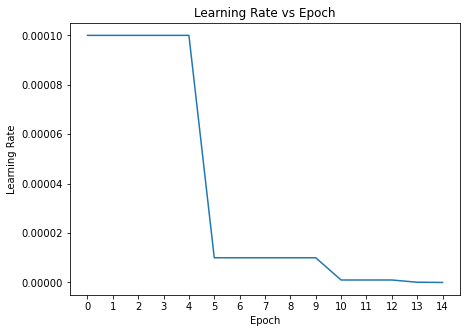

In [18]:
plot_learning_rate(history_dict)

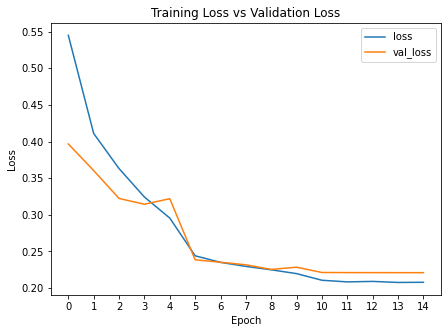

In [19]:
plot_metric(history_dict, 'loss')

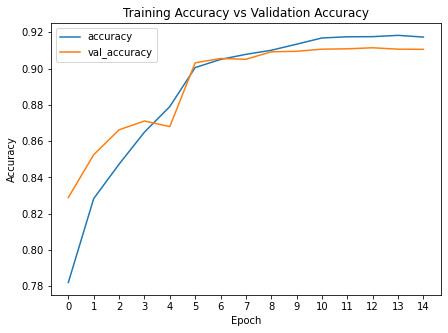

In [20]:
plot_metric(history_dict, 'accuracy')

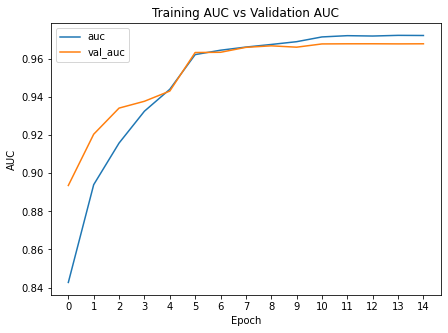

In [21]:
plot_metric(history_dict, 'auc')

---

## Calculate Performance on Test Set

In [22]:
test_metrics = model.evaluate(test_ds, verbose=1)
test_metrics = map_to_metrics(model.metrics_names, test_metrics)

  1/258 [..............................] - ETA: 21s - loss: 0.1411 - accuracy: 0.9375 - auc: 0.9883

 13/258 [>.............................] - ETA: 1s - loss: 0.1990 - accuracy: 0.9255 - auc: 0.9744 

 25/258 [=>............................] - ETA: 0s - loss: 0.2159 - accuracy: 0.9125 - auc: 0.9701

 38/258 [===>..........................] - ETA: 0s - loss: 0.2236 - accuracy: 0.9104 - auc: 0.9684

 50/258 [====>.........................] - ETA: 0s - loss: 0.2173 - accuracy: 0.9125 - auc: 0.9701

 62/258 [======>.......................] - ETA: 0s - loss: 0.2233 - accuracy: 0.9073 - auc: 0.9686

 74/258 [=======>......................] - ETA: 0s - loss: 0.2289 - accuracy: 0.9046 - auc: 0.9664

 86/258 [=========>....................] - ETA: 0s - loss: 0.2262 - accuracy: 0.9055 - auc: 0.9672

 98/258 [==========>...................] - ETA: 0s - loss: 0.2264 - accuracy: 0.9050 - auc: 0.9672

110/258 [===========>..................] - ETA: 0s - loss: 0.2250 - accuracy: 0.9065 - auc: 0.9674

122/258 [=============>................] - ETA: 0s - loss: 0.2278 - accuracy: 0.9047 - auc: 0.9666

135/258 [==============>...............] - ETA: 0s - loss: 0.2257 - accuracy: 0.9062 - auc: 0.9673

148/258 [================>.............] - ETA: 0s - loss: 0.2237 - accuracy: 0.9071 - auc: 0.9679

161/258 [=================>............] - ETA: 0s - loss: 0.2252 - accuracy: 0.9064 - auc: 0.9672

174/258 [===================>..........] - ETA: 0s - loss: 0.2208 - accuracy: 0.9084 - auc: 0.9686

187/258 [====================>.........] - ETA: 0s - loss: 0.2224 - accuracy: 0.9076 - auc: 0.9681

199/258 [======================>.......] - ETA: 0s - loss: 0.2252 - accuracy: 0.9064 - auc: 0.9672

211/258 [=======================>......] - ETA: 0s - loss: 0.2261 - accuracy: 0.9064 - auc: 0.9670

222/258 [========================>.....] - ETA: 0s - loss: 0.2267 - accuracy: 0.9064 - auc: 0.9670

234/258 [==========================>...] - ETA: 0s - loss: 0.2269 - accuracy: 0.9061 - auc: 0.9671

246/258 [===========================>..] - ETA: 0s - loss: 0.2279 - accuracy: 0.9060 - auc: 0.9668

258/258 [==============================] - ETA: 0s - loss: 0.2264 - accuracy: 0.9064 - auc: 0.9672

258/258 [==============================] - 1s 4ms/step - loss: 0.2264 - accuracy: 0.9064 - auc: 0.9672


In [23]:
# Save test metrics
json.dump(test_metrics, open(f"{model_output_dir}/{MODEL_NAME}/test_metrics.json", 'w'))

---